# <center>**Image Captioning Using Deep Learning**</center>

# **Problem Statement**  
---
## <center>Develop an AI model that generates accurate and fluent captions for images, leveraging deep learning techniques.</center>  

### **Motivation**
- Enhancing accessibility for visually impaired individuals by describing visual content.
- Applications in social media, photography, and automatic metadata generation for images.
- Revitalizing archives and enabling better content understanding through descriptive annotations.


# **Project Overview**
---
This project focuses on implementing an **Image Captioning** system using deep learning techniques. The goal of this project is to generate descriptive captions for images by leveraging both image feature extraction and natural language generation.

Image captioning is a combination of **Computer Vision** and **Natural Language Processing (NLP)**. It involves:
- Extracting visual features from an image using a Convolutional Neural Network (CNN).
- Decoding the features into meaningful captions using a Recurrent Neural Network (RNN), such as LSTM or BiLSTM.

This notebook documents the step-by-step process, starting from data preparation to building, training, and testing the model. The captions are further refined using post-processing techniques like beam search and text cleaning.


# **Dataset Description**
---
- **Dataset Used**: [Flickr8k Dataset](https://www.kaggle.com/datasets/adityajn105/flickr8k).  
  The Flickr8k dataset is widely used for research in image captioning tasks due to its manageable size and diverse image content.  
- **Number of Images**: 8,000 high-quality images featuring real-world scenarios.  
- **Captions**: Each image is accompanied by 5 human-generated captions that describe the content of the image from different perspectives. These captions ensure a variety of descriptive language.  
- **Data Files**:
  - **Images**: Provided as JPEG files.  
  - **Captions Metadata**: Stored in a text file where each line links an image to a corresponding caption.  

- **Structure**:  
  - **Images**: 8,091 JPEG images, where 6,500 are used for training and 1,591 for testing.  
  - **captions.txt**: A text file mapping each image to its corresponding 5 captions.  

- **Diversity**: The dataset captures a wide range of scenes, including outdoor activities, urban settings, animals, and more, making it suitable for general-purpose image captioning tasks.  

- **Challenges**:
  - Some captions may use different vocabularies or describe less obvious details.
  - Images with overlapping visual content can result in similar captions, requiring careful evaluation of the model's performance.


# Import Required Libraries
---

In [18]:
# Standard Libraries
import os
import re
import json
import random
import pickle
import collections
from tqdm import tqdm
from collections import defaultdict

# Data Processing and Visualization
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import (
    Input, 
    Dropout, 
    Dense, 
    Embedding, 
    LSTM, 
    Add, 
    Bidirectional
)
from tensorflow.keras.utils import to_categorical, pad_sequences

# Dataset Preparation and Statistics
---


The following steps are implemented to load and preprocess the dataset:


#### 1. **Define Dataset Paths**
We start by specifying the paths to the dataset components:
- `dataset_folder`: The main folder containing the dataset.
- `captions_file`: Path to the `captions.txt` file, which holds the image IDs and corresponding captions.
- `images_folder`: Path to the folder containing the image files.


In [19]:
# Define dataset paths
dataset_folder = "dataset"
captions_file = os.path.join(dataset_folder, "captions.txt")
images_folder = os.path.join(dataset_folder, "images")

#### 2. **Loading Captions**
A function `load_captions` is defined to read the `captions.txt` file and parse it into a dictionary. Each image ID maps to a list of its associated captions.

**Key Features:**
- Skips the header of the file.
- Splits each line into image ID and caption.
- Removes the caption index from the image ID (e.g., `image#0` becomes `image`).
- Handles malformed lines gracefully by printing a warning.


In [20]:
def load_captions(captions_file):
    with open(captions_file, "r") as file:
        lines = file.readlines()
    captions_dict = defaultdict(list)
    for line in lines[1:]:  # Skip header
        parts = line.strip().split(",", 1)  # Split only at the first comma
        if len(parts) == 2:  # Ensure the line has exactly two parts
            image_id, caption = parts
            image_id = image_id.split("#")[0]  # Remove caption index (e.g., #0)
            captions_dict[image_id].append(caption)
        else:
            print(f"Skipping malformed line: {line.strip()}")
    return captions_dict

#### 3. **Loading Images**
The function `load_images` retrieves all image files from the `images_folder`. Only files with extensions `.jpg`, `.jpeg`, and `.png` are included.


In [21]:
# Load images
def load_images(images_folder):
    return {image for image in os.listdir(images_folder) if image.lower().endswith(('.jpg', '.jpeg', '.png'))}


#### 4. **Calculating Statistics**
To gain insights into the dataset, the `calculate_statistics` function computes:
- **Total Captions**: The total number of captions in the dataset.
- **Total Images in Folder**: The total number of images available in the folder.
- **Unique Image IDs in Captions**: The number of unique image IDs found in the captions file.


In [22]:
# Calculate statistics
def calculate_statistics(captions_dict, images_set):
    total_captions = sum(len(captions) for captions in captions_dict.values())
    total_images = len(images_set)
    unique_image_ids = len(captions_dict.keys())
    
    stats = {
        "Total Captions": total_captions,
        "Total Images in Folder": total_images,
        "Unique Image IDs in Captions": unique_image_ids,
    }
    return stats

#### 5. **Execution and Statistics Display**
The script loads the captions and images, computes statistics, and displays them in a readable format.


In [23]:
# Main logic
captions_dict = load_captions(captions_file)
images_set = load_images(images_folder)
stats = calculate_statistics(captions_dict, images_set)

# Print statistics
for stat, value in stats.items():
    print(f"{stat}: {value}")

Total Captions: 40455
Total Images in Folder: 8091
Unique Image IDs in Captions: 8091


#### 6. **Saving the Captions Dictionary**
To reuse the parsed captions data, the dictionary is saved to a JSON file in a human-readable format using the `save_captions_dict` function.


In [24]:
def save_captions_dict(captions_dict):
    output_file = "captions_dict.json"
    with open(output_file, "w") as outfile:
            json.dump(captions_dict, outfile, indent=4)  # Use json.dump to write the dictionary in a readable format
    print(f"Captions Dictionary Saved to {output_file}")
    
save_captions_dict(captions_dict)

Captions Dictionary Saved to captions_dict.json


In [25]:
# Load captions from the JSON file
def load_captions_from_json(json_file):
    with open(json_file, "r") as infile:
        captions_dict = json.load(infile)
    return captions_dict

## Displaying Images and Captions

This section describes the process to load and visually inspect images from the dataset along with their associated captions.


#### **Function: Display Image and Captions**
A utility function `display_image_and_captions` is implemented to load and display an image and its corresponding captions. 

**Steps Performed:**
1. **Image Path Resolution**: Combines the image folder path and image ID to create the full image path.
2. **Image Loading**: 
   - Uses the `Pillow` (PIL) library to load the image.
   - Handles cases where the image file is missing by catching a `FileNotFoundError`.
3. **Retrieve Captions**:
   - Fetches all captions associated with the given image ID from the captions dictionary.
   - If no captions are available for the given image ID, an empty list is returned.
4. **Display Captions**: 
   - Prints all captions associated with the image in a clean, readable format.


In [26]:
# Function to load and display an image along with captions
def display_image_and_captions(image_id, captions_dict, images_folder):
    # Get the image path
    image_path = os.path.join(images_folder, image_id)
    
    # Load the image using PIL (Pillow)
    try:
        image = Image.open(image_path)
        display(image)
    except FileNotFoundError:
        print(f"Image {image_id} not found in {images_folder}.")
        return

    # Get the captions for the image
    captions = captions_dict.get(image_id, [])
    
    # Print all captions for the image
    print(f"Captions for {image_id}:")
    for caption in captions:
        print(f"- {caption}")


#### **Loading Captions from JSON**
The previously saved captions dictionary in JSON format is now loaded using a helper function `load_captions_from_json`. This ensures that the captions data is readily accessible for visualization.


In [27]:
captions_dict_file = "captions_dict.json"
images_folder = "dataset/images"  # Adjust this if needed

# Load captions dictionary from the JSON file
captions_dict = load_captions_from_json(captions_dict_file)

#### **Display Example**
To demonstrate the functionality, an image ID is selected from the dataset, and the function is called to display the image and its captions.


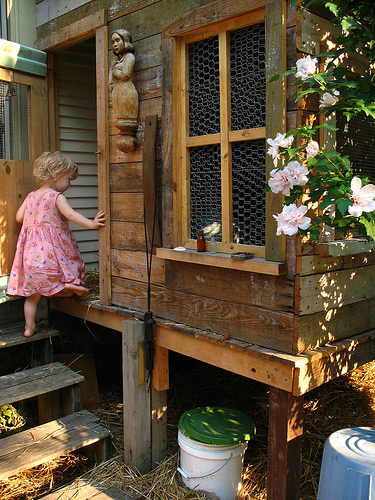

Captions for 1000268201_693b08cb0e.jpg:
- A child in a pink dress is climbing up a set of stairs in an entry way .
- A girl going into a wooden building .
- A little girl climbing into a wooden playhouse .
- A little girl climbing the stairs to her playhouse .
- A little girl in a pink dress going into a wooden cabin .


In [28]:
# Example: Display image and captions for a specific image ID (replace with any image ID from the dataset)
image_id = "1000268201_693b08cb0e.jpg"  # Replace this with any image ID from your dataset
display_image_and_captions(image_id, captions_dict, images_folder)

# Data Preprocessing
---

Data preprocessing is a crucial step to ensure the text data is clean, uniform, and ready for use in a deep learning model. This section describes the text preprocessing applied to the captions in the dataset.


#### **Text Cleaning Function**
A custom function `clean_text` is implemented to clean and standardize the captions.

**Steps in `clean_text`**:
1. **Lowercasing**: Converts all text to lowercase to ensure uniformity.
2. **Remove Non-Alphabetic Characters**:
   - Eliminates any character that is not a letter (e.g., punctuation, numbers) while preserving spaces.
3. **Tokenization**:
   - Splits the cleaned text into individual words.
4. **Remove Single-Character Words**:
   - Filters out words with only a single character (e.g., "a", "b").
5. **Reconstruction**:
   - Joins the cleaned words back into a single sentence.

In [29]:
def clean_text(sentence):
    # Convert to lowercase
    sentence = sentence.lower()
    
    # Remove non-alphabetic characters (keeping spaces)
    sentence = re.sub('[^a-z]+', ' ', sentence)
    
    # Split into words
    sentence = sentence.split()
    
    # Remove single-character words
    sentence = [word for word in sentence if len(word) > 1]
    
    # Join the words back into a sentence
    sentence = ' '.join(sentence)
    
    return sentence

#### **Applying the Cleaning Function to Captions**
The `clean_text` function is applied to all captions in the `captions_dict`.

**Steps**:
1. Iterate over all keys (image IDs) in the `captions_dict`.
2. For each caption in the list of captions associated with an image, clean the text using `clean_text`.
3. Save the updated `captions_dict` for future use.


In [30]:
for key, caption_list in captions_dict.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

#### **Example Output**
Cleaning captions for the image ID `1000268201_693b08cb0e.jpg`:

In [31]:
captions_dict['1000268201_693b08cb0e.jpg']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

**Before Cleaning**:
```
['A child playing in the snow.', 'A young child in a pink coat playing outside.', 'A little girl is playing in the snow.', 'A young girl wearing a pink jacket plays in the snow.', 'A small girl in a pink coat playing outside in the snow.']
```

**After Cleaning**:
```
['child playing in snow', 'young child pink coat playing outside', 'little girl playing in snow', 'young girl wearing pink jacket plays snow', 'small girl pink coat playing outside snow']
```

#### **Saving the Processed Captions**
The updated `captions_dict` is saved to a JSON file for later use.

In [32]:
save_captions_dict(captions_dict)

Captions Dictionary Saved to captions_dict.json


# Vocabulary Extraction and Analysis
---
Building a robust vocabulary is a key aspect of training an image captioning model. This section describes the steps to extract, analyze, and filter the vocabulary from the captions dataset.

1. **Initialize Vocabulary**:
   - Use a Python `set` to store unique words from all captions.

2. **Update Vocabulary**:
   - Iterate over all captions in the dataset.
   - Split each caption into words and add them to the vocabulary.


In [33]:
vocab = set()
for key in captions_dict.keys():
    [vocab.update(sentence.split()) for sentence in captions_dict[key]]
    
print("Vocab Size(unique words In Vocab) : %d"% len(vocab))

Vocab Size(unique words In Vocab) : 8424


#### **Word Frequency Analysis**

To understand the distribution of words across all captions:

1. **Aggregate Words**:
   - Create a list `all_words` to store all words from the captions.
   - Create a `set` `unique_words` to store unique words.

2. **Clean Captions**:
   - Clean each caption using the `clean_text` function to ensure consistency.
   - Split cleaned captions into words and add them to `all_words` and `unique_words`.


In [34]:
# Initialize variables to store all words and unique words
all_words = []  # List to store all words
unique_words = set()  # Set to store unique words

# Process all captions and extract words
for img_id, captions in captions_dict.items():
    for caption in captions:
        cleaned_caption = clean_text(caption)  # Clean the caption
        words = cleaned_caption.split()  # Split the cleaned caption into words
        all_words.extend(words)  # Add words to the all_words list
        unique_words.update(words)  # Add words to the unique_words set

# Now all_words contains all words and unique_words contains the unique ones
print(f"Total words in all captions: {len(all_words)}")
print(f"Unique words in all captions: {len(unique_words)}")

Total words in all captions: 373803
Unique words in all captions: 8424


#### **Word Frequency Count**

1. **Count Word Frequencies**:
   - Use `collections.Counter` to count the occurrences of each word in the `all_words` list.

2. **Sort by Frequency**:
   - Create a dictionary of word frequencies and sort it in descending order based on word count.


In [35]:
# Count word frequencies
counter = collections.Counter(all_words)
frq_cnt = dict(counter)

# Print the number of unique words
print(f"Number of unique words: {len(frq_cnt.keys())}")

# Sort the dictionary by frequency count (descending order)
sorted_freq_cnt = sorted(frq_cnt.items(), reverse=True, key=lambda x: x[1])

Number of unique words: 8424


#### **Vocabulary Filtering**

1. **Define a Frequency Threshold**:
   - Use a threshold to filter out infrequent words (e.g., words that occur less than 10 times).

2. **Filter Words**:
   - Create a filtered vocabulary containing only words that appear more than the threshold.

3. **Analyze Vocabulary Size**:
   - Print the new vocabulary size after filtering.

In [36]:
# Filter words based on a frequency threshold
threshold = 10
filtered_freq_cnt = [x for x in sorted_freq_cnt if x[1] > threshold]

# Create a list of filtered words
filtered_words = [x[0] for x in filtered_freq_cnt]

# Print the new vocabulary size after filtering
print(f"Vocabulary size after filtering (threshold {threshold}): {len(filtered_words)}")


Vocabulary size after filtering (threshold 10): 1845


# Data Splitting and Preparation
---
This section outlines the process of splitting the dataset into training and testing sets and preparing the captions with special tokens for the training process.

#### **Data Splitting**

To ensure a fair evaluation of the model, the dataset is divided into training and testing sets.

1. **Random Shuffle**:
   - Shuffle the image IDs to ensure a random split of the data.

2. **Split Proportion**:
   - The dataset is divided into **6,500 samples for training** and the remaining samples for testing.

3. **Save the Splits**:
   - Save the training and testing splits into separate JSON files for future use.


In [18]:
# Get the list of image IDs
image_ids = list(captions_dict.keys())

# Shuffle the image IDs randomly to ensure a random split
random.shuffle(image_ids)

# Define the number of training samples
train_size = 6500

# Split the image IDs into train and test
train_image_ids = image_ids[:train_size]
test_image_ids = image_ids[train_size:]

# Create train_data and test_data dictionaries based on the split
train_data = {img_id: captions_dict[img_id] for img_id in train_image_ids}
test_data = {img_id: captions_dict[img_id] for img_id in test_image_ids}

# Save the train and test data into separate JSON files
with open("train_data.json", "w") as train_file:
    json.dump(train_data, train_file, indent=4)

with open("test_data.json", "w") as test_file:
    json.dump(test_data, test_file, indent=4)

# Print the number of samples in each split
print(f"Train data contains {len(train_data)} samples.")
print(f"Test data contains {len(test_data)} samples.")

Train data contains 6500 samples.
Test data contains 1591 samples.


#### **Loading the Splits**

1. **Load Training and Testing Data**:
   - Read the JSON files to retrieve the split data.
   - Verify the number of samples in each split.

In [37]:
# Load train data
with open("train_data.json", "r") as train_file:
    train_data = json.load(train_file)

# Load test data
with open("test_data.json", "r") as test_file:
    test_data = json.load(test_file)

# Print the number of samples in each loaded split to verify
print(f"Loaded Train data contains {len(train_data)} samples.")
print(f"Loaded Test data contains {len(test_data)} samples.")

Loaded Train data contains 6500 samples.
Loaded Test data contains 1591 samples.


#### **Adding Special Tokens**

To prepare the captions for training, add `<START>` and `<END>` tokens to each caption:

1. **Define Tokens**:
   - **`<START>`**: Indicates the beginning of the caption.
   - **`<END>`**: Indicates the end of the caption.

2. **Process Training Captions**:
   - Add these tokens to every caption in the training dataset.


In [38]:
# Define the start and end tokens
START_TOKEN = "<START>"
END_TOKEN = "<END>"

# Prepare Descriptions for the Training Data
train_captions_dict = {}
for img_id in train_data:  # Use train_data instead of train to get the image captions
    train_captions_dict[img_id] = []
    for caption in train_data[img_id]:  # Loop through the captions
        # Add the start and end tokens
        caption_with_tokens = f"{START_TOKEN} {caption} {END_TOKEN}"
        train_captions_dict[img_id].append(caption_with_tokens)

# Optionally, you can print out some examples to check
print(f"Sample caption: {train_captions_dict['1000268201_693b08cb0e.jpg']}")

Sample caption: ['<START> child in pink dress is climbing up set of stairs in an entry way <END>', '<START> girl going into wooden building <END>', '<START> little girl climbing into wooden playhouse <END>', '<START> little girl climbing the stairs to her playhouse <END>', '<START> little girl in pink dress going into wooden cabin <END>']


# Feature Extraction
---
### Image Feature Extraction

In this section, we extract features from images using the **ResNet50** model pre-trained on the ImageNet dataset. These features serve as inputs to the image captioning model.


#### **1. Load Pre-trained ResNet50**

- **Model Selection**: Use the ResNet50 model pre-trained on ImageNet.
- **Feature Extraction Layer**: Extract features from the second-to-last layer of the model.
- **Summary**: Display the architecture to ensure the model is configured correctly.


In [39]:
# Load the pre-trained ResNet50 model
cnn_model = ResNet50(weights='imagenet', input_shape=(224, 224, 3))

# Create a new model that outputs the features from the second-to-last layer
image_model = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-2].output)

# Summary of the model to see the layers
image_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

#### **2. Image Preprocessing**

Before feeding images into the model, they must be prepared:

- **Resize**: Images are resized to 224x224 pixels.
- **Convert to Array**: Images are converted into numerical arrays.
- **Normalize**: Use ResNet50's `preprocess_input` function to normalize pixel values.
- **Expand Dimensions**: Add a batch dimension to match the input shape.


In [40]:
# Function to prepare the image for the model
def prepare_image_for_model(img):
    img = image.load_img(img, target_size=(224, 224))  # Resize image to 224x224
    img = image.img_to_array(img)  # Convert image to array
    img = np.expand_dims(img, axis=0)  # Add batch dimension (shape: (1, 224, 224, 3))
    img = preprocess_input(img)  # Normalize the image for ResNet50
    return img

#### **3. Feature Extraction**

- Use the ResNet50 model to extract a **2048-dimensional feature vector** for each image.
- These feature vectors represent high-level features learned by the model.


In [218]:
# Function to extract features from the image
def extract_image_features(img):
    img = prepare_image_for_model(img)  # Prepare the image
    feature_vector = image_model.predict(img, verbose=0)  # Get the feature vector from ResNet50
    feature_vector = feature_vector.reshape((2048,))  # Flatten the feature vector
    return feature_vector

In [219]:
extract_image_features('./dataset/images/'+"1000268201_693b08cb0e.jpg")

array([0.06536571, 0.16782746, 0.3251849 , ..., 0.0511153 , 0.3281789 ,
       1.0043337 ], dtype=float32)

#### **4. Extract Features for Training Images**

- Loop through the training dataset and extract features for each image.
- Use `tqdm` for progress tracking during feature extraction.


In [24]:
# Initialize the dictionary to store image features
train_image_features = {}

# Loop through each image ID in train_data, checking if it has a .jpg extension
for img_id in tqdm(train_data.keys(), desc="Encoding images", unit="image"):
    # Check if the image ID ends with '.jpg'
    if img_id.endswith('.jpg'):
        # Construct the image path
        img_path = './dataset/images/' + img_id
        
        # Extract the feature vector for the image and add it to the dictionary
        train_image_features[img_id] = extract_image_features(img_path)

Encoding images:   0%|          | 0/6500 [00:00<?, ?image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Encoding images:   0%|          | 1/6500 [00:00<22:28,  4.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Encoding images:   0%|          | 2/6500 [00:00<23:13,  4.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Encoding images:   0%|          | 3/6500 [00:00<20:45,  5.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Encoding images:   0%|          | 4/6500 [00:00<19:55,  5.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Encoding images:   0%|          | 5/6500 [00:00<20:02,  5.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Encoding images:   0%|          | 6/6500 [00:01<19:23,  5.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Encoding images:   0%|          | 7/6500 [00:01<19:28,  5.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Encoding images:   0%|          | 8/6500 [00:01<20:04,  5.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:   0%|          | 9/6500 [00:01<21:12,  5.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Encoding images:   0%|          | 10/6500 [00:01<20:14,  5.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Encoding images:   0%|          | 11/6500 [00:02<20:58,  5.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Encoding images:   0%|          | 12/6500 [00:02<20:52,  5.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Encoding images:   0%|          | 13/6500 [00:02<20:41,  5.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:   0%|          | 14/6500 [00:02<21:13,  5.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Encoding images:   0%|          | 15/6500 [00:02<21:56,  4.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Encoding images:   0%|          | 16/6500 [00:03<21:45,  4.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Encoding images:   0%|          | 17/6500 [00:03<22:03,  4.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Encoding images:   0%|          | 18/6500 [00:03<21:23,  5.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Encoding images:   0%|          | 19/6500 [00:03<20:49,  5.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Encoding images:   0%|          | 20/6500 [00:03<20:07,  5.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Encoding images:   0%|          | 21/6500 [00:04<20:05,  5.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Encoding images:   0%|          | 22/6500 [00:04<19:37,  5.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Encoding images:   0%|          | 23/6500 [00:04<20:13,  5.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Encoding images:   0%|          | 24/6500 [00:04<19:53,  5.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Encoding images:   0%|          | 25/6500 [00:04<20:00,  5.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Encoding images:   0%|          | 26/6500 [00:04<19:34,  5.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Encoding images:   0%|          | 27/6500 [00:05<19:18,  5.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Encoding images:   0%|          | 28/6500 [00:05<19:37,  5.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:   0%|          | 29/6500 [00:05<21:21,  5.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Encoding images:   0%|          | 30/6500 [00:05<20:35,  5.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Encoding images:   0%|          | 31/6500 [00:05<22:04,  4.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Encoding images:   0%|          | 32/6500 [00:06<21:41,  4.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Encoding images:   1%|          | 33/6500 [00:06<21:48,  4.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:   1%|          | 34/6500 [00:06<22:15,  4.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Encoding images:   1%|          | 35/6500 [00:06<21:52,  4.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Encoding images:   1%|          | 36/6500 [00:06<21:05,  5.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Encoding images:   1%|          | 37/6500 [00:07<20:58,  5.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Encoding images:   1%|          | 38/6500 [00:07<20:02,  5.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Encoding images:   1%|          | 39/6500 [00:07<20:39,  5.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Encoding images:   1%|          | 40/6500 [00:07<19:43,  5.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Encoding images:   1%|          | 41/6500 [00:07<18:55,  5.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Encoding images:   1%|          | 42/6500 [00:08<19:28,  5.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Encoding images:   1%|          | 43/6500 [00:08<19:42,  5.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Encoding images:   1%|          | 44/6500 [00:08<19:50,  5.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Encoding images:   1%|          | 45/6500 [00:08<19:43,  5.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Encoding images:   1%|          | 46/6500 [00:08<19:52,  5.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Encoding images:   1%|          | 47/6500 [00:08<19:36,  5.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Encoding images:   1%|          | 48/6500 [00:09<19:45,  5.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Encoding images:   1%|          | 49/6500 [00:09<19:36,  5.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Encoding images:   1%|          | 50/6500 [00:09<20:09,  5.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Encoding images:   1%|          | 51/6500 [00:09<20:22,  5.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Encoding images:   1%|          | 52/6500 [00:09<21:40,  4.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Encoding images:   1%|          | 53/6500 [00:10<21:36,  4.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Encoding images:   1%|          | 54/6500 [00:10<21:04,  5.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Encoding images:   1%|          | 55/6500 [00:10<20:32,  5.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Encoding images:   1%|          | 56/6500 [00:10<20:29,  5.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Encoding images:   1%|          | 57/6500 [00:10<20:27,  5.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Encoding images:   1%|          | 58/6500 [00:11<19:34,  5.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Encoding images:   1%|          | 59/6500 [00:11<18:25,  5.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Encoding images:   1%|          | 60/6500 [00:11<19:39,  5.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:   1%|          | 61/6500 [00:11<21:14,  5.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Encoding images:   1%|          | 62/6500 [00:11<21:17,  5.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Encoding images:   1%|          | 63/6500 [00:11<20:05,  5.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Encoding images:   1%|          | 64/6500 [00:12<18:44,  5.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Encoding images:   1%|          | 65/6500 [00:12<18:01,  5.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Encoding images:   1%|          | 66/6500 [00:12<17:06,  6.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Encoding images:   1%|          | 67/6500 [00:12<17:00,  6.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Encoding images:   1%|          | 68/6500 [00:12<16:27,  6.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Encoding images:   1%|          | 69/6500 [00:12<17:51,  6.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Encoding images:   1%|          | 70/6500 [00:13<18:54,  5.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Encoding images:   1%|          | 71/6500 [00:13<18:58,  5.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Encoding images:   1%|          | 72/6500 [00:13<18:40,  5.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Encoding images:   1%|          | 73/6500 [00:13<17:47,  6.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Encoding images:   1%|          | 74/6500 [00:13<17:07,  6.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Encoding images:   1%|          | 75/6500 [00:13<16:46,  6.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Encoding images:   1%|          | 76/6500 [00:14<18:04,  5.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Encoding images:   1%|          | 77/6500 [00:14<18:29,  5.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Encoding images:   1%|          | 78/6500 [00:14<17:19,  6.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Encoding images:   1%|          | 79/6500 [00:14<17:58,  5.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Encoding images:   1%|          | 80/6500 [00:14<17:24,  6.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Encoding images:   1%|          | 81/6500 [00:14<17:52,  5.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Encoding images:   1%|▏         | 82/6500 [00:15<18:00,  5.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Encoding images:   1%|▏         | 83/6500 [00:15<17:23,  6.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Encoding images:   1%|▏         | 84/6500 [00:15<16:56,  6.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Encoding images:   1%|▏         | 85/6500 [00:15<16:26,  6.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Encoding images:   1%|▏         | 86/6500 [00:15<16:37,  6.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Encoding images:   1%|▏         | 87/6500 [00:15<16:01,  6.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Encoding images:   1%|▏         | 88/6500 [00:16<16:56,  6.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Encoding images:   1%|▏         | 89/6500 [00:16<16:34,  6.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Encoding images:   1%|▏         | 90/6500 [00:16<16:44,  6.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Encoding images:   1%|▏         | 91/6500 [00:16<16:46,  6.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Encoding images:   1%|▏         | 92/6500 [00:16<18:35,  5.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Encoding images:   1%|▏         | 93/6500 [00:16<17:57,  5.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Encoding images:   1%|▏         | 94/6500 [00:17<18:53,  5.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:   1%|▏         | 95/6500 [00:17<19:19,  5.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Encoding images:   1%|▏         | 96/6500 [00:17<18:20,  5.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Encoding images:   1%|▏         | 97/6500 [00:17<18:37,  5.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Encoding images:   2%|▏         | 98/6500 [00:17<17:53,  5.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Encoding images:   2%|▏         | 99/6500 [00:17<18:05,  5.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Encoding images:   2%|▏         | 100/6500 [00:18<17:43,  6.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Encoding images:   2%|▏         | 101/6500 [00:18<18:10,  5.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Encoding images:   2%|▏         | 102/6500 [00:18<17:31,  6.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Encoding images:   2%|▏         | 103/6500 [00:18<16:45,  6.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Encoding images:   2%|▏         | 104/6500 [00:18<17:55,  5.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Encoding images:   2%|▏         | 105/6500 [00:18<17:20,  6.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Encoding images:   2%|▏         | 106/6500 [00:19<18:47,  5.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Encoding images:   2%|▏         | 107/6500 [00:19<17:40,  6.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Encoding images:   2%|▏         | 108/6500 [00:19<17:01,  6.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Encoding images:   2%|▏         | 109/6500 [00:19<19:48,  5.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Encoding images:   2%|▏         | 110/6500 [00:19<19:15,  5.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:   2%|▏         | 111/6500 [00:19<20:40,  5.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Encoding images:   2%|▏         | 112/6500 [00:20<21:08,  5.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Encoding images:   2%|▏         | 113/6500 [00:20<20:52,  5.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Encoding images:   2%|▏         | 114/6500 [00:20<19:28,  5.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Encoding images:   2%|▏         | 115/6500 [00:20<20:25,  5.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Encoding images:   2%|▏         | 116/6500 [00:21<21:51,  4.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Encoding images:   2%|▏         | 117/6500 [00:21<22:02,  4.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:   2%|▏         | 118/6500 [00:21<22:24,  4.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:   2%|▏         | 119/6500 [00:21<22:41,  4.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Encoding images:   2%|▏         | 120/6500 [00:21<22:33,  4.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Encoding images:   2%|▏         | 121/6500 [00:22<20:42,  5.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Encoding images:   2%|▏         | 122/6500 [00:22<19:50,  5.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Encoding images:   2%|▏         | 123/6500 [00:22<19:33,  5.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Encoding images:   2%|▏         | 124/6500 [00:22<17:59,  5.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Encoding images:   2%|▏         | 125/6500 [00:22<17:44,  5.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:   2%|▏         | 126/6500 [00:22<19:02,  5.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Encoding images:   2%|▏         | 127/6500 [00:23<17:57,  5.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Encoding images:   2%|▏         | 128/6500 [00:23<17:33,  6.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Encoding images:   2%|▏         | 129/6500 [00:23<17:28,  6.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Encoding images:   2%|▏         | 130/6500 [00:23<16:50,  6.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Encoding images:   2%|▏         | 131/6500 [00:23<16:55,  6.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Encoding images:   2%|▏         | 132/6500 [00:23<16:49,  6.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Encoding images:   2%|▏         | 133/6500 [00:23<17:26,  6.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Encoding images:   2%|▏         | 134/6500 [00:24<17:00,  6.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Encoding images:   2%|▏         | 135/6500 [00:24<17:57,  5.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Encoding images:   2%|▏         | 136/6500 [00:24<17:36,  6.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Encoding images:   2%|▏         | 137/6500 [00:24<18:34,  5.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Encoding images:   2%|▏         | 138/6500 [00:24<17:47,  5.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Encoding images:   2%|▏         | 139/6500 [00:25<18:43,  5.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:   2%|▏         | 140/6500 [00:25<19:39,  5.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Encoding images:   2%|▏         | 141/6500 [00:25<18:21,  5.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:   2%|▏         | 142/6500 [00:25<19:47,  5.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Encoding images:   2%|▏         | 143/6500 [00:25<18:31,  5.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Encoding images:   2%|▏         | 144/6500 [00:25<17:31,  6.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Encoding images:   2%|▏         | 145/6500 [00:26<18:47,  5.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Encoding images:   2%|▏         | 146/6500 [00:26<18:47,  5.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Encoding images:   2%|▏         | 147/6500 [00:26<19:29,  5.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Encoding images:   2%|▏         | 148/6500 [00:26<18:53,  5.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Encoding images:   2%|▏         | 149/6500 [00:26<17:56,  5.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Encoding images:   2%|▏         | 150/6500 [00:26<16:55,  6.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Encoding images:   2%|▏         | 151/6500 [00:27<17:41,  5.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Encoding images:   2%|▏         | 152/6500 [00:27<18:02,  5.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Encoding images:   2%|▏         | 153/6500 [00:27<18:12,  5.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Encoding images:   2%|▏         | 154/6500 [00:27<18:08,  5.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Encoding images:   2%|▏         | 155/6500 [00:27<17:44,  5.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Encoding images:   2%|▏         | 156/6500 [00:27<17:19,  6.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Encoding images:   2%|▏         | 157/6500 [00:28<19:01,  5.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Encoding images:   2%|▏         | 158/6500 [00:28<17:59,  5.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Encoding images:   2%|▏         | 159/6500 [00:28<18:23,  5.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Encoding images:   2%|▏         | 160/6500 [00:28<18:06,  5.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Encoding images:   2%|▏         | 161/6500 [00:28<18:15,  5.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Encoding images:   2%|▏         | 162/6500 [00:28<17:15,  6.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Encoding images:   3%|▎         | 163/6500 [00:29<17:45,  5.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Encoding images:   3%|▎         | 164/6500 [00:29<18:05,  5.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Encoding images:   3%|▎         | 165/6500 [00:29<18:25,  5.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Encoding images:   3%|▎         | 166/6500 [00:29<17:23,  6.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Encoding images:   3%|▎         | 167/6500 [00:29<16:58,  6.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Encoding images:   3%|▎         | 168/6500 [00:29<18:20,  5.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:   3%|▎         | 169/6500 [00:30<19:08,  5.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Encoding images:   3%|▎         | 170/6500 [00:30<18:04,  5.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Encoding images:   3%|▎         | 171/6500 [00:30<18:38,  5.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Encoding images:   3%|▎         | 172/6500 [00:30<18:34,  5.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Encoding images:   3%|▎         | 173/6500 [00:30<17:39,  5.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Encoding images:   3%|▎         | 174/6500 [00:31<17:17,  6.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Encoding images:   3%|▎         | 175/6500 [00:31<18:51,  5.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Encoding images:   3%|▎         | 176/6500 [00:31<17:45,  5.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Encoding images:   3%|▎         | 177/6500 [00:31<17:49,  5.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Encoding images:   3%|▎         | 178/6500 [00:31<17:21,  6.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Encoding images:   3%|▎         | 179/6500 [00:31<17:17,  6.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Encoding images:   3%|▎         | 180/6500 [00:32<16:57,  6.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Encoding images:   3%|▎         | 181/6500 [00:32<18:24,  5.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Encoding images:   3%|▎         | 182/6500 [00:32<17:27,  6.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Encoding images:   3%|▎         | 183/6500 [00:32<17:37,  5.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Encoding images:   3%|▎         | 184/6500 [00:32<17:41,  5.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Encoding images:   3%|▎         | 185/6500 [00:32<18:44,  5.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Encoding images:   3%|▎         | 186/6500 [00:33<17:56,  5.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Encoding images:   3%|▎         | 187/6500 [00:33<18:00,  5.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Encoding images:   3%|▎         | 188/6500 [00:33<18:58,  5.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Encoding images:   3%|▎         | 189/6500 [00:33<19:32,  5.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:   3%|▎         | 190/6500 [00:33<19:57,  5.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Encoding images:   3%|▎         | 191/6500 [00:34<19:37,  5.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Encoding images:   3%|▎         | 192/6500 [00:34<19:59,  5.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Encoding images:   3%|▎         | 193/6500 [00:34<19:19,  5.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Encoding images:   3%|▎         | 194/6500 [00:34<18:38,  5.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Encoding images:   3%|▎         | 195/6500 [00:34<17:34,  5.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Encoding images:   3%|▎         | 196/6500 [00:34<18:03,  5.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Encoding images:   3%|▎         | 197/6500 [00:35<17:24,  6.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Encoding images:   3%|▎         | 198/6500 [00:35<17:49,  5.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding images:   3%|▎         | 199/6500 [00:35<19:06,  5.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Encoding images:   3%|▎         | 200/6500 [00:35<19:35,  5.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:   3%|▎         | 201/6500 [00:35<22:23,  4.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:   3%|▎         | 202/6500 [00:36<25:54,  4.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:   3%|▎         | 203/6500 [00:36<28:21,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:   3%|▎         | 204/6500 [00:36<29:37,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:   3%|▎         | 205/6500 [00:37<29:39,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:   3%|▎         | 206/6500 [00:37<30:28,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:   3%|▎         | 207/6500 [00:37<30:25,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:   3%|▎         | 208/6500 [00:38<31:42,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:   3%|▎         | 209/6500 [00:38<32:28,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding images:   3%|▎         | 210/6500 [00:38<33:28,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:   3%|▎         | 211/6500 [00:39<33:55,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:   3%|▎         | 212/6500 [00:39<33:55,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:   3%|▎         | 213/6500 [00:39<34:02,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:   3%|▎         | 214/6500 [00:40<34:04,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding images:   3%|▎         | 215/6500 [00:40<33:39,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:   3%|▎         | 216/6500 [00:40<33:35,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Encoding images:   3%|▎         | 217/6500 [00:41<34:49,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:   3%|▎         | 218/6500 [00:41<34:37,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:   3%|▎         | 219/6500 [00:41<34:19,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:   3%|▎         | 220/6500 [00:42<34:09,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:   3%|▎         | 221/6500 [00:42<34:29,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Encoding images:   3%|▎         | 222/6500 [00:42<34:53,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:   3%|▎         | 223/6500 [00:42<34:23,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Encoding images:   3%|▎         | 224/6500 [00:43<34:36,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:   3%|▎         | 225/6500 [00:43<33:59,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding images:   3%|▎         | 226/6500 [00:43<34:36,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding images:   3%|▎         | 227/6500 [00:44<34:17,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Encoding images:   4%|▎         | 228/6500 [00:44<34:31,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:   4%|▎         | 229/6500 [00:44<34:32,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding images:   4%|▎         | 230/6500 [00:45<34:52,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Encoding images:   4%|▎         | 231/6500 [00:45<36:15,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding images:   4%|▎         | 232/6500 [00:46<36:47,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:   4%|▎         | 233/6500 [00:46<36:10,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:   4%|▎         | 234/6500 [00:46<35:29,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding images:   4%|▎         | 235/6500 [00:47<35:02,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding images:   4%|▎         | 236/6500 [00:47<34:57,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:   4%|▎         | 237/6500 [00:47<34:43,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Encoding images:   4%|▎         | 238/6500 [00:48<35:03,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:   4%|▎         | 239/6500 [00:48<34:33,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Encoding images:   4%|▎         | 240/6500 [00:48<34:29,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding images:   4%|▎         | 241/6500 [00:49<34:43,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:   4%|▎         | 242/6500 [00:49<34:42,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding images:   4%|▎         | 243/6500 [00:49<34:09,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:   4%|▍         | 244/6500 [00:50<34:39,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:   4%|▍         | 245/6500 [00:50<34:15,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:   4%|▍         | 246/6500 [00:50<34:06,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:   4%|▍         | 247/6500 [00:51<34:47,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:   4%|▍         | 248/6500 [00:51<34:36,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:   4%|▍         | 249/6500 [00:51<34:42,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:   4%|▍         | 250/6500 [00:51<33:37,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:   4%|▍         | 251/6500 [00:52<32:38,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:   4%|▍         | 252/6500 [00:52<31:42,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:   4%|▍         | 253/6500 [00:52<31:17,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:   4%|▍         | 254/6500 [00:53<31:05,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:   4%|▍         | 255/6500 [00:53<31:10,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:   4%|▍         | 256/6500 [00:53<30:37,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Encoding images:   4%|▍         | 257/6500 [00:53<28:41,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Encoding images:   4%|▍         | 258/6500 [00:54<25:30,  4.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:   4%|▍         | 259/6500 [00:54<25:07,  4.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:   4%|▍         | 260/6500 [00:54<26:45,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding images:   4%|▍         | 261/6500 [00:54<29:02,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Encoding images:   4%|▍         | 262/6500 [00:55<30:48,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Encoding images:   4%|▍         | 263/6500 [00:55<32:38,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:   4%|▍         | 264/6500 [00:55<31:47,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:   4%|▍         | 265/6500 [00:56<32:02,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:   4%|▍         | 266/6500 [00:56<31:50,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:   4%|▍         | 267/6500 [00:56<32:24,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:   4%|▍         | 268/6500 [00:57<33:05,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:   4%|▍         | 269/6500 [00:57<32:01,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding images:   4%|▍         | 270/6500 [00:57<34:37,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:   4%|▍         | 271/6500 [00:58<34:39,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:   4%|▍         | 272/6500 [00:58<33:06,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:   4%|▍         | 273/6500 [00:58<33:14,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:   4%|▍         | 274/6500 [00:59<32:43,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:   4%|▍         | 275/6500 [00:59<31:05,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:   4%|▍         | 276/6500 [00:59<30:36,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:   4%|▍         | 277/6500 [01:00<30:16,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:   4%|▍         | 278/6500 [01:00<30:21,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:   4%|▍         | 279/6500 [01:00<30:16,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:   4%|▍         | 280/6500 [01:00<30:18,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding images:   4%|▍         | 281/6500 [01:01<31:46,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:   4%|▍         | 282/6500 [01:01<30:55,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:   4%|▍         | 283/6500 [01:01<31:23,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:   4%|▍         | 284/6500 [01:02<31:49,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding images:   4%|▍         | 285/6500 [01:02<32:39,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:   4%|▍         | 286/6500 [01:02<33:03,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:   4%|▍         | 287/6500 [01:03<32:51,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:   4%|▍         | 288/6500 [01:03<33:33,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding images:   4%|▍         | 289/6500 [01:03<34:22,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:   4%|▍         | 290/6500 [01:04<34:24,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:   4%|▍         | 291/6500 [01:04<34:25,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:   4%|▍         | 292/6500 [01:04<34:26,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:   5%|▍         | 293/6500 [01:05<34:10,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:   5%|▍         | 294/6500 [01:05<34:18,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Encoding images:   5%|▍         | 295/6500 [01:05<34:56,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:   5%|▍         | 296/6500 [01:06<34:26,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:   5%|▍         | 297/6500 [01:06<33:40,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:   5%|▍         | 298/6500 [01:06<36:04,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:   5%|▍         | 299/6500 [01:07<35:13,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:   5%|▍         | 300/6500 [01:07<34:42,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:   5%|▍         | 301/6500 [01:07<36:26,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:   5%|▍         | 302/6500 [01:08<34:51,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:   5%|▍         | 303/6500 [01:08<33:37,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:   5%|▍         | 304/6500 [01:08<32:39,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:   5%|▍         | 305/6500 [01:09<31:54,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:   5%|▍         | 306/6500 [01:09<32:02,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:   5%|▍         | 307/6500 [01:09<31:42,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:   5%|▍         | 308/6500 [01:09<30:58,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:   5%|▍         | 309/6500 [01:10<30:33,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:   5%|▍         | 310/6500 [01:10<30:02,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding images:   5%|▍         | 311/6500 [01:10<31:21,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:   5%|▍         | 312/6500 [01:11<31:57,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:   5%|▍         | 313/6500 [01:11<30:58,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:   5%|▍         | 314/6500 [01:11<30:30,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:   5%|▍         | 315/6500 [01:12<31:14,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:   5%|▍         | 316/6500 [01:12<30:55,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:   5%|▍         | 317/6500 [01:12<31:29,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:   5%|▍         | 318/6500 [01:12<30:16,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:   5%|▍         | 319/6500 [01:14<57:42,  1.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Encoding images:   5%|▍         | 320/6500 [01:14<51:37,  2.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:   5%|▍         | 321/6500 [01:14<45:32,  2.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:   5%|▍         | 322/6500 [01:15<41:05,  2.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:   5%|▍         | 323/6500 [01:15<37:29,  2.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:   5%|▍         | 324/6500 [01:15<34:11,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:   5%|▌         | 325/6500 [01:15<32:28,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:   5%|▌         | 326/6500 [01:16<32:06,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:   5%|▌         | 327/6500 [01:16<31:24,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:   5%|▌         | 328/6500 [01:16<32:21,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding images:   5%|▌         | 329/6500 [01:17<35:12,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Encoding images:   5%|▌         | 330/6500 [01:17<35:02,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:   5%|▌         | 331/6500 [01:17<34:17,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:   5%|▌         | 332/6500 [01:18<34:14,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:   5%|▌         | 333/6500 [01:18<35:24,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:   5%|▌         | 334/6500 [01:18<35:46,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:   5%|▌         | 335/6500 [01:19<34:35,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:   5%|▌         | 336/6500 [01:19<34:09,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:   5%|▌         | 337/6500 [01:19<33:59,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:   5%|▌         | 338/6500 [01:20<36:54,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:   5%|▌         | 339/6500 [01:20<35:31,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:   5%|▌         | 340/6500 [01:20<34:42,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Encoding images:   5%|▌         | 341/6500 [01:21<35:04,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:   5%|▌         | 342/6500 [01:21<34:48,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:   5%|▌         | 343/6500 [01:21<34:30,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:   5%|▌         | 344/6500 [01:22<34:06,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:   5%|▌         | 345/6500 [01:22<34:01,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:   5%|▌         | 346/6500 [01:22<33:45,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:   5%|▌         | 347/6500 [01:23<33:10,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:   5%|▌         | 348/6500 [01:23<32:29,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:   5%|▌         | 349/6500 [01:23<33:52,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:   5%|▌         | 350/6500 [01:24<33:25,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:   5%|▌         | 351/6500 [01:24<32:40,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Encoding images:   5%|▌         | 352/6500 [01:24<33:25,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:   5%|▌         | 353/6500 [01:25<33:04,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:   5%|▌         | 354/6500 [01:25<33:16,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:   5%|▌         | 355/6500 [01:25<33:00,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:   5%|▌         | 356/6500 [01:26<32:14,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:   5%|▌         | 357/6500 [01:26<31:48,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:   6%|▌         | 358/6500 [01:26<31:20,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:   6%|▌         | 359/6500 [01:27<31:08,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:   6%|▌         | 360/6500 [01:27<31:14,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:   6%|▌         | 361/6500 [01:27<31:14,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:   6%|▌         | 362/6500 [01:28<32:32,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:   6%|▌         | 363/6500 [01:28<32:10,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:   6%|▌         | 364/6500 [01:28<31:49,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:   6%|▌         | 365/6500 [01:28<31:51,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Encoding images:   6%|▌         | 366/6500 [01:29<32:51,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:   6%|▌         | 367/6500 [01:29<32:02,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:   6%|▌         | 368/6500 [01:29<32:05,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:   6%|▌         | 369/6500 [01:30<32:21,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:   6%|▌         | 370/6500 [01:30<32:08,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding images:   6%|▌         | 371/6500 [01:30<32:28,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:   6%|▌         | 372/6500 [01:31<32:45,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:   6%|▌         | 373/6500 [01:31<32:39,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:   6%|▌         | 374/6500 [01:31<32:26,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:   6%|▌         | 375/6500 [01:32<32:24,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:   6%|▌         | 376/6500 [01:32<31:52,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:   6%|▌         | 377/6500 [01:32<32:42,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:   6%|▌         | 378/6500 [01:33<32:23,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:   6%|▌         | 379/6500 [01:33<32:27,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:   6%|▌         | 380/6500 [01:33<31:43,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:   6%|▌         | 381/6500 [01:34<31:21,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:   6%|▌         | 382/6500 [01:34<31:37,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:   6%|▌         | 383/6500 [01:34<31:18,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:   6%|▌         | 384/6500 [01:34<31:41,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:   6%|▌         | 385/6500 [01:35<32:18,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:   6%|▌         | 386/6500 [01:35<32:21,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:   6%|▌         | 387/6500 [01:35<32:43,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Encoding images:   6%|▌         | 388/6500 [01:36<33:54,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:   6%|▌         | 389/6500 [01:36<33:05,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:   6%|▌         | 390/6500 [01:36<32:10,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:   6%|▌         | 391/6500 [01:37<32:52,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:   6%|▌         | 392/6500 [01:37<33:41,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:   6%|▌         | 393/6500 [01:37<32:44,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:   6%|▌         | 394/6500 [01:38<32:40,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:   6%|▌         | 395/6500 [01:38<32:40,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:   6%|▌         | 396/6500 [01:38<33:21,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:   6%|▌         | 397/6500 [01:39<33:27,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:   6%|▌         | 398/6500 [01:39<32:50,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:   6%|▌         | 399/6500 [01:39<32:16,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:   6%|▌         | 400/6500 [01:40<31:32,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:   6%|▌         | 401/6500 [01:40<31:07,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:   6%|▌         | 402/6500 [01:40<31:13,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:   6%|▌         | 403/6500 [01:40<30:05,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:   6%|▌         | 404/6500 [01:41<29:35,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:   6%|▌         | 405/6500 [01:41<29:51,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:   6%|▌         | 406/6500 [01:41<29:36,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:   6%|▋         | 407/6500 [01:42<29:52,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding images:   6%|▋         | 408/6500 [01:42<30:40,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:   6%|▋         | 409/6500 [01:42<30:59,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:   6%|▋         | 410/6500 [01:43<32:05,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:   6%|▋         | 411/6500 [01:43<31:51,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:   6%|▋         | 412/6500 [01:43<32:26,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:   6%|▋         | 413/6500 [01:44<32:46,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:   6%|▋         | 414/6500 [01:44<32:38,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding images:   6%|▋         | 415/6500 [01:44<33:03,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:   6%|▋         | 416/6500 [01:45<32:50,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:   6%|▋         | 417/6500 [01:45<32:14,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:   6%|▋         | 418/6500 [01:45<32:17,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:   6%|▋         | 419/6500 [01:45<31:44,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:   6%|▋         | 420/6500 [01:46<31:27,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:   6%|▋         | 421/6500 [01:46<30:58,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:   6%|▋         | 422/6500 [01:46<30:36,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:   7%|▋         | 423/6500 [01:47<30:17,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:   7%|▋         | 424/6500 [01:47<30:05,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding images:   7%|▋         | 425/6500 [01:47<31:29,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:   7%|▋         | 426/6500 [01:48<32:09,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:   7%|▋         | 427/6500 [01:48<32:37,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:   7%|▋         | 428/6500 [01:48<31:44,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:   7%|▋         | 429/6500 [01:49<32:12,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:   7%|▋         | 430/6500 [01:49<31:39,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:   7%|▋         | 431/6500 [01:49<32:36,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:   7%|▋         | 432/6500 [01:50<31:44,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:   7%|▋         | 433/6500 [01:50<31:59,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:   7%|▋         | 434/6500 [01:50<35:11,  2.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:   7%|▋         | 435/6500 [01:51<33:45,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:   7%|▋         | 436/6500 [01:51<33:02,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:   7%|▋         | 437/6500 [01:51<32:32,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:   7%|▋         | 438/6500 [01:51<31:41,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:   7%|▋         | 439/6500 [01:52<31:12,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:   7%|▋         | 440/6500 [01:52<31:38,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:   7%|▋         | 441/6500 [01:52<31:46,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:   7%|▋         | 442/6500 [01:53<31:40,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:   7%|▋         | 443/6500 [01:53<31:36,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:   7%|▋         | 444/6500 [01:53<31:42,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:   7%|▋         | 445/6500 [01:54<31:48,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:   7%|▋         | 446/6500 [01:54<32:19,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:   7%|▋         | 447/6500 [01:54<31:47,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:   7%|▋         | 448/6500 [01:55<32:24,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:   7%|▋         | 449/6500 [01:55<31:52,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:   7%|▋         | 450/6500 [01:55<31:05,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:   7%|▋         | 451/6500 [01:56<29:50,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:   7%|▋         | 452/6500 [01:56<29:41,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:   7%|▋         | 453/6500 [01:56<29:36,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:   7%|▋         | 454/6500 [01:56<29:17,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:   7%|▋         | 455/6500 [01:57<29:47,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:   7%|▋         | 456/6500 [01:57<29:17,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:   7%|▋         | 457/6500 [01:57<29:37,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:   7%|▋         | 458/6500 [01:58<30:46,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:   7%|▋         | 459/6500 [01:58<30:28,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:   7%|▋         | 460/6500 [01:58<30:03,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:   7%|▋         | 461/6500 [01:59<30:36,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:   7%|▋         | 462/6500 [01:59<30:31,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:   7%|▋         | 463/6500 [01:59<30:00,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:   7%|▋         | 464/6500 [01:59<30:43,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:   7%|▋         | 465/6500 [02:00<30:43,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:   7%|▋         | 466/6500 [02:00<30:44,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:   7%|▋         | 467/6500 [02:00<30:54,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:   7%|▋         | 468/6500 [02:01<30:43,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:   7%|▋         | 469/6500 [02:01<31:05,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:   7%|▋         | 470/6500 [02:01<31:34,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:   7%|▋         | 471/6500 [02:02<31:45,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:   7%|▋         | 472/6500 [02:02<31:39,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:   7%|▋         | 473/6500 [02:02<31:48,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:   7%|▋         | 474/6500 [02:03<31:39,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:   7%|▋         | 475/6500 [02:03<31:12,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:   7%|▋         | 476/6500 [02:03<31:13,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:   7%|▋         | 477/6500 [02:03<30:00,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:   7%|▋         | 478/6500 [02:04<31:03,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:   7%|▋         | 479/6500 [02:04<31:16,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:   7%|▋         | 480/6500 [02:04<31:34,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:   7%|▋         | 481/6500 [02:05<31:48,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:   7%|▋         | 482/6500 [02:05<32:33,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:   7%|▋         | 483/6500 [02:05<32:47,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:   7%|▋         | 484/6500 [02:06<32:42,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:   7%|▋         | 485/6500 [02:06<32:48,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:   7%|▋         | 486/6500 [02:06<32:22,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:   7%|▋         | 487/6500 [02:07<32:15,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:   8%|▊         | 488/6500 [02:07<31:48,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:   8%|▊         | 489/6500 [02:07<32:54,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:   8%|▊         | 490/6500 [02:08<33:02,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:   8%|▊         | 491/6500 [02:08<32:38,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:   8%|▊         | 492/6500 [02:08<32:04,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:   8%|▊         | 493/6500 [02:09<32:02,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:   8%|▊         | 494/6500 [02:09<31:49,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:   8%|▊         | 495/6500 [02:09<32:05,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:   8%|▊         | 496/6500 [02:10<31:16,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:   8%|▊         | 497/6500 [02:10<31:40,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:   8%|▊         | 498/6500 [02:10<31:34,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:   8%|▊         | 499/6500 [02:11<31:40,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:   8%|▊         | 500/6500 [02:11<31:36,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:   8%|▊         | 501/6500 [02:11<31:06,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:   8%|▊         | 502/6500 [02:11<30:54,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:   8%|▊         | 503/6500 [02:12<29:29,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:   8%|▊         | 504/6500 [02:12<29:11,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:   8%|▊         | 505/6500 [02:12<28:46,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:   8%|▊         | 506/6500 [02:13<28:56,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:   8%|▊         | 507/6500 [02:13<28:52,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:   8%|▊         | 508/6500 [02:13<29:08,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:   8%|▊         | 509/6500 [02:13<28:38,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:   8%|▊         | 510/6500 [02:14<29:09,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:   8%|▊         | 511/6500 [02:14<30:07,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:   8%|▊         | 512/6500 [02:14<29:38,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:   8%|▊         | 513/6500 [02:15<29:29,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:   8%|▊         | 514/6500 [02:15<30:11,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:   8%|▊         | 515/6500 [02:15<31:16,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:   8%|▊         | 516/6500 [02:16<32:58,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:   8%|▊         | 517/6500 [02:16<32:55,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:   8%|▊         | 518/6500 [02:16<33:00,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:   8%|▊         | 519/6500 [02:17<32:04,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:   8%|▊         | 520/6500 [02:17<31:59,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:   8%|▊         | 521/6500 [02:17<32:08,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:   8%|▊         | 522/6500 [02:18<31:30,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:   8%|▊         | 523/6500 [02:18<30:51,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:   8%|▊         | 524/6500 [02:18<30:52,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:   8%|▊         | 525/6500 [02:18<31:00,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:   8%|▊         | 526/6500 [02:19<31:03,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:   8%|▊         | 527/6500 [02:19<30:59,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:   8%|▊         | 528/6500 [02:19<30:27,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:   8%|▊         | 529/6500 [02:20<30:22,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:   8%|▊         | 530/6500 [02:20<30:45,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding images:   8%|▊         | 531/6500 [02:20<31:38,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:   8%|▊         | 532/6500 [02:21<30:53,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:   8%|▊         | 533/6500 [02:21<30:50,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:   8%|▊         | 534/6500 [02:21<31:16,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:   8%|▊         | 535/6500 [02:22<31:45,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:   8%|▊         | 536/6500 [02:22<31:27,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:   8%|▊         | 537/6500 [02:22<31:30,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:   8%|▊         | 538/6500 [02:23<30:40,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:   8%|▊         | 539/6500 [02:23<30:30,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:   8%|▊         | 540/6500 [02:23<30:51,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:   8%|▊         | 541/6500 [02:23<31:12,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:   8%|▊         | 542/6500 [02:24<30:51,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:   8%|▊         | 543/6500 [02:24<30:40,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:   8%|▊         | 544/6500 [02:24<30:24,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:   8%|▊         | 545/6500 [02:25<30:14,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:   8%|▊         | 546/6500 [02:25<29:45,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:   8%|▊         | 547/6500 [02:25<28:55,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:   8%|▊         | 548/6500 [02:26<28:13,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:   8%|▊         | 549/6500 [02:26<28:40,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:   8%|▊         | 550/6500 [02:26<28:45,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:   8%|▊         | 551/6500 [02:26<29:26,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:   8%|▊         | 552/6500 [02:27<29:29,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:   9%|▊         | 553/6500 [02:27<30:41,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:   9%|▊         | 554/6500 [02:27<30:06,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:   9%|▊         | 555/6500 [02:28<29:29,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:   9%|▊         | 556/6500 [02:28<29:12,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:   9%|▊         | 557/6500 [02:28<29:41,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:   9%|▊         | 558/6500 [02:29<29:19,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:   9%|▊         | 559/6500 [02:29<29:41,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:   9%|▊         | 560/6500 [02:29<29:18,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:   9%|▊         | 561/6500 [02:29<29:30,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding images:   9%|▊         | 562/6500 [02:30<31:02,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:   9%|▊         | 563/6500 [02:30<31:04,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:   9%|▊         | 564/6500 [02:30<31:31,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:   9%|▊         | 565/6500 [02:31<31:25,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:   9%|▊         | 566/6500 [02:31<31:11,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:   9%|▊         | 567/6500 [02:31<31:19,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:   9%|▊         | 568/6500 [02:32<31:11,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:   9%|▉         | 569/6500 [02:32<31:17,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:   9%|▉         | 570/6500 [02:32<31:09,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:   9%|▉         | 571/6500 [02:33<31:32,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:   9%|▉         | 572/6500 [02:33<32:08,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:   9%|▉         | 573/6500 [02:33<31:59,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:   9%|▉         | 574/6500 [02:34<32:12,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:   9%|▉         | 575/6500 [02:34<32:16,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:   9%|▉         | 576/6500 [02:34<32:04,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:   9%|▉         | 577/6500 [02:35<31:54,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:   9%|▉         | 578/6500 [02:35<31:59,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:   9%|▉         | 579/6500 [02:35<31:45,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:   9%|▉         | 580/6500 [02:36<32:05,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding images:   9%|▉         | 581/6500 [02:36<32:00,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:   9%|▉         | 582/6500 [02:36<31:41,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:   9%|▉         | 583/6500 [02:37<31:40,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:   9%|▉         | 584/6500 [02:37<31:28,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:   9%|▉         | 585/6500 [02:37<31:30,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:   9%|▉         | 586/6500 [02:37<31:12,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding images:   9%|▉         | 587/6500 [02:38<32:29,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:   9%|▉         | 588/6500 [02:38<32:34,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:   9%|▉         | 589/6500 [02:38<32:10,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:   9%|▉         | 590/6500 [02:39<32:01,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Encoding images:   9%|▉         | 591/6500 [02:39<32:59,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:   9%|▉         | 592/6500 [02:39<32:41,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:   9%|▉         | 593/6500 [02:40<33:12,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:   9%|▉         | 594/6500 [02:40<32:24,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Encoding images:   9%|▉         | 595/6500 [02:40<33:08,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:   9%|▉         | 596/6500 [02:41<33:15,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:   9%|▉         | 597/6500 [02:41<32:19,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding images:   9%|▉         | 598/6500 [02:41<32:31,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:   9%|▉         | 599/6500 [02:42<32:40,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:   9%|▉         | 600/6500 [02:42<32:22,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:   9%|▉         | 601/6500 [02:42<31:58,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:   9%|▉         | 602/6500 [02:43<31:21,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:   9%|▉         | 603/6500 [02:43<30:46,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:   9%|▉         | 604/6500 [02:43<30:13,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:   9%|▉         | 605/6500 [02:44<29:34,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:   9%|▉         | 606/6500 [02:44<28:58,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:   9%|▉         | 607/6500 [02:44<29:59,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:   9%|▉         | 608/6500 [02:45<29:20,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:   9%|▉         | 609/6500 [02:45<29:05,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:   9%|▉         | 610/6500 [02:45<28:58,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:   9%|▉         | 611/6500 [02:45<29:11,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:   9%|▉         | 612/6500 [02:46<30:10,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:   9%|▉         | 613/6500 [02:46<30:36,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:   9%|▉         | 614/6500 [02:46<30:58,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:   9%|▉         | 615/6500 [02:47<30:35,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:   9%|▉         | 616/6500 [02:47<30:32,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:   9%|▉         | 617/6500 [02:47<32:30,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:  10%|▉         | 618/6500 [02:48<32:27,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  10%|▉         | 619/6500 [02:48<33:38,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  10%|▉         | 620/6500 [02:48<33:16,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  10%|▉         | 621/6500 [02:49<32:58,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  10%|▉         | 622/6500 [02:49<32:27,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  10%|▉         | 623/6500 [02:49<31:57,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  10%|▉         | 624/6500 [02:50<31:39,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:  10%|▉         | 625/6500 [02:50<31:38,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  10%|▉         | 626/6500 [02:50<31:06,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:  10%|▉         | 627/6500 [02:51<31:54,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:  10%|▉         | 628/6500 [02:51<32:00,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  10%|▉         | 629/6500 [02:51<32:08,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding images:  10%|▉         | 630/6500 [02:52<33:03,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding images:  10%|▉         | 631/6500 [02:52<33:17,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:  10%|▉         | 632/6500 [02:52<32:56,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  10%|▉         | 633/6500 [02:53<32:14,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:  10%|▉         | 634/6500 [02:53<32:07,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  10%|▉         | 635/6500 [02:53<32:02,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  10%|▉         | 636/6500 [02:54<31:40,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Encoding images:  10%|▉         | 637/6500 [02:54<32:43,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding images:  10%|▉         | 638/6500 [02:54<33:07,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  10%|▉         | 639/6500 [02:55<32:20,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  10%|▉         | 640/6500 [02:55<31:56,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  10%|▉         | 641/6500 [02:55<31:58,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  10%|▉         | 642/6500 [02:56<31:23,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  10%|▉         | 643/6500 [02:56<31:23,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  10%|▉         | 644/6500 [02:56<30:59,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  10%|▉         | 645/6500 [02:57<31:34,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  10%|▉         | 646/6500 [02:57<31:25,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  10%|▉         | 647/6500 [02:57<31:13,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  10%|▉         | 648/6500 [02:58<30:59,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  10%|▉         | 649/6500 [02:58<30:27,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  10%|█         | 650/6500 [02:58<30:31,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  10%|█         | 651/6500 [02:58<30:52,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  10%|█         | 652/6500 [02:59<30:51,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  10%|█         | 653/6500 [02:59<30:45,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  10%|█         | 654/6500 [02:59<30:31,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  10%|█         | 655/6500 [03:00<29:57,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  10%|█         | 656/6500 [03:00<29:55,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  10%|█         | 657/6500 [03:00<29:31,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  10%|█         | 658/6500 [03:01<28:57,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  10%|█         | 659/6500 [03:01<29:26,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  10%|█         | 660/6500 [03:01<29:44,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  10%|█         | 661/6500 [03:02<29:46,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  10%|█         | 662/6500 [03:02<30:42,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  10%|█         | 663/6500 [03:02<31:22,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  10%|█         | 664/6500 [03:03<31:03,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  10%|█         | 665/6500 [03:03<30:57,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  10%|█         | 666/6500 [03:03<30:56,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Encoding images:  10%|█         | 667/6500 [03:03<30:55,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  10%|█         | 668/6500 [03:04<30:55,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:  10%|█         | 669/6500 [03:04<30:55,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  10%|█         | 670/6500 [03:04<31:12,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:  10%|█         | 671/6500 [03:05<31:08,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding images:  10%|█         | 672/6500 [03:05<31:54,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  10%|█         | 673/6500 [03:05<31:33,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:  10%|█         | 674/6500 [03:06<31:33,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  10%|█         | 675/6500 [03:06<31:42,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  10%|█         | 676/6500 [03:06<31:25,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  10%|█         | 677/6500 [03:07<31:27,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  10%|█         | 678/6500 [03:07<31:01,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  10%|█         | 679/6500 [03:07<31:01,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  10%|█         | 680/6500 [03:08<30:46,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:  10%|█         | 681/6500 [03:08<31:58,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  10%|█         | 682/6500 [03:08<31:39,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  11%|█         | 683/6500 [03:09<29:55,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Encoding images:  11%|█         | 684/6500 [03:09<31:14,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  11%|█         | 685/6500 [03:09<31:25,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Encoding images:  11%|█         | 686/6500 [03:10<31:12,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  11%|█         | 687/6500 [03:10<29:48,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  11%|█         | 688/6500 [03:10<29:22,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  11%|█         | 689/6500 [03:10<30:01,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:  11%|█         | 690/6500 [03:11<30:16,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  11%|█         | 691/6500 [03:11<30:07,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  11%|█         | 692/6500 [03:11<30:10,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  11%|█         | 693/6500 [03:12<30:17,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Encoding images:  11%|█         | 694/6500 [03:12<31:15,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  11%|█         | 695/6500 [03:12<30:43,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  11%|█         | 696/6500 [03:13<30:46,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:  11%|█         | 697/6500 [03:13<31:53,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  11%|█         | 698/6500 [03:13<31:50,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  11%|█         | 699/6500 [03:14<31:38,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  11%|█         | 700/6500 [03:14<31:55,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  11%|█         | 701/6500 [03:14<32:44,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  11%|█         | 702/6500 [03:15<32:01,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  11%|█         | 703/6500 [03:15<30:39,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  11%|█         | 704/6500 [03:15<29:47,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  11%|█         | 705/6500 [03:16<28:45,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  11%|█         | 706/6500 [03:16<28:23,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:  11%|█         | 707/6500 [03:16<28:57,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Encoding images:  11%|█         | 708/6500 [03:16<28:58,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  11%|█         | 709/6500 [03:17<28:47,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  11%|█         | 710/6500 [03:17<28:39,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  11%|█         | 711/6500 [03:17<28:37,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  11%|█         | 712/6500 [03:18<28:58,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  11%|█         | 713/6500 [03:18<29:11,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  11%|█         | 714/6500 [03:18<29:17,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  11%|█         | 715/6500 [03:19<30:18,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  11%|█         | 716/6500 [03:19<30:15,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  11%|█         | 717/6500 [03:19<29:31,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  11%|█         | 718/6500 [03:20<30:12,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Encoding images:  11%|█         | 719/6500 [03:20<32:06,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  11%|█         | 720/6500 [03:20<31:43,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  11%|█         | 721/6500 [03:21<31:40,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  11%|█         | 722/6500 [03:21<31:49,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  11%|█         | 723/6500 [03:21<31:35,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Encoding images:  11%|█         | 724/6500 [03:22<33:26,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding images:  11%|█         | 725/6500 [03:22<33:16,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  11%|█         | 726/6500 [03:22<31:58,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  11%|█         | 727/6500 [03:23<30:35,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  11%|█         | 728/6500 [03:23<29:54,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  11%|█         | 729/6500 [03:23<29:58,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  11%|█         | 730/6500 [03:23<29:10,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  11%|█         | 731/6500 [03:24<29:44,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  11%|█▏        | 732/6500 [03:24<30:06,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  11%|█▏        | 733/6500 [03:24<29:02,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  11%|█▏        | 734/6500 [03:25<29:41,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  11%|█▏        | 735/6500 [03:25<30:53,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  11%|█▏        | 736/6500 [03:25<29:47,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  11%|█▏        | 737/6500 [03:26<30:20,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  11%|█▏        | 738/6500 [03:26<30:59,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  11%|█▏        | 739/6500 [03:26<30:42,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  11%|█▏        | 740/6500 [03:27<29:40,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding images:  11%|█▏        | 741/6500 [03:27<30:28,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  11%|█▏        | 742/6500 [03:27<29:54,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  11%|█▏        | 743/6500 [03:28<29:54,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  11%|█▏        | 744/6500 [03:28<29:25,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Encoding images:  11%|█▏        | 745/6500 [03:28<29:54,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  11%|█▏        | 746/6500 [03:28<29:55,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  11%|█▏        | 747/6500 [03:29<30:11,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  12%|█▏        | 748/6500 [03:29<29:59,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  12%|█▏        | 749/6500 [03:29<29:41,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  12%|█▏        | 750/6500 [03:30<29:33,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  12%|█▏        | 751/6500 [03:30<29:05,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  12%|█▏        | 752/6500 [03:30<29:08,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  12%|█▏        | 753/6500 [03:31<28:25,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  12%|█▏        | 754/6500 [03:31<28:42,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  12%|█▏        | 755/6500 [03:31<28:57,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  12%|█▏        | 756/6500 [03:31<27:44,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  12%|█▏        | 757/6500 [03:32<27:25,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  12%|█▏        | 758/6500 [03:32<27:20,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  12%|█▏        | 759/6500 [03:32<27:31,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  12%|█▏        | 760/6500 [03:33<27:24,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  12%|█▏        | 761/6500 [03:33<27:28,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  12%|█▏        | 762/6500 [03:33<29:25,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  12%|█▏        | 763/6500 [03:34<28:58,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  12%|█▏        | 764/6500 [03:34<29:03,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  12%|█▏        | 765/6500 [03:34<29:09,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  12%|█▏        | 766/6500 [03:34<29:44,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  12%|█▏        | 767/6500 [03:35<29:28,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  12%|█▏        | 768/6500 [03:35<30:17,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  12%|█▏        | 769/6500 [03:35<29:39,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  12%|█▏        | 770/6500 [03:36<29:31,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  12%|█▏        | 771/6500 [03:36<29:33,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  12%|█▏        | 772/6500 [03:36<29:29,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  12%|█▏        | 773/6500 [03:37<29:51,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  12%|█▏        | 774/6500 [03:37<29:48,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  12%|█▏        | 775/6500 [03:37<29:01,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  12%|█▏        | 776/6500 [03:38<28:46,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  12%|█▏        | 777/6500 [03:38<28:34,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  12%|█▏        | 778/6500 [03:38<29:08,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  12%|█▏        | 779/6500 [03:39<31:10,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  12%|█▏        | 780/6500 [03:39<30:04,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  12%|█▏        | 781/6500 [03:39<30:22,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  12%|█▏        | 782/6500 [03:39<29:51,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  12%|█▏        | 783/6500 [03:40<29:31,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  12%|█▏        | 784/6500 [03:40<29:13,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  12%|█▏        | 785/6500 [03:40<29:18,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  12%|█▏        | 786/6500 [03:41<28:52,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  12%|█▏        | 787/6500 [03:41<28:28,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  12%|█▏        | 788/6500 [03:41<28:35,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  12%|█▏        | 789/6500 [03:42<28:47,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  12%|█▏        | 790/6500 [03:42<28:40,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  12%|█▏        | 791/6500 [03:42<28:49,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  12%|█▏        | 792/6500 [03:42<28:32,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  12%|█▏        | 793/6500 [03:43<28:49,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  12%|█▏        | 794/6500 [03:43<28:20,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  12%|█▏        | 795/6500 [03:43<28:48,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  12%|█▏        | 796/6500 [03:44<28:34,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  12%|█▏        | 797/6500 [03:44<28:42,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  12%|█▏        | 798/6500 [03:44<28:27,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  12%|█▏        | 799/6500 [03:45<28:29,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  12%|█▏        | 800/6500 [03:45<28:43,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  12%|█▏        | 801/6500 [03:45<28:45,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  12%|█▏        | 802/6500 [03:45<29:00,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  12%|█▏        | 803/6500 [03:46<29:04,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  12%|█▏        | 804/6500 [03:46<28:52,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  12%|█▏        | 805/6500 [03:46<28:42,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  12%|█▏        | 806/6500 [03:47<28:28,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  12%|█▏        | 807/6500 [03:47<28:36,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  12%|█▏        | 808/6500 [03:47<28:07,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  12%|█▏        | 809/6500 [03:48<27:34,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  12%|█▏        | 810/6500 [03:48<27:30,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  12%|█▏        | 811/6500 [03:48<27:22,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  12%|█▏        | 812/6500 [03:48<27:14,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  13%|█▎        | 813/6500 [03:49<27:03,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  13%|█▎        | 814/6500 [03:49<26:38,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  13%|█▎        | 815/6500 [03:49<26:59,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  13%|█▎        | 816/6500 [03:50<27:23,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  13%|█▎        | 817/6500 [03:50<27:54,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Encoding images:  13%|█▎        | 818/6500 [03:50<29:19,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  13%|█▎        | 819/6500 [03:51<28:41,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Encoding images:  13%|█▎        | 820/6500 [03:51<29:42,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  13%|█▎        | 821/6500 [03:51<29:06,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:  13%|█▎        | 822/6500 [03:51<30:02,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  13%|█▎        | 823/6500 [03:52<29:30,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  13%|█▎        | 824/6500 [03:52<29:13,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  13%|█▎        | 825/6500 [03:52<28:56,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  13%|█▎        | 826/6500 [03:53<28:51,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  13%|█▎        | 827/6500 [03:53<29:00,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  13%|█▎        | 828/6500 [03:53<28:45,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  13%|█▎        | 829/6500 [03:54<28:26,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  13%|█▎        | 830/6500 [03:54<28:26,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  13%|█▎        | 831/6500 [03:54<28:32,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  13%|█▎        | 832/6500 [03:54<28:14,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  13%|█▎        | 833/6500 [03:55<29:08,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  13%|█▎        | 834/6500 [03:55<29:20,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  13%|█▎        | 835/6500 [03:55<29:42,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  13%|█▎        | 836/6500 [03:56<29:34,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  13%|█▎        | 837/6500 [03:56<29:33,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  13%|█▎        | 838/6500 [03:56<29:35,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  13%|█▎        | 839/6500 [03:57<29:16,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  13%|█▎        | 840/6500 [03:57<29:22,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  13%|█▎        | 841/6500 [03:57<29:01,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  13%|█▎        | 842/6500 [03:58<28:58,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  13%|█▎        | 843/6500 [03:58<28:50,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  13%|█▎        | 844/6500 [03:58<29:02,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  13%|█▎        | 845/6500 [03:59<29:17,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  13%|█▎        | 846/6500 [03:59<28:49,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  13%|█▎        | 847/6500 [03:59<28:59,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  13%|█▎        | 848/6500 [03:59<28:26,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  13%|█▎        | 849/6500 [04:00<28:32,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  13%|█▎        | 850/6500 [04:00<28:39,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  13%|█▎        | 851/6500 [04:00<28:08,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  13%|█▎        | 852/6500 [04:01<27:53,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  13%|█▎        | 853/6500 [04:01<28:01,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  13%|█▎        | 854/6500 [04:01<28:04,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  13%|█▎        | 855/6500 [04:02<28:45,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  13%|█▎        | 856/6500 [04:02<28:13,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  13%|█▎        | 857/6500 [04:02<28:20,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  13%|█▎        | 858/6500 [04:02<28:05,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:  13%|█▎        | 859/6500 [04:03<28:37,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  13%|█▎        | 860/6500 [04:03<28:06,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  13%|█▎        | 861/6500 [04:03<27:30,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  13%|█▎        | 862/6500 [04:04<27:21,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  13%|█▎        | 863/6500 [04:04<27:09,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  13%|█▎        | 864/6500 [04:04<26:56,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  13%|█▎        | 865/6500 [04:04<26:51,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  13%|█▎        | 866/6500 [04:05<26:51,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  13%|█▎        | 867/6500 [04:05<27:22,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  13%|█▎        | 868/6500 [04:05<27:46,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  13%|█▎        | 869/6500 [04:06<27:58,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  13%|█▎        | 870/6500 [04:06<28:15,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  13%|█▎        | 871/6500 [04:06<28:31,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  13%|█▎        | 872/6500 [04:07<28:37,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  13%|█▎        | 873/6500 [04:07<28:49,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  13%|█▎        | 874/6500 [04:07<28:12,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  13%|█▎        | 875/6500 [04:07<27:53,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  13%|█▎        | 876/6500 [04:08<27:53,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  13%|█▎        | 877/6500 [04:08<28:01,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  14%|█▎        | 878/6500 [04:08<27:45,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  14%|█▎        | 879/6500 [04:09<28:30,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  14%|█▎        | 880/6500 [04:09<29:08,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  14%|█▎        | 881/6500 [04:09<28:40,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  14%|█▎        | 882/6500 [04:10<28:36,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  14%|█▎        | 883/6500 [04:10<28:03,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  14%|█▎        | 884/6500 [04:10<27:59,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  14%|█▎        | 885/6500 [04:10<28:10,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  14%|█▎        | 886/6500 [04:11<28:11,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  14%|█▎        | 887/6500 [04:11<28:08,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  14%|█▎        | 888/6500 [04:11<27:55,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  14%|█▎        | 889/6500 [04:12<27:47,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  14%|█▎        | 890/6500 [04:12<27:38,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  14%|█▎        | 891/6500 [04:12<27:14,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  14%|█▎        | 892/6500 [04:13<28:14,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  14%|█▎        | 893/6500 [04:13<29:01,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  14%|█▍        | 894/6500 [04:14<54:13,  1.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  14%|█▍        | 895/6500 [04:14<46:36,  2.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  14%|█▍        | 896/6500 [04:15<41:07,  2.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  14%|█▍        | 897/6500 [04:15<37:27,  2.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  14%|█▍        | 898/6500 [04:15<34:29,  2.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  14%|█▍        | 899/6500 [04:16<32:12,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  14%|█▍        | 900/6500 [04:16<31:24,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  14%|█▍        | 901/6500 [04:16<30:27,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  14%|█▍        | 902/6500 [04:17<29:42,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  14%|█▍        | 903/6500 [04:17<29:03,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  14%|█▍        | 904/6500 [04:17<29:07,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  14%|█▍        | 905/6500 [04:17<28:28,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  14%|█▍        | 906/6500 [04:18<28:46,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  14%|█▍        | 907/6500 [04:18<28:35,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  14%|█▍        | 908/6500 [04:18<28:38,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  14%|█▍        | 909/6500 [04:19<28:14,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  14%|█▍        | 910/6500 [04:19<28:05,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  14%|█▍        | 911/6500 [04:19<27:18,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  14%|█▍        | 912/6500 [04:20<27:21,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  14%|█▍        | 913/6500 [04:20<27:00,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  14%|█▍        | 914/6500 [04:20<27:13,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  14%|█▍        | 915/6500 [04:20<26:58,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  14%|█▍        | 916/6500 [04:21<26:56,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  14%|█▍        | 917/6500 [04:21<27:05,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  14%|█▍        | 918/6500 [04:21<27:06,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  14%|█▍        | 919/6500 [04:22<28:29,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  14%|█▍        | 920/6500 [04:22<28:37,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  14%|█▍        | 921/6500 [04:22<28:38,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  14%|█▍        | 922/6500 [04:23<28:57,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  14%|█▍        | 923/6500 [04:23<28:23,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  14%|█▍        | 924/6500 [04:23<28:45,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  14%|█▍        | 925/6500 [04:23<28:32,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  14%|█▍        | 926/6500 [04:24<28:02,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  14%|█▍        | 927/6500 [04:24<28:01,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Encoding images:  14%|█▍        | 928/6500 [04:24<29:07,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  14%|█▍        | 929/6500 [04:25<28:42,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  14%|█▍        | 930/6500 [04:25<28:38,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  14%|█▍        | 931/6500 [04:25<28:46,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  14%|█▍        | 932/6500 [04:26<28:55,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  14%|█▍        | 933/6500 [04:26<28:47,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  14%|█▍        | 934/6500 [04:26<28:34,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  14%|█▍        | 935/6500 [04:27<28:42,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  14%|█▍        | 936/6500 [04:27<28:54,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  14%|█▍        | 937/6500 [04:27<28:47,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  14%|█▍        | 938/6500 [04:27<28:27,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  14%|█▍        | 939/6500 [04:28<28:33,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  14%|█▍        | 940/6500 [04:28<27:36,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  14%|█▍        | 941/6500 [04:28<27:28,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  14%|█▍        | 942/6500 [04:29<27:55,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  15%|█▍        | 943/6500 [04:29<27:37,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  15%|█▍        | 944/6500 [04:29<27:42,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  15%|█▍        | 945/6500 [04:30<28:24,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  15%|█▍        | 946/6500 [04:30<28:54,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  15%|█▍        | 947/6500 [04:30<28:08,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  15%|█▍        | 948/6500 [04:30<27:59,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  15%|█▍        | 949/6500 [04:31<28:10,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  15%|█▍        | 950/6500 [04:31<28:07,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  15%|█▍        | 951/6500 [04:31<27:51,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  15%|█▍        | 952/6500 [04:32<28:18,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  15%|█▍        | 953/6500 [04:32<29:08,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  15%|█▍        | 954/6500 [04:32<28:48,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  15%|█▍        | 955/6500 [04:33<28:31,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  15%|█▍        | 956/6500 [04:33<28:41,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  15%|█▍        | 957/6500 [04:33<28:52,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  15%|█▍        | 958/6500 [04:34<28:45,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  15%|█▍        | 959/6500 [04:34<28:21,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  15%|█▍        | 960/6500 [04:34<28:09,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  15%|█▍        | 961/6500 [04:35<28:16,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  15%|█▍        | 962/6500 [04:35<28:11,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  15%|█▍        | 963/6500 [04:35<27:50,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  15%|█▍        | 964/6500 [04:35<27:08,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  15%|█▍        | 965/6500 [04:36<26:50,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  15%|█▍        | 966/6500 [04:36<26:47,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  15%|█▍        | 967/6500 [04:36<26:36,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  15%|█▍        | 968/6500 [04:37<26:47,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  15%|█▍        | 969/6500 [04:37<26:37,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  15%|█▍        | 970/6500 [04:37<27:07,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  15%|█▍        | 971/6500 [04:37<27:12,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  15%|█▍        | 972/6500 [04:38<27:08,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  15%|█▍        | 973/6500 [04:38<27:19,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  15%|█▍        | 974/6500 [04:38<27:16,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  15%|█▌        | 975/6500 [04:39<27:38,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding images:  15%|█▌        | 976/6500 [04:39<28:43,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  15%|█▌        | 977/6500 [04:39<29:42,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  15%|█▌        | 978/6500 [04:40<28:51,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  15%|█▌        | 979/6500 [04:40<28:30,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  15%|█▌        | 980/6500 [04:40<27:58,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  15%|█▌        | 981/6500 [04:40<27:43,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  15%|█▌        | 982/6500 [04:41<27:39,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  15%|█▌        | 983/6500 [04:41<27:29,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  15%|█▌        | 984/6500 [04:41<27:33,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  15%|█▌        | 985/6500 [04:42<27:30,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  15%|█▌        | 986/6500 [04:42<27:44,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  15%|█▌        | 987/6500 [04:42<27:47,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  15%|█▌        | 988/6500 [04:43<27:56,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Encoding images:  15%|█▌        | 989/6500 [04:43<28:59,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  15%|█▌        | 990/6500 [04:43<28:54,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  15%|█▌        | 991/6500 [04:44<28:48,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  15%|█▌        | 992/6500 [04:44<28:28,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  15%|█▌        | 993/6500 [04:44<28:22,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  15%|█▌        | 994/6500 [04:44<28:22,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  15%|█▌        | 995/6500 [04:45<28:20,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  15%|█▌        | 996/6500 [04:45<28:22,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  15%|█▌        | 997/6500 [04:45<28:16,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  15%|█▌        | 998/6500 [04:46<28:31,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  15%|█▌        | 999/6500 [04:46<27:44,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  15%|█▌        | 1000/6500 [04:46<27:29,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  15%|█▌        | 1001/6500 [04:47<27:43,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  15%|█▌        | 1002/6500 [04:47<27:35,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  15%|█▌        | 1003/6500 [04:47<27:28,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  15%|█▌        | 1004/6500 [04:48<27:43,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  15%|█▌        | 1005/6500 [04:48<27:52,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  15%|█▌        | 1006/6500 [04:48<27:41,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  15%|█▌        | 1007/6500 [04:48<27:19,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  16%|█▌        | 1008/6500 [04:49<27:38,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  16%|█▌        | 1009/6500 [04:49<27:47,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  16%|█▌        | 1010/6500 [04:49<27:37,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  16%|█▌        | 1011/6500 [04:50<28:01,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  16%|█▌        | 1012/6500 [04:50<28:06,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  16%|█▌        | 1013/6500 [04:50<28:20,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  16%|█▌        | 1014/6500 [04:51<28:18,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  16%|█▌        | 1015/6500 [04:51<27:52,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  16%|█▌        | 1016/6500 [04:51<27:34,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  16%|█▌        | 1017/6500 [04:51<27:17,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  16%|█▌        | 1018/6500 [04:52<27:02,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  16%|█▌        | 1019/6500 [04:52<27:01,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  16%|█▌        | 1020/6500 [04:52<27:08,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  16%|█▌        | 1021/6500 [04:53<26:53,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  16%|█▌        | 1022/6500 [04:53<26:48,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  16%|█▌        | 1023/6500 [04:53<26:35,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  16%|█▌        | 1024/6500 [04:54<27:44,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  16%|█▌        | 1025/6500 [04:54<27:51,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  16%|█▌        | 1026/6500 [04:54<27:55,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  16%|█▌        | 1027/6500 [04:54<28:16,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:  16%|█▌        | 1028/6500 [04:55<28:19,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  16%|█▌        | 1029/6500 [04:55<28:08,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  16%|█▌        | 1030/6500 [04:55<27:53,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  16%|█▌        | 1031/6500 [04:56<27:42,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  16%|█▌        | 1032/6500 [04:56<28:15,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  16%|█▌        | 1033/6500 [04:56<28:17,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  16%|█▌        | 1034/6500 [04:57<28:08,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  16%|█▌        | 1035/6500 [04:57<27:56,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  16%|█▌        | 1036/6500 [04:57<27:33,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  16%|█▌        | 1037/6500 [04:58<28:05,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  16%|█▌        | 1038/6500 [04:58<27:46,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  16%|█▌        | 1039/6500 [04:58<27:59,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  16%|█▌        | 1040/6500 [04:58<28:17,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  16%|█▌        | 1041/6500 [04:59<28:18,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  16%|█▌        | 1042/6500 [04:59<28:29,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  16%|█▌        | 1043/6500 [04:59<28:18,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  16%|█▌        | 1044/6500 [05:00<28:24,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  16%|█▌        | 1045/6500 [05:00<28:29,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  16%|█▌        | 1046/6500 [05:00<28:29,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  16%|█▌        | 1047/6500 [05:01<28:29,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  16%|█▌        | 1048/6500 [05:01<28:03,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  16%|█▌        | 1049/6500 [05:01<28:18,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  16%|█▌        | 1050/6500 [05:02<28:32,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  16%|█▌        | 1051/6500 [05:02<28:47,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  16%|█▌        | 1052/6500 [05:02<28:26,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  16%|█▌        | 1053/6500 [05:03<28:13,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  16%|█▌        | 1054/6500 [05:03<27:47,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  16%|█▌        | 1055/6500 [05:03<27:32,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  16%|█▌        | 1056/6500 [05:03<27:15,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  16%|█▋        | 1057/6500 [05:04<27:29,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  16%|█▋        | 1058/6500 [05:04<27:42,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  16%|█▋        | 1059/6500 [05:04<27:20,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  16%|█▋        | 1060/6500 [05:05<27:37,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  16%|█▋        | 1061/6500 [05:05<27:47,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  16%|█▋        | 1062/6500 [05:05<27:55,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  16%|█▋        | 1063/6500 [05:06<27:53,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  16%|█▋        | 1064/6500 [05:06<27:55,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  16%|█▋        | 1065/6500 [05:06<27:36,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  16%|█▋        | 1066/6500 [05:07<28:47,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  16%|█▋        | 1067/6500 [05:07<28:33,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  16%|█▋        | 1068/6500 [05:07<28:24,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  16%|█▋        | 1069/6500 [05:07<27:58,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  16%|█▋        | 1070/6500 [05:08<27:12,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  16%|█▋        | 1071/6500 [05:08<26:52,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  16%|█▋        | 1072/6500 [05:08<26:30,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  17%|█▋        | 1073/6500 [05:09<26:29,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  17%|█▋        | 1074/6500 [05:09<26:38,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  17%|█▋        | 1075/6500 [05:09<26:11,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  17%|█▋        | 1076/6500 [05:09<26:40,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  17%|█▋        | 1077/6500 [05:10<26:52,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  17%|█▋        | 1078/6500 [05:10<27:01,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  17%|█▋        | 1079/6500 [05:10<26:54,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  17%|█▋        | 1080/6500 [05:11<26:58,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  17%|█▋        | 1081/6500 [05:11<27:09,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  17%|█▋        | 1082/6500 [05:11<27:05,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  17%|█▋        | 1083/6500 [05:12<27:21,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  17%|█▋        | 1084/6500 [05:12<27:31,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  17%|█▋        | 1085/6500 [05:12<27:24,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  17%|█▋        | 1086/6500 [05:13<27:01,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  17%|█▋        | 1087/6500 [05:13<27:38,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  17%|█▋        | 1088/6500 [05:13<27:33,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  17%|█▋        | 1089/6500 [05:13<26:54,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  17%|█▋        | 1090/6500 [05:14<27:47,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  17%|█▋        | 1091/6500 [05:14<27:37,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:  17%|█▋        | 1092/6500 [05:14<28:16,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  17%|█▋        | 1093/6500 [05:15<28:50,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding images:  17%|█▋        | 1094/6500 [05:15<29:29,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding images:  17%|█▋        | 1095/6500 [05:15<30:05,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  17%|█▋        | 1096/6500 [05:16<30:22,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:  17%|█▋        | 1097/6500 [05:16<31:07,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  17%|█▋        | 1098/6500 [05:16<30:33,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  17%|█▋        | 1099/6500 [05:17<29:51,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding images:  17%|█▋        | 1100/6500 [05:17<29:59,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:  17%|█▋        | 1101/6500 [05:17<30:50,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  17%|█▋        | 1102/6500 [05:18<30:19,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:  17%|█▋        | 1103/6500 [05:18<30:33,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:  17%|█▋        | 1104/6500 [05:18<30:01,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:  17%|█▋        | 1105/6500 [05:19<30:06,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  17%|█▋        | 1106/6500 [05:19<29:47,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  17%|█▋        | 1107/6500 [05:19<29:37,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  17%|█▋        | 1108/6500 [05:20<30:15,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:  17%|█▋        | 1109/6500 [05:20<30:43,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  17%|█▋        | 1110/6500 [05:20<29:49,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Encoding images:  17%|█▋        | 1111/6500 [05:21<30:43,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  17%|█▋        | 1112/6500 [05:21<30:31,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  17%|█▋        | 1113/6500 [05:21<30:28,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  17%|█▋        | 1114/6500 [05:22<30:31,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  17%|█▋        | 1115/6500 [05:22<30:45,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding images:  17%|█▋        | 1116/6500 [05:23<30:45,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  17%|█▋        | 1117/6500 [05:23<30:27,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  17%|█▋        | 1118/6500 [05:23<29:47,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  17%|█▋        | 1119/6500 [05:23<28:10,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  17%|█▋        | 1120/6500 [05:24<27:16,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  17%|█▋        | 1121/6500 [05:24<27:17,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  17%|█▋        | 1122/6500 [05:24<27:00,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  17%|█▋        | 1123/6500 [05:25<26:50,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  17%|█▋        | 1124/6500 [05:25<27:34,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  17%|█▋        | 1125/6500 [05:25<27:31,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Encoding images:  17%|█▋        | 1126/6500 [05:26<28:18,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  17%|█▋        | 1127/6500 [05:26<28:42,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding images:  17%|█▋        | 1128/6500 [05:26<29:01,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  17%|█▋        | 1129/6500 [05:27<28:51,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding images:  17%|█▋        | 1130/6500 [05:27<29:11,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  17%|█▋        | 1131/6500 [05:27<29:13,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  17%|█▋        | 1132/6500 [05:28<28:50,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  17%|█▋        | 1133/6500 [05:28<28:37,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  17%|█▋        | 1134/6500 [05:28<28:51,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  17%|█▋        | 1135/6500 [05:28<28:38,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  17%|█▋        | 1136/6500 [05:29<28:24,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  17%|█▋        | 1137/6500 [05:29<28:56,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:  18%|█▊        | 1138/6500 [05:29<29:15,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Encoding images:  18%|█▊        | 1139/6500 [05:30<29:48,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:  18%|█▊        | 1140/6500 [05:30<29:37,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  18%|█▊        | 1141/6500 [05:30<29:26,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  18%|█▊        | 1142/6500 [05:31<28:53,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:  18%|█▊        | 1143/6500 [05:31<28:51,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding images:  18%|█▊        | 1144/6500 [05:31<29:54,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:  18%|█▊        | 1145/6500 [05:32<30:34,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  18%|█▊        | 1146/6500 [05:32<29:37,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding images:  18%|█▊        | 1147/6500 [05:32<29:42,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:  18%|█▊        | 1148/6500 [05:33<30:12,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding images:  18%|█▊        | 1149/6500 [05:33<30:21,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  18%|█▊        | 1150/6500 [05:33<29:05,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  18%|█▊        | 1151/6500 [05:34<28:48,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:  18%|█▊        | 1152/6500 [05:34<28:56,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  18%|█▊        | 1153/6500 [05:34<29:08,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  18%|█▊        | 1154/6500 [05:35<28:32,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  18%|█▊        | 1155/6500 [05:35<27:59,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding images:  18%|█▊        | 1156/6500 [05:35<29:26,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:  18%|█▊        | 1157/6500 [05:36<29:15,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  18%|█▊        | 1158/6500 [05:36<29:32,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  18%|█▊        | 1159/6500 [05:36<29:10,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  18%|█▊        | 1160/6500 [05:37<28:57,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:  18%|█▊        | 1161/6500 [05:37<29:05,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  18%|█▊        | 1162/6500 [05:37<29:44,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding images:  18%|█▊        | 1163/6500 [05:38<29:23,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  18%|█▊        | 1164/6500 [05:38<29:36,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  18%|█▊        | 1165/6500 [05:38<29:15,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding images:  18%|█▊        | 1166/6500 [05:39<29:30,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  18%|█▊        | 1167/6500 [05:39<29:11,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  18%|█▊        | 1168/6500 [05:39<31:31,  2.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  18%|█▊        | 1169/6500 [05:40<30:35,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  18%|█▊        | 1170/6500 [05:40<29:52,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  18%|█▊        | 1171/6500 [05:40<28:49,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Encoding images:  18%|█▊        | 1172/6500 [05:41<28:57,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  18%|█▊        | 1173/6500 [05:41<28:26,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  18%|█▊        | 1174/6500 [05:41<28:11,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  18%|█▊        | 1175/6500 [05:42<26:42,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  18%|█▊        | 1176/6500 [05:42<26:58,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  18%|█▊        | 1177/6500 [05:42<27:12,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  18%|█▊        | 1178/6500 [05:43<27:58,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding images:  18%|█▊        | 1179/6500 [05:43<29:06,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  18%|█▊        | 1180/6500 [05:43<29:49,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding images:  18%|█▊        | 1181/6500 [05:44<30:30,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  18%|█▊        | 1182/6500 [05:44<30:06,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  18%|█▊        | 1183/6500 [05:44<30:46,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  18%|█▊        | 1184/6500 [05:45<29:50,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:  18%|█▊        | 1185/6500 [05:45<30:41,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  18%|█▊        | 1186/6500 [05:45<30:27,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  18%|█▊        | 1187/6500 [05:46<29:50,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  18%|█▊        | 1188/6500 [05:46<30:17,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  18%|█▊        | 1189/6500 [05:46<29:38,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  18%|█▊        | 1190/6500 [05:47<29:18,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  18%|█▊        | 1191/6500 [05:47<36:28,  2.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  18%|█▊        | 1192/6500 [05:48<34:18,  2.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  18%|█▊        | 1193/6500 [05:48<32:30,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  18%|█▊        | 1194/6500 [05:48<31:04,  2.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  18%|█▊        | 1195/6500 [05:49<34:43,  2.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  18%|█▊        | 1196/6500 [05:49<33:29,  2.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  18%|█▊        | 1197/6500 [05:49<32:26,  2.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  18%|█▊        | 1198/6500 [05:50<34:19,  2.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  18%|█▊        | 1199/6500 [05:50<32:24,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:  18%|█▊        | 1200/6500 [05:51<31:43,  2.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Encoding images:  18%|█▊        | 1201/6500 [05:51<32:00,  2.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:  18%|█▊        | 1202/6500 [05:51<38:22,  2.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding images:  19%|█▊        | 1203/6500 [05:52<35:34,  2.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:  19%|█▊        | 1204/6500 [05:52<33:54,  2.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  19%|█▊        | 1205/6500 [05:53<33:47,  2.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  19%|█▊        | 1206/6500 [05:53<32:16,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  19%|█▊        | 1207/6500 [05:53<31:36,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  19%|█▊        | 1208/6500 [05:54<30:48,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:  19%|█▊        | 1209/6500 [05:54<35:14,  2.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  19%|█▊        | 1210/6500 [05:54<32:49,  2.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Encoding images:  19%|█▊        | 1211/6500 [05:55<32:07,  2.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  19%|█▊        | 1212/6500 [05:55<31:10,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding images:  19%|█▊        | 1213/6500 [05:55<30:26,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  19%|█▊        | 1214/6500 [05:56<28:49,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  19%|█▊        | 1215/6500 [05:56<28:04,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  19%|█▊        | 1216/6500 [05:56<27:20,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  19%|█▊        | 1217/6500 [05:57<26:38,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  19%|█▊        | 1218/6500 [05:57<26:22,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  19%|█▉        | 1219/6500 [05:57<25:58,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  19%|█▉        | 1220/6500 [05:57<26:21,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:  19%|█▉        | 1221/6500 [05:58<27:13,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:  19%|█▉        | 1222/6500 [05:58<27:34,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  19%|█▉        | 1223/6500 [05:58<28:01,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:  19%|█▉        | 1224/6500 [05:59<28:04,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding images:  19%|█▉        | 1225/6500 [05:59<28:18,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding images:  19%|█▉        | 1226/6500 [05:59<28:29,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:  19%|█▉        | 1227/6500 [06:00<28:38,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:  19%|█▉        | 1228/6500 [06:00<28:43,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:  19%|█▉        | 1229/6500 [06:00<28:35,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  19%|█▉        | 1230/6500 [06:01<28:26,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  19%|█▉        | 1231/6500 [06:01<28:11,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Encoding images:  19%|█▉        | 1232/6500 [06:01<28:57,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:  19%|█▉        | 1233/6500 [06:02<29:06,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:  19%|█▉        | 1234/6500 [06:02<28:47,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  19%|█▉        | 1235/6500 [06:02<28:31,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:  19%|█▉        | 1236/6500 [06:03<28:29,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Encoding images:  19%|█▉        | 1237/6500 [06:03<28:38,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Encoding images:  19%|█▉        | 1238/6500 [06:03<28:44,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  19%|█▉        | 1239/6500 [06:04<28:16,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Encoding images:  19%|█▉        | 1240/6500 [06:04<28:43,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:  19%|█▉        | 1241/6500 [06:04<28:41,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding images:  19%|█▉        | 1242/6500 [06:05<28:47,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:  19%|█▉        | 1243/6500 [06:05<28:27,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding images:  19%|█▉        | 1244/6500 [06:05<29:11,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Encoding images:  19%|█▉        | 1245/6500 [06:06<29:43,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding images:  19%|█▉        | 1246/6500 [06:06<29:20,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:  19%|█▉        | 1247/6500 [06:06<29:04,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Encoding images:  19%|█▉        | 1248/6500 [06:07<29:04,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Encoding images:  19%|█▉        | 1249/6500 [06:07<29:03,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding images:  19%|█▉        | 1250/6500 [06:07<29:50,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:  19%|█▉        | 1251/6500 [06:08<29:26,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  19%|█▉        | 1252/6500 [06:08<29:16,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Encoding images:  19%|█▉        | 1253/6500 [06:08<29:38,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:  19%|█▉        | 1254/6500 [06:09<29:31,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding images:  19%|█▉        | 1255/6500 [06:09<29:24,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  19%|█▉        | 1256/6500 [06:09<29:05,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Encoding images:  19%|█▉        | 1257/6500 [06:10<29:13,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:  19%|█▉        | 1258/6500 [06:10<29:22,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  19%|█▉        | 1259/6500 [06:10<30:04,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:  19%|█▉        | 1260/6500 [06:11<29:29,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  19%|█▉        | 1261/6500 [06:11<29:03,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  19%|█▉        | 1262/6500 [06:11<28:03,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  19%|█▉        | 1263/6500 [06:12<27:51,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  19%|█▉        | 1264/6500 [06:12<27:00,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  19%|█▉        | 1265/6500 [06:12<26:45,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  19%|█▉        | 1266/6500 [06:12<26:36,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  19%|█▉        | 1267/6500 [06:13<27:07,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  20%|█▉        | 1268/6500 [06:13<26:30,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Encoding images:  20%|█▉        | 1269/6500 [06:13<27:45,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding images:  20%|█▉        | 1270/6500 [06:14<29:37,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding images:  20%|█▉        | 1271/6500 [06:14<29:47,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  20%|█▉        | 1272/6500 [06:15<29:21,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:  20%|█▉        | 1273/6500 [06:15<29:01,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  20%|█▉        | 1274/6500 [06:15<28:41,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:  20%|█▉        | 1275/6500 [06:15<28:41,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  20%|█▉        | 1276/6500 [06:16<28:33,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding images:  20%|█▉        | 1277/6500 [06:16<29:02,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:  20%|█▉        | 1278/6500 [06:16<28:59,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding images:  20%|█▉        | 1279/6500 [06:17<28:53,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  20%|█▉        | 1280/6500 [06:17<28:50,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding images:  20%|█▉        | 1281/6500 [06:17<28:32,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  20%|█▉        | 1282/6500 [06:18<28:23,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:  20%|█▉        | 1283/6500 [06:18<28:37,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding images:  20%|█▉        | 1284/6500 [06:18<28:53,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:  20%|█▉        | 1285/6500 [06:19<28:29,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:  20%|█▉        | 1286/6500 [06:19<28:29,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:  20%|█▉        | 1287/6500 [06:19<28:23,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:  20%|█▉        | 1288/6500 [06:20<28:25,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:  20%|█▉        | 1289/6500 [06:20<28:26,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding images:  20%|█▉        | 1290/6500 [06:20<28:42,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding images:  20%|█▉        | 1291/6500 [06:21<29:19,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:  20%|█▉        | 1292/6500 [06:21<28:49,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Encoding images:  20%|█▉        | 1293/6500 [06:21<28:46,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding images:  20%|█▉        | 1294/6500 [06:22<29:03,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:  20%|█▉        | 1295/6500 [06:22<29:02,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:  20%|█▉        | 1296/6500 [06:22<28:45,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  20%|█▉        | 1297/6500 [06:23<28:58,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:  20%|█▉        | 1298/6500 [06:23<29:05,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:  20%|█▉        | 1299/6500 [06:23<28:51,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:  20%|██        | 1300/6500 [06:24<28:41,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  20%|██        | 1301/6500 [06:24<28:30,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:  20%|██        | 1302/6500 [06:24<29:00,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  20%|██        | 1303/6500 [06:25<28:32,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:  20%|██        | 1304/6500 [06:25<28:48,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:  20%|██        | 1305/6500 [06:25<28:47,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:  20%|██        | 1306/6500 [06:26<28:27,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  20%|██        | 1307/6500 [06:26<28:15,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:  20%|██        | 1308/6500 [06:26<28:32,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  20%|██        | 1309/6500 [06:27<27:55,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  20%|██        | 1310/6500 [06:27<27:57,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  20%|██        | 1311/6500 [06:27<27:12,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  20%|██        | 1312/6500 [06:28<26:15,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  20%|██        | 1313/6500 [06:28<25:39,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  20%|██        | 1314/6500 [06:28<25:59,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  20%|██        | 1315/6500 [06:29<26:14,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  20%|██        | 1316/6500 [06:29<25:35,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  20%|██        | 1317/6500 [06:29<25:40,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding images:  20%|██        | 1318/6500 [06:29<26:33,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding images:  20%|██        | 1319/6500 [06:30<27:12,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding images:  20%|██        | 1320/6500 [06:30<27:53,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding images:  20%|██        | 1321/6500 [06:30<28:30,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding images:  20%|██        | 1322/6500 [06:31<28:43,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Encoding images:  20%|██        | 1323/6500 [06:31<28:42,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding images:  20%|██        | 1324/6500 [06:31<28:39,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:  20%|██        | 1325/6500 [06:32<28:31,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:  20%|██        | 1326/6500 [06:32<28:29,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  20%|██        | 1327/6500 [06:32<28:16,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding images:  20%|██        | 1328/6500 [06:33<28:46,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:  20%|██        | 1329/6500 [06:33<28:21,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Encoding images:  20%|██        | 1330/6500 [06:33<28:26,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Encoding images:  20%|██        | 1331/6500 [06:34<28:30,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Encoding images:  20%|██        | 1332/6500 [06:34<29:00,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:  21%|██        | 1333/6500 [06:34<28:31,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  21%|██        | 1334/6500 [06:35<28:36,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding images:  21%|██        | 1335/6500 [06:35<28:42,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:  21%|██        | 1336/6500 [06:35<28:19,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  21%|██        | 1337/6500 [06:36<28:46,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding images:  21%|██        | 1338/6500 [06:36<28:40,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Encoding images:  21%|██        | 1339/6500 [06:36<28:45,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding images:  21%|██        | 1340/6500 [06:37<29:01,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  21%|██        | 1341/6500 [06:37<28:21,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Encoding images:  21%|██        | 1342/6500 [06:37<28:56,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  21%|██        | 1343/6500 [06:38<28:16,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding images:  21%|██        | 1344/6500 [06:38<28:28,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Encoding images:  21%|██        | 1345/6500 [06:38<28:25,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:  21%|██        | 1346/6500 [06:39<28:11,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Encoding images:  21%|██        | 1347/6500 [06:39<28:50,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding images:  21%|██        | 1348/6500 [06:39<28:58,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding images:  21%|██        | 1349/6500 [06:40<29:43,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:  21%|██        | 1350/6500 [06:40<28:57,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:  21%|██        | 1351/6500 [06:40<28:43,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Encoding images:  21%|██        | 1352/6500 [06:41<29:08,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  21%|██        | 1353/6500 [06:41<28:25,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:  21%|██        | 1354/6500 [06:41<28:31,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  21%|██        | 1355/6500 [06:42<28:09,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding images:  21%|██        | 1356/6500 [06:42<28:14,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:  21%|██        | 1357/6500 [06:42<28:27,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:  21%|██        | 1358/6500 [06:43<28:17,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  21%|██        | 1359/6500 [06:43<28:03,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  21%|██        | 1360/6500 [06:43<27:08,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  21%|██        | 1361/6500 [06:44<26:45,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  21%|██        | 1362/6500 [06:44<26:42,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  21%|██        | 1363/6500 [06:44<25:42,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  21%|██        | 1364/6500 [06:45<25:18,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  21%|██        | 1365/6500 [06:45<25:05,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  21%|██        | 1366/6500 [06:45<24:40,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  21%|██        | 1367/6500 [06:45<24:49,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  21%|██        | 1368/6500 [06:46<24:58,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:  21%|██        | 1369/6500 [06:46<25:19,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  21%|██        | 1370/6500 [06:46<26:24,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  21%|██        | 1371/6500 [06:47<26:13,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  21%|██        | 1372/6500 [06:47<25:55,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  21%|██        | 1373/6500 [06:47<26:14,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  21%|██        | 1374/6500 [06:48<26:17,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  21%|██        | 1375/6500 [06:48<26:22,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  21%|██        | 1376/6500 [06:48<26:08,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  21%|██        | 1377/6500 [06:48<25:39,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  21%|██        | 1378/6500 [06:49<25:03,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  21%|██        | 1379/6500 [06:49<25:11,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  21%|██        | 1380/6500 [06:49<25:57,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  21%|██        | 1381/6500 [06:50<25:58,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  21%|██▏       | 1382/6500 [06:50<25:52,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  21%|██▏       | 1383/6500 [06:50<25:54,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  21%|██▏       | 1384/6500 [06:51<25:47,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  21%|██▏       | 1385/6500 [06:51<25:55,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  21%|██▏       | 1386/6500 [06:51<26:13,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  21%|██▏       | 1387/6500 [06:51<25:57,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  21%|██▏       | 1388/6500 [06:52<26:09,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  21%|██▏       | 1389/6500 [06:52<26:10,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  21%|██▏       | 1390/6500 [06:52<26:14,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  21%|██▏       | 1391/6500 [06:53<25:59,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  21%|██▏       | 1392/6500 [06:53<26:12,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  21%|██▏       | 1393/6500 [06:53<26:29,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  21%|██▏       | 1394/6500 [06:54<26:16,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  21%|██▏       | 1395/6500 [06:54<25:42,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  21%|██▏       | 1396/6500 [06:54<25:53,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  21%|██▏       | 1397/6500 [06:55<25:42,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  22%|██▏       | 1398/6500 [06:55<25:41,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  22%|██▏       | 1399/6500 [06:55<25:43,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  22%|██▏       | 1400/6500 [06:55<25:58,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  22%|██▏       | 1401/6500 [06:56<25:40,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  22%|██▏       | 1402/6500 [06:56<25:56,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  22%|██▏       | 1403/6500 [06:56<25:40,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  22%|██▏       | 1404/6500 [06:57<25:20,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  22%|██▏       | 1405/6500 [06:57<25:40,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  22%|██▏       | 1406/6500 [06:57<26:02,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  22%|██▏       | 1407/6500 [06:58<25:57,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  22%|██▏       | 1408/6500 [06:58<25:57,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  22%|██▏       | 1409/6500 [06:58<26:04,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:  22%|██▏       | 1410/6500 [06:59<26:32,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  22%|██▏       | 1411/6500 [06:59<26:38,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  22%|██▏       | 1412/6500 [06:59<26:04,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  22%|██▏       | 1413/6500 [06:59<25:51,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  22%|██▏       | 1414/6500 [07:00<25:16,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  22%|██▏       | 1415/6500 [07:00<25:04,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  22%|██▏       | 1416/6500 [07:00<24:55,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  22%|██▏       | 1417/6500 [07:01<25:12,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  22%|██▏       | 1418/6500 [07:01<25:19,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  22%|██▏       | 1419/6500 [07:01<24:52,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  22%|██▏       | 1420/6500 [07:01<25:04,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  22%|██▏       | 1421/6500 [07:02<25:13,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  22%|██▏       | 1422/6500 [07:02<25:07,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  22%|██▏       | 1423/6500 [07:02<25:15,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  22%|██▏       | 1424/6500 [07:03<25:52,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  22%|██▏       | 1425/6500 [07:03<25:42,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  22%|██▏       | 1426/6500 [07:03<25:42,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  22%|██▏       | 1427/6500 [07:04<25:30,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  22%|██▏       | 1428/6500 [07:04<25:27,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  22%|██▏       | 1429/6500 [07:04<25:15,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  22%|██▏       | 1430/6500 [07:05<25:08,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  22%|██▏       | 1431/6500 [07:05<25:19,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Encoding images:  22%|██▏       | 1432/6500 [07:05<25:47,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  22%|██▏       | 1433/6500 [07:05<26:04,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  22%|██▏       | 1434/6500 [07:06<25:50,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  22%|██▏       | 1435/6500 [07:06<25:32,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  22%|██▏       | 1436/6500 [07:06<25:41,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  22%|██▏       | 1437/6500 [07:07<25:28,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  22%|██▏       | 1438/6500 [07:07<25:21,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  22%|██▏       | 1439/6500 [07:07<25:31,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  22%|██▏       | 1440/6500 [07:08<25:34,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  22%|██▏       | 1441/6500 [07:08<25:37,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  22%|██▏       | 1442/6500 [07:08<25:37,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  22%|██▏       | 1443/6500 [07:08<25:46,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  22%|██▏       | 1444/6500 [07:09<25:42,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  22%|██▏       | 1445/6500 [07:09<25:36,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  22%|██▏       | 1446/6500 [07:09<25:16,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  22%|██▏       | 1447/6500 [07:10<25:13,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  22%|██▏       | 1448/6500 [07:10<24:58,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  22%|██▏       | 1449/6500 [07:10<25:02,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  22%|██▏       | 1450/6500 [07:11<25:08,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  22%|██▏       | 1451/6500 [07:11<26:04,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  22%|██▏       | 1452/6500 [07:11<25:58,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  22%|██▏       | 1453/6500 [07:12<25:52,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  22%|██▏       | 1454/6500 [07:12<26:17,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  22%|██▏       | 1455/6500 [07:12<25:54,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  22%|██▏       | 1456/6500 [07:12<26:06,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  22%|██▏       | 1457/6500 [07:13<26:12,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  22%|██▏       | 1458/6500 [07:13<25:55,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  22%|██▏       | 1459/6500 [07:13<25:39,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  22%|██▏       | 1460/6500 [07:14<25:40,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  22%|██▏       | 1461/6500 [07:14<25:35,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  22%|██▏       | 1462/6500 [07:14<24:56,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  23%|██▎       | 1463/6500 [07:15<25:10,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  23%|██▎       | 1464/6500 [07:15<25:26,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  23%|██▎       | 1465/6500 [07:15<25:01,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  23%|██▎       | 1466/6500 [07:15<24:23,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  23%|██▎       | 1467/6500 [07:16<23:35,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  23%|██▎       | 1468/6500 [07:16<23:42,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  23%|██▎       | 1469/6500 [07:16<23:50,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  23%|██▎       | 1470/6500 [07:17<23:38,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  23%|██▎       | 1471/6500 [07:17<24:03,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  23%|██▎       | 1472/6500 [07:17<24:00,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  23%|██▎       | 1473/6500 [07:17<24:08,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  23%|██▎       | 1474/6500 [07:18<24:03,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  23%|██▎       | 1475/6500 [07:18<24:15,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  23%|██▎       | 1476/6500 [07:18<24:45,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  23%|██▎       | 1477/6500 [07:19<24:41,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  23%|██▎       | 1478/6500 [07:19<24:49,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  23%|██▎       | 1479/6500 [07:19<25:08,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  23%|██▎       | 1480/6500 [07:19<25:06,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  23%|██▎       | 1481/6500 [07:20<25:05,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  23%|██▎       | 1482/6500 [07:20<25:00,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  23%|██▎       | 1483/6500 [07:20<25:23,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  23%|██▎       | 1484/6500 [07:21<25:50,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  23%|██▎       | 1485/6500 [07:21<25:45,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  23%|██▎       | 1486/6500 [07:21<25:20,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  23%|██▎       | 1487/6500 [07:22<25:27,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  23%|██▎       | 1488/6500 [07:22<25:14,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  23%|██▎       | 1489/6500 [07:22<25:06,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  23%|██▎       | 1490/6500 [07:23<25:12,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  23%|██▎       | 1491/6500 [07:23<25:14,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  23%|██▎       | 1492/6500 [07:23<26:14,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  23%|██▎       | 1493/6500 [07:23<26:12,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Encoding images:  23%|██▎       | 1494/6500 [07:24<27:07,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  23%|██▎       | 1495/6500 [07:24<27:05,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  23%|██▎       | 1496/6500 [07:24<26:15,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  23%|██▎       | 1497/6500 [07:25<25:58,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  23%|██▎       | 1498/6500 [07:25<25:33,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  23%|██▎       | 1499/6500 [07:25<25:21,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  23%|██▎       | 1500/6500 [07:26<25:31,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  23%|██▎       | 1501/6500 [07:26<25:27,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  23%|██▎       | 1502/6500 [07:26<25:23,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  23%|██▎       | 1503/6500 [07:27<25:41,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  23%|██▎       | 1504/6500 [07:27<25:16,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  23%|██▎       | 1505/6500 [07:27<25:43,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  23%|██▎       | 1506/6500 [07:28<26:01,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  23%|██▎       | 1507/6500 [07:28<25:38,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  23%|██▎       | 1508/6500 [07:28<25:43,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  23%|██▎       | 1509/6500 [07:28<25:50,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  23%|██▎       | 1510/6500 [07:29<25:52,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  23%|██▎       | 1511/6500 [07:29<25:25,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  23%|██▎       | 1512/6500 [07:29<25:19,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  23%|██▎       | 1513/6500 [07:30<25:00,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  23%|██▎       | 1514/6500 [07:30<25:17,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  23%|██▎       | 1515/6500 [07:30<25:19,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  23%|██▎       | 1516/6500 [07:31<24:59,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  23%|██▎       | 1517/6500 [07:31<25:08,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  23%|██▎       | 1518/6500 [07:31<24:46,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  23%|██▎       | 1519/6500 [07:31<24:28,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  23%|██▎       | 1520/6500 [07:32<23:53,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  23%|██▎       | 1521/6500 [07:32<23:56,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  23%|██▎       | 1522/6500 [07:32<24:02,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  23%|██▎       | 1523/6500 [07:33<23:38,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  23%|██▎       | 1524/6500 [07:33<23:43,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  23%|██▎       | 1525/6500 [07:33<23:37,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  23%|██▎       | 1526/6500 [07:33<23:31,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  23%|██▎       | 1527/6500 [07:34<24:07,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Encoding images:  24%|██▎       | 1528/6500 [07:34<24:50,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  24%|██▎       | 1529/6500 [07:34<24:53,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  24%|██▎       | 1530/6500 [07:35<25:01,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  24%|██▎       | 1531/6500 [07:35<25:07,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  24%|██▎       | 1532/6500 [07:35<25:02,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  24%|██▎       | 1533/6500 [07:36<25:48,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  24%|██▎       | 1534/6500 [07:36<25:36,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  24%|██▎       | 1535/6500 [07:36<25:56,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  24%|██▎       | 1536/6500 [07:37<25:45,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  24%|██▎       | 1537/6500 [07:37<25:28,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  24%|██▎       | 1538/6500 [07:37<25:05,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  24%|██▎       | 1539/6500 [07:37<24:53,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  24%|██▎       | 1540/6500 [07:38<24:48,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  24%|██▎       | 1541/6500 [07:38<25:07,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  24%|██▎       | 1542/6500 [07:38<24:53,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  24%|██▎       | 1543/6500 [07:39<24:47,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  24%|██▍       | 1544/6500 [07:39<24:06,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  24%|██▍       | 1545/6500 [07:39<24:02,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  24%|██▍       | 1546/6500 [07:39<23:56,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  24%|██▍       | 1547/6500 [07:40<24:26,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  24%|██▍       | 1548/6500 [07:40<24:35,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  24%|██▍       | 1549/6500 [07:40<24:52,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  24%|██▍       | 1550/6500 [07:41<24:48,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  24%|██▍       | 1551/6500 [07:41<24:30,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:  24%|██▍       | 1552/6500 [07:41<25:45,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  24%|██▍       | 1553/6500 [07:42<25:45,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  24%|██▍       | 1554/6500 [07:42<25:42,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  24%|██▍       | 1555/6500 [07:42<25:35,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  24%|██▍       | 1556/6500 [07:43<25:22,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  24%|██▍       | 1557/6500 [07:43<25:01,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  24%|██▍       | 1558/6500 [07:43<24:57,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  24%|██▍       | 1559/6500 [07:43<24:50,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  24%|██▍       | 1560/6500 [07:44<24:37,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  24%|██▍       | 1561/6500 [07:44<24:44,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  24%|██▍       | 1562/6500 [07:44<24:32,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  24%|██▍       | 1563/6500 [07:45<24:36,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  24%|██▍       | 1564/6500 [07:45<24:41,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  24%|██▍       | 1565/6500 [07:45<24:51,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  24%|██▍       | 1566/6500 [07:46<25:00,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  24%|██▍       | 1567/6500 [07:46<25:09,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:  24%|██▍       | 1568/6500 [07:46<25:30,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  24%|██▍       | 1569/6500 [07:47<25:21,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  24%|██▍       | 1570/6500 [07:47<25:23,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding images:  24%|██▍       | 1571/6500 [07:47<25:59,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  24%|██▍       | 1572/6500 [07:47<25:12,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  24%|██▍       | 1573/6500 [07:48<24:54,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  24%|██▍       | 1574/6500 [07:48<24:41,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  24%|██▍       | 1575/6500 [07:48<24:24,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  24%|██▍       | 1576/6500 [07:49<24:10,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  24%|██▍       | 1577/6500 [07:49<24:14,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  24%|██▍       | 1578/6500 [07:49<24:05,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  24%|██▍       | 1579/6500 [07:49<24:26,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  24%|██▍       | 1580/6500 [07:50<25:03,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  24%|██▍       | 1581/6500 [07:50<25:13,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  24%|██▍       | 1582/6500 [07:50<25:10,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  24%|██▍       | 1583/6500 [07:51<25:06,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  24%|██▍       | 1584/6500 [07:51<24:54,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  24%|██▍       | 1585/6500 [07:51<24:51,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  24%|██▍       | 1586/6500 [07:52<24:46,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  24%|██▍       | 1587/6500 [07:52<24:53,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  24%|██▍       | 1588/6500 [07:52<24:59,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  24%|██▍       | 1589/6500 [07:53<24:39,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  24%|██▍       | 1590/6500 [07:53<24:40,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  24%|██▍       | 1591/6500 [07:53<24:20,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  24%|██▍       | 1592/6500 [07:53<24:44,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  25%|██▍       | 1593/6500 [07:54<24:40,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  25%|██▍       | 1594/6500 [07:54<24:39,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  25%|██▍       | 1595/6500 [07:54<24:35,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  25%|██▍       | 1596/6500 [07:55<24:49,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  25%|██▍       | 1597/6500 [07:55<25:08,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  25%|██▍       | 1598/6500 [07:55<24:59,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  25%|██▍       | 1599/6500 [07:56<24:55,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  25%|██▍       | 1600/6500 [07:56<24:48,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  25%|██▍       | 1601/6500 [07:56<25:13,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  25%|██▍       | 1602/6500 [07:57<25:12,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  25%|██▍       | 1603/6500 [07:57<24:46,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  25%|██▍       | 1604/6500 [07:57<24:40,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  25%|██▍       | 1605/6500 [07:57<24:29,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  25%|██▍       | 1606/6500 [07:58<24:16,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  25%|██▍       | 1607/6500 [07:58<24:01,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  25%|██▍       | 1608/6500 [07:58<23:54,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  25%|██▍       | 1609/6500 [07:59<24:00,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  25%|██▍       | 1610/6500 [07:59<24:17,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  25%|██▍       | 1611/6500 [07:59<24:22,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  25%|██▍       | 1612/6500 [07:59<24:12,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  25%|██▍       | 1613/6500 [08:00<24:11,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  25%|██▍       | 1614/6500 [08:00<23:50,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  25%|██▍       | 1615/6500 [08:00<23:55,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  25%|██▍       | 1616/6500 [08:01<24:05,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  25%|██▍       | 1617/6500 [08:01<23:59,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  25%|██▍       | 1618/6500 [08:01<23:52,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  25%|██▍       | 1619/6500 [08:02<23:55,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  25%|██▍       | 1620/6500 [08:02<24:01,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  25%|██▍       | 1621/6500 [08:02<24:05,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  25%|██▍       | 1622/6500 [08:02<24:10,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  25%|██▍       | 1623/6500 [08:03<24:18,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  25%|██▍       | 1624/6500 [08:03<24:19,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  25%|██▌       | 1625/6500 [08:03<24:16,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  25%|██▌       | 1626/6500 [08:04<24:02,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  25%|██▌       | 1627/6500 [08:04<23:38,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  25%|██▌       | 1628/6500 [08:04<23:56,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  25%|██▌       | 1629/6500 [08:04<23:42,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  25%|██▌       | 1630/6500 [08:05<23:35,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  25%|██▌       | 1631/6500 [08:05<23:34,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  25%|██▌       | 1632/6500 [08:05<23:45,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  25%|██▌       | 1633/6500 [08:06<23:48,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:  25%|██▌       | 1634/6500 [08:06<24:31,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Encoding images:  25%|██▌       | 1635/6500 [08:06<25:15,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  25%|██▌       | 1636/6500 [08:07<25:03,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  25%|██▌       | 1637/6500 [08:07<25:04,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  25%|██▌       | 1638/6500 [08:07<25:11,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  25%|██▌       | 1639/6500 [08:08<25:09,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  25%|██▌       | 1640/6500 [08:08<24:47,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  25%|██▌       | 1641/6500 [08:08<24:43,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  25%|██▌       | 1642/6500 [08:08<24:47,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  25%|██▌       | 1643/6500 [08:09<24:36,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  25%|██▌       | 1644/6500 [08:09<24:16,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  25%|██▌       | 1645/6500 [08:09<24:10,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  25%|██▌       | 1646/6500 [08:10<24:20,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  25%|██▌       | 1647/6500 [08:10<24:14,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  25%|██▌       | 1648/6500 [08:10<24:11,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  25%|██▌       | 1649/6500 [08:11<24:19,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  25%|██▌       | 1650/6500 [08:11<24:05,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  25%|██▌       | 1651/6500 [08:11<24:09,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  25%|██▌       | 1652/6500 [08:11<24:25,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  25%|██▌       | 1653/6500 [08:12<25:18,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  25%|██▌       | 1654/6500 [08:12<24:49,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  25%|██▌       | 1655/6500 [08:12<24:34,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  25%|██▌       | 1656/6500 [08:13<24:21,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  25%|██▌       | 1657/6500 [08:13<24:44,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  26%|██▌       | 1658/6500 [08:13<24:56,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  26%|██▌       | 1659/6500 [08:14<24:29,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  26%|██▌       | 1660/6500 [08:14<24:43,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  26%|██▌       | 1661/6500 [08:14<24:30,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  26%|██▌       | 1662/6500 [08:15<24:25,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  26%|██▌       | 1663/6500 [08:15<24:37,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  26%|██▌       | 1664/6500 [08:15<24:19,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  26%|██▌       | 1665/6500 [08:15<24:11,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  26%|██▌       | 1666/6500 [08:16<24:17,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  26%|██▌       | 1667/6500 [08:16<24:20,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  26%|██▌       | 1668/6500 [08:16<24:30,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  26%|██▌       | 1669/6500 [08:17<24:10,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  26%|██▌       | 1670/6500 [08:17<24:03,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  26%|██▌       | 1671/6500 [08:17<24:08,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  26%|██▌       | 1672/6500 [08:18<24:13,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  26%|██▌       | 1673/6500 [08:18<24:14,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  26%|██▌       | 1674/6500 [08:18<24:30,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  26%|██▌       | 1675/6500 [08:18<24:22,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  26%|██▌       | 1676/6500 [08:19<24:19,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  26%|██▌       | 1677/6500 [08:19<24:11,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  26%|██▌       | 1678/6500 [08:19<23:40,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  26%|██▌       | 1679/6500 [08:20<23:37,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  26%|██▌       | 1680/6500 [08:20<23:47,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  26%|██▌       | 1681/6500 [08:20<23:50,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  26%|██▌       | 1682/6500 [08:20<23:17,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Encoding images:  26%|██▌       | 1683/6500 [08:21<24:22,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  26%|██▌       | 1684/6500 [08:21<23:40,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  26%|██▌       | 1685/6500 [08:21<24:04,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  26%|██▌       | 1686/6500 [08:22<24:05,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  26%|██▌       | 1687/6500 [08:22<24:16,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  26%|██▌       | 1688/6500 [08:22<24:25,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  26%|██▌       | 1689/6500 [08:23<23:54,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  26%|██▌       | 1690/6500 [08:23<23:45,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  26%|██▌       | 1691/6500 [08:23<23:43,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  26%|██▌       | 1692/6500 [08:24<24:36,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  26%|██▌       | 1693/6500 [08:24<24:31,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  26%|██▌       | 1694/6500 [08:24<23:58,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  26%|██▌       | 1695/6500 [08:24<24:14,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  26%|██▌       | 1696/6500 [08:25<23:43,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  26%|██▌       | 1697/6500 [08:25<24:01,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  26%|██▌       | 1698/6500 [08:25<24:00,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  26%|██▌       | 1699/6500 [08:26<23:27,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  26%|██▌       | 1700/6500 [08:26<23:23,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  26%|██▌       | 1701/6500 [08:26<23:27,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  26%|██▌       | 1702/6500 [08:26<23:53,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  26%|██▌       | 1703/6500 [08:27<23:48,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  26%|██▌       | 1704/6500 [08:27<23:47,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  26%|██▌       | 1705/6500 [08:27<26:46,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  26%|██▌       | 1706/6500 [08:28<25:48,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  26%|██▋       | 1707/6500 [08:28<25:20,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  26%|██▋       | 1708/6500 [08:28<25:13,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  26%|██▋       | 1709/6500 [08:29<24:40,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  26%|██▋       | 1710/6500 [08:29<24:28,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  26%|██▋       | 1711/6500 [08:29<24:17,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  26%|██▋       | 1712/6500 [08:30<24:08,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  26%|██▋       | 1713/6500 [08:30<24:21,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  26%|██▋       | 1714/6500 [08:30<24:23,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  26%|██▋       | 1715/6500 [08:31<24:11,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  26%|██▋       | 1716/6500 [08:31<24:02,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  26%|██▋       | 1717/6500 [08:31<23:41,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  26%|██▋       | 1718/6500 [08:31<23:30,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  26%|██▋       | 1719/6500 [08:32<23:37,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  26%|██▋       | 1720/6500 [08:32<23:38,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  26%|██▋       | 1721/6500 [08:32<24:02,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Encoding images:  26%|██▋       | 1722/6500 [08:33<24:59,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  27%|██▋       | 1723/6500 [08:33<24:46,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  27%|██▋       | 1724/6500 [08:33<24:37,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  27%|██▋       | 1725/6500 [08:34<24:30,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  27%|██▋       | 1726/6500 [08:34<24:15,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  27%|██▋       | 1727/6500 [08:34<24:16,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  27%|██▋       | 1728/6500 [08:34<24:08,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  27%|██▋       | 1729/6500 [08:35<24:11,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  27%|██▋       | 1730/6500 [08:35<23:48,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  27%|██▋       | 1731/6500 [08:35<23:17,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  27%|██▋       | 1732/6500 [08:36<23:13,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  27%|██▋       | 1733/6500 [08:36<23:32,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  27%|██▋       | 1734/6500 [08:36<23:14,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  27%|██▋       | 1735/6500 [08:36<23:01,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  27%|██▋       | 1736/6500 [08:37<22:57,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  27%|██▋       | 1737/6500 [08:37<22:49,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  27%|██▋       | 1738/6500 [08:37<23:02,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  27%|██▋       | 1739/6500 [08:38<23:16,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  27%|██▋       | 1740/6500 [08:38<23:17,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  27%|██▋       | 1741/6500 [08:38<23:24,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  27%|██▋       | 1742/6500 [08:39<23:55,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  27%|██▋       | 1743/6500 [08:39<23:42,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  27%|██▋       | 1744/6500 [08:39<23:36,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  27%|██▋       | 1745/6500 [08:39<23:56,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  27%|██▋       | 1746/6500 [08:40<23:42,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  27%|██▋       | 1747/6500 [08:40<23:53,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  27%|██▋       | 1748/6500 [08:40<23:56,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  27%|██▋       | 1749/6500 [08:41<24:01,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  27%|██▋       | 1750/6500 [08:41<23:51,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  27%|██▋       | 1751/6500 [08:41<23:35,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  27%|██▋       | 1752/6500 [08:42<23:23,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding images:  27%|██▋       | 1753/6500 [08:42<24:27,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  27%|██▋       | 1754/6500 [08:42<24:45,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  27%|██▋       | 1755/6500 [08:43<24:29,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  27%|██▋       | 1756/6500 [08:43<24:14,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:  27%|██▋       | 1757/6500 [08:43<24:26,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  27%|██▋       | 1758/6500 [08:43<24:26,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  27%|██▋       | 1759/6500 [08:44<24:08,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  27%|██▋       | 1760/6500 [08:44<23:52,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  27%|██▋       | 1761/6500 [08:44<23:57,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  27%|██▋       | 1762/6500 [08:45<23:38,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  27%|██▋       | 1763/6500 [08:45<23:25,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  27%|██▋       | 1764/6500 [08:45<24:05,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  27%|██▋       | 1765/6500 [08:46<24:30,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  27%|██▋       | 1766/6500 [08:46<24:24,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  27%|██▋       | 1767/6500 [08:46<23:53,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  27%|██▋       | 1768/6500 [08:46<23:50,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  27%|██▋       | 1769/6500 [08:47<23:51,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  27%|██▋       | 1770/6500 [08:47<23:43,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  27%|██▋       | 1771/6500 [08:47<23:36,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  27%|██▋       | 1772/6500 [08:48<23:27,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  27%|██▋       | 1773/6500 [08:48<23:40,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  27%|██▋       | 1774/6500 [08:48<23:41,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  27%|██▋       | 1775/6500 [08:49<23:55,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  27%|██▋       | 1776/6500 [08:49<23:39,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  27%|██▋       | 1777/6500 [08:49<23:28,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  27%|██▋       | 1778/6500 [08:49<23:28,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  27%|██▋       | 1779/6500 [08:50<23:38,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  27%|██▋       | 1780/6500 [08:50<23:35,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  27%|██▋       | 1781/6500 [08:50<23:37,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  27%|██▋       | 1782/6500 [08:51<23:21,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  27%|██▋       | 1783/6500 [08:51<23:36,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  27%|██▋       | 1784/6500 [08:51<22:43,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  27%|██▋       | 1785/6500 [08:52<22:39,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  27%|██▋       | 1786/6500 [08:52<22:38,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  27%|██▋       | 1787/6500 [08:52<22:20,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  28%|██▊       | 1788/6500 [08:52<22:00,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  28%|██▊       | 1789/6500 [08:53<21:55,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  28%|██▊       | 1790/6500 [08:53<22:18,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  28%|██▊       | 1791/6500 [08:53<22:46,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  28%|██▊       | 1792/6500 [08:54<23:05,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  28%|██▊       | 1793/6500 [08:54<23:55,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  28%|██▊       | 1794/6500 [08:54<23:56,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  28%|██▊       | 1795/6500 [08:54<24:04,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  28%|██▊       | 1796/6500 [08:55<24:07,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  28%|██▊       | 1797/6500 [08:55<24:11,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  28%|██▊       | 1798/6500 [08:55<24:07,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  28%|██▊       | 1799/6500 [08:56<24:15,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  28%|██▊       | 1800/6500 [08:56<24:26,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  28%|██▊       | 1801/6500 [08:56<24:30,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  28%|██▊       | 1802/6500 [08:57<24:34,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  28%|██▊       | 1803/6500 [08:57<24:43,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  28%|██▊       | 1804/6500 [08:57<24:20,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  28%|██▊       | 1805/6500 [08:58<24:20,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  28%|██▊       | 1806/6500 [08:58<24:21,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  28%|██▊       | 1807/6500 [08:58<24:19,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  28%|██▊       | 1808/6500 [08:59<24:15,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  28%|██▊       | 1809/6500 [08:59<23:55,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  28%|██▊       | 1810/6500 [08:59<23:54,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  28%|██▊       | 1811/6500 [08:59<23:43,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  28%|██▊       | 1812/6500 [09:00<23:33,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  28%|██▊       | 1813/6500 [09:00<23:43,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  28%|██▊       | 1814/6500 [09:00<23:39,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  28%|██▊       | 1815/6500 [09:01<23:44,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  28%|██▊       | 1816/6500 [09:01<23:19,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  28%|██▊       | 1817/6500 [09:01<23:15,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  28%|██▊       | 1818/6500 [09:02<23:12,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  28%|██▊       | 1819/6500 [09:02<23:20,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  28%|██▊       | 1820/6500 [09:02<23:59,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  28%|██▊       | 1821/6500 [09:02<23:44,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  28%|██▊       | 1822/6500 [09:03<23:29,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  28%|██▊       | 1823/6500 [09:03<24:00,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  28%|██▊       | 1824/6500 [09:03<23:52,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  28%|██▊       | 1825/6500 [09:04<23:53,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  28%|██▊       | 1826/6500 [09:04<23:52,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  28%|██▊       | 1827/6500 [09:04<23:44,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  28%|██▊       | 1828/6500 [09:05<23:34,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  28%|██▊       | 1829/6500 [09:05<23:33,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  28%|██▊       | 1830/6500 [09:05<23:36,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  28%|██▊       | 1831/6500 [09:05<23:44,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  28%|██▊       | 1832/6500 [09:06<23:41,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  28%|██▊       | 1833/6500 [09:06<23:34,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  28%|██▊       | 1834/6500 [09:06<23:32,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  28%|██▊       | 1835/6500 [09:07<23:25,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  28%|██▊       | 1836/6500 [09:07<23:32,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  28%|██▊       | 1837/6500 [09:07<22:55,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  28%|██▊       | 1838/6500 [09:08<22:28,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  28%|██▊       | 1839/6500 [09:08<22:26,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  28%|██▊       | 1840/6500 [09:08<22:20,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  28%|██▊       | 1841/6500 [09:08<23:29,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  28%|██▊       | 1842/6500 [09:09<22:37,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  28%|██▊       | 1843/6500 [09:09<22:40,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  28%|██▊       | 1844/6500 [09:09<22:47,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  28%|██▊       | 1845/6500 [09:10<23:03,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  28%|██▊       | 1846/6500 [09:10<23:19,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  28%|██▊       | 1847/6500 [09:10<23:28,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  28%|██▊       | 1848/6500 [09:11<23:26,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  28%|██▊       | 1849/6500 [09:11<23:14,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  28%|██▊       | 1850/6500 [09:11<23:08,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  28%|██▊       | 1851/6500 [09:11<22:57,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  28%|██▊       | 1852/6500 [09:12<23:08,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  29%|██▊       | 1853/6500 [09:12<23:32,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:  29%|██▊       | 1854/6500 [09:12<24:33,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  29%|██▊       | 1855/6500 [09:13<24:05,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  29%|██▊       | 1856/6500 [09:13<23:57,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  29%|██▊       | 1857/6500 [09:13<24:02,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  29%|██▊       | 1858/6500 [09:14<23:59,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  29%|██▊       | 1859/6500 [09:14<23:35,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  29%|██▊       | 1860/6500 [09:14<23:34,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  29%|██▊       | 1861/6500 [09:14<22:53,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  29%|██▊       | 1862/6500 [09:15<23:04,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  29%|██▊       | 1863/6500 [09:15<22:58,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  29%|██▊       | 1864/6500 [09:15<22:54,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  29%|██▊       | 1865/6500 [09:16<23:13,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  29%|██▊       | 1866/6500 [09:16<22:59,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  29%|██▊       | 1867/6500 [09:16<22:38,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  29%|██▊       | 1868/6500 [09:17<23:04,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  29%|██▉       | 1869/6500 [09:17<23:15,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  29%|██▉       | 1870/6500 [09:17<23:42,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  29%|██▉       | 1871/6500 [09:18<23:35,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  29%|██▉       | 1872/6500 [09:18<23:17,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  29%|██▉       | 1873/6500 [09:18<22:46,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  29%|██▉       | 1874/6500 [09:18<22:45,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  29%|██▉       | 1875/6500 [09:19<22:47,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  29%|██▉       | 1876/6500 [09:19<22:48,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  29%|██▉       | 1877/6500 [09:19<22:53,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  29%|██▉       | 1878/6500 [09:20<22:52,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  29%|██▉       | 1879/6500 [09:20<22:48,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Encoding images:  29%|██▉       | 1880/6500 [09:20<24:00,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  29%|██▉       | 1881/6500 [09:21<23:31,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  29%|██▉       | 1882/6500 [09:21<23:24,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  29%|██▉       | 1883/6500 [09:21<23:11,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  29%|██▉       | 1884/6500 [09:21<22:59,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  29%|██▉       | 1885/6500 [09:22<23:10,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  29%|██▉       | 1886/6500 [09:22<23:15,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  29%|██▉       | 1887/6500 [09:22<23:18,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  29%|██▉       | 1888/6500 [09:23<23:03,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  29%|██▉       | 1889/6500 [09:23<22:59,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  29%|██▉       | 1890/6500 [09:23<22:51,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  29%|██▉       | 1891/6500 [09:23<22:06,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  29%|██▉       | 1892/6500 [09:24<21:53,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  29%|██▉       | 1893/6500 [09:24<21:55,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  29%|██▉       | 1894/6500 [09:24<22:12,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  29%|██▉       | 1895/6500 [09:25<22:35,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  29%|██▉       | 1896/6500 [09:25<22:20,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  29%|██▉       | 1897/6500 [09:25<21:45,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  29%|██▉       | 1898/6500 [09:25<22:20,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  29%|██▉       | 1899/6500 [09:26<22:22,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  29%|██▉       | 1900/6500 [09:26<22:32,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  29%|██▉       | 1901/6500 [09:26<23:47,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  29%|██▉       | 1902/6500 [09:27<23:16,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  29%|██▉       | 1903/6500 [09:27<23:21,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  29%|██▉       | 1904/6500 [09:27<23:12,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  29%|██▉       | 1905/6500 [09:28<23:26,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  29%|██▉       | 1906/6500 [09:28<23:03,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  29%|██▉       | 1907/6500 [09:28<22:56,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  29%|██▉       | 1908/6500 [09:29<22:44,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  29%|██▉       | 1909/6500 [09:29<22:41,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  29%|██▉       | 1910/6500 [09:29<22:39,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  29%|██▉       | 1911/6500 [09:29<22:59,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  29%|██▉       | 1912/6500 [09:30<23:21,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  29%|██▉       | 1913/6500 [09:30<23:46,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  29%|██▉       | 1914/6500 [09:30<24:08,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  29%|██▉       | 1915/6500 [09:31<24:02,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  29%|██▉       | 1916/6500 [09:31<24:07,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  29%|██▉       | 1917/6500 [09:31<23:22,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  30%|██▉       | 1918/6500 [09:32<23:09,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  30%|██▉       | 1919/6500 [09:32<23:56,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  30%|██▉       | 1920/6500 [09:32<24:18,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  30%|██▉       | 1921/6500 [09:33<23:57,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  30%|██▉       | 1922/6500 [09:33<23:48,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  30%|██▉       | 1923/6500 [09:33<23:33,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  30%|██▉       | 1924/6500 [09:33<23:43,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  30%|██▉       | 1925/6500 [09:34<23:17,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  30%|██▉       | 1926/6500 [09:34<22:52,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  30%|██▉       | 1927/6500 [09:34<22:47,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  30%|██▉       | 1928/6500 [09:35<22:39,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  30%|██▉       | 1929/6500 [09:35<22:56,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  30%|██▉       | 1930/6500 [09:35<23:01,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  30%|██▉       | 1931/6500 [09:36<22:30,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  30%|██▉       | 1932/6500 [09:36<22:18,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  30%|██▉       | 1933/6500 [09:36<23:24,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  30%|██▉       | 1934/6500 [09:37<23:38,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  30%|██▉       | 1935/6500 [09:37<23:40,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  30%|██▉       | 1936/6500 [09:37<23:28,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  30%|██▉       | 1937/6500 [09:37<23:29,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  30%|██▉       | 1938/6500 [09:38<23:19,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  30%|██▉       | 1939/6500 [09:38<23:16,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:  30%|██▉       | 1940/6500 [09:38<23:31,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  30%|██▉       | 1941/6500 [09:39<23:32,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  30%|██▉       | 1942/6500 [09:39<23:25,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  30%|██▉       | 1943/6500 [09:39<22:39,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  30%|██▉       | 1944/6500 [09:40<22:32,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  30%|██▉       | 1945/6500 [09:40<22:21,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  30%|██▉       | 1946/6500 [09:40<22:13,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Encoding images:  30%|██▉       | 1947/6500 [09:40<21:22,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  30%|██▉       | 1948/6500 [09:41<21:33,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  30%|██▉       | 1949/6500 [09:41<21:20,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  30%|███       | 1950/6500 [09:41<21:29,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  30%|███       | 1951/6500 [09:42<21:50,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  30%|███       | 1952/6500 [09:42<22:16,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  30%|███       | 1953/6500 [09:42<22:32,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  30%|███       | 1954/6500 [09:42<22:17,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  30%|███       | 1955/6500 [09:43<23:08,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  30%|███       | 1956/6500 [09:43<23:43,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  30%|███       | 1957/6500 [09:43<23:24,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  30%|███       | 1958/6500 [09:44<23:02,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  30%|███       | 1959/6500 [09:44<23:16,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  30%|███       | 1960/6500 [09:44<22:45,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  30%|███       | 1961/6500 [09:45<23:05,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  30%|███       | 1962/6500 [09:45<22:39,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  30%|███       | 1963/6500 [09:45<22:56,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  30%|███       | 1964/6500 [09:46<23:07,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  30%|███       | 1965/6500 [09:46<23:00,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  30%|███       | 1966/6500 [09:46<22:52,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  30%|███       | 1967/6500 [09:46<22:58,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  30%|███       | 1968/6500 [09:47<23:00,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  30%|███       | 1969/6500 [09:47<23:06,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  30%|███       | 1970/6500 [09:47<22:26,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  30%|███       | 1971/6500 [09:48<22:16,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  30%|███       | 1972/6500 [09:48<22:35,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  30%|███       | 1973/6500 [09:48<22:45,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  30%|███       | 1974/6500 [09:48<22:27,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  30%|███       | 1975/6500 [09:49<22:27,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  30%|███       | 1976/6500 [09:49<22:29,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  30%|███       | 1977/6500 [09:49<22:43,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  30%|███       | 1978/6500 [09:50<22:29,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  30%|███       | 1979/6500 [09:50<22:33,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  30%|███       | 1980/6500 [09:50<22:34,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  30%|███       | 1981/6500 [09:51<22:45,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  30%|███       | 1982/6500 [09:51<22:30,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  31%|███       | 1983/6500 [09:51<22:44,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  31%|███       | 1984/6500 [09:51<22:23,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  31%|███       | 1985/6500 [09:52<22:27,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  31%|███       | 1986/6500 [09:52<22:24,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  31%|███       | 1987/6500 [09:52<22:30,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  31%|███       | 1988/6500 [09:53<22:30,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  31%|███       | 1989/6500 [09:53<22:35,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  31%|███       | 1990/6500 [09:53<22:47,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  31%|███       | 1991/6500 [09:54<22:48,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  31%|███       | 1992/6500 [09:54<22:33,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  31%|███       | 1993/6500 [09:54<22:52,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  31%|███       | 1994/6500 [09:55<22:39,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  31%|███       | 1995/6500 [09:55<22:25,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  31%|███       | 1996/6500 [09:55<22:32,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  31%|███       | 1997/6500 [09:55<22:02,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  31%|███       | 1998/6500 [09:56<21:24,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  31%|███       | 1999/6500 [09:56<21:34,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  31%|███       | 2000/6500 [09:56<21:43,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  31%|███       | 2001/6500 [09:57<21:48,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  31%|███       | 2002/6500 [09:57<21:34,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  31%|███       | 2003/6500 [09:57<21:41,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  31%|███       | 2004/6500 [09:57<21:43,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  31%|███       | 2005/6500 [09:58<22:13,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  31%|███       | 2006/6500 [09:58<22:38,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  31%|███       | 2007/6500 [09:58<22:35,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  31%|███       | 2008/6500 [09:59<22:36,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  31%|███       | 2009/6500 [09:59<22:37,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  31%|███       | 2010/6500 [09:59<22:37,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  31%|███       | 2011/6500 [10:00<22:46,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  31%|███       | 2012/6500 [10:00<22:34,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  31%|███       | 2013/6500 [10:00<22:25,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  31%|███       | 2014/6500 [10:00<23:07,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  31%|███       | 2015/6500 [10:01<23:00,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  31%|███       | 2016/6500 [10:01<23:09,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  31%|███       | 2017/6500 [10:01<23:09,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  31%|███       | 2018/6500 [10:02<23:03,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  31%|███       | 2019/6500 [10:02<22:56,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  31%|███       | 2020/6500 [10:02<22:56,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  31%|███       | 2021/6500 [10:03<23:12,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  31%|███       | 2022/6500 [10:03<23:04,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  31%|███       | 2023/6500 [10:03<22:35,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  31%|███       | 2024/6500 [10:04<22:35,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  31%|███       | 2025/6500 [10:04<22:19,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  31%|███       | 2026/6500 [10:04<22:08,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  31%|███       | 2027/6500 [10:04<21:56,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  31%|███       | 2028/6500 [10:05<22:40,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  31%|███       | 2029/6500 [10:05<22:27,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  31%|███       | 2030/6500 [10:05<22:14,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  31%|███       | 2031/6500 [10:06<22:01,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  31%|███▏      | 2032/6500 [10:06<22:10,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  31%|███▏      | 2033/6500 [10:06<22:14,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  31%|███▏      | 2034/6500 [10:07<22:19,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  31%|███▏      | 2035/6500 [10:07<22:06,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  31%|███▏      | 2036/6500 [10:07<22:04,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  31%|███▏      | 2037/6500 [10:07<22:13,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  31%|███▏      | 2038/6500 [10:08<22:10,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  31%|███▏      | 2039/6500 [10:08<22:37,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  31%|███▏      | 2040/6500 [10:08<22:44,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  31%|███▏      | 2041/6500 [10:09<22:38,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  31%|███▏      | 2042/6500 [10:09<22:39,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  31%|███▏      | 2043/6500 [10:09<22:30,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  31%|███▏      | 2044/6500 [10:10<22:36,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  31%|███▏      | 2045/6500 [10:10<22:27,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  31%|███▏      | 2046/6500 [10:10<22:25,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  31%|███▏      | 2047/6500 [10:10<22:04,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  32%|███▏      | 2048/6500 [10:11<22:18,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  32%|███▏      | 2049/6500 [10:11<22:04,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  32%|███▏      | 2050/6500 [10:11<21:27,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  32%|███▏      | 2051/6500 [10:12<21:24,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  32%|███▏      | 2052/6500 [10:12<21:42,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  32%|███▏      | 2053/6500 [10:12<21:39,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  32%|███▏      | 2054/6500 [10:12<22:01,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  32%|███▏      | 2055/6500 [10:13<22:12,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  32%|███▏      | 2056/6500 [10:13<22:10,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  32%|███▏      | 2057/6500 [10:13<22:22,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  32%|███▏      | 2058/6500 [10:14<22:07,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  32%|███▏      | 2059/6500 [10:14<22:17,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  32%|███▏      | 2060/6500 [10:14<22:14,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  32%|███▏      | 2061/6500 [10:15<22:30,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  32%|███▏      | 2062/6500 [10:15<22:34,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  32%|███▏      | 2063/6500 [10:15<22:45,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  32%|███▏      | 2064/6500 [10:16<22:47,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  32%|███▏      | 2065/6500 [10:16<22:33,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  32%|███▏      | 2066/6500 [10:16<22:31,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  32%|███▏      | 2067/6500 [10:16<22:30,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  32%|███▏      | 2068/6500 [10:17<22:14,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  32%|███▏      | 2069/6500 [10:17<22:25,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  32%|███▏      | 2070/6500 [10:17<22:19,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  32%|███▏      | 2071/6500 [10:18<22:15,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  32%|███▏      | 2072/6500 [10:18<22:20,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  32%|███▏      | 2073/6500 [10:18<22:03,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  32%|███▏      | 2074/6500 [10:19<21:40,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  32%|███▏      | 2075/6500 [10:19<22:03,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  32%|███▏      | 2076/6500 [10:19<21:46,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  32%|███▏      | 2077/6500 [10:19<21:42,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  32%|███▏      | 2078/6500 [10:20<21:53,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  32%|███▏      | 2079/6500 [10:20<22:12,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  32%|███▏      | 2080/6500 [10:20<22:21,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  32%|███▏      | 2081/6500 [10:21<22:30,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  32%|███▏      | 2082/6500 [10:21<22:05,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  32%|███▏      | 2083/6500 [10:21<21:59,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  32%|███▏      | 2084/6500 [10:22<22:16,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  32%|███▏      | 2085/6500 [10:22<21:48,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  32%|███▏      | 2086/6500 [10:22<21:46,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  32%|███▏      | 2087/6500 [10:22<21:46,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  32%|███▏      | 2088/6500 [10:23<22:03,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  32%|███▏      | 2089/6500 [10:23<22:01,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  32%|███▏      | 2090/6500 [10:23<22:16,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  32%|███▏      | 2091/6500 [10:24<22:12,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  32%|███▏      | 2092/6500 [10:24<22:10,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  32%|███▏      | 2093/6500 [10:24<22:13,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  32%|███▏      | 2094/6500 [10:25<22:38,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  32%|███▏      | 2095/6500 [10:25<22:34,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  32%|███▏      | 2096/6500 [10:25<22:56,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  32%|███▏      | 2097/6500 [10:25<22:49,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  32%|███▏      | 2098/6500 [10:26<22:35,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  32%|███▏      | 2099/6500 [10:26<22:37,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  32%|███▏      | 2100/6500 [10:26<22:12,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  32%|███▏      | 2101/6500 [10:27<22:21,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  32%|███▏      | 2102/6500 [10:27<22:11,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  32%|███▏      | 2103/6500 [10:27<21:46,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  32%|███▏      | 2104/6500 [10:28<21:42,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  32%|███▏      | 2105/6500 [10:28<21:30,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  32%|███▏      | 2106/6500 [10:28<21:09,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  32%|███▏      | 2107/6500 [10:28<21:03,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  32%|███▏      | 2108/6500 [10:29<21:28,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  32%|███▏      | 2109/6500 [10:29<21:25,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  32%|███▏      | 2110/6500 [10:29<21:22,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  32%|███▏      | 2111/6500 [10:30<21:34,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  32%|███▏      | 2112/6500 [10:30<21:33,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  33%|███▎      | 2113/6500 [10:30<21:27,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  33%|███▎      | 2114/6500 [10:31<21:36,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  33%|███▎      | 2115/6500 [10:31<21:50,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  33%|███▎      | 2116/6500 [10:31<22:07,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  33%|███▎      | 2117/6500 [10:31<21:59,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  33%|███▎      | 2118/6500 [10:32<21:47,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  33%|███▎      | 2119/6500 [10:32<21:53,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  33%|███▎      | 2120/6500 [10:32<22:00,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  33%|███▎      | 2121/6500 [10:33<22:01,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  33%|███▎      | 2122/6500 [10:33<21:58,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  33%|███▎      | 2123/6500 [10:33<21:35,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  33%|███▎      | 2124/6500 [10:34<22:00,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  33%|███▎      | 2125/6500 [10:34<21:59,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  33%|███▎      | 2126/6500 [10:34<22:06,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  33%|███▎      | 2127/6500 [10:34<22:12,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding images:  33%|███▎      | 2128/6500 [10:35<23:10,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  33%|███▎      | 2129/6500 [10:35<23:10,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  33%|███▎      | 2130/6500 [10:35<23:04,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:  33%|███▎      | 2131/6500 [10:36<23:00,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  33%|███▎      | 2132/6500 [10:36<22:54,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  33%|███▎      | 2133/6500 [10:36<22:55,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  33%|███▎      | 2134/6500 [10:37<22:46,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  33%|███▎      | 2135/6500 [10:37<22:24,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  33%|███▎      | 2136/6500 [10:37<22:13,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  33%|███▎      | 2137/6500 [10:38<21:28,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  33%|███▎      | 2138/6500 [10:38<21:44,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  33%|███▎      | 2139/6500 [10:38<21:51,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  33%|███▎      | 2140/6500 [10:38<21:36,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  33%|███▎      | 2141/6500 [10:39<21:40,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  33%|███▎      | 2142/6500 [10:39<21:45,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  33%|███▎      | 2143/6500 [10:39<21:53,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  33%|███▎      | 2144/6500 [10:40<21:59,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  33%|███▎      | 2145/6500 [10:40<22:10,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  33%|███▎      | 2146/6500 [10:40<22:21,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  33%|███▎      | 2147/6500 [10:41<22:09,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  33%|███▎      | 2148/6500 [10:41<22:12,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  33%|███▎      | 2149/6500 [10:41<21:56,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  33%|███▎      | 2150/6500 [10:41<21:42,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  33%|███▎      | 2151/6500 [10:42<21:31,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  33%|███▎      | 2152/6500 [10:42<21:25,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  33%|███▎      | 2153/6500 [10:42<21:23,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  33%|███▎      | 2154/6500 [10:43<21:19,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  33%|███▎      | 2155/6500 [10:43<21:29,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  33%|███▎      | 2156/6500 [10:43<21:39,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  33%|███▎      | 2157/6500 [10:44<21:30,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  33%|███▎      | 2158/6500 [10:44<21:15,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  33%|███▎      | 2159/6500 [10:44<21:18,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  33%|███▎      | 2160/6500 [10:44<21:10,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  33%|███▎      | 2161/6500 [10:45<20:59,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  33%|███▎      | 2162/6500 [10:45<20:47,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  33%|███▎      | 2163/6500 [10:45<20:43,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  33%|███▎      | 2164/6500 [10:46<21:26,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  33%|███▎      | 2165/6500 [10:46<21:37,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  33%|███▎      | 2166/6500 [10:46<21:33,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  33%|███▎      | 2167/6500 [10:46<21:54,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  33%|███▎      | 2168/6500 [10:47<22:10,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  33%|███▎      | 2169/6500 [10:47<21:16,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  33%|███▎      | 2170/6500 [10:47<21:27,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  33%|███▎      | 2171/6500 [10:48<21:05,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  33%|███▎      | 2172/6500 [10:48<21:15,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  33%|███▎      | 2173/6500 [10:48<21:14,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  33%|███▎      | 2174/6500 [10:49<21:37,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  33%|███▎      | 2175/6500 [10:49<21:51,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  33%|███▎      | 2176/6500 [10:49<21:43,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  33%|███▎      | 2177/6500 [10:49<21:41,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  34%|███▎      | 2178/6500 [10:50<21:24,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  34%|███▎      | 2179/6500 [10:50<21:44,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  34%|███▎      | 2180/6500 [10:50<21:51,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  34%|███▎      | 2181/6500 [10:51<21:45,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  34%|███▎      | 2182/6500 [10:51<22:24,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  34%|███▎      | 2183/6500 [10:51<22:03,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  34%|███▎      | 2184/6500 [10:52<22:05,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  34%|███▎      | 2185/6500 [10:52<21:47,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  34%|███▎      | 2186/6500 [10:52<21:37,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  34%|███▎      | 2187/6500 [10:53<21:41,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  34%|███▎      | 2188/6500 [10:53<21:58,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  34%|███▎      | 2189/6500 [10:53<22:24,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  34%|███▎      | 2190/6500 [10:53<22:23,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  34%|███▎      | 2191/6500 [10:54<22:00,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  34%|███▎      | 2192/6500 [10:54<21:54,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  34%|███▎      | 2193/6500 [10:54<21:59,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  34%|███▍      | 2194/6500 [10:55<22:19,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  34%|███▍      | 2195/6500 [10:55<22:16,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  34%|███▍      | 2196/6500 [10:55<22:27,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  34%|███▍      | 2197/6500 [10:56<22:08,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  34%|███▍      | 2198/6500 [10:56<21:46,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  34%|███▍      | 2199/6500 [10:56<21:52,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  34%|███▍      | 2200/6500 [10:57<21:46,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  34%|███▍      | 2201/6500 [10:57<21:50,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  34%|███▍      | 2202/6500 [10:57<21:59,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  34%|███▍      | 2203/6500 [10:57<22:02,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  34%|███▍      | 2204/6500 [10:58<21:48,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  34%|███▍      | 2205/6500 [10:58<21:49,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  34%|███▍      | 2206/6500 [10:58<21:50,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  34%|███▍      | 2207/6500 [10:59<21:59,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  34%|███▍      | 2208/6500 [10:59<21:58,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  34%|███▍      | 2209/6500 [10:59<21:18,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  34%|███▍      | 2210/6500 [11:00<21:25,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  34%|███▍      | 2211/6500 [11:00<21:05,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  34%|███▍      | 2212/6500 [11:00<21:12,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  34%|███▍      | 2213/6500 [11:00<21:05,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  34%|███▍      | 2214/6500 [11:01<20:47,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  34%|███▍      | 2215/6500 [11:01<20:39,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  34%|███▍      | 2216/6500 [11:01<20:47,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  34%|███▍      | 2217/6500 [11:02<20:40,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  34%|███▍      | 2218/6500 [11:02<21:05,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  34%|███▍      | 2219/6500 [11:02<21:17,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  34%|███▍      | 2220/6500 [11:02<21:11,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  34%|███▍      | 2221/6500 [11:03<21:18,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  34%|███▍      | 2222/6500 [11:03<21:16,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  34%|███▍      | 2223/6500 [11:03<21:35,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  34%|███▍      | 2224/6500 [11:04<21:09,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  34%|███▍      | 2225/6500 [11:04<21:17,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  34%|███▍      | 2226/6500 [11:04<21:27,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  34%|███▍      | 2227/6500 [11:05<21:24,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  34%|███▍      | 2228/6500 [11:05<21:19,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  34%|███▍      | 2229/6500 [11:05<21:11,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  34%|███▍      | 2230/6500 [11:05<21:11,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  34%|███▍      | 2231/6500 [11:06<21:30,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  34%|███▍      | 2232/6500 [11:06<21:34,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  34%|███▍      | 2233/6500 [11:06<21:49,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:  34%|███▍      | 2234/6500 [11:07<22:12,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  34%|███▍      | 2235/6500 [11:07<21:58,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  34%|███▍      | 2236/6500 [11:07<21:48,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  34%|███▍      | 2237/6500 [11:08<21:56,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  34%|███▍      | 2238/6500 [11:08<21:29,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  34%|███▍      | 2239/6500 [11:08<21:11,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  34%|███▍      | 2240/6500 [11:09<21:05,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  34%|███▍      | 2241/6500 [11:09<20:58,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  34%|███▍      | 2242/6500 [11:09<21:06,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  35%|███▍      | 2243/6500 [11:09<21:17,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  35%|███▍      | 2244/6500 [11:10<21:21,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  35%|███▍      | 2245/6500 [11:10<22:10,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  35%|███▍      | 2246/6500 [11:10<22:13,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  35%|███▍      | 2247/6500 [11:11<22:26,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  35%|███▍      | 2248/6500 [11:11<22:40,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  35%|███▍      | 2249/6500 [11:11<22:43,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:  35%|███▍      | 2250/6500 [11:12<22:59,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  35%|███▍      | 2251/6500 [11:12<22:36,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  35%|███▍      | 2252/6500 [11:12<22:32,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  35%|███▍      | 2253/6500 [11:13<22:29,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  35%|███▍      | 2254/6500 [11:13<22:47,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  35%|███▍      | 2255/6500 [11:13<22:59,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Encoding images:  35%|███▍      | 2256/6500 [11:14<23:49,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  35%|███▍      | 2257/6500 [11:14<23:26,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  35%|███▍      | 2258/6500 [11:14<23:23,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  35%|███▍      | 2259/6500 [11:15<22:41,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  35%|███▍      | 2260/6500 [11:15<22:13,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  35%|███▍      | 2261/6500 [11:15<22:03,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  35%|███▍      | 2262/6500 [11:16<21:46,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  35%|███▍      | 2263/6500 [11:16<21:04,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  35%|███▍      | 2264/6500 [11:16<20:48,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  35%|███▍      | 2265/6500 [11:16<20:30,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  35%|███▍      | 2266/6500 [11:17<20:25,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  35%|███▍      | 2267/6500 [11:17<20:03,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  35%|███▍      | 2268/6500 [11:17<20:09,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Encoding images:  35%|███▍      | 2269/6500 [11:18<21:12,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  35%|███▍      | 2270/6500 [11:18<21:43,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  35%|███▍      | 2271/6500 [11:18<22:00,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  35%|███▍      | 2272/6500 [11:19<21:59,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  35%|███▍      | 2273/6500 [11:19<22:01,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  35%|███▍      | 2274/6500 [11:19<21:42,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  35%|███▌      | 2275/6500 [11:19<21:37,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  35%|███▌      | 2276/6500 [11:20<21:05,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  35%|███▌      | 2277/6500 [11:20<21:21,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  35%|███▌      | 2278/6500 [11:20<21:03,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  35%|███▌      | 2279/6500 [11:21<21:13,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  35%|███▌      | 2280/6500 [11:21<20:49,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  35%|███▌      | 2281/6500 [11:21<20:40,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  35%|███▌      | 2282/6500 [11:21<20:27,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  35%|███▌      | 2283/6500 [11:22<20:34,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  35%|███▌      | 2284/6500 [11:22<20:27,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  35%|███▌      | 2285/6500 [11:22<20:36,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  35%|███▌      | 2286/6500 [11:23<20:41,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  35%|███▌      | 2287/6500 [11:23<21:02,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  35%|███▌      | 2288/6500 [11:23<21:05,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  35%|███▌      | 2289/6500 [11:24<20:37,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  35%|███▌      | 2290/6500 [11:24<20:40,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  35%|███▌      | 2291/6500 [11:24<20:51,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  35%|███▌      | 2292/6500 [11:24<21:03,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  35%|███▌      | 2293/6500 [11:25<21:06,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  35%|███▌      | 2294/6500 [11:25<21:11,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  35%|███▌      | 2295/6500 [11:25<21:04,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  35%|███▌      | 2296/6500 [11:26<21:15,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  35%|███▌      | 2297/6500 [11:26<21:33,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  35%|███▌      | 2298/6500 [11:26<21:36,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  35%|███▌      | 2299/6500 [11:27<21:46,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  35%|███▌      | 2300/6500 [11:27<21:39,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  35%|███▌      | 2301/6500 [11:27<21:38,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  35%|███▌      | 2302/6500 [11:28<21:24,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  35%|███▌      | 2303/6500 [11:28<21:14,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  35%|███▌      | 2304/6500 [11:28<21:17,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  35%|███▌      | 2305/6500 [11:28<21:20,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  35%|███▌      | 2306/6500 [11:29<21:09,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  35%|███▌      | 2307/6500 [11:29<21:16,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  36%|███▌      | 2308/6500 [11:29<21:18,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  36%|███▌      | 2309/6500 [11:30<21:15,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  36%|███▌      | 2310/6500 [11:30<21:10,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  36%|███▌      | 2311/6500 [11:30<21:15,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  36%|███▌      | 2312/6500 [11:31<21:02,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  36%|███▌      | 2313/6500 [11:31<20:51,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  36%|███▌      | 2314/6500 [11:31<20:42,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  36%|███▌      | 2315/6500 [11:31<20:45,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  36%|███▌      | 2316/6500 [11:32<20:45,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  36%|███▌      | 2317/6500 [11:32<20:20,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  36%|███▌      | 2318/6500 [11:32<20:02,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  36%|███▌      | 2319/6500 [11:33<20:00,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  36%|███▌      | 2320/6500 [11:33<20:04,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  36%|███▌      | 2321/6500 [11:33<20:01,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  36%|███▌      | 2322/6500 [11:33<19:50,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  36%|███▌      | 2323/6500 [11:34<20:16,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  36%|███▌      | 2324/6500 [11:34<20:36,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  36%|███▌      | 2325/6500 [11:34<20:52,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  36%|███▌      | 2326/6500 [11:35<20:47,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  36%|███▌      | 2327/6500 [11:35<20:51,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  36%|███▌      | 2328/6500 [11:35<21:01,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  36%|███▌      | 2329/6500 [11:36<20:54,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  36%|███▌      | 2330/6500 [11:36<20:47,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  36%|███▌      | 2331/6500 [11:36<20:54,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  36%|███▌      | 2332/6500 [11:36<20:49,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  36%|███▌      | 2333/6500 [11:37<21:01,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  36%|███▌      | 2334/6500 [11:37<21:20,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  36%|███▌      | 2335/6500 [11:37<21:02,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  36%|███▌      | 2336/6500 [11:38<21:10,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding images:  36%|███▌      | 2337/6500 [11:38<21:43,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  36%|███▌      | 2338/6500 [11:38<22:22,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  36%|███▌      | 2339/6500 [11:39<22:26,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  36%|███▌      | 2340/6500 [11:39<22:20,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  36%|███▌      | 2341/6500 [11:39<22:33,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  36%|███▌      | 2342/6500 [11:40<22:41,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  36%|███▌      | 2343/6500 [11:40<22:11,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  36%|███▌      | 2344/6500 [11:40<21:48,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  36%|███▌      | 2345/6500 [11:41<21:29,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  36%|███▌      | 2346/6500 [11:41<21:11,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  36%|███▌      | 2347/6500 [11:41<20:58,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  36%|███▌      | 2348/6500 [11:41<21:06,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  36%|███▌      | 2349/6500 [11:42<20:43,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  36%|███▌      | 2350/6500 [11:42<20:35,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  36%|███▌      | 2351/6500 [11:42<20:35,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  36%|███▌      | 2352/6500 [11:43<20:27,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  36%|███▌      | 2353/6500 [11:43<20:55,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  36%|███▌      | 2354/6500 [11:43<20:47,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  36%|███▌      | 2355/6500 [11:44<20:48,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  36%|███▌      | 2356/6500 [11:44<21:35,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  36%|███▋      | 2357/6500 [11:44<21:38,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  36%|███▋      | 2358/6500 [11:45<21:19,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  36%|███▋      | 2359/6500 [11:45<21:01,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  36%|███▋      | 2360/6500 [11:45<20:46,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  36%|███▋      | 2361/6500 [11:45<20:49,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  36%|███▋      | 2362/6500 [11:46<20:58,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  36%|███▋      | 2363/6500 [11:46<20:57,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  36%|███▋      | 2364/6500 [11:46<21:05,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  36%|███▋      | 2365/6500 [11:47<20:55,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  36%|███▋      | 2366/6500 [11:47<20:59,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  36%|███▋      | 2367/6500 [11:47<20:30,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  36%|███▋      | 2368/6500 [11:48<20:20,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  36%|███▋      | 2369/6500 [11:48<21:38,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  36%|███▋      | 2370/6500 [11:48<21:17,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  36%|███▋      | 2371/6500 [11:48<21:08,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  36%|███▋      | 2372/6500 [11:49<20:50,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  37%|███▋      | 2373/6500 [11:49<20:32,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  37%|███▋      | 2374/6500 [11:49<20:27,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  37%|███▋      | 2375/6500 [11:50<20:45,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  37%|███▋      | 2376/6500 [11:50<20:42,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  37%|███▋      | 2377/6500 [11:50<20:47,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  37%|███▋      | 2378/6500 [11:51<20:57,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  37%|███▋      | 2379/6500 [11:51<20:50,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  37%|███▋      | 2380/6500 [11:51<20:46,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  37%|███▋      | 2381/6500 [11:51<20:42,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  37%|███▋      | 2382/6500 [11:52<20:19,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  37%|███▋      | 2383/6500 [11:52<20:21,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  37%|███▋      | 2384/6500 [11:52<20:35,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  37%|███▋      | 2385/6500 [11:53<20:19,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  37%|███▋      | 2386/6500 [11:53<20:18,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  37%|███▋      | 2387/6500 [11:53<20:42,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  37%|███▋      | 2388/6500 [11:54<20:41,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  37%|███▋      | 2389/6500 [11:54<20:40,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  37%|███▋      | 2390/6500 [11:54<20:26,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  37%|███▋      | 2391/6500 [11:54<20:29,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  37%|███▋      | 2392/6500 [11:55<20:14,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  37%|███▋      | 2393/6500 [11:55<20:48,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  37%|███▋      | 2394/6500 [11:55<20:54,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:  37%|███▋      | 2395/6500 [11:56<21:53,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  37%|███▋      | 2396/6500 [11:56<21:51,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  37%|███▋      | 2397/6500 [11:56<21:45,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  37%|███▋      | 2398/6500 [11:57<21:19,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  37%|███▋      | 2399/6500 [11:57<21:13,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  37%|███▋      | 2400/6500 [11:57<20:47,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  37%|███▋      | 2401/6500 [11:58<20:31,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  37%|███▋      | 2402/6500 [11:58<20:20,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  37%|███▋      | 2403/6500 [11:58<20:07,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  37%|███▋      | 2404/6500 [11:58<20:26,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  37%|███▋      | 2405/6500 [11:59<20:39,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  37%|███▋      | 2406/6500 [11:59<20:51,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  37%|███▋      | 2407/6500 [11:59<20:53,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  37%|███▋      | 2408/6500 [12:00<20:44,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  37%|███▋      | 2409/6500 [12:00<21:03,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  37%|███▋      | 2410/6500 [12:00<21:15,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  37%|███▋      | 2411/6500 [12:01<21:06,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  37%|███▋      | 2412/6500 [12:01<20:56,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  37%|███▋      | 2413/6500 [12:01<20:57,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  37%|███▋      | 2414/6500 [12:02<21:03,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  37%|███▋      | 2415/6500 [12:02<21:06,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  37%|███▋      | 2416/6500 [12:02<21:04,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  37%|███▋      | 2417/6500 [12:02<20:46,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  37%|███▋      | 2418/6500 [12:03<20:49,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  37%|███▋      | 2419/6500 [12:03<20:48,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  37%|███▋      | 2420/6500 [12:03<20:32,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  37%|███▋      | 2421/6500 [12:04<20:27,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  37%|███▋      | 2422/6500 [12:04<20:14,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  37%|███▋      | 2423/6500 [12:04<20:20,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  37%|███▋      | 2424/6500 [12:05<20:08,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  37%|███▋      | 2425/6500 [12:05<19:47,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  37%|███▋      | 2426/6500 [12:05<19:58,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  37%|███▋      | 2427/6500 [12:05<19:50,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  37%|███▋      | 2428/6500 [12:06<20:21,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  37%|███▋      | 2429/6500 [12:06<20:47,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  37%|███▋      | 2430/6500 [12:06<20:29,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  37%|███▋      | 2431/6500 [12:07<19:58,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  37%|███▋      | 2432/6500 [12:07<20:15,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  37%|███▋      | 2433/6500 [12:07<20:59,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  37%|███▋      | 2434/6500 [12:08<21:01,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  37%|███▋      | 2435/6500 [12:08<20:54,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  37%|███▋      | 2436/6500 [12:08<20:41,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  37%|███▋      | 2437/6500 [12:08<20:32,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  38%|███▊      | 2438/6500 [12:09<20:31,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  38%|███▊      | 2439/6500 [12:09<20:37,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  38%|███▊      | 2440/6500 [12:09<20:25,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  38%|███▊      | 2441/6500 [12:10<20:16,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  38%|███▊      | 2442/6500 [12:10<20:06,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  38%|███▊      | 2443/6500 [12:10<19:53,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  38%|███▊      | 2444/6500 [12:11<20:02,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  38%|███▊      | 2445/6500 [12:11<20:07,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  38%|███▊      | 2446/6500 [12:11<20:27,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  38%|███▊      | 2447/6500 [12:11<20:03,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  38%|███▊      | 2448/6500 [12:12<20:17,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  38%|███▊      | 2449/6500 [12:12<20:10,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  38%|███▊      | 2450/6500 [12:12<19:59,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  38%|███▊      | 2451/6500 [12:13<20:34,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  38%|███▊      | 2452/6500 [12:13<20:30,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  38%|███▊      | 2453/6500 [12:13<20:22,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  38%|███▊      | 2454/6500 [12:14<20:19,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  38%|███▊      | 2455/6500 [12:14<19:56,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  38%|███▊      | 2456/6500 [12:14<20:57,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  38%|███▊      | 2457/6500 [12:15<21:16,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  38%|███▊      | 2458/6500 [12:15<20:53,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  38%|███▊      | 2459/6500 [12:15<20:45,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  38%|███▊      | 2460/6500 [12:15<20:40,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  38%|███▊      | 2461/6500 [12:16<20:31,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  38%|███▊      | 2462/6500 [12:16<21:21,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  38%|███▊      | 2463/6500 [12:16<21:07,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  38%|███▊      | 2464/6500 [12:17<20:48,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  38%|███▊      | 2465/6500 [12:17<20:48,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  38%|███▊      | 2466/6500 [12:17<20:42,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  38%|███▊      | 2467/6500 [12:18<20:33,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  38%|███▊      | 2468/6500 [12:18<20:43,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  38%|███▊      | 2469/6500 [12:18<20:17,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  38%|███▊      | 2470/6500 [12:18<20:11,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  38%|███▊      | 2471/6500 [12:19<20:01,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  38%|███▊      | 2472/6500 [12:19<19:50,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  38%|███▊      | 2473/6500 [12:19<19:26,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  38%|███▊      | 2474/6500 [12:20<19:32,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  38%|███▊      | 2475/6500 [12:20<19:26,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  38%|███▊      | 2476/6500 [12:20<19:08,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  38%|███▊      | 2477/6500 [12:21<19:18,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  38%|███▊      | 2478/6500 [12:21<19:16,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  38%|███▊      | 2479/6500 [12:21<19:24,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  38%|███▊      | 2480/6500 [12:21<19:20,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  38%|███▊      | 2481/6500 [12:22<19:10,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  38%|███▊      | 2482/6500 [12:22<19:30,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  38%|███▊      | 2483/6500 [12:22<19:37,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  38%|███▊      | 2484/6500 [12:23<19:57,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  38%|███▊      | 2485/6500 [12:23<19:50,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  38%|███▊      | 2486/6500 [12:23<19:58,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  38%|███▊      | 2487/6500 [12:23<19:46,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  38%|███▊      | 2488/6500 [12:24<19:50,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  38%|███▊      | 2489/6500 [12:24<20:00,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  38%|███▊      | 2490/6500 [12:24<20:04,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  38%|███▊      | 2491/6500 [12:25<19:53,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  38%|███▊      | 2492/6500 [12:25<19:55,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  38%|███▊      | 2493/6500 [12:25<20:00,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  38%|███▊      | 2494/6500 [12:26<20:38,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  38%|███▊      | 2495/6500 [12:26<20:26,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  38%|███▊      | 2496/6500 [12:26<20:24,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  38%|███▊      | 2497/6500 [12:27<20:38,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  38%|███▊      | 2498/6500 [12:27<20:19,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  38%|███▊      | 2499/6500 [12:27<20:16,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  38%|███▊      | 2500/6500 [12:27<20:12,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  38%|███▊      | 2501/6500 [12:28<20:11,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  38%|███▊      | 2502/6500 [12:28<19:56,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  39%|███▊      | 2503/6500 [12:28<19:30,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  39%|███▊      | 2504/6500 [12:29<19:43,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  39%|███▊      | 2505/6500 [12:29<19:53,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  39%|███▊      | 2506/6500 [12:29<20:11,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  39%|███▊      | 2507/6500 [12:29<19:55,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  39%|███▊      | 2508/6500 [12:30<19:50,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  39%|███▊      | 2509/6500 [12:30<20:02,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  39%|███▊      | 2510/6500 [12:30<19:46,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  39%|███▊      | 2511/6500 [12:31<19:33,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  39%|███▊      | 2512/6500 [12:31<19:42,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  39%|███▊      | 2513/6500 [12:31<19:53,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  39%|███▊      | 2514/6500 [12:32<20:00,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  39%|███▊      | 2515/6500 [12:32<19:53,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  39%|███▊      | 2516/6500 [12:32<19:59,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  39%|███▊      | 2517/6500 [12:32<20:05,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  39%|███▊      | 2518/6500 [12:33<20:12,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  39%|███▉      | 2519/6500 [12:33<20:06,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  39%|███▉      | 2520/6500 [12:33<20:09,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  39%|███▉      | 2521/6500 [12:34<19:52,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  39%|███▉      | 2522/6500 [12:34<20:02,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  39%|███▉      | 2523/6500 [12:34<19:55,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  39%|███▉      | 2524/6500 [12:35<19:55,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  39%|███▉      | 2525/6500 [12:35<19:30,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  39%|███▉      | 2526/6500 [12:35<19:52,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  39%|███▉      | 2527/6500 [12:35<19:20,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  39%|███▉      | 2528/6500 [12:36<19:16,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  39%|███▉      | 2529/6500 [12:36<19:28,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  39%|███▉      | 2530/6500 [12:36<19:19,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  39%|███▉      | 2531/6500 [12:37<18:56,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  39%|███▉      | 2532/6500 [12:37<19:05,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  39%|███▉      | 2533/6500 [12:37<19:08,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  39%|███▉      | 2534/6500 [12:38<19:22,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  39%|███▉      | 2535/6500 [12:38<19:46,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  39%|███▉      | 2536/6500 [12:38<19:47,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  39%|███▉      | 2537/6500 [12:38<19:52,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  39%|███▉      | 2538/6500 [12:39<19:57,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  39%|███▉      | 2539/6500 [12:39<20:05,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  39%|███▉      | 2540/6500 [12:39<19:48,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  39%|███▉      | 2541/6500 [12:40<19:48,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  39%|███▉      | 2542/6500 [12:40<19:42,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  39%|███▉      | 2543/6500 [12:40<19:49,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  39%|███▉      | 2544/6500 [12:41<20:05,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  39%|███▉      | 2545/6500 [12:41<19:56,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  39%|███▉      | 2546/6500 [12:41<20:02,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  39%|███▉      | 2547/6500 [12:41<19:55,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  39%|███▉      | 2548/6500 [12:42<19:57,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  39%|███▉      | 2549/6500 [12:42<20:03,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  39%|███▉      | 2550/6500 [12:43<28:01,  2.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  39%|███▉      | 2551/6500 [12:43<25:40,  2.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  39%|███▉      | 2552/6500 [12:43<24:04,  2.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  39%|███▉      | 2553/6500 [12:44<23:28,  2.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  39%|███▉      | 2554/6500 [12:44<22:24,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  39%|███▉      | 2555/6500 [12:44<22:04,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  39%|███▉      | 2556/6500 [12:45<22:03,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  39%|███▉      | 2557/6500 [12:45<21:49,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  39%|███▉      | 2558/6500 [12:45<20:59,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  39%|███▉      | 2559/6500 [12:46<21:00,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  39%|███▉      | 2560/6500 [12:46<20:45,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  39%|███▉      | 2561/6500 [12:46<20:35,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  39%|███▉      | 2562/6500 [12:47<20:17,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  39%|███▉      | 2563/6500 [12:47<19:52,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  39%|███▉      | 2564/6500 [12:47<20:00,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  39%|███▉      | 2565/6500 [12:47<19:54,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  39%|███▉      | 2566/6500 [12:48<19:45,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  39%|███▉      | 2567/6500 [12:48<19:34,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  40%|███▉      | 2568/6500 [12:48<19:37,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  40%|███▉      | 2569/6500 [12:49<19:45,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  40%|███▉      | 2570/6500 [12:49<19:54,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  40%|███▉      | 2571/6500 [12:49<20:20,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:  40%|███▉      | 2572/6500 [12:50<20:24,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  40%|███▉      | 2573/6500 [12:50<20:22,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  40%|███▉      | 2574/6500 [12:50<20:07,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:  40%|███▉      | 2575/6500 [12:51<20:33,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  40%|███▉      | 2576/6500 [12:51<20:04,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  40%|███▉      | 2577/6500 [12:51<19:49,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  40%|███▉      | 2578/6500 [12:51<19:39,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  40%|███▉      | 2579/6500 [12:52<19:30,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  40%|███▉      | 2580/6500 [12:52<19:27,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  40%|███▉      | 2581/6500 [12:52<19:10,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  40%|███▉      | 2582/6500 [12:53<19:07,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  40%|███▉      | 2583/6500 [12:53<19:10,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  40%|███▉      | 2584/6500 [12:53<19:14,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:  40%|███▉      | 2585/6500 [12:53<19:37,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:  40%|███▉      | 2586/6500 [12:54<19:46,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  40%|███▉      | 2587/6500 [12:54<19:54,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  40%|███▉      | 2588/6500 [12:54<19:57,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  40%|███▉      | 2589/6500 [12:55<19:58,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  40%|███▉      | 2590/6500 [12:55<19:41,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  40%|███▉      | 2591/6500 [12:55<19:44,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  40%|███▉      | 2592/6500 [12:56<20:06,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  40%|███▉      | 2593/6500 [12:56<20:11,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  40%|███▉      | 2594/6500 [12:56<20:22,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  40%|███▉      | 2595/6500 [12:57<20:30,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  40%|███▉      | 2596/6500 [12:57<20:24,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  40%|███▉      | 2597/6500 [12:57<20:14,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  40%|███▉      | 2598/6500 [12:57<20:05,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  40%|███▉      | 2599/6500 [12:58<19:58,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  40%|████      | 2600/6500 [12:58<19:54,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  40%|████      | 2601/6500 [12:58<20:02,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  40%|████      | 2602/6500 [12:59<20:03,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  40%|████      | 2603/6500 [12:59<20:08,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  40%|████      | 2604/6500 [12:59<20:05,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  40%|████      | 2605/6500 [13:00<19:55,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  40%|████      | 2606/6500 [13:00<19:53,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  40%|████      | 2607/6500 [13:00<19:51,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  40%|████      | 2608/6500 [13:01<20:02,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  40%|████      | 2609/6500 [13:01<20:04,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  40%|████      | 2610/6500 [13:01<20:08,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  40%|████      | 2611/6500 [13:01<20:00,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  40%|████      | 2612/6500 [13:02<19:49,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  40%|████      | 2613/6500 [13:02<19:56,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  40%|████      | 2614/6500 [13:02<19:47,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  40%|████      | 2615/6500 [13:03<19:42,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  40%|████      | 2616/6500 [13:03<19:50,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  40%|████      | 2617/6500 [13:03<19:45,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  40%|████      | 2618/6500 [13:04<19:39,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  40%|████      | 2619/6500 [13:04<19:40,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  40%|████      | 2620/6500 [13:04<19:49,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  40%|████      | 2621/6500 [13:05<19:56,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Encoding images:  40%|████      | 2622/6500 [13:05<20:34,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding images:  40%|████      | 2623/6500 [13:05<20:51,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:  40%|████      | 2624/6500 [13:06<20:41,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  40%|████      | 2625/6500 [13:06<20:38,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  40%|████      | 2626/6500 [13:06<20:32,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  40%|████      | 2627/6500 [13:06<20:26,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  40%|████      | 2628/6500 [13:07<20:15,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  40%|████      | 2629/6500 [13:07<19:54,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  40%|████      | 2630/6500 [13:07<19:18,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  40%|████      | 2631/6500 [13:08<19:01,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  40%|████      | 2632/6500 [13:08<19:10,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  41%|████      | 2633/6500 [13:08<18:45,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  41%|████      | 2634/6500 [13:09<18:49,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  41%|████      | 2635/6500 [13:09<18:26,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  41%|████      | 2636/6500 [13:09<18:13,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  41%|████      | 2637/6500 [13:09<18:33,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  41%|████      | 2638/6500 [13:10<19:10,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  41%|████      | 2639/6500 [13:10<19:23,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  41%|████      | 2640/6500 [13:10<19:05,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  41%|████      | 2641/6500 [13:11<19:20,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  41%|████      | 2642/6500 [13:11<19:27,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  41%|████      | 2643/6500 [13:11<19:33,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  41%|████      | 2644/6500 [13:12<19:40,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  41%|████      | 2645/6500 [13:12<19:51,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  41%|████      | 2646/6500 [13:12<19:40,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  41%|████      | 2647/6500 [13:12<19:27,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  41%|████      | 2648/6500 [13:13<19:14,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  41%|████      | 2649/6500 [13:13<19:31,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  41%|████      | 2650/6500 [13:13<19:48,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  41%|████      | 2651/6500 [13:14<19:48,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  41%|████      | 2652/6500 [13:14<19:38,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  41%|████      | 2653/6500 [13:14<19:57,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  41%|████      | 2654/6500 [13:15<19:44,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  41%|████      | 2655/6500 [13:15<20:39,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  41%|████      | 2656/6500 [13:15<20:47,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  41%|████      | 2657/6500 [13:16<20:26,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  41%|████      | 2658/6500 [13:16<20:19,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  41%|████      | 2659/6500 [13:16<20:04,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  41%|████      | 2660/6500 [13:17<20:15,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  41%|████      | 2661/6500 [13:17<20:41,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  41%|████      | 2662/6500 [13:17<20:26,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding images:  41%|████      | 2663/6500 [13:18<20:23,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  41%|████      | 2664/6500 [13:18<20:10,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  41%|████      | 2665/6500 [13:18<19:46,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  41%|████      | 2666/6500 [13:18<19:40,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  41%|████      | 2667/6500 [13:19<19:42,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  41%|████      | 2668/6500 [13:19<19:20,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  41%|████      | 2669/6500 [13:19<19:15,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  41%|████      | 2670/6500 [13:20<19:23,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  41%|████      | 2671/6500 [13:20<19:24,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  41%|████      | 2672/6500 [13:20<19:20,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  41%|████      | 2673/6500 [13:21<19:35,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  41%|████      | 2674/6500 [13:21<19:32,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  41%|████      | 2675/6500 [13:21<19:24,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  41%|████      | 2676/6500 [13:21<19:15,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  41%|████      | 2677/6500 [13:22<19:16,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  41%|████      | 2678/6500 [13:22<19:22,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  41%|████      | 2679/6500 [13:22<19:21,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  41%|████      | 2680/6500 [13:23<19:27,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  41%|████      | 2681/6500 [13:23<19:19,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  41%|████▏     | 2682/6500 [13:23<18:47,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  41%|████▏     | 2683/6500 [13:24<18:48,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  41%|████▏     | 2684/6500 [13:24<18:31,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  41%|████▏     | 2685/6500 [13:24<18:24,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  41%|████▏     | 2686/6500 [13:24<18:35,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  41%|████▏     | 2687/6500 [13:25<18:05,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  41%|████▏     | 2688/6500 [13:25<17:53,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  41%|████▏     | 2689/6500 [13:25<18:00,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  41%|████▏     | 2690/6500 [13:26<18:24,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  41%|████▏     | 2691/6500 [13:26<19:03,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  41%|████▏     | 2692/6500 [13:26<19:21,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  41%|████▏     | 2693/6500 [13:26<19:28,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  41%|████▏     | 2694/6500 [13:27<19:51,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  41%|████▏     | 2695/6500 [13:27<19:44,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  41%|████▏     | 2696/6500 [13:27<19:31,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  41%|████▏     | 2697/6500 [13:28<19:28,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  42%|████▏     | 2698/6500 [13:28<19:41,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  42%|████▏     | 2699/6500 [13:28<19:45,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  42%|████▏     | 2700/6500 [13:29<19:47,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:  42%|████▏     | 2701/6500 [13:29<19:55,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  42%|████▏     | 2702/6500 [13:29<19:48,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  42%|████▏     | 2703/6500 [13:30<19:40,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  42%|████▏     | 2704/6500 [13:30<19:26,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  42%|████▏     | 2705/6500 [13:30<19:32,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  42%|████▏     | 2706/6500 [13:31<19:21,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  42%|████▏     | 2707/6500 [13:31<19:28,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  42%|████▏     | 2708/6500 [13:31<19:11,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  42%|████▏     | 2709/6500 [13:31<19:11,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  42%|████▏     | 2710/6500 [13:32<18:49,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  42%|████▏     | 2711/6500 [13:32<18:58,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Encoding images:  42%|████▏     | 2712/6500 [13:32<19:47,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  42%|████▏     | 2713/6500 [13:33<19:29,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  42%|████▏     | 2714/6500 [13:33<19:28,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  42%|████▏     | 2715/6500 [13:33<19:25,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  42%|████▏     | 2716/6500 [13:34<19:26,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  42%|████▏     | 2717/6500 [13:34<19:23,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  42%|████▏     | 2718/6500 [13:34<19:23,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  42%|████▏     | 2719/6500 [13:35<19:24,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  42%|████▏     | 2720/6500 [13:35<19:13,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  42%|████▏     | 2721/6500 [13:35<18:55,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  42%|████▏     | 2722/6500 [13:35<18:47,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  42%|████▏     | 2723/6500 [13:36<18:14,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  42%|████▏     | 2724/6500 [13:36<18:18,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  42%|████▏     | 2725/6500 [13:36<17:56,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  42%|████▏     | 2726/6500 [13:37<18:27,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  42%|████▏     | 2727/6500 [13:37<18:31,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  42%|████▏     | 2728/6500 [13:37<18:43,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  42%|████▏     | 2729/6500 [13:37<18:55,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  42%|████▏     | 2730/6500 [13:38<18:49,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  42%|████▏     | 2731/6500 [13:38<18:50,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:  42%|████▏     | 2732/6500 [13:38<19:10,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:  42%|████▏     | 2733/6500 [13:39<19:25,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  42%|████▏     | 2734/6500 [13:39<19:17,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  42%|████▏     | 2735/6500 [13:39<19:09,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  42%|████▏     | 2736/6500 [13:40<18:48,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  42%|████▏     | 2737/6500 [13:40<18:28,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  42%|████▏     | 2738/6500 [13:40<18:16,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  42%|████▏     | 2739/6500 [13:40<17:53,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  42%|████▏     | 2740/6500 [13:41<17:51,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  42%|████▏     | 2741/6500 [13:41<18:10,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  42%|████▏     | 2742/6500 [13:41<18:20,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  42%|████▏     | 2743/6500 [13:42<19:13,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  42%|████▏     | 2744/6500 [13:42<19:51,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  42%|████▏     | 2745/6500 [13:42<20:01,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:  42%|████▏     | 2746/6500 [13:43<20:04,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  42%|████▏     | 2747/6500 [13:43<19:49,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  42%|████▏     | 2748/6500 [13:43<19:44,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  42%|████▏     | 2749/6500 [13:44<19:37,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  42%|████▏     | 2750/6500 [13:44<19:27,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  42%|████▏     | 2751/6500 [13:44<19:13,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  42%|████▏     | 2752/6500 [13:44<19:25,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  42%|████▏     | 2753/6500 [13:45<19:28,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  42%|████▏     | 2754/6500 [13:45<19:40,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  42%|████▏     | 2755/6500 [13:45<19:40,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  42%|████▏     | 2756/6500 [13:46<19:38,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  42%|████▏     | 2757/6500 [13:46<19:28,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  42%|████▏     | 2758/6500 [13:46<19:15,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  42%|████▏     | 2759/6500 [13:47<19:20,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  42%|████▏     | 2760/6500 [13:47<19:16,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  42%|████▏     | 2761/6500 [13:47<19:03,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  42%|████▏     | 2762/6500 [13:48<19:05,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  43%|████▎     | 2763/6500 [13:48<19:06,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  43%|████▎     | 2764/6500 [13:48<19:04,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  43%|████▎     | 2765/6500 [13:48<19:00,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  43%|████▎     | 2766/6500 [13:49<18:48,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  43%|████▎     | 2767/6500 [13:49<18:55,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  43%|████▎     | 2768/6500 [13:49<18:42,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  43%|████▎     | 2769/6500 [13:50<18:49,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  43%|████▎     | 2770/6500 [13:50<18:36,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  43%|████▎     | 2771/6500 [13:50<18:40,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  43%|████▎     | 2772/6500 [13:51<18:48,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  43%|████▎     | 2773/6500 [13:51<18:48,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  43%|████▎     | 2774/6500 [13:51<18:35,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  43%|████▎     | 2775/6500 [13:51<18:38,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  43%|████▎     | 2776/6500 [13:52<18:45,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  43%|████▎     | 2777/6500 [13:52<18:49,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  43%|████▎     | 2778/6500 [13:52<18:44,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  43%|████▎     | 2779/6500 [13:53<18:51,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  43%|████▎     | 2780/6500 [13:53<18:56,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  43%|████▎     | 2781/6500 [13:53<18:50,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  43%|████▎     | 2782/6500 [13:54<19:01,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  43%|████▎     | 2783/6500 [13:54<19:57,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  43%|████▎     | 2784/6500 [13:54<19:43,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  43%|████▎     | 2785/6500 [13:55<19:36,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  43%|████▎     | 2786/6500 [13:55<19:21,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  43%|████▎     | 2787/6500 [13:55<19:36,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  43%|████▎     | 2788/6500 [13:56<19:06,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  43%|████▎     | 2789/6500 [13:56<19:07,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  43%|████▎     | 2790/6500 [13:56<18:34,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  43%|████▎     | 2791/6500 [13:56<18:17,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  43%|████▎     | 2792/6500 [13:57<18:26,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  43%|████▎     | 2793/6500 [13:57<18:35,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  43%|████▎     | 2794/6500 [13:57<18:01,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:  43%|████▎     | 2795/6500 [13:58<18:46,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding images:  43%|████▎     | 2796/6500 [13:58<19:08,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  43%|████▎     | 2797/6500 [13:58<19:20,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  43%|████▎     | 2798/6500 [13:59<19:35,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding images:  43%|████▎     | 2799/6500 [13:59<19:35,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:  43%|████▎     | 2800/6500 [13:59<19:45,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:  43%|████▎     | 2801/6500 [14:00<19:50,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:  43%|████▎     | 2802/6500 [14:00<19:57,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  43%|████▎     | 2803/6500 [14:00<19:58,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  43%|████▎     | 2804/6500 [14:01<19:43,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  43%|████▎     | 2805/6500 [14:01<19:42,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding images:  43%|████▎     | 2806/6500 [14:01<20:00,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  43%|████▎     | 2807/6500 [14:02<19:56,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding images:  43%|████▎     | 2808/6500 [14:02<19:55,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding images:  43%|████▎     | 2809/6500 [14:02<19:54,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding images:  43%|████▎     | 2810/6500 [14:02<20:01,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:  43%|████▎     | 2811/6500 [14:03<20:00,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:  43%|████▎     | 2812/6500 [14:03<19:58,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Encoding images:  43%|████▎     | 2813/6500 [14:03<20:10,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding images:  43%|████▎     | 2814/6500 [14:04<20:38,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  43%|████▎     | 2815/6500 [14:04<20:37,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:  43%|████▎     | 2816/6500 [14:04<20:24,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding images:  43%|████▎     | 2817/6500 [14:05<20:14,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:  43%|████▎     | 2818/6500 [14:05<20:12,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:  43%|████▎     | 2819/6500 [14:05<20:07,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding images:  43%|████▎     | 2820/6500 [14:06<20:14,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Encoding images:  43%|████▎     | 2821/6500 [14:06<20:13,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Encoding images:  43%|████▎     | 2822/6500 [14:06<20:29,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding images:  43%|████▎     | 2823/6500 [14:07<20:33,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding images:  43%|████▎     | 2824/6500 [14:07<20:20,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding images:  43%|████▎     | 2825/6500 [14:07<20:22,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding images:  43%|████▎     | 2826/6500 [14:08<20:22,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Encoding images:  43%|████▎     | 2827/6500 [14:08<20:21,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding images:  44%|████▎     | 2828/6500 [14:08<20:14,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  44%|████▎     | 2829/6500 [14:09<20:13,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding images:  44%|████▎     | 2830/6500 [14:09<20:33,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding images:  44%|████▎     | 2831/6500 [14:09<20:32,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding images:  44%|████▎     | 2832/6500 [14:10<20:22,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  44%|████▎     | 2833/6500 [14:10<20:07,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding images:  44%|████▎     | 2834/6500 [14:10<20:14,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding images:  44%|████▎     | 2835/6500 [14:11<20:14,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  44%|████▎     | 2836/6500 [14:11<19:43,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  44%|████▎     | 2837/6500 [14:11<19:02,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  44%|████▎     | 2838/6500 [14:12<18:27,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  44%|████▎     | 2839/6500 [14:12<18:10,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  44%|████▎     | 2840/6500 [14:12<18:03,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  44%|████▎     | 2841/6500 [14:13<18:06,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  44%|████▎     | 2842/6500 [14:13<17:55,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  44%|████▎     | 2843/6500 [14:13<17:57,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  44%|████▍     | 2844/6500 [14:13<18:40,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding images:  44%|████▍     | 2845/6500 [14:14<18:58,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding images:  44%|████▍     | 2846/6500 [14:14<19:18,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  44%|████▍     | 2847/6500 [14:14<19:07,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding images:  44%|████▍     | 2848/6500 [14:15<19:21,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding images:  44%|████▍     | 2849/6500 [14:15<19:40,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding images:  44%|████▍     | 2850/6500 [14:15<20:12,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Encoding images:  44%|████▍     | 2851/6500 [14:16<20:43,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Encoding images:  44%|████▍     | 2852/6500 [14:16<20:57,  2.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Encoding images:  44%|████▍     | 2853/6500 [14:17<21:29,  2.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:  44%|████▍     | 2854/6500 [14:17<21:06,  2.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding images:  44%|████▍     | 2855/6500 [14:17<20:45,  2.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  44%|████▍     | 2856/6500 [14:18<20:19,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding images:  44%|████▍     | 2857/6500 [14:18<20:18,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  44%|████▍     | 2858/6500 [14:18<19:51,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Encoding images:  44%|████▍     | 2859/6500 [14:19<20:29,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Encoding images:  44%|████▍     | 2860/6500 [14:19<21:14,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding images:  44%|████▍     | 2861/6500 [14:19<20:58,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:  44%|████▍     | 2862/6500 [14:20<20:34,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:  44%|████▍     | 2863/6500 [14:20<20:27,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  44%|████▍     | 2864/6500 [14:20<19:59,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  44%|████▍     | 2865/6500 [14:21<19:44,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  44%|████▍     | 2866/6500 [14:21<19:37,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  44%|████▍     | 2867/6500 [14:21<19:22,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Encoding images:  44%|████▍     | 2868/6500 [14:22<20:05,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  44%|████▍     | 2869/6500 [14:22<19:59,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  44%|████▍     | 2870/6500 [14:22<19:52,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  44%|████▍     | 2871/6500 [14:22<19:51,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Encoding images:  44%|████▍     | 2872/6500 [14:23<20:17,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding images:  44%|████▍     | 2873/6500 [14:23<20:33,  2.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:  44%|████▍     | 2874/6500 [14:24<20:12,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  44%|████▍     | 2875/6500 [14:24<19:44,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  44%|████▍     | 2876/6500 [14:24<19:44,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding images:  44%|████▍     | 2877/6500 [14:24<19:38,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  44%|████▍     | 2878/6500 [14:25<19:19,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:  44%|████▍     | 2879/6500 [14:25<19:06,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding images:  44%|████▍     | 2880/6500 [14:25<19:24,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Encoding images:  44%|████▍     | 2881/6500 [14:26<20:12,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding images:  44%|████▍     | 2882/6500 [14:26<20:12,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding images:  44%|████▍     | 2883/6500 [14:26<21:04,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Encoding images:  44%|████▍     | 2884/6500 [14:27<21:27,  2.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  44%|████▍     | 2885/6500 [14:27<20:37,  2.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  44%|████▍     | 2886/6500 [14:27<19:33,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  44%|████▍     | 2887/6500 [14:28<19:02,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  44%|████▍     | 2888/6500 [14:28<18:52,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  44%|████▍     | 2889/6500 [14:28<18:36,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  44%|████▍     | 2890/6500 [14:29<18:54,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  44%|████▍     | 2891/6500 [14:29<18:50,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  44%|████▍     | 2892/6500 [14:29<18:51,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:  45%|████▍     | 2893/6500 [14:30<19:10,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding images:  45%|████▍     | 2894/6500 [14:30<19:35,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding images:  45%|████▍     | 2895/6500 [14:30<19:33,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Encoding images:  45%|████▍     | 2896/6500 [14:31<20:09,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  45%|████▍     | 2897/6500 [14:31<19:53,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding images:  45%|████▍     | 2898/6500 [14:31<19:55,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Encoding images:  45%|████▍     | 2899/6500 [14:32<19:56,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding images:  45%|████▍     | 2900/6500 [14:32<19:57,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  45%|████▍     | 2901/6500 [14:32<19:04,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  45%|████▍     | 2902/6500 [14:33<19:04,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  45%|████▍     | 2903/6500 [14:33<18:19,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  45%|████▍     | 2904/6500 [14:33<17:31,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  45%|████▍     | 2905/6500 [14:33<16:56,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  45%|████▍     | 2906/6500 [14:34<16:51,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  45%|████▍     | 2907/6500 [14:34<16:46,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  45%|████▍     | 2908/6500 [14:34<16:19,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  45%|████▍     | 2909/6500 [14:34<15:48,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  45%|████▍     | 2910/6500 [14:35<16:13,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  45%|████▍     | 2911/6500 [14:35<16:02,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  45%|████▍     | 2912/6500 [14:35<16:04,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  45%|████▍     | 2913/6500 [14:36<16:23,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  45%|████▍     | 2914/6500 [14:36<16:08,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  45%|████▍     | 2915/6500 [14:36<16:34,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding images:  45%|████▍     | 2916/6500 [14:36<17:35,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  45%|████▍     | 2917/6500 [14:37<17:14,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  45%|████▍     | 2918/6500 [14:37<17:20,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  45%|████▍     | 2919/6500 [14:37<16:40,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  45%|████▍     | 2920/6500 [14:38<16:12,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  45%|████▍     | 2921/6500 [14:38<16:12,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  45%|████▍     | 2922/6500 [14:38<16:26,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  45%|████▍     | 2923/6500 [14:38<16:42,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  45%|████▍     | 2924/6500 [14:39<16:04,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  45%|████▌     | 2925/6500 [14:39<15:55,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  45%|████▌     | 2926/6500 [14:39<15:33,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  45%|████▌     | 2927/6500 [14:39<15:43,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  45%|████▌     | 2928/6500 [14:40<15:28,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  45%|████▌     | 2929/6500 [14:40<15:50,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  45%|████▌     | 2930/6500 [14:40<15:44,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  45%|████▌     | 2931/6500 [14:40<15:40,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  45%|████▌     | 2932/6500 [14:41<15:40,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  45%|████▌     | 2933/6500 [14:41<16:19,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  45%|████▌     | 2934/6500 [14:41<16:17,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  45%|████▌     | 2935/6500 [14:42<16:02,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  45%|████▌     | 2936/6500 [14:42<16:00,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  45%|████▌     | 2937/6500 [14:42<15:25,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  45%|████▌     | 2938/6500 [14:42<15:17,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  45%|████▌     | 2939/6500 [14:43<15:22,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  45%|████▌     | 2940/6500 [14:43<15:17,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  45%|████▌     | 2941/6500 [14:43<15:39,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:  45%|████▌     | 2942/6500 [14:43<15:09,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  45%|████▌     | 2943/6500 [14:44<15:13,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  45%|████▌     | 2944/6500 [14:44<15:06,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  45%|████▌     | 2945/6500 [14:44<15:00,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  45%|████▌     | 2946/6500 [14:44<15:35,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  45%|████▌     | 2947/6500 [14:45<15:35,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  45%|████▌     | 2948/6500 [14:45<15:39,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  45%|████▌     | 2949/6500 [14:45<15:43,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  45%|████▌     | 2950/6500 [14:45<15:56,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  45%|████▌     | 2951/6500 [14:46<17:14,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  45%|████▌     | 2952/6500 [14:46<17:24,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  45%|████▌     | 2953/6500 [14:46<17:41,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  45%|████▌     | 2954/6500 [14:47<17:09,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  45%|████▌     | 2955/6500 [14:47<17:05,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  45%|████▌     | 2956/6500 [14:47<16:36,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  45%|████▌     | 2957/6500 [14:48<16:42,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  46%|████▌     | 2958/6500 [14:48<16:20,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  46%|████▌     | 2959/6500 [14:48<16:30,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  46%|████▌     | 2960/6500 [14:48<16:46,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  46%|████▌     | 2961/6500 [14:49<16:30,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  46%|████▌     | 2962/6500 [14:49<16:01,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  46%|████▌     | 2963/6500 [14:49<16:01,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  46%|████▌     | 2964/6500 [14:49<16:08,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  46%|████▌     | 2965/6500 [14:50<15:52,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  46%|████▌     | 2966/6500 [14:50<15:31,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  46%|████▌     | 2967/6500 [14:50<16:13,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  46%|████▌     | 2968/6500 [14:51<16:06,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  46%|████▌     | 2969/6500 [14:51<16:44,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  46%|████▌     | 2970/6500 [14:51<16:30,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  46%|████▌     | 2971/6500 [14:51<16:00,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  46%|████▌     | 2972/6500 [14:52<15:58,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  46%|████▌     | 2973/6500 [14:52<15:47,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  46%|████▌     | 2974/6500 [14:52<15:47,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  46%|████▌     | 2975/6500 [14:52<15:49,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Encoding images:  46%|████▌     | 2976/6500 [14:53<15:16,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  46%|████▌     | 2977/6500 [14:53<14:42,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  46%|████▌     | 2978/6500 [14:53<15:12,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  46%|████▌     | 2979/6500 [14:53<15:50,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  46%|████▌     | 2980/6500 [14:54<15:51,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  46%|████▌     | 2981/6500 [14:54<15:42,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  46%|████▌     | 2982/6500 [14:54<15:56,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  46%|████▌     | 2983/6500 [14:55<15:41,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  46%|████▌     | 2984/6500 [14:55<15:31,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  46%|████▌     | 2985/6500 [14:55<15:33,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  46%|████▌     | 2986/6500 [14:55<15:03,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  46%|████▌     | 2987/6500 [14:56<15:00,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  46%|████▌     | 2988/6500 [14:56<15:14,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  46%|████▌     | 2989/6500 [14:56<15:43,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  46%|████▌     | 2990/6500 [14:56<15:40,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  46%|████▌     | 2991/6500 [14:57<16:16,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  46%|████▌     | 2992/6500 [14:57<16:24,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  46%|████▌     | 2993/6500 [14:57<16:03,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  46%|████▌     | 2994/6500 [14:58<16:00,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Encoding images:  46%|████▌     | 2995/6500 [14:58<15:05,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  46%|████▌     | 2996/6500 [14:58<15:38,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  46%|████▌     | 2997/6500 [14:58<15:27,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  46%|████▌     | 2998/6500 [14:59<15:41,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  46%|████▌     | 2999/6500 [14:59<15:25,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  46%|████▌     | 3000/6500 [14:59<15:31,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  46%|████▌     | 3001/6500 [14:59<15:34,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Encoding images:  46%|████▌     | 3002/6500 [15:00<15:20,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  46%|████▌     | 3003/6500 [15:00<15:51,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  46%|████▌     | 3004/6500 [15:00<15:38,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  46%|████▌     | 3005/6500 [15:00<16:25,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  46%|████▌     | 3006/6500 [15:01<16:37,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  46%|████▋     | 3007/6500 [15:01<16:23,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  46%|████▋     | 3008/6500 [15:01<16:14,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  46%|████▋     | 3009/6500 [15:02<16:11,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  46%|████▋     | 3010/6500 [15:02<16:30,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  46%|████▋     | 3011/6500 [15:02<16:21,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  46%|████▋     | 3012/6500 [15:02<16:02,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  46%|████▋     | 3013/6500 [15:03<15:50,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  46%|████▋     | 3014/6500 [15:03<15:37,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  46%|████▋     | 3015/6500 [15:03<15:24,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  46%|████▋     | 3016/6500 [15:03<15:27,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  46%|████▋     | 3017/6500 [15:04<15:12,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  46%|████▋     | 3018/6500 [15:04<15:20,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  46%|████▋     | 3019/6500 [15:04<15:26,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  46%|████▋     | 3020/6500 [15:05<15:37,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  46%|████▋     | 3021/6500 [15:05<15:31,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  46%|████▋     | 3022/6500 [15:05<15:16,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  47%|████▋     | 3023/6500 [15:05<15:07,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  47%|████▋     | 3024/6500 [15:06<15:02,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  47%|████▋     | 3025/6500 [15:06<15:34,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  47%|████▋     | 3026/6500 [15:06<15:36,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  47%|████▋     | 3027/6500 [15:06<15:28,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  47%|████▋     | 3028/6500 [15:07<15:32,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  47%|████▋     | 3029/6500 [15:07<15:25,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  47%|████▋     | 3030/6500 [15:07<15:29,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  47%|████▋     | 3031/6500 [15:07<15:25,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  47%|████▋     | 3032/6500 [15:08<15:32,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  47%|████▋     | 3033/6500 [15:08<15:29,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  47%|████▋     | 3034/6500 [15:08<15:10,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  47%|████▋     | 3035/6500 [15:09<15:06,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  47%|████▋     | 3036/6500 [15:09<15:02,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  47%|████▋     | 3037/6500 [15:09<15:08,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  47%|████▋     | 3038/6500 [15:09<14:59,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  47%|████▋     | 3039/6500 [15:10<15:24,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  47%|████▋     | 3040/6500 [15:10<15:36,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  47%|████▋     | 3041/6500 [15:10<15:09,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  47%|████▋     | 3042/6500 [15:10<14:43,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  47%|████▋     | 3043/6500 [15:11<14:41,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  47%|████▋     | 3044/6500 [15:11<14:49,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  47%|████▋     | 3045/6500 [15:11<14:30,  3.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  47%|████▋     | 3046/6500 [15:11<14:40,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  47%|████▋     | 3047/6500 [15:12<14:51,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  47%|████▋     | 3048/6500 [15:12<14:33,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  47%|████▋     | 3049/6500 [15:12<14:26,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  47%|████▋     | 3050/6500 [15:12<14:29,  3.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  47%|████▋     | 3051/6500 [15:13<14:35,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  47%|████▋     | 3052/6500 [15:13<14:31,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  47%|████▋     | 3053/6500 [15:13<15:14,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  47%|████▋     | 3054/6500 [15:13<14:52,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Encoding images:  47%|████▋     | 3055/6500 [15:14<14:48,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  47%|████▋     | 3056/6500 [15:14<14:33,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  47%|████▋     | 3057/6500 [15:14<14:34,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  47%|████▋     | 3058/6500 [15:14<14:37,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  53%|█████▎    | 3419/6500 [16:50<13:52,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  53%|█████▎    | 3420/6500 [16:50<13:29,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  53%|█████▎    | 3421/6500 [16:50<13:34,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  53%|█████▎    | 3422/6500 [16:51<13:11,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  53%|█████▎    | 3423/6500 [16:51<13:37,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  53%|█████▎    | 3424/6500 [16:51<13:41,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  53%|█████▎    | 3425/6500 [16:51<14:00,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  53%|█████▎    | 3426/6500 [16:52<13:48,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  53%|█████▎    | 3427/6500 [16:52<13:40,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  53%|█████▎    | 3428/6500 [16:52<13:49,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  53%|█████▎    | 3429/6500 [16:53<14:05,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  53%|█████▎    | 3430/6500 [16:53<13:45,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  53%|█████▎    | 3431/6500 [16:53<13:54,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  53%|█████▎    | 3432/6500 [16:53<14:06,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  53%|█████▎    | 3433/6500 [16:54<14:00,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  53%|█████▎    | 3434/6500 [16:54<13:48,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  53%|█████▎    | 3435/6500 [16:54<13:46,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  53%|█████▎    | 3436/6500 [16:54<13:16,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  53%|█████▎    | 3437/6500 [16:55<12:55,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  53%|█████▎    | 3438/6500 [16:55<12:49,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  53%|█████▎    | 3439/6500 [16:55<12:43,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  53%|█████▎    | 3440/6500 [16:55<13:10,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  53%|█████▎    | 3441/6500 [16:56<13:02,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  53%|█████▎    | 3442/6500 [16:56<12:56,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  53%|█████▎    | 3443/6500 [16:56<13:32,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  53%|█████▎    | 3444/6500 [16:56<13:13,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  53%|█████▎    | 3445/6500 [16:57<13:45,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  53%|█████▎    | 3446/6500 [16:57<13:43,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  53%|█████▎    | 3447/6500 [16:57<13:21,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  53%|█████▎    | 3448/6500 [16:58<13:42,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  53%|█████▎    | 3449/6500 [16:58<14:11,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  53%|█████▎    | 3450/6500 [16:58<14:09,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  53%|█████▎    | 3451/6500 [16:58<13:41,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  53%|█████▎    | 3452/6500 [16:59<13:29,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  53%|█████▎    | 3453/6500 [16:59<13:35,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  53%|█████▎    | 3454/6500 [16:59<13:53,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Encoding images:  53%|█████▎    | 3455/6500 [16:59<13:37,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  53%|█████▎    | 3456/6500 [17:00<13:58,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  53%|█████▎    | 3457/6500 [17:00<14:01,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  53%|█████▎    | 3458/6500 [17:00<14:06,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Encoding images:  53%|█████▎    | 3459/6500 [17:01<13:40,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  53%|█████▎    | 3460/6500 [17:01<13:19,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  53%|█████▎    | 3461/6500 [17:01<12:38,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  53%|█████▎    | 3462/6500 [17:01<12:28,  4.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  53%|█████▎    | 3463/6500 [17:02<12:19,  4.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  53%|█████▎    | 3464/6500 [17:02<12:35,  4.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  53%|█████▎    | 3465/6500 [17:02<12:24,  4.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  53%|█████▎    | 3466/6500 [17:02<12:50,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  53%|█████▎    | 3467/6500 [17:03<13:08,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  53%|█████▎    | 3468/6500 [17:03<12:37,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  53%|█████▎    | 3469/6500 [17:03<12:59,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  53%|█████▎    | 3470/6500 [17:03<13:20,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  53%|█████▎    | 3471/6500 [17:04<13:41,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  53%|█████▎    | 3472/6500 [17:04<13:31,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  53%|█████▎    | 3473/6500 [17:04<13:18,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  53%|█████▎    | 3474/6500 [17:04<12:54,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  53%|█████▎    | 3475/6500 [17:05<12:23,  4.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Encoding images:  53%|█████▎    | 3476/6500 [17:05<12:27,  4.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  53%|█████▎    | 3477/6500 [17:05<12:30,  4.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  54%|█████▎    | 3478/6500 [17:05<12:46,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  54%|█████▎    | 3479/6500 [17:06<12:29,  4.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  54%|█████▎    | 3480/6500 [17:06<12:35,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  54%|█████▎    | 3481/6500 [17:06<12:31,  4.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  54%|█████▎    | 3482/6500 [17:06<12:21,  4.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  54%|█████▎    | 3483/6500 [17:07<12:07,  4.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  54%|█████▎    | 3484/6500 [17:07<12:27,  4.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  54%|█████▎    | 3485/6500 [17:07<13:07,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  54%|█████▎    | 3486/6500 [17:07<13:22,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  54%|█████▎    | 3487/6500 [17:08<13:39,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  54%|█████▎    | 3488/6500 [17:08<14:05,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  54%|█████▎    | 3489/6500 [17:08<14:16,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  54%|█████▎    | 3490/6500 [17:09<14:03,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  54%|█████▎    | 3491/6500 [17:09<14:08,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  54%|█████▎    | 3492/6500 [17:09<14:01,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  54%|█████▎    | 3493/6500 [17:09<13:26,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  54%|█████▍    | 3494/6500 [17:10<14:10,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  54%|█████▍    | 3495/6500 [17:10<14:20,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  54%|█████▍    | 3496/6500 [17:10<14:40,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Encoding images:  54%|█████▍    | 3497/6500 [17:10<12:50,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Encoding images:  54%|█████▍    | 3498/6500 [17:11<11:53,  4.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Encoding images:  54%|█████▍    | 3499/6500 [17:11<10:31,  4.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  54%|█████▍    | 3500/6500 [17:11<11:16,  4.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  54%|█████▍    | 3501/6500 [17:11<12:11,  4.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  54%|█████▍    | 3502/6500 [17:12<12:53,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  54%|█████▍    | 3503/6500 [17:12<13:30,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  54%|█████▍    | 3504/6500 [17:12<13:43,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  54%|█████▍    | 3505/6500 [17:13<13:57,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  54%|█████▍    | 3506/6500 [17:13<14:06,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  54%|█████▍    | 3507/6500 [17:13<13:37,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  54%|█████▍    | 3508/6500 [17:13<13:06,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  54%|█████▍    | 3509/6500 [17:14<13:03,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding images:  54%|█████▍    | 3510/6500 [17:14<12:58,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  54%|█████▍    | 3511/6500 [17:14<13:34,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding images:  54%|█████▍    | 3512/6500 [17:14<14:32,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  54%|█████▍    | 3513/6500 [17:15<15:05,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  54%|█████▍    | 3514/6500 [17:15<14:32,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  54%|█████▍    | 3515/6500 [17:15<14:12,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  54%|█████▍    | 3516/6500 [17:16<14:03,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  54%|█████▍    | 3517/6500 [17:16<13:44,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  54%|█████▍    | 3518/6500 [17:16<13:59,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  54%|█████▍    | 3519/6500 [17:16<13:44,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  54%|█████▍    | 3520/6500 [17:17<13:21,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  54%|█████▍    | 3521/6500 [17:17<13:02,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  54%|█████▍    | 3522/6500 [17:17<13:26,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  54%|█████▍    | 3523/6500 [17:18<13:55,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  54%|█████▍    | 3524/6500 [17:18<13:37,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  54%|█████▍    | 3525/6500 [17:18<13:18,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  54%|█████▍    | 3526/6500 [17:18<13:28,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  54%|█████▍    | 3527/6500 [17:19<12:50,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  54%|█████▍    | 3528/6500 [17:19<13:00,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  54%|█████▍    | 3529/6500 [17:19<13:16,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  54%|█████▍    | 3530/6500 [17:19<13:08,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  54%|█████▍    | 3531/6500 [17:20<13:18,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  54%|█████▍    | 3532/6500 [17:20<13:12,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  54%|█████▍    | 3533/6500 [17:20<12:58,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  54%|█████▍    | 3534/6500 [17:20<12:35,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  54%|█████▍    | 3535/6500 [17:21<12:25,  3.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  54%|█████▍    | 3536/6500 [17:21<12:09,  4.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  54%|█████▍    | 3537/6500 [17:21<12:05,  4.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  54%|█████▍    | 3538/6500 [17:21<12:21,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  54%|█████▍    | 3539/6500 [17:22<12:54,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  54%|█████▍    | 3540/6500 [17:22<12:39,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  54%|█████▍    | 3541/6500 [17:22<12:45,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  54%|█████▍    | 3542/6500 [17:22<12:21,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  55%|█████▍    | 3543/6500 [17:23<12:14,  4.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  55%|█████▍    | 3544/6500 [17:23<12:19,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  55%|█████▍    | 3545/6500 [17:23<12:23,  3.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  55%|█████▍    | 3546/6500 [17:23<12:25,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  55%|█████▍    | 3547/6500 [17:24<12:32,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  55%|█████▍    | 3548/6500 [17:24<12:57,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  55%|█████▍    | 3549/6500 [17:24<12:43,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  55%|█████▍    | 3550/6500 [17:24<12:53,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  55%|█████▍    | 3551/6500 [17:25<13:20,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  55%|█████▍    | 3552/6500 [17:25<13:25,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  55%|█████▍    | 3553/6500 [17:25<13:08,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  55%|█████▍    | 3554/6500 [17:26<13:32,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  55%|█████▍    | 3555/6500 [17:26<14:19,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  55%|█████▍    | 3556/6500 [17:26<14:10,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  55%|█████▍    | 3557/6500 [17:26<13:21,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  55%|█████▍    | 3558/6500 [17:27<12:51,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  55%|█████▍    | 3559/6500 [17:27<12:29,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  55%|█████▍    | 3560/6500 [17:27<12:13,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  55%|█████▍    | 3561/6500 [17:27<12:04,  4.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  55%|█████▍    | 3562/6500 [17:28<12:23,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  55%|█████▍    | 3563/6500 [17:28<12:40,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  55%|█████▍    | 3564/6500 [17:28<12:52,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  55%|█████▍    | 3565/6500 [17:28<12:55,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  55%|█████▍    | 3566/6500 [17:29<12:47,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  55%|█████▍    | 3567/6500 [17:29<13:16,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  55%|█████▍    | 3568/6500 [17:29<13:29,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  55%|█████▍    | 3569/6500 [17:30<12:55,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  55%|█████▍    | 3570/6500 [17:30<13:04,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  55%|█████▍    | 3571/6500 [17:30<12:53,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  55%|█████▍    | 3572/6500 [17:30<13:07,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  55%|█████▍    | 3573/6500 [17:31<12:45,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  55%|█████▍    | 3574/6500 [17:31<12:15,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  55%|█████▌    | 3575/6500 [17:31<11:52,  4.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:  55%|█████▌    | 3576/6500 [17:31<11:28,  4.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding images:  55%|█████▌    | 3577/6500 [17:32<11:45,  4.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  55%|█████▌    | 3578/6500 [17:32<12:24,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  55%|█████▌    | 3579/6500 [17:32<12:18,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  55%|█████▌    | 3580/6500 [17:32<12:11,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Encoding images:  55%|█████▌    | 3581/6500 [17:33<12:14,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  55%|█████▌    | 3582/6500 [17:33<12:38,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  55%|█████▌    | 3583/6500 [17:33<12:40,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  55%|█████▌    | 3584/6500 [17:33<12:47,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  55%|█████▌    | 3585/6500 [17:34<12:38,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  55%|█████▌    | 3586/6500 [17:34<13:17,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Encoding images:  55%|█████▌    | 3587/6500 [17:34<13:04,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  55%|█████▌    | 3588/6500 [17:34<12:39,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  55%|█████▌    | 3589/6500 [17:35<12:52,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  55%|█████▌    | 3590/6500 [17:35<12:44,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  55%|█████▌    | 3591/6500 [17:35<12:36,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  55%|█████▌    | 3592/6500 [17:35<12:32,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  55%|█████▌    | 3593/6500 [17:36<12:42,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  55%|█████▌    | 3594/6500 [17:36<12:42,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  55%|█████▌    | 3595/6500 [17:36<12:05,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  55%|█████▌    | 3596/6500 [17:36<12:23,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  55%|█████▌    | 3597/6500 [17:37<12:43,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  55%|█████▌    | 3598/6500 [17:37<13:12,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  55%|█████▌    | 3599/6500 [17:37<13:21,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  55%|█████▌    | 3600/6500 [17:38<12:57,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  55%|█████▌    | 3601/6500 [17:38<12:41,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  55%|█████▌    | 3602/6500 [17:38<12:19,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  55%|█████▌    | 3603/6500 [17:38<12:17,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  55%|█████▌    | 3604/6500 [17:39<12:38,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  55%|█████▌    | 3605/6500 [17:39<12:40,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  55%|█████▌    | 3606/6500 [17:39<12:50,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  55%|█████▌    | 3607/6500 [17:39<13:01,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  56%|█████▌    | 3608/6500 [17:40<13:04,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  56%|█████▌    | 3609/6500 [17:40<13:16,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  56%|█████▌    | 3610/6500 [17:40<12:56,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  56%|█████▌    | 3611/6500 [17:41<13:05,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  56%|█████▌    | 3612/6500 [17:41<12:56,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  56%|█████▌    | 3613/6500 [17:41<12:44,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Encoding images:  56%|█████▌    | 3614/6500 [17:41<13:30,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  56%|█████▌    | 3615/6500 [17:42<13:17,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  56%|█████▌    | 3616/6500 [17:42<13:20,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  56%|█████▌    | 3617/6500 [17:42<13:59,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  56%|█████▌    | 3618/6500 [17:42<13:32,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  56%|█████▌    | 3619/6500 [17:43<14:11,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  56%|█████▌    | 3620/6500 [17:43<13:48,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  56%|█████▌    | 3621/6500 [17:43<13:24,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  56%|█████▌    | 3622/6500 [17:44<12:58,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  56%|█████▌    | 3623/6500 [17:44<13:12,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  56%|█████▌    | 3624/6500 [17:44<13:11,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  56%|█████▌    | 3625/6500 [17:44<12:43,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  56%|█████▌    | 3626/6500 [17:45<12:44,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  56%|█████▌    | 3627/6500 [17:45<12:59,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  56%|█████▌    | 3628/6500 [17:45<13:04,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  56%|█████▌    | 3629/6500 [17:45<13:00,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  56%|█████▌    | 3630/6500 [17:46<12:53,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  56%|█████▌    | 3631/6500 [17:46<12:56,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  56%|█████▌    | 3632/6500 [17:46<12:48,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  56%|█████▌    | 3633/6500 [17:47<13:02,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  56%|█████▌    | 3634/6500 [17:47<12:55,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  56%|█████▌    | 3635/6500 [17:47<12:54,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  56%|█████▌    | 3636/6500 [17:47<12:43,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  56%|█████▌    | 3637/6500 [17:48<12:46,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  56%|█████▌    | 3638/6500 [17:48<12:49,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  56%|█████▌    | 3639/6500 [17:48<12:33,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Encoding images:  56%|█████▌    | 3640/6500 [17:48<12:24,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  56%|█████▌    | 3641/6500 [17:49<12:54,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  56%|█████▌    | 3642/6500 [17:49<12:47,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  56%|█████▌    | 3643/6500 [17:49<12:58,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  56%|█████▌    | 3644/6500 [17:50<12:54,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  56%|█████▌    | 3645/6500 [17:50<13:20,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  56%|█████▌    | 3646/6500 [17:50<12:56,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  56%|█████▌    | 3647/6500 [17:50<12:36,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  56%|█████▌    | 3648/6500 [17:51<12:51,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  56%|█████▌    | 3649/6500 [17:51<12:32,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  56%|█████▌    | 3650/6500 [17:51<12:24,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  56%|█████▌    | 3651/6500 [17:51<12:26,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  56%|█████▌    | 3652/6500 [17:52<12:25,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  56%|█████▌    | 3653/6500 [17:52<12:17,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  56%|█████▌    | 3654/6500 [17:52<12:11,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  56%|█████▌    | 3655/6500 [17:52<12:34,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  56%|█████▌    | 3656/6500 [17:53<12:52,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  56%|█████▋    | 3657/6500 [17:53<13:28,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  56%|█████▋    | 3658/6500 [17:53<13:41,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  56%|█████▋    | 3659/6500 [17:54<13:35,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  56%|█████▋    | 3660/6500 [17:54<13:31,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  56%|█████▋    | 3661/6500 [17:54<13:19,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  56%|█████▋    | 3662/6500 [17:54<13:04,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  56%|█████▋    | 3663/6500 [17:55<12:53,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  56%|█████▋    | 3664/6500 [17:55<12:53,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  56%|█████▋    | 3665/6500 [17:55<13:10,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  56%|█████▋    | 3666/6500 [17:56<13:31,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  56%|█████▋    | 3667/6500 [17:56<13:15,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  56%|█████▋    | 3668/6500 [17:56<13:17,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  56%|█████▋    | 3669/6500 [17:56<13:31,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  56%|█████▋    | 3670/6500 [17:57<13:15,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  56%|█████▋    | 3671/6500 [17:57<13:02,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  56%|█████▋    | 3672/6500 [17:57<13:14,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  57%|█████▋    | 3673/6500 [17:58<13:35,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  57%|█████▋    | 3674/6500 [17:58<13:17,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  57%|█████▋    | 3675/6500 [17:58<13:09,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  57%|█████▋    | 3676/6500 [17:58<13:12,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  57%|█████▋    | 3677/6500 [17:59<13:13,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  57%|█████▋    | 3678/6500 [17:59<13:24,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  57%|█████▋    | 3679/6500 [17:59<14:02,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  57%|█████▋    | 3680/6500 [18:00<13:34,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  57%|█████▋    | 3681/6500 [18:00<13:29,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  57%|█████▋    | 3682/6500 [18:00<13:12,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  57%|█████▋    | 3683/6500 [18:00<12:34,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  57%|█████▋    | 3684/6500 [18:01<12:36,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  57%|█████▋    | 3685/6500 [18:01<12:17,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  57%|█████▋    | 3686/6500 [18:01<11:50,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  57%|█████▋    | 3687/6500 [18:01<12:04,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  57%|█████▋    | 3688/6500 [18:02<12:14,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  57%|█████▋    | 3689/6500 [18:02<12:15,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  57%|█████▋    | 3690/6500 [18:02<12:03,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  57%|█████▋    | 3691/6500 [18:02<12:12,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  57%|█████▋    | 3692/6500 [18:03<12:06,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  57%|█████▋    | 3693/6500 [18:03<12:08,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  57%|█████▋    | 3694/6500 [18:03<11:50,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  57%|█████▋    | 3695/6500 [18:03<11:37,  4.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  57%|█████▋    | 3696/6500 [18:04<11:57,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  57%|█████▋    | 3697/6500 [18:04<12:00,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  57%|█████▋    | 3698/6500 [18:04<11:37,  4.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  57%|█████▋    | 3699/6500 [18:04<11:55,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  57%|█████▋    | 3700/6500 [18:05<12:00,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  57%|█████▋    | 3701/6500 [18:05<12:04,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  57%|█████▋    | 3702/6500 [18:05<12:09,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  57%|█████▋    | 3703/6500 [18:05<11:59,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  57%|█████▋    | 3704/6500 [18:06<12:03,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  57%|█████▋    | 3705/6500 [18:06<12:00,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  57%|█████▋    | 3706/6500 [18:06<11:55,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  57%|█████▋    | 3707/6500 [18:06<12:06,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  57%|█████▋    | 3708/6500 [18:07<12:21,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  57%|█████▋    | 3709/6500 [18:07<11:54,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  57%|█████▋    | 3710/6500 [18:07<12:10,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  57%|█████▋    | 3711/6500 [18:08<12:25,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  57%|█████▋    | 3712/6500 [18:08<12:34,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  57%|█████▋    | 3713/6500 [18:08<12:18,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  57%|█████▋    | 3714/6500 [18:08<12:31,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  57%|█████▋    | 3715/6500 [18:09<12:16,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  57%|█████▋    | 3716/6500 [18:09<12:33,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  57%|█████▋    | 3717/6500 [18:09<12:32,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  57%|█████▋    | 3718/6500 [18:09<12:39,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  57%|█████▋    | 3719/6500 [18:10<12:49,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  57%|█████▋    | 3720/6500 [18:10<13:03,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  57%|█████▋    | 3721/6500 [18:10<14:03,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  57%|█████▋    | 3722/6500 [18:11<13:20,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  57%|█████▋    | 3723/6500 [18:11<12:44,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  57%|█████▋    | 3724/6500 [18:11<13:19,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  57%|█████▋    | 3725/6500 [18:11<12:52,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  57%|█████▋    | 3726/6500 [18:12<12:26,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Encoding images:  57%|█████▋    | 3727/6500 [18:12<12:06,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  57%|█████▋    | 3728/6500 [18:12<12:18,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  57%|█████▋    | 3729/6500 [18:12<12:20,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  57%|█████▋    | 3730/6500 [18:13<12:15,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  57%|█████▋    | 3731/6500 [18:13<12:20,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  57%|█████▋    | 3732/6500 [18:13<12:51,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  57%|█████▋    | 3733/6500 [18:14<13:13,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Encoding images:  57%|█████▋    | 3734/6500 [18:14<14:13,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  57%|█████▋    | 3735/6500 [18:14<13:46,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  57%|█████▋    | 3736/6500 [18:15<13:22,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  57%|█████▋    | 3737/6500 [18:15<13:36,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  58%|█████▊    | 3738/6500 [18:15<13:13,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  58%|█████▊    | 3739/6500 [18:15<13:05,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  58%|█████▊    | 3740/6500 [18:16<13:18,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  58%|█████▊    | 3741/6500 [18:16<13:11,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  58%|█████▊    | 3742/6500 [18:16<12:44,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  58%|█████▊    | 3743/6500 [18:17<13:04,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  58%|█████▊    | 3744/6500 [18:17<12:59,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  58%|█████▊    | 3745/6500 [18:17<12:48,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  58%|█████▊    | 3746/6500 [18:17<12:48,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  58%|█████▊    | 3747/6500 [18:18<12:52,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  58%|█████▊    | 3748/6500 [18:18<12:40,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  58%|█████▊    | 3749/6500 [18:18<13:10,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  58%|█████▊    | 3750/6500 [18:18<12:36,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  58%|█████▊    | 3751/6500 [18:19<12:21,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  58%|█████▊    | 3752/6500 [18:19<12:12,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  58%|█████▊    | 3753/6500 [18:19<12:18,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  58%|█████▊    | 3754/6500 [18:20<12:15,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  58%|█████▊    | 3755/6500 [18:20<12:18,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  58%|█████▊    | 3756/6500 [18:20<12:06,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  58%|█████▊    | 3757/6500 [18:20<12:14,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  58%|█████▊    | 3758/6500 [18:21<12:14,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  58%|█████▊    | 3759/6500 [18:21<12:15,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:  58%|█████▊    | 3760/6500 [18:21<12:10,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  58%|█████▊    | 3761/6500 [18:21<11:46,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  58%|█████▊    | 3762/6500 [18:22<11:49,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  58%|█████▊    | 3763/6500 [18:22<11:52,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  58%|█████▊    | 3764/6500 [18:22<11:46,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  58%|█████▊    | 3765/6500 [18:22<11:34,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  58%|█████▊    | 3766/6500 [18:23<11:28,  3.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  58%|█████▊    | 3767/6500 [18:23<11:48,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  58%|█████▊    | 3768/6500 [18:23<11:54,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  58%|█████▊    | 3769/6500 [18:23<11:58,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  58%|█████▊    | 3770/6500 [18:24<12:14,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  58%|█████▊    | 3771/6500 [18:24<12:31,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  58%|█████▊    | 3772/6500 [18:24<12:45,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  58%|█████▊    | 3773/6500 [18:25<12:20,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  58%|█████▊    | 3774/6500 [18:25<12:29,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  58%|█████▊    | 3775/6500 [18:25<12:00,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  58%|█████▊    | 3776/6500 [18:25<12:06,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  58%|█████▊    | 3777/6500 [18:26<11:47,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  58%|█████▊    | 3778/6500 [18:26<11:43,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  58%|█████▊    | 3779/6500 [18:26<11:41,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  58%|█████▊    | 3780/6500 [18:26<11:23,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  58%|█████▊    | 3781/6500 [18:27<11:33,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  58%|█████▊    | 3782/6500 [18:27<11:42,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  58%|█████▊    | 3783/6500 [18:27<11:53,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  58%|█████▊    | 3784/6500 [18:27<11:31,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  58%|█████▊    | 3785/6500 [18:28<11:34,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  58%|█████▊    | 3786/6500 [18:28<11:36,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  58%|█████▊    | 3787/6500 [18:28<11:39,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  58%|█████▊    | 3788/6500 [18:28<11:48,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  58%|█████▊    | 3789/6500 [18:29<12:07,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  58%|█████▊    | 3790/6500 [18:29<11:49,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  58%|█████▊    | 3791/6500 [18:29<11:55,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  58%|█████▊    | 3792/6500 [18:30<12:07,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  58%|█████▊    | 3793/6500 [18:30<12:00,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  58%|█████▊    | 3794/6500 [18:30<11:50,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  58%|█████▊    | 3795/6500 [18:30<11:53,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Encoding images:  58%|█████▊    | 3796/6500 [18:31<12:53,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  58%|█████▊    | 3797/6500 [18:31<12:45,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  58%|█████▊    | 3798/6500 [18:31<12:48,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  58%|█████▊    | 3799/6500 [18:31<12:29,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  58%|█████▊    | 3800/6500 [18:32<12:37,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  58%|█████▊    | 3801/6500 [18:32<12:28,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  58%|█████▊    | 3802/6500 [18:32<12:16,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  59%|█████▊    | 3803/6500 [18:33<12:27,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  59%|█████▊    | 3804/6500 [18:33<12:10,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  59%|█████▊    | 3805/6500 [18:33<12:12,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  59%|█████▊    | 3806/6500 [18:33<12:08,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  59%|█████▊    | 3807/6500 [18:34<11:55,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  59%|█████▊    | 3808/6500 [18:34<11:32,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  59%|█████▊    | 3809/6500 [18:34<11:36,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  59%|█████▊    | 3810/6500 [18:34<11:39,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  59%|█████▊    | 3811/6500 [18:35<11:47,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  59%|█████▊    | 3812/6500 [18:35<12:00,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  59%|█████▊    | 3813/6500 [18:35<11:48,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  59%|█████▊    | 3814/6500 [18:35<11:46,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  59%|█████▊    | 3815/6500 [18:36<11:52,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  59%|█████▊    | 3816/6500 [18:36<12:09,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  59%|█████▊    | 3817/6500 [18:36<12:02,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  59%|█████▊    | 3818/6500 [18:37<11:50,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  59%|█████▉    | 3819/6500 [18:37<11:34,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  59%|█████▉    | 3820/6500 [18:37<11:16,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  59%|█████▉    | 3821/6500 [18:37<11:24,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  59%|█████▉    | 3822/6500 [18:38<11:17,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  59%|█████▉    | 3823/6500 [18:38<11:08,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  59%|█████▉    | 3824/6500 [18:38<11:27,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  59%|█████▉    | 3825/6500 [18:38<11:33,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  59%|█████▉    | 3826/6500 [18:39<11:22,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  59%|█████▉    | 3827/6500 [18:39<11:47,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  59%|█████▉    | 3828/6500 [18:39<11:45,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  59%|█████▉    | 3829/6500 [18:39<11:26,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  59%|█████▉    | 3830/6500 [18:40<11:20,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:  59%|█████▉    | 3831/6500 [18:40<11:00,  4.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding images:  59%|█████▉    | 3832/6500 [18:40<11:19,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding images:  59%|█████▉    | 3833/6500 [18:40<11:53,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  59%|█████▉    | 3834/6500 [18:41<11:42,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  59%|█████▉    | 3835/6500 [18:41<11:42,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  59%|█████▉    | 3836/6500 [18:41<11:39,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  59%|█████▉    | 3837/6500 [18:41<11:38,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  59%|█████▉    | 3838/6500 [18:42<11:57,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding images:  59%|█████▉    | 3839/6500 [18:42<11:37,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  59%|█████▉    | 3840/6500 [18:42<11:51,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  59%|█████▉    | 3841/6500 [18:42<11:46,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  59%|█████▉    | 3842/6500 [18:43<11:38,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding images:  59%|█████▉    | 3843/6500 [18:43<11:31,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  59%|█████▉    | 3844/6500 [18:43<11:31,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  59%|█████▉    | 3845/6500 [18:44<11:38,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  59%|█████▉    | 3846/6500 [18:44<11:43,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  59%|█████▉    | 3847/6500 [18:44<11:40,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  59%|█████▉    | 3848/6500 [18:44<11:37,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  59%|█████▉    | 3849/6500 [18:45<12:01,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  59%|█████▉    | 3850/6500 [18:45<11:53,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  59%|█████▉    | 3851/6500 [18:45<12:06,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  59%|█████▉    | 3852/6500 [18:45<12:02,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  59%|█████▉    | 3853/6500 [18:46<11:54,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  59%|█████▉    | 3854/6500 [18:46<11:41,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  59%|█████▉    | 3855/6500 [18:46<11:52,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  59%|█████▉    | 3856/6500 [18:46<11:48,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  59%|█████▉    | 3857/6500 [18:47<11:55,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  59%|█████▉    | 3858/6500 [18:47<12:01,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  59%|█████▉    | 3859/6500 [18:47<11:52,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  59%|█████▉    | 3860/6500 [18:48<11:48,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  59%|█████▉    | 3861/6500 [18:48<11:20,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  59%|█████▉    | 3862/6500 [18:48<11:19,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  59%|█████▉    | 3863/6500 [18:48<11:42,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  59%|█████▉    | 3864/6500 [18:49<11:51,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  59%|█████▉    | 3865/6500 [18:49<11:52,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  59%|█████▉    | 3866/6500 [18:49<11:41,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  59%|█████▉    | 3867/6500 [18:49<11:34,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Encoding images:  60%|█████▉    | 3868/6500 [18:50<11:17,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  60%|█████▉    | 3869/6500 [18:50<11:24,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  60%|█████▉    | 3870/6500 [18:50<11:29,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  60%|█████▉    | 3871/6500 [18:50<11:35,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  60%|█████▉    | 3872/6500 [18:51<11:47,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  60%|█████▉    | 3873/6500 [18:51<11:47,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  60%|█████▉    | 3874/6500 [18:51<11:30,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  60%|█████▉    | 3875/6500 [18:52<11:48,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  60%|█████▉    | 3876/6500 [18:52<11:59,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  60%|█████▉    | 3877/6500 [18:52<11:49,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  60%|█████▉    | 3878/6500 [18:52<11:58,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  60%|█████▉    | 3879/6500 [18:53<12:06,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  60%|█████▉    | 3880/6500 [18:53<12:01,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  60%|█████▉    | 3881/6500 [18:53<11:51,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  60%|█████▉    | 3882/6500 [18:53<12:12,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  60%|█████▉    | 3883/6500 [18:54<12:09,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  60%|█████▉    | 3884/6500 [18:54<11:55,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  60%|█████▉    | 3885/6500 [18:54<12:05,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  60%|█████▉    | 3886/6500 [18:55<11:37,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  60%|█████▉    | 3887/6500 [18:55<11:42,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Encoding images:  60%|█████▉    | 3888/6500 [18:55<12:29,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  60%|█████▉    | 3889/6500 [18:55<12:22,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  60%|█████▉    | 3890/6500 [18:56<12:24,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  60%|█████▉    | 3891/6500 [18:56<12:19,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  60%|█████▉    | 3892/6500 [18:56<12:10,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  60%|█████▉    | 3893/6500 [18:57<11:58,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  60%|█████▉    | 3894/6500 [18:57<12:16,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  60%|█████▉    | 3895/6500 [18:57<12:10,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  60%|█████▉    | 3896/6500 [18:57<12:08,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  60%|█████▉    | 3897/6500 [18:58<11:54,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  60%|█████▉    | 3898/6500 [18:58<11:58,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  60%|█████▉    | 3899/6500 [18:58<11:41,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  60%|██████    | 3900/6500 [18:58<11:38,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  60%|██████    | 3901/6500 [18:59<12:08,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding images:  60%|██████    | 3902/6500 [18:59<11:54,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  60%|██████    | 3903/6500 [18:59<11:44,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  60%|██████    | 3904/6500 [19:00<12:00,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  60%|██████    | 3905/6500 [19:00<11:47,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  60%|██████    | 3906/6500 [19:00<11:43,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  60%|██████    | 3907/6500 [19:00<12:02,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  60%|██████    | 3908/6500 [19:01<11:46,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  60%|██████    | 3909/6500 [19:01<11:31,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  60%|██████    | 3910/6500 [19:01<11:34,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  60%|██████    | 3911/6500 [19:01<11:26,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:  60%|██████    | 3912/6500 [19:02<11:43,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  60%|██████    | 3913/6500 [19:02<11:42,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  60%|██████    | 3914/6500 [19:02<11:46,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  60%|██████    | 3915/6500 [19:03<11:33,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  60%|██████    | 3916/6500 [19:03<11:07,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  60%|██████    | 3917/6500 [19:03<11:16,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  60%|██████    | 3918/6500 [19:03<10:56,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  60%|██████    | 3919/6500 [19:04<10:50,  3.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  60%|██████    | 3920/6500 [19:04<11:16,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  60%|██████    | 3921/6500 [19:04<11:20,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  60%|██████    | 3922/6500 [19:04<11:03,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  60%|██████    | 3923/6500 [19:05<11:13,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  60%|██████    | 3924/6500 [19:05<11:14,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  60%|██████    | 3925/6500 [19:05<11:14,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  60%|██████    | 3926/6500 [19:05<11:33,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  60%|██████    | 3927/6500 [19:06<11:34,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  60%|██████    | 3928/6500 [19:06<11:19,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  60%|██████    | 3929/6500 [19:06<11:37,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  60%|██████    | 3930/6500 [19:06<11:36,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  60%|██████    | 3931/6500 [19:07<11:17,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  60%|██████    | 3932/6500 [19:07<11:11,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  61%|██████    | 3933/6500 [19:07<11:10,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  61%|██████    | 3934/6500 [19:07<10:51,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  61%|██████    | 3935/6500 [19:08<10:52,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  61%|██████    | 3936/6500 [19:08<10:58,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  61%|██████    | 3937/6500 [19:08<10:50,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  61%|██████    | 3938/6500 [19:08<10:38,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  61%|██████    | 3939/6500 [19:09<10:58,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  61%|██████    | 3940/6500 [19:09<10:48,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  61%|██████    | 3941/6500 [19:09<11:13,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  61%|██████    | 3942/6500 [19:10<10:48,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  61%|██████    | 3943/6500 [19:10<11:00,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  61%|██████    | 3944/6500 [19:10<10:38,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  61%|██████    | 3945/6500 [19:10<10:53,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  61%|██████    | 3946/6500 [19:11<10:39,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  61%|██████    | 3947/6500 [19:11<10:30,  4.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  61%|██████    | 3948/6500 [19:11<10:29,  4.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  61%|██████    | 3949/6500 [19:11<10:41,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  61%|██████    | 3950/6500 [19:12<10:37,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Encoding images:  61%|██████    | 3951/6500 [19:12<10:21,  4.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  61%|██████    | 3952/6500 [19:12<10:04,  4.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  61%|██████    | 3953/6500 [19:12<10:04,  4.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  61%|██████    | 3954/6500 [19:12<10:18,  4.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  61%|██████    | 3955/6500 [19:13<10:12,  4.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  61%|██████    | 3956/6500 [19:13<10:09,  4.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  61%|██████    | 3957/6500 [19:13<10:33,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  61%|██████    | 3958/6500 [19:13<10:51,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  61%|██████    | 3959/6500 [19:14<10:36,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  61%|██████    | 3960/6500 [19:14<10:20,  4.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  61%|██████    | 3961/6500 [19:14<10:21,  4.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  61%|██████    | 3962/6500 [19:14<10:16,  4.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  61%|██████    | 3963/6500 [19:15<10:08,  4.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  61%|██████    | 3964/6500 [19:15<09:39,  4.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  61%|██████    | 3965/6500 [19:15<10:15,  4.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  61%|██████    | 3966/6500 [19:15<10:36,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  61%|██████    | 3967/6500 [19:16<10:37,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  61%|██████    | 3968/6500 [19:16<10:50,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  61%|██████    | 3969/6500 [19:16<11:07,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  61%|██████    | 3970/6500 [19:17<11:16,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  61%|██████    | 3971/6500 [19:17<11:58,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  61%|██████    | 3972/6500 [19:17<11:32,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  61%|██████    | 3973/6500 [19:17<11:30,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  61%|██████    | 3974/6500 [19:18<11:34,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  61%|██████    | 3975/6500 [19:18<11:42,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  61%|██████    | 3976/6500 [19:18<11:47,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  61%|██████    | 3977/6500 [19:18<11:20,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  61%|██████    | 3978/6500 [19:19<11:50,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  61%|██████    | 3979/6500 [19:19<11:31,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  61%|██████    | 3980/6500 [19:19<11:22,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  61%|██████    | 3981/6500 [19:20<11:12,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  61%|██████▏   | 3982/6500 [19:20<11:02,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  61%|██████▏   | 3983/6500 [19:20<11:20,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  61%|██████▏   | 3984/6500 [19:20<10:55,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  61%|██████▏   | 3985/6500 [19:21<10:50,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  61%|██████▏   | 3986/6500 [19:21<11:00,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  61%|██████▏   | 3987/6500 [19:21<10:53,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  61%|██████▏   | 3988/6500 [19:21<10:49,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:  61%|██████▏   | 3989/6500 [19:22<10:41,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  61%|██████▏   | 3990/6500 [19:22<10:45,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  61%|██████▏   | 3991/6500 [19:22<10:48,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  61%|██████▏   | 3992/6500 [19:22<10:49,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  61%|██████▏   | 3993/6500 [19:23<10:42,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  61%|██████▏   | 3994/6500 [19:23<10:55,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  61%|██████▏   | 3995/6500 [19:23<10:48,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  61%|██████▏   | 3996/6500 [19:23<10:51,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  61%|██████▏   | 3997/6500 [19:24<10:52,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  62%|██████▏   | 3998/6500 [19:24<10:42,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  62%|██████▏   | 3999/6500 [19:24<10:57,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  62%|██████▏   | 4000/6500 [19:24<11:09,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  62%|██████▏   | 4001/6500 [19:25<10:40,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  62%|██████▏   | 4002/6500 [19:25<10:38,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  62%|██████▏   | 4003/6500 [19:25<10:19,  4.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  62%|██████▏   | 4004/6500 [19:25<10:31,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  62%|██████▏   | 4005/6500 [19:26<11:05,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  62%|██████▏   | 4006/6500 [19:26<11:10,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  62%|██████▏   | 4007/6500 [19:26<10:46,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  62%|██████▏   | 4008/6500 [19:27<10:31,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  62%|██████▏   | 4009/6500 [19:27<10:31,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  62%|██████▏   | 4010/6500 [19:27<10:38,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  62%|██████▏   | 4011/6500 [19:27<10:23,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  62%|██████▏   | 4012/6500 [19:28<10:45,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  62%|██████▏   | 4013/6500 [19:28<10:46,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  62%|██████▏   | 4014/6500 [19:28<10:11,  4.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding images:  62%|██████▏   | 4015/6500 [19:28<10:11,  4.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  62%|██████▏   | 4016/6500 [19:29<10:15,  4.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Encoding images:  62%|██████▏   | 4017/6500 [19:29<11:26,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  62%|██████▏   | 4018/6500 [19:29<11:26,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  62%|██████▏   | 4019/6500 [19:29<11:11,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  62%|██████▏   | 4020/6500 [19:30<11:15,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  62%|██████▏   | 4021/6500 [19:30<11:19,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  62%|██████▏   | 4022/6500 [19:30<11:16,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  62%|██████▏   | 4023/6500 [19:30<10:43,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  62%|██████▏   | 4024/6500 [19:31<10:33,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  62%|██████▏   | 4025/6500 [19:31<10:42,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  62%|██████▏   | 4026/6500 [19:31<10:55,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  62%|██████▏   | 4027/6500 [19:31<10:40,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  62%|██████▏   | 4028/6500 [19:32<11:24,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  62%|██████▏   | 4029/6500 [19:32<11:47,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  62%|██████▏   | 4030/6500 [19:32<11:18,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  62%|██████▏   | 4031/6500 [19:33<11:49,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  62%|██████▏   | 4032/6500 [19:33<12:10,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  62%|██████▏   | 4033/6500 [19:33<12:13,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  62%|██████▏   | 4034/6500 [19:34<12:02,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  62%|██████▏   | 4035/6500 [19:34<11:40,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  62%|██████▏   | 4036/6500 [19:34<12:01,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  62%|██████▏   | 4037/6500 [19:34<11:49,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  62%|██████▏   | 4038/6500 [19:35<12:01,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  62%|██████▏   | 4039/6500 [19:35<12:49,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  62%|██████▏   | 4040/6500 [19:35<12:52,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  62%|██████▏   | 4041/6500 [19:36<13:06,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  62%|██████▏   | 4042/6500 [19:36<12:47,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  62%|██████▏   | 4043/6500 [19:36<11:44,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  62%|██████▏   | 4044/6500 [19:37<11:43,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  62%|██████▏   | 4045/6500 [19:37<11:13,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  62%|██████▏   | 4046/6500 [19:37<11:04,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  62%|██████▏   | 4047/6500 [19:37<10:57,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  62%|██████▏   | 4048/6500 [19:38<10:41,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  62%|██████▏   | 4049/6500 [19:38<10:53,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  62%|██████▏   | 4050/6500 [19:38<10:50,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  62%|██████▏   | 4051/6500 [19:38<10:53,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  62%|██████▏   | 4052/6500 [19:39<10:14,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  62%|██████▏   | 4053/6500 [19:39<10:27,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  62%|██████▏   | 4054/6500 [19:39<10:26,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  62%|██████▏   | 4055/6500 [19:39<10:14,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  62%|██████▏   | 4056/6500 [19:40<10:02,  4.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  62%|██████▏   | 4057/6500 [19:40<10:07,  4.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  62%|██████▏   | 4058/6500 [19:40<10:23,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  62%|██████▏   | 4059/6500 [19:40<10:04,  4.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  62%|██████▏   | 4060/6500 [19:41<09:48,  4.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  62%|██████▏   | 4061/6500 [19:41<10:13,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  62%|██████▏   | 4062/6500 [19:41<10:18,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  63%|██████▎   | 4063/6500 [19:41<10:22,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  63%|██████▎   | 4064/6500 [19:42<10:23,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Encoding images:  63%|██████▎   | 4065/6500 [19:42<10:06,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  63%|██████▎   | 4066/6500 [19:42<09:45,  4.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  63%|██████▎   | 4067/6500 [19:42<09:37,  4.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  63%|██████▎   | 4068/6500 [19:43<09:36,  4.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  63%|██████▎   | 4069/6500 [19:43<10:07,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  63%|██████▎   | 4070/6500 [19:43<10:39,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  63%|██████▎   | 4071/6500 [19:43<10:46,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  63%|██████▎   | 4072/6500 [19:44<10:47,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  63%|██████▎   | 4073/6500 [19:44<10:46,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  63%|██████▎   | 4074/6500 [19:44<11:03,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  63%|██████▎   | 4075/6500 [19:44<10:49,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  63%|██████▎   | 4076/6500 [19:45<10:38,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  63%|██████▎   | 4077/6500 [19:45<10:49,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  63%|██████▎   | 4078/6500 [19:45<10:20,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  63%|██████▎   | 4079/6500 [19:45<10:23,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  63%|██████▎   | 4080/6500 [19:46<10:25,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  63%|██████▎   | 4081/6500 [19:46<10:41,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  63%|██████▎   | 4082/6500 [19:46<10:40,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  63%|██████▎   | 4083/6500 [19:47<10:50,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Encoding images:  63%|██████▎   | 4084/6500 [19:47<10:48,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  63%|██████▎   | 4085/6500 [19:47<10:39,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  63%|██████▎   | 4086/6500 [19:47<10:23,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  63%|██████▎   | 4087/6500 [19:48<10:21,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  63%|██████▎   | 4088/6500 [19:48<10:30,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  63%|██████▎   | 4089/6500 [19:48<10:36,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  63%|██████▎   | 4090/6500 [19:48<10:23,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  63%|██████▎   | 4091/6500 [19:49<10:49,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  63%|██████▎   | 4092/6500 [19:49<10:38,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  63%|██████▎   | 4093/6500 [19:49<10:46,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  63%|██████▎   | 4094/6500 [19:49<10:47,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  63%|██████▎   | 4095/6500 [19:50<10:24,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  63%|██████▎   | 4096/6500 [19:50<10:25,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  63%|██████▎   | 4097/6500 [19:50<10:09,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  63%|██████▎   | 4098/6500 [19:50<09:51,  4.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  63%|██████▎   | 4099/6500 [19:51<10:03,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  63%|██████▎   | 4100/6500 [19:51<10:33,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  63%|██████▎   | 4101/6500 [19:51<10:31,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:  63%|██████▎   | 4102/6500 [19:52<10:28,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Encoding images:  63%|██████▎   | 4103/6500 [19:52<10:14,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  63%|██████▎   | 4104/6500 [19:52<10:06,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  63%|██████▎   | 4105/6500 [19:52<10:06,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  63%|██████▎   | 4106/6500 [19:53<10:12,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  63%|██████▎   | 4107/6500 [19:53<10:22,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  63%|██████▎   | 4108/6500 [19:53<10:29,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  63%|██████▎   | 4109/6500 [19:53<10:16,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  63%|██████▎   | 4110/6500 [19:54<10:25,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  63%|██████▎   | 4111/6500 [19:54<09:56,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  63%|██████▎   | 4112/6500 [19:54<10:20,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  63%|██████▎   | 4113/6500 [19:54<10:37,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  63%|██████▎   | 4114/6500 [19:55<10:39,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  63%|██████▎   | 4115/6500 [19:55<10:24,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  63%|██████▎   | 4116/6500 [19:55<10:18,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  63%|██████▎   | 4117/6500 [19:55<10:02,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Encoding images:  63%|██████▎   | 4118/6500 [19:56<09:57,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  63%|██████▎   | 4119/6500 [19:56<10:17,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  63%|██████▎   | 4120/6500 [19:56<10:24,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  63%|██████▎   | 4121/6500 [19:56<10:40,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding images:  63%|██████▎   | 4122/6500 [19:57<10:23,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  63%|██████▎   | 4123/6500 [19:57<10:13,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  63%|██████▎   | 4124/6500 [19:57<10:20,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  63%|██████▎   | 4125/6500 [19:58<10:32,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Encoding images:  63%|██████▎   | 4126/6500 [19:58<10:22,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  63%|██████▎   | 4127/6500 [19:58<10:22,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Encoding images:  64%|██████▎   | 4128/6500 [19:58<10:04,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  64%|██████▎   | 4129/6500 [19:59<10:22,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  64%|██████▎   | 4130/6500 [19:59<10:16,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  64%|██████▎   | 4131/6500 [19:59<10:34,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  64%|██████▎   | 4132/6500 [19:59<10:48,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  64%|██████▎   | 4133/6500 [20:00<11:03,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  64%|██████▎   | 4134/6500 [20:00<10:50,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  64%|██████▎   | 4135/6500 [20:00<10:40,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  64%|██████▎   | 4136/6500 [20:00<10:17,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  64%|██████▎   | 4137/6500 [20:01<10:10,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  64%|██████▎   | 4138/6500 [20:01<10:14,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding images:  64%|██████▎   | 4139/6500 [20:01<10:20,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  64%|██████▎   | 4140/6500 [20:01<10:31,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  64%|██████▎   | 4141/6500 [20:02<10:26,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  64%|██████▎   | 4142/6500 [20:02<10:30,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  64%|██████▎   | 4143/6500 [20:02<10:03,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  64%|██████▍   | 4144/6500 [20:03<10:24,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  64%|██████▍   | 4145/6500 [20:03<10:21,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  64%|██████▍   | 4146/6500 [20:03<10:26,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Encoding images:  64%|██████▍   | 4147/6500 [20:03<09:59,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  64%|██████▍   | 4148/6500 [20:04<10:15,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  64%|██████▍   | 4149/6500 [20:04<10:08,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  64%|██████▍   | 4150/6500 [20:04<10:23,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  64%|██████▍   | 4151/6500 [20:04<10:25,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  64%|██████▍   | 4152/6500 [20:05<10:12,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  64%|██████▍   | 4153/6500 [20:05<10:28,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  64%|██████▍   | 4154/6500 [20:05<10:50,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Encoding images:  64%|██████▍   | 4155/6500 [20:06<11:09,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  64%|██████▍   | 4156/6500 [20:06<11:24,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Encoding images:  64%|██████▍   | 4157/6500 [20:06<10:46,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Encoding images:  64%|██████▍   | 4158/6500 [20:06<10:06,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  64%|██████▍   | 4159/6500 [20:07<10:09,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:  64%|██████▍   | 4160/6500 [20:07<10:13,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  64%|██████▍   | 4161/6500 [20:07<09:53,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  64%|██████▍   | 4162/6500 [20:07<10:04,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  64%|██████▍   | 4163/6500 [20:08<10:02,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  64%|██████▍   | 4164/6500 [20:08<09:42,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  64%|██████▍   | 4165/6500 [20:08<09:39,  4.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  64%|██████▍   | 4166/6500 [20:08<09:37,  4.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  64%|██████▍   | 4167/6500 [20:09<09:36,  4.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  64%|██████▍   | 4168/6500 [20:09<09:58,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  64%|██████▍   | 4169/6500 [20:09<10:20,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  64%|██████▍   | 4170/6500 [20:09<10:24,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  64%|██████▍   | 4171/6500 [20:10<10:25,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  64%|██████▍   | 4172/6500 [20:10<09:58,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  64%|██████▍   | 4173/6500 [20:10<10:02,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  64%|██████▍   | 4174/6500 [20:10<09:53,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  64%|██████▍   | 4175/6500 [20:11<09:35,  4.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  64%|██████▍   | 4176/6500 [20:11<09:51,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  64%|██████▍   | 4177/6500 [20:11<09:43,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  64%|██████▍   | 4178/6500 [20:11<10:08,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  64%|██████▍   | 4179/6500 [20:12<10:41,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  64%|██████▍   | 4180/6500 [20:12<10:26,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  64%|██████▍   | 4181/6500 [20:12<10:09,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  64%|██████▍   | 4182/6500 [20:12<09:57,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  64%|██████▍   | 4183/6500 [20:13<10:12,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  64%|██████▍   | 4184/6500 [20:13<10:10,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  64%|██████▍   | 4185/6500 [20:13<10:43,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding images:  64%|██████▍   | 4186/6500 [20:14<10:26,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  64%|██████▍   | 4187/6500 [20:14<10:30,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  64%|██████▍   | 4188/6500 [20:14<10:23,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  64%|██████▍   | 4189/6500 [20:14<10:24,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  64%|██████▍   | 4190/6500 [20:15<10:28,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:  64%|██████▍   | 4191/6500 [20:15<10:18,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  64%|██████▍   | 4192/6500 [20:15<10:27,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  65%|██████▍   | 4193/6500 [20:15<10:14,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  65%|██████▍   | 4194/6500 [20:16<10:47,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Encoding images:  65%|██████▍   | 4195/6500 [20:16<10:26,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:  65%|██████▍   | 4196/6500 [20:16<09:59,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  65%|██████▍   | 4197/6500 [20:17<10:03,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  65%|██████▍   | 4198/6500 [20:17<09:55,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Encoding images:  65%|██████▍   | 4199/6500 [20:17<09:48,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  65%|██████▍   | 4200/6500 [20:17<09:49,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  65%|██████▍   | 4201/6500 [20:18<09:59,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  65%|██████▍   | 4202/6500 [20:18<09:44,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  65%|██████▍   | 4203/6500 [20:18<09:37,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  65%|██████▍   | 4204/6500 [20:18<09:21,  4.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  65%|██████▍   | 4205/6500 [20:19<09:28,  4.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  65%|██████▍   | 4206/6500 [20:19<12:51,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding images:  65%|██████▍   | 4207/6500 [20:19<12:27,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  65%|██████▍   | 4208/6500 [20:20<12:06,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  65%|██████▍   | 4209/6500 [20:20<11:17,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  65%|██████▍   | 4210/6500 [20:20<11:09,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  65%|██████▍   | 4211/6500 [20:20<10:51,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  65%|██████▍   | 4212/6500 [20:21<10:44,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  65%|██████▍   | 4213/6500 [20:21<10:41,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  65%|██████▍   | 4214/6500 [20:21<10:41,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  65%|██████▍   | 4215/6500 [20:22<10:42,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  65%|██████▍   | 4216/6500 [20:22<10:12,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  65%|██████▍   | 4217/6500 [20:22<10:13,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  65%|██████▍   | 4218/6500 [20:22<10:03,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  65%|██████▍   | 4219/6500 [20:23<10:14,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  65%|██████▍   | 4220/6500 [20:23<10:02,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  65%|██████▍   | 4221/6500 [20:23<09:38,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  65%|██████▍   | 4222/6500 [20:23<10:06,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  65%|██████▍   | 4223/6500 [20:24<10:09,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  65%|██████▍   | 4224/6500 [20:24<10:11,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  65%|██████▌   | 4225/6500 [20:24<10:22,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  65%|██████▌   | 4226/6500 [20:24<10:09,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  65%|██████▌   | 4227/6500 [20:25<09:43,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  65%|██████▌   | 4228/6500 [20:25<09:52,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  65%|██████▌   | 4229/6500 [20:25<10:04,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  65%|██████▌   | 4230/6500 [20:26<09:51,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  65%|██████▌   | 4231/6500 [20:26<10:13,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  65%|██████▌   | 4232/6500 [20:26<10:35,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  65%|██████▌   | 4233/6500 [20:26<10:51,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  65%|██████▌   | 4234/6500 [20:27<10:40,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  65%|██████▌   | 4235/6500 [20:27<10:25,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  65%|██████▌   | 4236/6500 [20:27<10:27,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  65%|██████▌   | 4237/6500 [20:27<10:00,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  65%|██████▌   | 4238/6500 [20:28<10:15,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  65%|██████▌   | 4239/6500 [20:28<10:13,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  65%|██████▌   | 4240/6500 [20:28<10:12,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  65%|██████▌   | 4241/6500 [20:29<10:00,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  65%|██████▌   | 4242/6500 [20:29<10:16,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  65%|██████▌   | 4243/6500 [20:29<10:07,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  65%|██████▌   | 4244/6500 [20:29<10:20,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  65%|██████▌   | 4245/6500 [20:30<10:37,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  65%|██████▌   | 4246/6500 [20:30<10:28,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  65%|██████▌   | 4247/6500 [20:30<10:22,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  65%|██████▌   | 4248/6500 [20:30<10:18,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  65%|██████▌   | 4249/6500 [20:31<10:26,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  65%|██████▌   | 4250/6500 [20:31<10:04,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  65%|██████▌   | 4251/6500 [20:31<09:55,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  65%|██████▌   | 4252/6500 [20:32<09:51,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  65%|██████▌   | 4253/6500 [20:32<09:47,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  65%|██████▌   | 4254/6500 [20:32<09:55,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  65%|██████▌   | 4255/6500 [20:32<09:37,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  65%|██████▌   | 4256/6500 [20:33<09:35,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  65%|██████▌   | 4257/6500 [20:33<09:49,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  66%|██████▌   | 4258/6500 [20:33<09:47,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  66%|██████▌   | 4259/6500 [20:33<09:53,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  66%|██████▌   | 4260/6500 [20:34<09:52,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  66%|██████▌   | 4261/6500 [20:34<09:42,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  66%|██████▌   | 4262/6500 [20:34<09:56,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  66%|██████▌   | 4263/6500 [20:34<09:30,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  66%|██████▌   | 4264/6500 [20:35<09:24,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  66%|██████▌   | 4265/6500 [20:35<09:13,  4.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  66%|██████▌   | 4266/6500 [20:35<09:26,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  66%|██████▌   | 4267/6500 [20:35<09:23,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  66%|██████▌   | 4268/6500 [20:36<09:34,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  66%|██████▌   | 4269/6500 [20:36<09:47,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  66%|██████▌   | 4270/6500 [20:36<09:45,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  66%|██████▌   | 4271/6500 [20:37<10:13,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  66%|██████▌   | 4272/6500 [20:37<09:59,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  66%|██████▌   | 4273/6500 [20:37<10:04,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  66%|██████▌   | 4274/6500 [20:37<10:09,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  66%|██████▌   | 4275/6500 [20:38<09:51,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  66%|██████▌   | 4276/6500 [20:38<09:47,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  66%|██████▌   | 4277/6500 [20:38<09:51,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  66%|██████▌   | 4278/6500 [20:38<09:50,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  66%|██████▌   | 4279/6500 [20:39<10:00,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  66%|██████▌   | 4280/6500 [20:39<09:48,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  66%|██████▌   | 4281/6500 [20:39<10:00,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  66%|██████▌   | 4282/6500 [20:39<09:49,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  66%|██████▌   | 4283/6500 [20:40<09:36,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  66%|██████▌   | 4284/6500 [20:40<09:28,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  66%|██████▌   | 4285/6500 [20:40<09:14,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  66%|██████▌   | 4286/6500 [20:40<09:12,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  66%|██████▌   | 4287/6500 [20:41<09:20,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  66%|██████▌   | 4288/6500 [20:41<09:46,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  66%|██████▌   | 4289/6500 [20:41<10:29,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  66%|██████▌   | 4290/6500 [20:42<10:05,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  66%|██████▌   | 4291/6500 [20:42<10:05,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  66%|██████▌   | 4292/6500 [20:42<10:13,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  66%|██████▌   | 4293/6500 [20:42<10:09,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  66%|██████▌   | 4294/6500 [20:43<09:54,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  66%|██████▌   | 4295/6500 [20:43<09:54,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  66%|██████▌   | 4296/6500 [20:43<09:44,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  66%|██████▌   | 4297/6500 [20:43<09:59,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  66%|██████▌   | 4298/6500 [20:44<11:01,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:  66%|██████▌   | 4299/6500 [20:44<11:03,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  66%|██████▌   | 4300/6500 [20:44<10:59,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  66%|██████▌   | 4301/6500 [20:45<10:55,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  66%|██████▌   | 4302/6500 [20:45<11:18,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  66%|██████▌   | 4303/6500 [20:45<10:46,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  66%|██████▌   | 4304/6500 [20:46<10:26,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  66%|██████▌   | 4305/6500 [20:46<10:26,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  66%|██████▌   | 4306/6500 [20:46<10:05,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  66%|██████▋   | 4307/6500 [20:46<09:53,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  66%|██████▋   | 4308/6500 [20:47<09:39,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  66%|██████▋   | 4309/6500 [20:47<09:30,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  66%|██████▋   | 4310/6500 [20:47<09:25,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  66%|██████▋   | 4311/6500 [20:47<09:32,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  66%|██████▋   | 4312/6500 [20:48<09:42,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  66%|██████▋   | 4313/6500 [20:48<09:42,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  66%|██████▋   | 4314/6500 [20:48<09:44,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  66%|██████▋   | 4315/6500 [20:48<09:56,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  66%|██████▋   | 4316/6500 [20:49<09:49,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  66%|██████▋   | 4317/6500 [20:49<09:38,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  66%|██████▋   | 4318/6500 [20:49<09:31,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  66%|██████▋   | 4319/6500 [20:50<09:20,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  66%|██████▋   | 4320/6500 [20:50<09:29,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  66%|██████▋   | 4321/6500 [20:50<09:40,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  66%|██████▋   | 4322/6500 [20:50<09:38,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  67%|██████▋   | 4323/6500 [20:51<09:30,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  67%|██████▋   | 4324/6500 [20:51<09:40,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  67%|██████▋   | 4325/6500 [20:51<09:52,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  67%|██████▋   | 4326/6500 [20:51<10:12,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  67%|██████▋   | 4327/6500 [20:52<10:09,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  67%|██████▋   | 4328/6500 [20:52<10:12,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  67%|██████▋   | 4329/6500 [20:52<10:14,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  67%|██████▋   | 4330/6500 [20:53<10:01,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  67%|██████▋   | 4331/6500 [20:53<09:52,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  67%|██████▋   | 4332/6500 [20:53<09:53,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  67%|██████▋   | 4333/6500 [20:53<10:05,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  67%|██████▋   | 4334/6500 [20:54<09:34,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  67%|██████▋   | 4335/6500 [20:54<09:14,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  67%|██████▋   | 4336/6500 [20:54<09:23,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  67%|██████▋   | 4337/6500 [20:54<09:45,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  67%|██████▋   | 4338/6500 [20:55<09:46,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  67%|██████▋   | 4339/6500 [20:55<09:39,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  67%|██████▋   | 4340/6500 [20:55<09:19,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  67%|██████▋   | 4341/6500 [20:55<09:22,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  67%|██████▋   | 4342/6500 [20:56<09:39,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  67%|██████▋   | 4343/6500 [20:56<10:07,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  67%|██████▋   | 4344/6500 [20:56<09:45,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  67%|██████▋   | 4345/6500 [20:57<09:26,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  67%|██████▋   | 4346/6500 [20:57<09:46,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  67%|██████▋   | 4347/6500 [20:57<09:51,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  67%|██████▋   | 4348/6500 [20:57<09:47,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  67%|██████▋   | 4349/6500 [20:58<10:03,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Encoding images:  67%|██████▋   | 4350/6500 [20:58<10:38,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  67%|██████▋   | 4351/6500 [20:58<10:30,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  67%|██████▋   | 4352/6500 [20:59<10:09,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  67%|██████▋   | 4353/6500 [20:59<09:37,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  67%|██████▋   | 4354/6500 [20:59<09:24,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  67%|██████▋   | 4355/6500 [20:59<09:23,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  67%|██████▋   | 4356/6500 [21:00<09:30,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  67%|██████▋   | 4357/6500 [21:00<10:01,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  67%|██████▋   | 4358/6500 [21:00<09:54,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  67%|██████▋   | 4359/6500 [21:00<09:49,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  67%|██████▋   | 4360/6500 [21:01<09:51,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  67%|██████▋   | 4361/6500 [21:01<09:41,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  67%|██████▋   | 4362/6500 [21:01<09:29,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  67%|██████▋   | 4363/6500 [21:02<09:31,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  67%|██████▋   | 4364/6500 [21:02<09:33,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding images:  67%|██████▋   | 4365/6500 [21:02<09:17,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  67%|██████▋   | 4366/6500 [21:02<09:02,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  67%|██████▋   | 4367/6500 [21:03<09:08,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  67%|██████▋   | 4368/6500 [21:03<09:01,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  67%|██████▋   | 4369/6500 [21:03<09:16,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  67%|██████▋   | 4370/6500 [21:03<09:27,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  67%|██████▋   | 4371/6500 [21:04<09:35,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  67%|██████▋   | 4372/6500 [21:04<09:24,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  67%|██████▋   | 4373/6500 [21:04<09:27,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  67%|██████▋   | 4374/6500 [21:04<09:23,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  67%|██████▋   | 4375/6500 [21:05<09:01,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  67%|██████▋   | 4376/6500 [21:05<09:10,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  67%|██████▋   | 4377/6500 [21:05<09:23,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  67%|██████▋   | 4378/6500 [21:05<09:31,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  67%|██████▋   | 4379/6500 [21:06<09:16,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  67%|██████▋   | 4380/6500 [21:06<09:16,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  67%|██████▋   | 4381/6500 [21:06<09:10,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  67%|██████▋   | 4382/6500 [21:06<09:11,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Encoding images:  67%|██████▋   | 4383/6500 [21:07<09:57,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  67%|██████▋   | 4384/6500 [21:07<10:05,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  67%|██████▋   | 4385/6500 [21:07<09:44,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  67%|██████▋   | 4386/6500 [21:08<09:34,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  67%|██████▋   | 4387/6500 [21:08<09:52,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  68%|██████▊   | 4388/6500 [21:08<09:46,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  68%|██████▊   | 4389/6500 [21:08<09:35,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  68%|██████▊   | 4390/6500 [21:09<09:44,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  68%|██████▊   | 4391/6500 [21:09<09:28,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  68%|██████▊   | 4392/6500 [21:09<09:18,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  68%|██████▊   | 4393/6500 [21:10<09:36,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  68%|██████▊   | 4394/6500 [21:10<09:29,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  68%|██████▊   | 4395/6500 [21:10<09:34,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  68%|██████▊   | 4396/6500 [21:10<09:32,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  68%|██████▊   | 4397/6500 [21:11<09:15,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  68%|██████▊   | 4398/6500 [21:11<09:14,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  68%|██████▊   | 4399/6500 [21:11<09:18,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding images:  68%|██████▊   | 4400/6500 [21:11<09:45,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  68%|██████▊   | 4401/6500 [21:12<09:40,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  68%|██████▊   | 4402/6500 [21:12<09:42,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  68%|██████▊   | 4403/6500 [21:12<09:27,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  68%|██████▊   | 4404/6500 [21:13<09:26,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  68%|██████▊   | 4405/6500 [21:13<09:18,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  68%|██████▊   | 4406/6500 [21:13<09:51,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  68%|██████▊   | 4407/6500 [21:13<10:16,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  68%|██████▊   | 4408/6500 [21:14<10:24,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  68%|██████▊   | 4409/6500 [21:14<10:12,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  68%|██████▊   | 4410/6500 [21:14<09:57,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  68%|██████▊   | 4411/6500 [21:15<09:38,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  68%|██████▊   | 4412/6500 [21:15<09:13,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  68%|██████▊   | 4413/6500 [21:15<09:01,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  68%|██████▊   | 4414/6500 [21:15<09:24,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  68%|██████▊   | 4415/6500 [21:16<09:30,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  68%|██████▊   | 4416/6500 [21:16<09:17,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  68%|██████▊   | 4417/6500 [21:16<08:48,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  68%|██████▊   | 4418/6500 [21:16<08:43,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  68%|██████▊   | 4419/6500 [21:17<08:39,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  68%|██████▊   | 4420/6500 [21:17<09:01,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  68%|██████▊   | 4421/6500 [21:17<09:24,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  68%|██████▊   | 4422/6500 [21:17<09:28,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  68%|██████▊   | 4423/6500 [21:18<09:21,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  68%|██████▊   | 4424/6500 [21:18<09:21,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  68%|██████▊   | 4425/6500 [21:18<09:05,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  68%|██████▊   | 4426/6500 [21:18<09:00,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  68%|██████▊   | 4427/6500 [21:19<09:01,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  68%|██████▊   | 4428/6500 [21:19<09:12,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  68%|██████▊   | 4429/6500 [21:19<09:00,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  68%|██████▊   | 4430/6500 [21:19<09:04,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  68%|██████▊   | 4431/6500 [21:20<09:18,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  68%|██████▊   | 4432/6500 [21:20<09:47,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  68%|██████▊   | 4433/6500 [21:20<09:29,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  68%|██████▊   | 4434/6500 [21:21<09:17,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  68%|██████▊   | 4435/6500 [21:21<09:30,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  68%|██████▊   | 4436/6500 [21:21<09:26,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  68%|██████▊   | 4437/6500 [21:21<08:58,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  68%|██████▊   | 4438/6500 [21:22<08:59,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  68%|██████▊   | 4439/6500 [21:22<09:04,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  68%|██████▊   | 4440/6500 [21:22<09:12,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  68%|██████▊   | 4441/6500 [21:22<09:09,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  68%|██████▊   | 4442/6500 [21:23<09:11,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  68%|██████▊   | 4443/6500 [21:23<09:24,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  68%|██████▊   | 4444/6500 [21:23<09:34,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  68%|██████▊   | 4445/6500 [21:24<09:28,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  68%|██████▊   | 4446/6500 [21:24<09:28,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  68%|██████▊   | 4447/6500 [21:24<09:33,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  68%|██████▊   | 4448/6500 [21:24<09:32,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  68%|██████▊   | 4449/6500 [21:25<09:25,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  68%|██████▊   | 4450/6500 [21:25<09:21,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  68%|██████▊   | 4451/6500 [21:25<09:14,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  68%|██████▊   | 4452/6500 [21:25<08:44,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  69%|██████▊   | 4453/6500 [21:26<08:51,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  69%|██████▊   | 4454/6500 [21:26<09:22,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  69%|██████▊   | 4455/6500 [21:26<09:30,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  69%|██████▊   | 4456/6500 [21:27<09:14,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  69%|██████▊   | 4457/6500 [21:27<09:23,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  69%|██████▊   | 4458/6500 [21:27<09:16,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  69%|██████▊   | 4459/6500 [21:27<09:20,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  69%|██████▊   | 4460/6500 [21:28<09:07,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  69%|██████▊   | 4461/6500 [21:28<09:08,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  69%|██████▊   | 4462/6500 [21:28<09:04,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  69%|██████▊   | 4463/6500 [21:28<08:51,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  69%|██████▊   | 4464/6500 [21:29<08:53,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  69%|██████▊   | 4465/6500 [21:29<08:57,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  69%|██████▊   | 4466/6500 [21:29<09:07,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  69%|██████▊   | 4467/6500 [21:30<09:24,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  69%|██████▊   | 4468/6500 [21:30<09:24,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  69%|██████▉   | 4469/6500 [21:30<09:40,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  69%|██████▉   | 4470/6500 [21:30<09:35,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  69%|██████▉   | 4471/6500 [21:31<09:27,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  69%|██████▉   | 4472/6500 [21:31<09:12,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  69%|██████▉   | 4473/6500 [21:31<09:18,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  69%|██████▉   | 4474/6500 [21:32<09:18,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  69%|██████▉   | 4475/6500 [21:32<09:07,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  69%|██████▉   | 4476/6500 [21:32<09:14,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  69%|██████▉   | 4477/6500 [21:32<09:23,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  69%|██████▉   | 4478/6500 [21:33<09:18,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  69%|██████▉   | 4479/6500 [21:33<09:09,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  69%|██████▉   | 4480/6500 [21:33<08:39,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  69%|██████▉   | 4481/6500 [21:33<08:22,  4.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  69%|██████▉   | 4482/6500 [21:34<08:45,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  69%|██████▉   | 4483/6500 [21:34<08:32,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  69%|██████▉   | 4484/6500 [21:34<08:26,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  69%|██████▉   | 4485/6500 [21:34<08:22,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  69%|██████▉   | 4486/6500 [21:35<08:39,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  69%|██████▉   | 4487/6500 [21:35<08:47,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  69%|██████▉   | 4488/6500 [21:35<08:56,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  69%|██████▉   | 4489/6500 [21:35<08:58,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  69%|██████▉   | 4490/6500 [21:36<09:03,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  69%|██████▉   | 4491/6500 [21:36<09:02,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  69%|██████▉   | 4492/6500 [21:36<09:03,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  69%|██████▉   | 4493/6500 [21:37<08:58,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  69%|██████▉   | 4494/6500 [21:37<08:58,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  69%|██████▉   | 4495/6500 [21:37<09:00,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  69%|██████▉   | 4496/6500 [21:37<09:15,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  69%|██████▉   | 4497/6500 [21:38<09:06,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  69%|██████▉   | 4498/6500 [21:38<09:02,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  69%|██████▉   | 4499/6500 [21:38<08:52,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  69%|██████▉   | 4500/6500 [21:38<08:59,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  69%|██████▉   | 4501/6500 [21:39<09:09,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  69%|██████▉   | 4502/6500 [21:39<08:52,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  69%|██████▉   | 4503/6500 [21:39<09:11,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  69%|██████▉   | 4504/6500 [21:40<09:05,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  69%|██████▉   | 4505/6500 [21:40<08:56,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  69%|██████▉   | 4506/6500 [21:40<09:01,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  69%|██████▉   | 4507/6500 [21:40<09:23,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  69%|██████▉   | 4508/6500 [21:41<09:21,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  69%|██████▉   | 4509/6500 [21:41<09:09,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  69%|██████▉   | 4510/6500 [21:41<08:55,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  69%|██████▉   | 4511/6500 [21:41<08:51,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  69%|██████▉   | 4512/6500 [21:42<09:09,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  69%|██████▉   | 4513/6500 [21:42<08:54,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  69%|██████▉   | 4514/6500 [21:42<09:04,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  69%|██████▉   | 4515/6500 [21:43<09:02,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  69%|██████▉   | 4516/6500 [21:43<09:04,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  69%|██████▉   | 4517/6500 [21:43<09:02,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  70%|██████▉   | 4518/6500 [21:43<08:53,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  70%|██████▉   | 4519/6500 [21:44<08:41,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  70%|██████▉   | 4520/6500 [21:44<08:33,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  70%|██████▉   | 4521/6500 [21:44<08:32,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  70%|██████▉   | 4522/6500 [21:44<08:32,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  70%|██████▉   | 4523/6500 [21:45<08:30,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding images:  70%|██████▉   | 4524/6500 [21:45<08:31,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  70%|██████▉   | 4525/6500 [21:45<08:25,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  70%|██████▉   | 4526/6500 [21:45<08:24,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  70%|██████▉   | 4527/6500 [21:46<08:23,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  70%|██████▉   | 4528/6500 [21:46<08:25,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  70%|██████▉   | 4529/6500 [21:46<08:06,  4.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  70%|██████▉   | 4530/6500 [21:46<08:32,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Encoding images:  70%|██████▉   | 4531/6500 [21:47<08:30,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  70%|██████▉   | 4532/6500 [21:47<08:36,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  70%|██████▉   | 4533/6500 [21:47<08:32,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  70%|██████▉   | 4534/6500 [21:47<08:27,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  70%|██████▉   | 4535/6500 [21:48<08:14,  3.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  70%|██████▉   | 4536/6500 [21:48<08:19,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  70%|██████▉   | 4537/6500 [21:48<08:28,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  70%|██████▉   | 4538/6500 [21:48<08:24,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  70%|██████▉   | 4539/6500 [21:49<08:27,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  70%|██████▉   | 4540/6500 [21:49<08:34,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  70%|██████▉   | 4541/6500 [21:49<08:58,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  70%|██████▉   | 4542/6500 [21:50<09:04,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  70%|██████▉   | 4543/6500 [21:50<08:54,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  70%|██████▉   | 4544/6500 [21:50<08:48,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  70%|██████▉   | 4545/6500 [21:50<09:16,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  70%|██████▉   | 4546/6500 [21:51<09:03,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  70%|██████▉   | 4547/6500 [21:51<08:55,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  70%|██████▉   | 4548/6500 [21:51<08:35,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  70%|██████▉   | 4549/6500 [21:51<08:12,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  70%|███████   | 4550/6500 [21:52<08:24,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  70%|███████   | 4551/6500 [21:52<08:40,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  70%|███████   | 4552/6500 [21:52<08:51,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  70%|███████   | 4553/6500 [21:53<08:36,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  70%|███████   | 4554/6500 [21:53<08:31,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  70%|███████   | 4555/6500 [21:53<08:42,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  70%|███████   | 4556/6500 [21:53<08:28,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  70%|███████   | 4557/6500 [21:54<08:28,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  70%|███████   | 4558/6500 [21:54<08:28,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Encoding images:  70%|███████   | 4559/6500 [21:54<08:13,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  70%|███████   | 4560/6500 [21:54<08:18,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  70%|███████   | 4561/6500 [21:55<08:06,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  70%|███████   | 4562/6500 [21:55<08:08,  3.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  70%|███████   | 4563/6500 [21:55<08:17,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  70%|███████   | 4564/6500 [21:55<08:57,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  70%|███████   | 4565/6500 [21:56<08:57,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  70%|███████   | 4566/6500 [21:56<08:51,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  70%|███████   | 4567/6500 [21:56<08:43,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  70%|███████   | 4568/6500 [21:56<08:37,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  70%|███████   | 4569/6500 [21:57<08:32,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  70%|███████   | 4570/6500 [21:57<08:43,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  70%|███████   | 4571/6500 [21:57<08:40,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  70%|███████   | 4572/6500 [21:58<08:45,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  70%|███████   | 4573/6500 [21:58<08:38,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  70%|███████   | 4574/6500 [21:58<09:03,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  70%|███████   | 4575/6500 [21:58<09:11,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  70%|███████   | 4576/6500 [21:59<09:32,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  70%|███████   | 4577/6500 [21:59<09:44,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  70%|███████   | 4578/6500 [21:59<09:53,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  70%|███████   | 4579/6500 [22:00<09:30,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  70%|███████   | 4580/6500 [22:00<09:41,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  70%|███████   | 4581/6500 [22:00<09:33,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  70%|███████   | 4582/6500 [22:01<09:50,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  71%|███████   | 4583/6500 [22:01<09:25,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  71%|███████   | 4584/6500 [22:01<09:05,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  71%|███████   | 4585/6500 [22:01<08:39,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  71%|███████   | 4586/6500 [22:02<08:28,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  71%|███████   | 4587/6500 [22:02<08:44,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  71%|███████   | 4588/6500 [22:02<08:41,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  71%|███████   | 4589/6500 [22:02<08:38,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  71%|███████   | 4590/6500 [22:03<08:25,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  71%|███████   | 4591/6500 [22:03<08:50,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  71%|███████   | 4592/6500 [22:03<09:16,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  71%|███████   | 4593/6500 [22:04<09:14,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  71%|███████   | 4594/6500 [22:04<09:12,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  71%|███████   | 4595/6500 [22:04<08:53,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  71%|███████   | 4596/6500 [22:04<08:36,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  71%|███████   | 4597/6500 [22:05<08:21,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  71%|███████   | 4598/6500 [22:05<08:02,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  71%|███████   | 4599/6500 [22:05<07:57,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  71%|███████   | 4600/6500 [22:05<08:04,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  71%|███████   | 4601/6500 [22:06<08:19,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  71%|███████   | 4602/6500 [22:06<08:15,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  71%|███████   | 4603/6500 [22:06<08:30,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  71%|███████   | 4604/6500 [22:07<08:36,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  71%|███████   | 4605/6500 [22:07<08:26,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  71%|███████   | 4606/6500 [22:07<08:32,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  71%|███████   | 4607/6500 [22:07<08:34,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  71%|███████   | 4608/6500 [22:08<08:35,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  71%|███████   | 4609/6500 [22:08<08:34,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  71%|███████   | 4610/6500 [22:08<08:24,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  71%|███████   | 4611/6500 [22:08<08:40,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  71%|███████   | 4612/6500 [22:09<08:23,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  71%|███████   | 4613/6500 [22:09<08:18,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  71%|███████   | 4614/6500 [22:09<08:10,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  71%|███████   | 4615/6500 [22:09<07:56,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  71%|███████   | 4616/6500 [22:10<07:43,  4.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  71%|███████   | 4617/6500 [22:10<07:52,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  71%|███████   | 4618/6500 [22:10<08:03,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  71%|███████   | 4619/6500 [22:10<08:10,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  71%|███████   | 4620/6500 [22:11<08:15,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  71%|███████   | 4621/6500 [22:11<08:05,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  71%|███████   | 4622/6500 [22:11<08:29,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  71%|███████   | 4623/6500 [22:12<08:37,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  71%|███████   | 4624/6500 [22:12<08:47,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  71%|███████   | 4625/6500 [22:12<08:35,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  71%|███████   | 4626/6500 [22:12<08:31,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  71%|███████   | 4627/6500 [22:13<08:34,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  71%|███████   | 4628/6500 [22:13<08:41,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  71%|███████   | 4629/6500 [22:13<08:44,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  71%|███████   | 4630/6500 [22:13<08:47,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  71%|███████   | 4631/6500 [22:14<08:44,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  71%|███████▏  | 4632/6500 [22:14<08:33,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  71%|███████▏  | 4633/6500 [22:14<08:25,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding images:  71%|███████▏  | 4634/6500 [22:15<08:43,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  71%|███████▏  | 4635/6500 [22:15<09:01,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:  71%|███████▏  | 4636/6500 [22:15<08:31,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  71%|███████▏  | 4637/6500 [22:15<08:22,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  71%|███████▏  | 4638/6500 [22:16<08:13,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  71%|███████▏  | 4639/6500 [22:16<08:30,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  71%|███████▏  | 4640/6500 [22:16<08:18,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  71%|███████▏  | 4641/6500 [22:17<08:36,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  71%|███████▏  | 4642/6500 [22:17<08:11,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  71%|███████▏  | 4643/6500 [22:17<08:32,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  71%|███████▏  | 4644/6500 [22:17<08:23,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  71%|███████▏  | 4645/6500 [22:18<08:22,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  71%|███████▏  | 4646/6500 [22:18<08:12,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  71%|███████▏  | 4647/6500 [22:18<08:23,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  72%|███████▏  | 4648/6500 [22:18<08:13,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  72%|███████▏  | 4649/6500 [22:19<08:26,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  72%|███████▏  | 4650/6500 [22:19<08:06,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  72%|███████▏  | 4651/6500 [22:19<07:52,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  72%|███████▏  | 4652/6500 [22:19<07:43,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  72%|███████▏  | 4653/6500 [22:20<07:43,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  72%|███████▏  | 4654/6500 [22:20<07:36,  4.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  72%|███████▏  | 4655/6500 [22:20<07:34,  4.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  72%|███████▏  | 4656/6500 [22:20<07:39,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  72%|███████▏  | 4657/6500 [22:21<08:22,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  72%|███████▏  | 4658/6500 [22:21<08:30,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  72%|███████▏  | 4659/6500 [22:21<08:13,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  72%|███████▏  | 4660/6500 [22:21<08:09,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  72%|███████▏  | 4661/6500 [22:22<07:57,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  72%|███████▏  | 4662/6500 [22:22<08:06,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  72%|███████▏  | 4663/6500 [22:22<08:10,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding images:  72%|███████▏  | 4664/6500 [22:23<08:07,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  72%|███████▏  | 4665/6500 [22:23<08:25,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  72%|███████▏  | 4666/6500 [22:23<08:20,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  72%|███████▏  | 4667/6500 [22:23<08:18,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding images:  72%|███████▏  | 4668/6500 [22:24<08:49,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  72%|███████▏  | 4669/6500 [22:24<08:46,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  72%|███████▏  | 4670/6500 [22:24<08:51,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  72%|███████▏  | 4671/6500 [22:25<08:45,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  72%|███████▏  | 4672/6500 [22:25<08:40,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  72%|███████▏  | 4673/6500 [22:25<08:32,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  72%|███████▏  | 4674/6500 [22:25<08:28,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  72%|███████▏  | 4675/6500 [22:26<08:09,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  72%|███████▏  | 4676/6500 [22:26<08:11,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  72%|███████▏  | 4677/6500 [22:26<08:20,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  72%|███████▏  | 4678/6500 [22:26<08:14,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Encoding images:  72%|███████▏  | 4679/6500 [22:27<08:02,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  72%|███████▏  | 4680/6500 [22:27<07:59,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  72%|███████▏  | 4681/6500 [22:27<08:06,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  72%|███████▏  | 4682/6500 [22:28<08:16,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Encoding images:  72%|███████▏  | 4683/6500 [22:28<07:59,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  72%|███████▏  | 4684/6500 [22:28<08:09,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  72%|███████▏  | 4685/6500 [22:28<08:21,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  72%|███████▏  | 4686/6500 [22:29<08:22,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  72%|███████▏  | 4687/6500 [22:29<08:05,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  72%|███████▏  | 4688/6500 [22:29<08:01,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  72%|███████▏  | 4689/6500 [22:29<08:05,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  72%|███████▏  | 4690/6500 [22:30<08:25,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  72%|███████▏  | 4691/6500 [22:30<08:33,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  72%|███████▏  | 4692/6500 [22:30<08:35,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  72%|███████▏  | 4693/6500 [22:31<08:31,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  72%|███████▏  | 4694/6500 [22:31<08:31,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  72%|███████▏  | 4695/6500 [22:31<08:22,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  72%|███████▏  | 4696/6500 [22:31<08:08,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  72%|███████▏  | 4697/6500 [22:32<07:55,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  72%|███████▏  | 4698/6500 [22:32<07:40,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  72%|███████▏  | 4699/6500 [22:32<07:44,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  72%|███████▏  | 4700/6500 [22:32<07:50,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Encoding images:  72%|███████▏  | 4701/6500 [22:33<07:37,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  72%|███████▏  | 4702/6500 [22:33<08:08,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  72%|███████▏  | 4703/6500 [22:33<08:04,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  72%|███████▏  | 4704/6500 [22:34<08:23,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  72%|███████▏  | 4705/6500 [22:34<08:22,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  72%|███████▏  | 4706/6500 [22:34<08:29,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  72%|███████▏  | 4707/6500 [22:34<08:13,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  72%|███████▏  | 4708/6500 [22:35<07:59,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  72%|███████▏  | 4709/6500 [22:35<07:52,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  72%|███████▏  | 4710/6500 [22:35<07:51,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  72%|███████▏  | 4711/6500 [22:35<07:56,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  72%|███████▏  | 4712/6500 [22:36<07:54,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  73%|███████▎  | 4713/6500 [22:36<08:10,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  73%|███████▎  | 4714/6500 [22:36<07:58,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  73%|███████▎  | 4715/6500 [22:36<08:08,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  73%|███████▎  | 4716/6500 [22:37<08:18,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  73%|███████▎  | 4717/6500 [22:37<08:01,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  73%|███████▎  | 4718/6500 [22:37<07:52,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  73%|███████▎  | 4719/6500 [22:38<08:01,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  73%|███████▎  | 4720/6500 [22:38<07:34,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  73%|███████▎  | 4721/6500 [22:38<08:05,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  73%|███████▎  | 4722/6500 [22:38<08:27,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Encoding images:  73%|███████▎  | 4723/6500 [22:39<08:10,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  73%|███████▎  | 4724/6500 [22:39<08:24,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  73%|███████▎  | 4725/6500 [22:39<08:38,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  73%|███████▎  | 4726/6500 [22:40<08:07,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  73%|███████▎  | 4727/6500 [22:40<08:04,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  73%|███████▎  | 4728/6500 [22:40<08:03,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  73%|███████▎  | 4729/6500 [22:40<08:14,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  73%|███████▎  | 4730/6500 [22:41<08:09,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  73%|███████▎  | 4731/6500 [22:41<08:10,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  73%|███████▎  | 4732/6500 [22:41<08:18,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  73%|███████▎  | 4733/6500 [22:41<08:04,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Encoding images:  73%|███████▎  | 4734/6500 [22:42<07:32,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  73%|███████▎  | 4735/6500 [22:42<07:47,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  73%|███████▎  | 4736/6500 [22:42<07:41,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding images:  73%|███████▎  | 4737/6500 [22:43<08:16,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  73%|███████▎  | 4738/6500 [22:43<08:26,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  73%|███████▎  | 4739/6500 [22:43<08:40,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  73%|███████▎  | 4740/6500 [22:43<09:00,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  73%|███████▎  | 4741/6500 [22:44<09:05,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  73%|███████▎  | 4742/6500 [22:44<08:34,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  73%|███████▎  | 4743/6500 [22:44<08:17,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  73%|███████▎  | 4744/6500 [22:45<08:22,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  73%|███████▎  | 4745/6500 [22:45<08:05,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  73%|███████▎  | 4746/6500 [22:45<08:05,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  73%|███████▎  | 4747/6500 [22:45<08:17,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  73%|███████▎  | 4748/6500 [22:46<08:09,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  73%|███████▎  | 4749/6500 [22:46<08:07,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  73%|███████▎  | 4750/6500 [22:46<08:10,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  73%|███████▎  | 4751/6500 [22:47<08:05,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  73%|███████▎  | 4752/6500 [22:47<08:09,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  73%|███████▎  | 4753/6500 [22:47<08:08,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  73%|███████▎  | 4754/6500 [22:47<08:02,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  73%|███████▎  | 4755/6500 [22:48<08:08,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  73%|███████▎  | 4756/6500 [22:48<07:58,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  73%|███████▎  | 4757/6500 [22:48<08:00,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  73%|███████▎  | 4758/6500 [22:48<07:56,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  73%|███████▎  | 4759/6500 [22:49<08:04,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  73%|███████▎  | 4760/6500 [22:49<08:03,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  73%|███████▎  | 4761/6500 [22:49<08:07,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  73%|███████▎  | 4762/6500 [22:50<07:45,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  73%|███████▎  | 4763/6500 [22:50<07:59,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  73%|███████▎  | 4764/6500 [22:50<08:29,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  73%|███████▎  | 4765/6500 [22:50<08:25,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  73%|███████▎  | 4766/6500 [22:51<08:11,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  73%|███████▎  | 4767/6500 [22:51<08:36,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  73%|███████▎  | 4768/6500 [22:51<08:25,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  73%|███████▎  | 4769/6500 [22:52<08:06,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  73%|███████▎  | 4770/6500 [22:52<07:56,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  73%|███████▎  | 4771/6500 [22:52<07:57,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  73%|███████▎  | 4772/6500 [22:52<07:42,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  73%|███████▎  | 4773/6500 [22:53<07:42,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  73%|███████▎  | 4774/6500 [22:53<07:35,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Encoding images:  73%|███████▎  | 4775/6500 [22:53<07:28,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  73%|███████▎  | 4776/6500 [22:53<07:31,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  73%|███████▎  | 4777/6500 [22:54<07:22,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  74%|███████▎  | 4778/6500 [22:54<07:21,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  74%|███████▎  | 4779/6500 [22:54<07:35,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  74%|███████▎  | 4780/6500 [22:54<07:37,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  74%|███████▎  | 4781/6500 [22:55<07:44,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  74%|███████▎  | 4782/6500 [22:55<07:36,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  74%|███████▎  | 4783/6500 [22:55<07:24,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  74%|███████▎  | 4784/6500 [22:56<07:14,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  74%|███████▎  | 4785/6500 [22:56<07:14,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  74%|███████▎  | 4786/6500 [22:56<07:24,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  74%|███████▎  | 4787/6500 [22:56<07:32,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  74%|███████▎  | 4788/6500 [22:57<07:31,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  74%|███████▎  | 4789/6500 [22:57<07:22,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  74%|███████▎  | 4790/6500 [22:57<07:31,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  74%|███████▎  | 4791/6500 [22:57<07:27,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  74%|███████▎  | 4792/6500 [22:58<07:13,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  74%|███████▎  | 4793/6500 [22:58<07:09,  3.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  74%|███████▍  | 4794/6500 [22:58<07:18,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  74%|███████▍  | 4795/6500 [22:58<07:15,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  74%|███████▍  | 4796/6500 [22:59<07:14,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  74%|███████▍  | 4797/6500 [22:59<07:26,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  74%|███████▍  | 4798/6500 [22:59<07:33,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  74%|███████▍  | 4799/6500 [22:59<07:35,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  74%|███████▍  | 4800/6500 [23:00<07:32,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  74%|███████▍  | 4801/6500 [23:00<07:34,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  74%|███████▍  | 4802/6500 [23:00<07:43,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  74%|███████▍  | 4803/6500 [23:00<07:30,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  74%|███████▍  | 4804/6500 [23:01<07:24,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  74%|███████▍  | 4805/6500 [23:01<07:44,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  74%|███████▍  | 4806/6500 [23:01<07:42,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  74%|███████▍  | 4807/6500 [23:02<07:33,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  74%|███████▍  | 4808/6500 [23:02<07:32,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  74%|███████▍  | 4809/6500 [23:02<07:21,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  74%|███████▍  | 4810/6500 [23:02<07:29,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  74%|███████▍  | 4811/6500 [23:03<07:19,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  74%|███████▍  | 4812/6500 [23:03<07:29,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  74%|███████▍  | 4813/6500 [23:03<07:30,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  74%|███████▍  | 4814/6500 [23:03<07:31,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:  74%|███████▍  | 4815/6500 [23:04<07:19,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  74%|███████▍  | 4816/6500 [23:04<07:32,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  74%|███████▍  | 4817/6500 [23:04<07:29,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  74%|███████▍  | 4818/6500 [23:05<07:52,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  74%|███████▍  | 4819/6500 [23:05<07:33,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  74%|███████▍  | 4820/6500 [23:05<07:20,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  74%|███████▍  | 4821/6500 [23:05<07:32,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  74%|███████▍  | 4822/6500 [23:06<07:36,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  74%|███████▍  | 4823/6500 [23:06<07:42,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  74%|███████▍  | 4824/6500 [23:06<07:45,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  74%|███████▍  | 4825/6500 [23:06<07:40,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  74%|███████▍  | 4826/6500 [23:07<07:37,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  74%|███████▍  | 4827/6500 [23:07<07:43,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  74%|███████▍  | 4828/6500 [23:07<07:55,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  74%|███████▍  | 4829/6500 [23:08<07:50,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  74%|███████▍  | 4830/6500 [23:08<07:51,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  74%|███████▍  | 4831/6500 [23:08<07:43,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  74%|███████▍  | 4832/6500 [23:08<07:39,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  74%|███████▍  | 4833/6500 [23:09<07:36,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  74%|███████▍  | 4834/6500 [23:09<07:28,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  74%|███████▍  | 4835/6500 [23:09<07:26,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  74%|███████▍  | 4836/6500 [23:09<07:14,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  74%|███████▍  | 4837/6500 [23:10<07:26,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  74%|███████▍  | 4838/6500 [23:10<07:22,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  74%|███████▍  | 4839/6500 [23:10<07:35,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  74%|███████▍  | 4840/6500 [23:11<07:31,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  74%|███████▍  | 4841/6500 [23:11<07:13,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  74%|███████▍  | 4842/6500 [23:11<07:30,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  75%|███████▍  | 4843/6500 [23:11<07:27,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  75%|███████▍  | 4844/6500 [23:12<07:34,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  75%|███████▍  | 4845/6500 [23:12<07:32,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  75%|███████▍  | 4846/6500 [23:12<07:27,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  75%|███████▍  | 4847/6500 [23:12<07:30,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  75%|███████▍  | 4848/6500 [23:13<07:40,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  75%|███████▍  | 4849/6500 [23:13<07:35,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  75%|███████▍  | 4850/6500 [23:13<07:40,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  75%|███████▍  | 4851/6500 [23:14<07:31,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  75%|███████▍  | 4852/6500 [23:14<07:41,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  75%|███████▍  | 4853/6500 [23:14<07:42,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  75%|███████▍  | 4854/6500 [23:14<07:35,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  75%|███████▍  | 4855/6500 [23:15<07:26,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  75%|███████▍  | 4856/6500 [23:15<07:09,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  75%|███████▍  | 4857/6500 [23:15<07:21,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  75%|███████▍  | 4858/6500 [23:15<07:29,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  75%|███████▍  | 4859/6500 [23:16<07:37,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  75%|███████▍  | 4860/6500 [23:16<07:37,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  75%|███████▍  | 4861/6500 [23:16<07:44,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  75%|███████▍  | 4862/6500 [23:17<07:37,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  75%|███████▍  | 4863/6500 [23:17<07:14,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  75%|███████▍  | 4864/6500 [23:17<07:25,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  75%|███████▍  | 4865/6500 [23:17<07:24,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  75%|███████▍  | 4866/6500 [23:18<07:22,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  75%|███████▍  | 4867/6500 [23:18<07:18,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  75%|███████▍  | 4868/6500 [23:18<07:15,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  75%|███████▍  | 4869/6500 [23:18<07:21,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  75%|███████▍  | 4870/6500 [23:19<07:18,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  75%|███████▍  | 4871/6500 [23:19<07:13,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  75%|███████▍  | 4872/6500 [23:19<07:18,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  75%|███████▍  | 4873/6500 [23:20<07:15,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  75%|███████▍  | 4874/6500 [23:20<07:22,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Encoding images:  75%|███████▌  | 4875/6500 [23:20<07:55,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  75%|███████▌  | 4876/6500 [23:20<07:44,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  75%|███████▌  | 4877/6500 [23:21<07:40,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  75%|███████▌  | 4878/6500 [23:21<07:30,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  75%|███████▌  | 4879/6500 [23:21<07:34,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  75%|███████▌  | 4880/6500 [23:22<07:44,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  75%|███████▌  | 4881/6500 [23:22<07:16,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  75%|███████▌  | 4882/6500 [23:22<07:24,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  75%|███████▌  | 4883/6500 [23:22<07:25,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  75%|███████▌  | 4884/6500 [23:23<07:36,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  75%|███████▌  | 4885/6500 [23:23<07:45,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  75%|███████▌  | 4886/6500 [23:23<08:00,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  75%|███████▌  | 4887/6500 [23:24<08:07,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  75%|███████▌  | 4888/6500 [23:24<08:08,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  75%|███████▌  | 4889/6500 [23:24<08:15,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  75%|███████▌  | 4890/6500 [23:24<08:00,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  75%|███████▌  | 4891/6500 [23:25<07:32,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  75%|███████▌  | 4892/6500 [23:25<07:37,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  75%|███████▌  | 4893/6500 [23:25<07:29,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  75%|███████▌  | 4894/6500 [23:26<07:32,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  75%|███████▌  | 4895/6500 [23:26<07:42,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  75%|███████▌  | 4896/6500 [23:26<07:41,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  75%|███████▌  | 4897/6500 [23:26<07:33,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  75%|███████▌  | 4898/6500 [23:27<07:17,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  75%|███████▌  | 4899/6500 [23:27<07:16,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  75%|███████▌  | 4900/6500 [23:27<07:23,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  75%|███████▌  | 4901/6500 [23:27<07:12,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  75%|███████▌  | 4902/6500 [23:28<06:55,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  75%|███████▌  | 4903/6500 [23:28<07:08,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  75%|███████▌  | 4904/6500 [23:28<07:05,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  75%|███████▌  | 4905/6500 [23:29<07:03,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  75%|███████▌  | 4906/6500 [23:29<07:08,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  75%|███████▌  | 4907/6500 [23:29<07:12,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  76%|███████▌  | 4908/6500 [23:29<07:09,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  76%|███████▌  | 4909/6500 [23:30<07:07,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  76%|███████▌  | 4910/6500 [23:30<07:11,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  76%|███████▌  | 4911/6500 [23:30<06:58,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  76%|███████▌  | 4912/6500 [23:30<06:57,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  76%|███████▌  | 4913/6500 [23:31<07:00,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  76%|███████▌  | 4914/6500 [23:31<07:02,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  76%|███████▌  | 4915/6500 [23:31<07:19,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  76%|███████▌  | 4916/6500 [23:31<07:10,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  76%|███████▌  | 4917/6500 [23:32<07:24,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Encoding images:  76%|███████▌  | 4918/6500 [23:32<07:04,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  76%|███████▌  | 4919/6500 [23:32<07:08,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  76%|███████▌  | 4920/6500 [23:33<07:19,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  76%|███████▌  | 4921/6500 [23:33<07:14,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding images:  76%|███████▌  | 4922/6500 [23:33<06:55,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  76%|███████▌  | 4923/6500 [23:33<06:58,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  76%|███████▌  | 4924/6500 [23:34<06:55,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  76%|███████▌  | 4925/6500 [23:34<06:46,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  76%|███████▌  | 4926/6500 [23:34<06:52,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  76%|███████▌  | 4927/6500 [23:34<06:54,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  76%|███████▌  | 4928/6500 [23:35<06:59,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  76%|███████▌  | 4929/6500 [23:35<06:55,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  76%|███████▌  | 4930/6500 [23:35<06:48,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  76%|███████▌  | 4931/6500 [23:35<06:53,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  76%|███████▌  | 4932/6500 [23:36<07:00,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  76%|███████▌  | 4933/6500 [23:36<06:53,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  76%|███████▌  | 4934/6500 [23:36<06:45,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  76%|███████▌  | 4935/6500 [23:37<06:50,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  76%|███████▌  | 4936/6500 [23:37<06:49,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  76%|███████▌  | 4937/6500 [23:37<07:08,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  76%|███████▌  | 4938/6500 [23:37<07:21,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  76%|███████▌  | 4939/6500 [23:38<07:03,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  76%|███████▌  | 4940/6500 [23:38<06:58,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  76%|███████▌  | 4941/6500 [23:38<07:03,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  76%|███████▌  | 4942/6500 [23:38<07:10,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  76%|███████▌  | 4943/6500 [23:39<07:06,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  76%|███████▌  | 4944/6500 [23:39<06:57,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  76%|███████▌  | 4945/6500 [23:39<07:03,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  76%|███████▌  | 4946/6500 [23:40<06:49,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  76%|███████▌  | 4947/6500 [23:40<06:38,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  76%|███████▌  | 4948/6500 [23:40<06:47,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  76%|███████▌  | 4949/6500 [23:40<06:52,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  76%|███████▌  | 4950/6500 [23:41<06:49,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  76%|███████▌  | 4951/6500 [23:41<06:51,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  76%|███████▌  | 4952/6500 [23:41<06:49,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  76%|███████▌  | 4953/6500 [23:41<06:48,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  76%|███████▌  | 4954/6500 [23:42<07:02,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  76%|███████▌  | 4955/6500 [23:42<06:53,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  76%|███████▌  | 4956/6500 [23:42<06:47,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  76%|███████▋  | 4957/6500 [23:42<06:44,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  76%|███████▋  | 4958/6500 [23:43<06:53,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  76%|███████▋  | 4959/6500 [23:43<07:00,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  76%|███████▋  | 4960/6500 [23:43<06:42,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  76%|███████▋  | 4961/6500 [23:43<06:38,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  76%|███████▋  | 4962/6500 [23:44<06:43,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  76%|███████▋  | 4963/6500 [23:44<06:39,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  76%|███████▋  | 4964/6500 [23:44<06:37,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  76%|███████▋  | 4965/6500 [23:45<06:33,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  76%|███████▋  | 4966/6500 [23:45<06:39,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  76%|███████▋  | 4967/6500 [23:45<06:39,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  76%|███████▋  | 4968/6500 [23:45<06:36,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  76%|███████▋  | 4969/6500 [23:46<06:45,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  76%|███████▋  | 4970/6500 [23:46<06:32,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  76%|███████▋  | 4971/6500 [23:46<06:23,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  76%|███████▋  | 4972/6500 [23:46<06:19,  4.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  77%|███████▋  | 4973/6500 [23:47<06:22,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  77%|███████▋  | 4974/6500 [23:47<06:35,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  77%|███████▋  | 4975/6500 [23:47<06:48,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Encoding images:  77%|███████▋  | 4976/6500 [23:47<06:33,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  77%|███████▋  | 4977/6500 [23:48<06:32,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  77%|███████▋  | 4978/6500 [23:48<06:37,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  77%|███████▋  | 4979/6500 [23:48<06:29,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  77%|███████▋  | 4980/6500 [23:48<06:39,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  77%|███████▋  | 4981/6500 [23:49<06:27,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  77%|███████▋  | 4982/6500 [23:49<06:44,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Encoding images:  77%|███████▋  | 4983/6500 [23:49<06:34,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  77%|███████▋  | 4984/6500 [23:49<06:52,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  77%|███████▋  | 4985/6500 [23:50<06:48,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  77%|███████▋  | 4986/6500 [23:50<06:48,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  77%|███████▋  | 4987/6500 [23:50<06:48,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  77%|███████▋  | 4988/6500 [23:51<06:55,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Encoding images:  77%|███████▋  | 4989/6500 [23:51<07:16,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  77%|███████▋  | 4990/6500 [23:51<07:22,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  77%|███████▋  | 4991/6500 [23:51<07:18,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  77%|███████▋  | 4992/6500 [23:52<07:24,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  77%|███████▋  | 4993/6500 [23:52<07:27,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  77%|███████▋  | 4994/6500 [23:52<07:04,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  77%|███████▋  | 4995/6500 [23:53<06:58,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  77%|███████▋  | 4996/6500 [23:53<07:12,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  77%|███████▋  | 4997/6500 [23:53<07:10,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  77%|███████▋  | 4998/6500 [23:53<07:08,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  77%|███████▋  | 4999/6500 [23:54<07:14,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  77%|███████▋  | 5000/6500 [23:54<07:19,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  77%|███████▋  | 5001/6500 [23:54<07:03,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  77%|███████▋  | 5002/6500 [23:55<06:54,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  77%|███████▋  | 5003/6500 [23:55<06:44,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  77%|███████▋  | 5004/6500 [23:55<06:38,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  77%|███████▋  | 5005/6500 [23:55<06:38,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  77%|███████▋  | 5006/6500 [23:56<06:58,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  77%|███████▋  | 5007/6500 [23:56<06:42,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  77%|███████▋  | 5008/6500 [23:56<06:49,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  77%|███████▋  | 5009/6500 [23:57<06:50,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  77%|███████▋  | 5010/6500 [23:57<06:44,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  77%|███████▋  | 5011/6500 [23:57<06:28,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  77%|███████▋  | 5012/6500 [23:57<06:28,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  77%|███████▋  | 5013/6500 [23:58<06:31,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  77%|███████▋  | 5014/6500 [23:58<06:43,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  77%|███████▋  | 5015/6500 [23:58<06:35,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  77%|███████▋  | 5016/6500 [23:58<06:22,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  77%|███████▋  | 5017/6500 [23:59<06:26,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  77%|███████▋  | 5018/6500 [23:59<06:23,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  77%|███████▋  | 5019/6500 [23:59<06:39,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  77%|███████▋  | 5020/6500 [23:59<06:30,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  77%|███████▋  | 5021/6500 [24:00<06:17,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  77%|███████▋  | 5022/6500 [24:00<06:24,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  77%|███████▋  | 5023/6500 [24:00<06:31,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  77%|███████▋  | 5024/6500 [24:00<06:20,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  77%|███████▋  | 5025/6500 [24:01<06:07,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  77%|███████▋  | 5026/6500 [24:01<06:09,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  77%|███████▋  | 5027/6500 [24:01<06:29,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  77%|███████▋  | 5028/6500 [24:01<06:35,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  77%|███████▋  | 5029/6500 [24:02<06:39,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  77%|███████▋  | 5030/6500 [24:02<06:42,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  77%|███████▋  | 5031/6500 [24:02<06:28,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  77%|███████▋  | 5032/6500 [24:02<06:07,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  77%|███████▋  | 5033/6500 [24:03<06:13,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding images:  77%|███████▋  | 5034/6500 [24:03<06:38,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  77%|███████▋  | 5035/6500 [24:03<06:39,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  77%|███████▋  | 5036/6500 [24:04<06:37,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  77%|███████▋  | 5037/6500 [24:04<06:33,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  78%|███████▊  | 5038/6500 [24:04<06:19,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  78%|███████▊  | 5039/6500 [24:04<06:34,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  78%|███████▊  | 5040/6500 [24:05<06:29,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  78%|███████▊  | 5041/6500 [24:05<06:26,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  78%|███████▊  | 5042/6500 [24:05<06:24,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  78%|███████▊  | 5043/6500 [24:05<06:16,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  78%|███████▊  | 5044/6500 [24:06<06:15,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  78%|███████▊  | 5045/6500 [24:06<06:11,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  78%|███████▊  | 5046/6500 [24:06<06:09,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  78%|███████▊  | 5047/6500 [24:06<06:10,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  78%|███████▊  | 5048/6500 [24:07<06:13,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  78%|███████▊  | 5049/6500 [24:07<06:15,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  78%|███████▊  | 5050/6500 [24:07<06:13,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  78%|███████▊  | 5051/6500 [24:07<06:11,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  78%|███████▊  | 5052/6500 [24:08<06:13,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  78%|███████▊  | 5053/6500 [24:08<06:23,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  78%|███████▊  | 5054/6500 [24:08<06:24,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  78%|███████▊  | 5055/6500 [24:09<06:18,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  78%|███████▊  | 5056/6500 [24:09<06:21,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  78%|███████▊  | 5057/6500 [24:09<06:11,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  78%|███████▊  | 5058/6500 [24:09<06:11,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Encoding images:  78%|███████▊  | 5059/6500 [24:10<06:39,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  78%|███████▊  | 5060/6500 [24:10<06:29,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  78%|███████▊  | 5061/6500 [24:10<06:27,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  78%|███████▊  | 5062/6500 [24:10<06:25,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  78%|███████▊  | 5063/6500 [24:11<06:29,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:  78%|███████▊  | 5064/6500 [24:11<06:15,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  78%|███████▊  | 5065/6500 [24:11<06:12,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  78%|███████▊  | 5066/6500 [24:11<06:08,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  78%|███████▊  | 5067/6500 [24:12<06:10,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  78%|███████▊  | 5068/6500 [24:12<06:01,  3.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  78%|███████▊  | 5069/6500 [24:12<06:02,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Encoding images:  78%|███████▊  | 5070/6500 [24:12<05:55,  4.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  78%|███████▊  | 5071/6500 [24:13<05:58,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  78%|███████▊  | 5072/6500 [24:13<06:09,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  78%|███████▊  | 5073/6500 [24:13<06:34,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  78%|███████▊  | 5074/6500 [24:14<06:45,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  78%|███████▊  | 5075/6500 [24:14<06:45,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  78%|███████▊  | 5076/6500 [24:14<06:42,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  78%|███████▊  | 5077/6500 [24:14<06:40,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  78%|███████▊  | 5078/6500 [24:15<06:35,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  78%|███████▊  | 5079/6500 [24:15<06:28,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  78%|███████▊  | 5080/6500 [24:15<06:23,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  78%|███████▊  | 5081/6500 [24:15<06:25,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  78%|███████▊  | 5082/6500 [24:16<06:18,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  78%|███████▊  | 5083/6500 [24:16<06:13,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  78%|███████▊  | 5084/6500 [24:16<05:58,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Encoding images:  78%|███████▊  | 5085/6500 [24:16<05:48,  4.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  78%|███████▊  | 5086/6500 [24:17<05:48,  4.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  78%|███████▊  | 5087/6500 [24:17<05:57,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  78%|███████▊  | 5088/6500 [24:17<05:48,  4.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  78%|███████▊  | 5089/6500 [24:17<05:53,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  78%|███████▊  | 5090/6500 [24:18<05:51,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  78%|███████▊  | 5091/6500 [24:18<05:49,  4.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  78%|███████▊  | 5092/6500 [24:18<05:59,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  78%|███████▊  | 5093/6500 [24:19<06:09,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  78%|███████▊  | 5094/6500 [24:19<05:55,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  78%|███████▊  | 5095/6500 [24:19<05:53,  3.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  78%|███████▊  | 5096/6500 [24:19<05:59,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  78%|███████▊  | 5097/6500 [24:20<05:58,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding images:  78%|███████▊  | 5098/6500 [24:20<06:37,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  78%|███████▊  | 5099/6500 [24:20<06:34,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  78%|███████▊  | 5100/6500 [24:20<06:38,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  78%|███████▊  | 5101/6500 [24:21<06:18,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  78%|███████▊  | 5102/6500 [24:21<06:14,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  79%|███████▊  | 5103/6500 [24:21<06:05,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  79%|███████▊  | 5104/6500 [24:21<06:01,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  79%|███████▊  | 5105/6500 [24:22<06:12,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  79%|███████▊  | 5106/6500 [24:22<06:21,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  79%|███████▊  | 5107/6500 [24:22<06:22,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  79%|███████▊  | 5108/6500 [24:23<06:16,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  79%|███████▊  | 5109/6500 [24:23<06:14,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  79%|███████▊  | 5110/6500 [24:23<06:22,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  79%|███████▊  | 5111/6500 [24:23<06:17,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  79%|███████▊  | 5112/6500 [24:24<06:09,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  79%|███████▊  | 5113/6500 [24:24<06:07,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  79%|███████▊  | 5114/6500 [24:24<06:00,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  79%|███████▊  | 5115/6500 [24:24<05:56,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  79%|███████▊  | 5116/6500 [24:25<05:55,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding images:  79%|███████▊  | 5117/6500 [24:25<05:56,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  79%|███████▊  | 5118/6500 [24:25<06:09,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  79%|███████▉  | 5119/6500 [24:26<06:36,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  79%|███████▉  | 5120/6500 [24:26<06:39,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  79%|███████▉  | 5121/6500 [24:26<06:43,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  79%|███████▉  | 5122/6500 [24:26<06:25,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  79%|███████▉  | 5123/6500 [24:27<06:23,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  79%|███████▉  | 5124/6500 [24:27<06:24,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  79%|███████▉  | 5125/6500 [24:27<06:23,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  79%|███████▉  | 5126/6500 [24:27<06:26,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  79%|███████▉  | 5127/6500 [24:28<06:11,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  79%|███████▉  | 5128/6500 [24:28<06:17,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  79%|███████▉  | 5129/6500 [24:28<06:18,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  79%|███████▉  | 5130/6500 [24:29<06:23,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  79%|███████▉  | 5131/6500 [24:29<06:25,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  79%|███████▉  | 5132/6500 [24:29<06:12,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  79%|███████▉  | 5133/6500 [24:29<06:25,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  79%|███████▉  | 5134/6500 [24:30<06:23,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  79%|███████▉  | 5135/6500 [24:30<06:12,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  79%|███████▉  | 5136/6500 [24:30<06:07,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  79%|███████▉  | 5137/6500 [24:30<06:04,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  79%|███████▉  | 5138/6500 [24:31<05:52,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  79%|███████▉  | 5139/6500 [24:31<05:52,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  79%|███████▉  | 5140/6500 [24:31<05:55,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  79%|███████▉  | 5141/6500 [24:32<06:02,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  79%|███████▉  | 5142/6500 [24:32<06:14,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  79%|███████▉  | 5143/6500 [24:32<06:15,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  79%|███████▉  | 5144/6500 [24:32<06:06,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  79%|███████▉  | 5145/6500 [24:33<06:03,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  79%|███████▉  | 5146/6500 [24:33<06:07,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  79%|███████▉  | 5147/6500 [24:33<05:52,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  79%|███████▉  | 5148/6500 [24:33<06:07,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  79%|███████▉  | 5149/6500 [24:34<05:50,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  79%|███████▉  | 5150/6500 [24:34<05:54,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:  79%|███████▉  | 5151/6500 [24:34<05:48,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Encoding images:  79%|███████▉  | 5152/6500 [24:34<05:31,  4.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  79%|███████▉  | 5153/6500 [24:35<05:25,  4.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  79%|███████▉  | 5154/6500 [24:35<05:35,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  79%|███████▉  | 5155/6500 [24:35<05:55,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  79%|███████▉  | 5156/6500 [24:35<05:49,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  79%|███████▉  | 5157/6500 [24:36<05:56,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  79%|███████▉  | 5158/6500 [24:36<05:59,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  79%|███████▉  | 5159/6500 [24:36<06:05,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  79%|███████▉  | 5160/6500 [24:37<06:03,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  79%|███████▉  | 5161/6500 [24:37<06:07,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  79%|███████▉  | 5162/6500 [24:37<06:13,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  79%|███████▉  | 5163/6500 [24:37<06:13,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  79%|███████▉  | 5164/6500 [24:38<06:09,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  79%|███████▉  | 5165/6500 [24:38<06:35,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  79%|███████▉  | 5166/6500 [24:38<06:18,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  79%|███████▉  | 5167/6500 [24:39<06:19,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  80%|███████▉  | 5168/6500 [24:39<06:16,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  80%|███████▉  | 5169/6500 [24:39<06:09,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  80%|███████▉  | 5170/6500 [24:39<06:02,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  80%|███████▉  | 5171/6500 [24:40<05:50,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  80%|███████▉  | 5172/6500 [24:40<05:49,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  80%|███████▉  | 5173/6500 [24:40<05:44,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  80%|███████▉  | 5174/6500 [24:40<05:55,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  80%|███████▉  | 5175/6500 [24:41<05:47,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  80%|███████▉  | 5176/6500 [24:41<05:40,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  80%|███████▉  | 5177/6500 [24:41<05:44,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:  80%|███████▉  | 5178/6500 [24:41<05:39,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  80%|███████▉  | 5179/6500 [24:42<05:39,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  80%|███████▉  | 5180/6500 [24:42<05:35,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  80%|███████▉  | 5181/6500 [24:42<05:38,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  80%|███████▉  | 5182/6500 [24:42<05:39,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Encoding images:  80%|███████▉  | 5183/6500 [24:43<05:40,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  80%|███████▉  | 5184/6500 [24:43<05:41,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  80%|███████▉  | 5185/6500 [24:43<05:52,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  80%|███████▉  | 5186/6500 [24:44<05:50,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  80%|███████▉  | 5187/6500 [24:44<05:51,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  80%|███████▉  | 5188/6500 [24:44<05:46,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  80%|███████▉  | 5189/6500 [24:44<05:52,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  80%|███████▉  | 5190/6500 [24:45<05:48,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Encoding images:  80%|███████▉  | 5191/6500 [24:45<05:50,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Encoding images:  80%|███████▉  | 5192/6500 [24:45<05:34,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  80%|███████▉  | 5193/6500 [24:45<05:42,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  80%|███████▉  | 5194/6500 [24:46<05:39,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  80%|███████▉  | 5195/6500 [24:46<05:39,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  80%|███████▉  | 5196/6500 [24:46<05:44,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  80%|███████▉  | 5197/6500 [24:46<05:38,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  80%|███████▉  | 5198/6500 [24:47<05:39,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  80%|███████▉  | 5199/6500 [24:47<05:37,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  80%|████████  | 5200/6500 [24:47<05:34,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  80%|████████  | 5201/6500 [24:47<05:32,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  80%|████████  | 5202/6500 [24:48<05:31,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  80%|████████  | 5203/6500 [24:48<05:27,  3.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  80%|████████  | 5204/6500 [24:48<05:36,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  80%|████████  | 5205/6500 [24:48<05:34,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Encoding images:  80%|████████  | 5206/6500 [24:49<05:29,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding images:  80%|████████  | 5207/6500 [24:49<05:22,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  80%|████████  | 5208/6500 [24:49<05:22,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  80%|████████  | 5209/6500 [24:49<05:20,  4.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  80%|████████  | 5210/6500 [24:50<05:33,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  80%|████████  | 5211/6500 [24:50<05:36,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  80%|████████  | 5212/6500 [24:50<05:45,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  80%|████████  | 5213/6500 [24:51<05:56,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding images:  80%|████████  | 5214/6500 [24:51<05:52,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  80%|████████  | 5215/6500 [24:51<05:38,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  80%|████████  | 5216/6500 [24:51<05:31,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  80%|████████  | 5217/6500 [24:52<05:39,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  80%|████████  | 5218/6500 [24:52<05:49,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  80%|████████  | 5219/6500 [24:52<05:47,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  80%|████████  | 5220/6500 [24:52<05:43,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  80%|████████  | 5221/6500 [24:53<05:49,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  80%|████████  | 5222/6500 [24:53<05:54,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  80%|████████  | 5223/6500 [24:53<05:57,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  80%|████████  | 5224/6500 [24:54<06:00,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  80%|████████  | 5225/6500 [24:54<05:55,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  80%|████████  | 5226/6500 [24:54<05:43,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  80%|████████  | 5227/6500 [24:54<05:48,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  80%|████████  | 5228/6500 [24:55<05:32,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  80%|████████  | 5229/6500 [24:55<05:22,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  80%|████████  | 5230/6500 [24:55<05:22,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  80%|████████  | 5231/6500 [24:55<05:25,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  80%|████████  | 5232/6500 [24:56<05:18,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  81%|████████  | 5233/6500 [24:56<05:16,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  81%|████████  | 5234/6500 [24:56<05:17,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  81%|████████  | 5235/6500 [24:56<05:30,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  81%|████████  | 5236/6500 [24:57<05:30,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  81%|████████  | 5237/6500 [24:57<05:18,  3.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  81%|████████  | 5238/6500 [24:57<05:28,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  81%|████████  | 5239/6500 [24:57<05:25,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  81%|████████  | 5240/6500 [24:58<05:15,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  81%|████████  | 5241/6500 [24:58<05:16,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  81%|████████  | 5242/6500 [24:58<05:10,  4.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Encoding images:  81%|████████  | 5243/6500 [24:58<05:49,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  81%|████████  | 5244/6500 [24:59<05:42,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  81%|████████  | 5245/6500 [24:59<05:38,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Encoding images:  81%|████████  | 5246/6500 [24:59<05:30,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  81%|████████  | 5247/6500 [25:00<05:35,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  81%|████████  | 5248/6500 [25:00<05:27,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  81%|████████  | 5249/6500 [25:00<05:30,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Encoding images:  81%|████████  | 5250/6500 [25:00<06:06,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  81%|████████  | 5251/6500 [25:01<05:59,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  81%|████████  | 5252/6500 [25:01<05:43,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  81%|████████  | 5253/6500 [25:01<05:33,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  81%|████████  | 5254/6500 [25:01<05:34,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  81%|████████  | 5255/6500 [25:02<05:27,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  81%|████████  | 5256/6500 [25:02<05:46,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  81%|████████  | 5257/6500 [25:02<05:51,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  81%|████████  | 5258/6500 [25:03<05:52,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  81%|████████  | 5259/6500 [25:03<05:38,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  81%|████████  | 5260/6500 [25:03<05:30,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  81%|████████  | 5261/6500 [25:03<05:31,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  81%|████████  | 5262/6500 [25:04<05:25,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  81%|████████  | 5263/6500 [25:04<05:25,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  81%|████████  | 5264/6500 [25:04<05:18,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  81%|████████  | 5265/6500 [25:04<05:15,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  81%|████████  | 5266/6500 [25:05<05:09,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  81%|████████  | 5267/6500 [25:05<05:22,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  81%|████████  | 5268/6500 [25:05<05:28,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  81%|████████  | 5269/6500 [25:05<05:26,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  81%|████████  | 5270/6500 [25:06<05:31,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  81%|████████  | 5271/6500 [25:06<05:19,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Encoding images:  81%|████████  | 5272/6500 [25:06<05:22,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  81%|████████  | 5273/6500 [25:06<05:16,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  81%|████████  | 5274/6500 [25:07<05:15,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  81%|████████  | 5275/6500 [25:07<05:16,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  81%|████████  | 5276/6500 [25:07<05:15,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  81%|████████  | 5277/6500 [25:07<05:16,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  81%|████████  | 5278/6500 [25:08<05:13,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  81%|████████  | 5279/6500 [25:08<05:19,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  81%|████████  | 5280/6500 [25:08<05:19,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  81%|████████  | 5281/6500 [25:09<05:19,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  81%|████████▏ | 5282/6500 [25:09<05:25,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Encoding images:  81%|████████▏ | 5283/6500 [25:09<05:20,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  81%|████████▏ | 5284/6500 [25:09<05:09,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  81%|████████▏ | 5285/6500 [25:10<05:22,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  81%|████████▏ | 5286/6500 [25:10<05:21,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  81%|████████▏ | 5287/6500 [25:10<05:14,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  81%|████████▏ | 5288/6500 [25:10<05:18,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  81%|████████▏ | 5289/6500 [25:11<05:14,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  81%|████████▏ | 5290/6500 [25:11<05:08,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  81%|████████▏ | 5291/6500 [25:11<05:02,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  81%|████████▏ | 5292/6500 [25:11<05:29,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  81%|████████▏ | 5293/6500 [25:12<05:34,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  81%|████████▏ | 5294/6500 [25:12<05:25,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  81%|████████▏ | 5295/6500 [25:12<05:31,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  81%|████████▏ | 5296/6500 [25:13<05:18,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  81%|████████▏ | 5297/6500 [25:13<05:16,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  82%|████████▏ | 5298/6500 [25:13<05:19,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  82%|████████▏ | 5299/6500 [25:13<05:17,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  82%|████████▏ | 5300/6500 [25:14<05:24,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  82%|████████▏ | 5301/6500 [25:14<05:12,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:  82%|████████▏ | 5302/6500 [25:14<05:08,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  82%|████████▏ | 5303/6500 [25:14<04:56,  4.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  82%|████████▏ | 5304/6500 [25:15<05:01,  3.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  82%|████████▏ | 5305/6500 [25:15<05:08,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  82%|████████▏ | 5306/6500 [25:15<05:15,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  82%|████████▏ | 5307/6500 [25:15<05:11,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  82%|████████▏ | 5308/6500 [25:16<05:10,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  82%|████████▏ | 5309/6500 [25:16<05:12,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  82%|████████▏ | 5310/6500 [25:16<05:19,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  82%|████████▏ | 5311/6500 [25:16<05:10,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  82%|████████▏ | 5312/6500 [25:17<05:02,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  82%|████████▏ | 5313/6500 [25:17<05:18,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  82%|████████▏ | 5314/6500 [25:17<05:11,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  82%|████████▏ | 5315/6500 [25:17<05:13,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  82%|████████▏ | 5316/6500 [25:18<05:18,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  82%|████████▏ | 5317/6500 [25:18<05:12,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  82%|████████▏ | 5318/6500 [25:18<05:08,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  82%|████████▏ | 5319/6500 [25:18<04:56,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  82%|████████▏ | 5320/6500 [25:19<04:55,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  82%|████████▏ | 5321/6500 [25:19<05:08,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  82%|████████▏ | 5322/6500 [25:19<05:11,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  82%|████████▏ | 5323/6500 [25:20<05:01,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  82%|████████▏ | 5324/6500 [25:20<05:02,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  82%|████████▏ | 5325/6500 [25:20<05:21,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  82%|████████▏ | 5326/6500 [25:20<05:09,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  82%|████████▏ | 5327/6500 [25:21<05:11,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  82%|████████▏ | 5328/6500 [25:21<05:18,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  82%|████████▏ | 5329/6500 [25:21<05:06,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  82%|████████▏ | 5330/6500 [25:21<04:57,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  82%|████████▏ | 5331/6500 [25:22<05:13,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  82%|████████▏ | 5332/6500 [25:22<05:10,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  82%|████████▏ | 5333/6500 [25:22<05:20,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  82%|████████▏ | 5334/6500 [25:22<05:09,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  82%|████████▏ | 5335/6500 [25:23<05:10,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  82%|████████▏ | 5336/6500 [25:23<05:11,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  82%|████████▏ | 5337/6500 [25:23<05:11,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  82%|████████▏ | 5338/6500 [25:24<05:18,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  82%|████████▏ | 5339/6500 [25:24<05:09,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Encoding images:  82%|████████▏ | 5340/6500 [25:24<05:09,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  82%|████████▏ | 5341/6500 [25:24<05:04,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  82%|████████▏ | 5342/6500 [25:25<05:07,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  82%|████████▏ | 5343/6500 [25:25<05:09,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  82%|████████▏ | 5344/6500 [25:25<04:57,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  82%|████████▏ | 5345/6500 [25:25<05:07,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  82%|████████▏ | 5346/6500 [25:26<05:08,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  82%|████████▏ | 5347/6500 [25:26<05:05,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  82%|████████▏ | 5348/6500 [25:26<05:11,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  82%|████████▏ | 5349/6500 [25:26<05:07,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  82%|████████▏ | 5350/6500 [25:27<04:59,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  82%|████████▏ | 5351/6500 [25:27<05:05,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  82%|████████▏ | 5352/6500 [25:27<05:06,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  82%|████████▏ | 5353/6500 [25:28<04:59,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  82%|████████▏ | 5354/6500 [25:28<04:56,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  82%|████████▏ | 5355/6500 [25:28<04:54,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  82%|████████▏ | 5356/6500 [25:28<04:56,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  82%|████████▏ | 5357/6500 [25:29<05:09,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  82%|████████▏ | 5358/6500 [25:29<05:02,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  82%|████████▏ | 5359/6500 [25:29<05:07,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  82%|████████▏ | 5360/6500 [25:29<04:59,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  82%|████████▏ | 5361/6500 [25:30<04:50,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  82%|████████▏ | 5362/6500 [25:30<04:48,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  83%|████████▎ | 5363/6500 [25:30<04:55,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  83%|████████▎ | 5364/6500 [25:30<04:49,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  83%|████████▎ | 5365/6500 [25:31<04:41,  4.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  83%|████████▎ | 5366/6500 [25:31<04:49,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  83%|████████▎ | 5367/6500 [25:31<04:46,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  83%|████████▎ | 5368/6500 [25:31<04:49,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  83%|████████▎ | 5369/6500 [25:32<04:53,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  83%|████████▎ | 5370/6500 [25:32<04:59,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  83%|████████▎ | 5371/6500 [25:32<05:07,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  83%|████████▎ | 5372/6500 [25:33<05:24,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  83%|████████▎ | 5373/6500 [25:33<05:20,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  83%|████████▎ | 5374/6500 [25:33<05:12,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  83%|████████▎ | 5375/6500 [25:33<05:04,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  83%|████████▎ | 5376/6500 [25:34<05:09,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  83%|████████▎ | 5377/6500 [25:34<04:59,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  83%|████████▎ | 5378/6500 [25:34<04:54,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  83%|████████▎ | 5379/6500 [25:34<04:43,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  83%|████████▎ | 5380/6500 [25:35<04:37,  4.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  83%|████████▎ | 5381/6500 [25:35<04:37,  4.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  83%|████████▎ | 5382/6500 [25:35<04:37,  4.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  83%|████████▎ | 5383/6500 [25:35<04:36,  4.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  83%|████████▎ | 5384/6500 [25:36<04:41,  3.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  83%|████████▎ | 5385/6500 [25:36<04:39,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  83%|████████▎ | 5386/6500 [25:36<04:42,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  83%|████████▎ | 5387/6500 [25:36<04:53,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  83%|████████▎ | 5388/6500 [25:37<04:44,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  83%|████████▎ | 5389/6500 [25:37<04:35,  4.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  83%|████████▎ | 5390/6500 [25:37<04:45,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  83%|████████▎ | 5391/6500 [25:37<04:53,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  83%|████████▎ | 5392/6500 [25:38<05:00,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  83%|████████▎ | 5393/6500 [25:38<04:54,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  83%|████████▎ | 5394/6500 [25:38<04:55,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  83%|████████▎ | 5395/6500 [25:39<04:56,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:  83%|████████▎ | 5396/6500 [25:39<04:54,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  83%|████████▎ | 5397/6500 [25:39<04:56,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  83%|████████▎ | 5398/6500 [25:39<04:55,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  83%|████████▎ | 5399/6500 [25:40<04:57,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  83%|████████▎ | 5400/6500 [25:40<04:53,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  83%|████████▎ | 5401/6500 [25:40<04:49,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  83%|████████▎ | 5402/6500 [25:40<04:42,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  83%|████████▎ | 5403/6500 [25:41<04:34,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  83%|████████▎ | 5404/6500 [25:41<04:37,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  83%|████████▎ | 5405/6500 [25:41<04:29,  4.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  83%|████████▎ | 5406/6500 [25:41<04:29,  4.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  83%|████████▎ | 5407/6500 [25:42<04:36,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  83%|████████▎ | 5408/6500 [25:42<04:39,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  83%|████████▎ | 5409/6500 [25:42<04:43,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  83%|████████▎ | 5410/6500 [25:42<04:52,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Encoding images:  83%|████████▎ | 5411/6500 [25:43<05:16,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  83%|████████▎ | 5412/6500 [25:43<05:03,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  83%|████████▎ | 5413/6500 [25:43<05:00,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  83%|████████▎ | 5414/6500 [25:44<04:52,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  83%|████████▎ | 5415/6500 [25:44<04:55,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Encoding images:  83%|████████▎ | 5416/6500 [25:44<04:47,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  83%|████████▎ | 5417/6500 [25:44<04:45,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:  83%|████████▎ | 5418/6500 [25:45<04:39,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  83%|████████▎ | 5419/6500 [25:45<04:44,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Encoding images:  83%|████████▎ | 5420/6500 [25:45<04:40,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  83%|████████▎ | 5421/6500 [25:45<04:35,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  83%|████████▎ | 5422/6500 [25:46<04:29,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  83%|████████▎ | 5423/6500 [25:46<04:30,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  83%|████████▎ | 5424/6500 [25:46<04:25,  4.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  83%|████████▎ | 5425/6500 [25:46<04:22,  4.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  83%|████████▎ | 5426/6500 [25:47<04:31,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  83%|████████▎ | 5427/6500 [25:47<04:27,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  84%|████████▎ | 5428/6500 [25:47<04:24,  4.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  84%|████████▎ | 5429/6500 [25:47<04:28,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  84%|████████▎ | 5430/6500 [25:48<04:27,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Encoding images:  84%|████████▎ | 5431/6500 [25:48<04:59,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  84%|████████▎ | 5432/6500 [25:48<04:53,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  84%|████████▎ | 5433/6500 [25:48<04:56,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  84%|████████▎ | 5434/6500 [25:49<04:51,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  84%|████████▎ | 5435/6500 [25:49<05:04,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Encoding images:  84%|████████▎ | 5436/6500 [25:49<04:47,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  84%|████████▎ | 5437/6500 [25:50<04:55,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  84%|████████▎ | 5438/6500 [25:50<04:52,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  84%|████████▎ | 5439/6500 [25:50<04:45,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  84%|████████▎ | 5440/6500 [25:50<04:45,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  84%|████████▎ | 5441/6500 [25:51<04:48,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  84%|████████▎ | 5442/6500 [25:51<04:51,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  84%|████████▎ | 5443/6500 [25:51<04:40,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  84%|████████▍ | 5444/6500 [25:51<04:33,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  84%|████████▍ | 5445/6500 [25:52<04:39,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  84%|████████▍ | 5446/6500 [25:52<04:35,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  84%|████████▍ | 5447/6500 [25:52<04:27,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  84%|████████▍ | 5448/6500 [25:52<04:26,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  84%|████████▍ | 5449/6500 [25:53<04:21,  4.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  84%|████████▍ | 5450/6500 [25:53<04:25,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  84%|████████▍ | 5451/6500 [25:53<04:35,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  84%|████████▍ | 5452/6500 [25:53<04:39,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  84%|████████▍ | 5453/6500 [25:54<04:38,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding images:  84%|████████▍ | 5454/6500 [25:54<04:34,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Encoding images:  84%|████████▍ | 5455/6500 [25:54<04:34,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  84%|████████▍ | 5456/6500 [25:55<04:35,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  84%|████████▍ | 5457/6500 [25:55<04:37,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  84%|████████▍ | 5458/6500 [25:55<04:41,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  84%|████████▍ | 5459/6500 [25:55<04:43,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  84%|████████▍ | 5460/6500 [25:56<04:37,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  84%|████████▍ | 5461/6500 [25:56<04:45,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  84%|████████▍ | 5462/6500 [25:56<04:43,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  84%|████████▍ | 5463/6500 [25:56<04:39,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding images:  84%|████████▍ | 5464/6500 [25:57<04:37,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  84%|████████▍ | 5465/6500 [25:57<04:35,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  84%|████████▍ | 5466/6500 [25:57<04:30,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Encoding images:  84%|████████▍ | 5467/6500 [25:57<04:21,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  84%|████████▍ | 5468/6500 [25:58<04:25,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:  84%|████████▍ | 5469/6500 [25:58<04:17,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  84%|████████▍ | 5470/6500 [25:58<04:18,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  84%|████████▍ | 5471/6500 [25:58<04:16,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Encoding images:  84%|████████▍ | 5472/6500 [25:59<04:16,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  84%|████████▍ | 5473/6500 [25:59<04:19,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  84%|████████▍ | 5474/6500 [25:59<04:27,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  84%|████████▍ | 5475/6500 [26:00<04:29,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  84%|████████▍ | 5476/6500 [26:00<04:34,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  84%|████████▍ | 5477/6500 [26:00<04:37,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  84%|████████▍ | 5478/6500 [26:00<04:37,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  84%|████████▍ | 5479/6500 [26:01<04:26,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  84%|████████▍ | 5480/6500 [26:01<04:25,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  84%|████████▍ | 5481/6500 [26:01<04:24,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  84%|████████▍ | 5482/6500 [26:01<04:20,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  84%|████████▍ | 5483/6500 [26:02<04:16,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  84%|████████▍ | 5484/6500 [26:02<04:22,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  84%|████████▍ | 5485/6500 [26:02<04:26,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  84%|████████▍ | 5486/6500 [26:02<04:25,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  84%|████████▍ | 5487/6500 [26:03<04:25,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  84%|████████▍ | 5488/6500 [26:03<04:30,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  84%|████████▍ | 5489/6500 [26:03<04:32,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  84%|████████▍ | 5490/6500 [26:03<04:35,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  84%|████████▍ | 5491/6500 [26:04<04:34,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  84%|████████▍ | 5492/6500 [26:04<04:26,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  85%|████████▍ | 5493/6500 [26:04<04:25,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  85%|████████▍ | 5494/6500 [26:05<04:24,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  85%|████████▍ | 5495/6500 [26:05<04:23,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  85%|████████▍ | 5496/6500 [26:05<04:24,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  85%|████████▍ | 5497/6500 [26:05<04:25,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  85%|████████▍ | 5498/6500 [26:06<04:21,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  85%|████████▍ | 5499/6500 [26:06<04:22,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:  85%|████████▍ | 5500/6500 [26:06<04:17,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  85%|████████▍ | 5501/6500 [26:06<04:15,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  85%|████████▍ | 5502/6500 [26:07<04:14,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  85%|████████▍ | 5503/6500 [26:07<04:08,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  85%|████████▍ | 5504/6500 [26:07<04:04,  4.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  85%|████████▍ | 5505/6500 [26:07<04:11,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  85%|████████▍ | 5506/6500 [26:08<04:11,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  85%|████████▍ | 5507/6500 [26:08<04:09,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  85%|████████▍ | 5508/6500 [26:08<04:05,  4.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  85%|████████▍ | 5509/6500 [26:08<04:14,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  85%|████████▍ | 5510/6500 [26:09<04:20,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  85%|████████▍ | 5511/6500 [26:09<04:15,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  85%|████████▍ | 5512/6500 [26:09<04:26,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  85%|████████▍ | 5513/6500 [26:09<04:15,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  85%|████████▍ | 5514/6500 [26:10<04:14,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  85%|████████▍ | 5515/6500 [26:10<04:13,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  85%|████████▍ | 5516/6500 [26:10<04:27,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  85%|████████▍ | 5517/6500 [26:11<04:31,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  85%|████████▍ | 5518/6500 [26:11<04:27,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:  85%|████████▍ | 5519/6500 [26:11<04:20,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Encoding images:  85%|████████▍ | 5520/6500 [26:11<04:15,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  85%|████████▍ | 5521/6500 [26:12<04:16,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Encoding images:  85%|████████▍ | 5522/6500 [26:12<04:09,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  85%|████████▍ | 5523/6500 [26:12<04:14,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  85%|████████▍ | 5524/6500 [26:12<04:15,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Encoding images:  85%|████████▌ | 5525/6500 [26:13<04:20,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  85%|████████▌ | 5526/6500 [26:13<04:25,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  85%|████████▌ | 5527/6500 [26:13<04:21,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  85%|████████▌ | 5528/6500 [26:13<04:24,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  85%|████████▌ | 5529/6500 [26:14<04:30,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  85%|████████▌ | 5530/6500 [26:14<04:29,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  85%|████████▌ | 5531/6500 [26:14<04:42,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  85%|████████▌ | 5532/6500 [26:15<04:35,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  85%|████████▌ | 5533/6500 [26:15<04:33,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  85%|████████▌ | 5534/6500 [26:15<04:32,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  85%|████████▌ | 5535/6500 [26:15<04:40,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  85%|████████▌ | 5536/6500 [26:16<04:30,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  85%|████████▌ | 5537/6500 [26:16<04:40,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  85%|████████▌ | 5538/6500 [26:16<04:39,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  85%|████████▌ | 5539/6500 [26:17<04:45,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  85%|████████▌ | 5540/6500 [26:17<04:36,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  85%|████████▌ | 5541/6500 [26:17<04:42,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  85%|████████▌ | 5542/6500 [26:17<04:31,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  85%|████████▌ | 5543/6500 [26:18<04:21,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  85%|████████▌ | 5544/6500 [26:18<04:25,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  85%|████████▌ | 5545/6500 [26:18<04:13,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  85%|████████▌ | 5546/6500 [26:18<04:02,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  85%|████████▌ | 5547/6500 [26:19<04:09,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  85%|████████▌ | 5548/6500 [26:19<04:07,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Encoding images:  85%|████████▌ | 5549/6500 [26:19<04:10,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  85%|████████▌ | 5550/6500 [26:20<04:12,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  85%|████████▌ | 5551/6500 [26:20<04:10,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:  85%|████████▌ | 5552/6500 [26:20<04:04,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  85%|████████▌ | 5553/6500 [26:20<03:55,  4.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  85%|████████▌ | 5554/6500 [26:20<03:49,  4.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  85%|████████▌ | 5555/6500 [26:21<03:54,  4.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  85%|████████▌ | 5556/6500 [26:21<03:59,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  85%|████████▌ | 5557/6500 [26:21<03:58,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  86%|████████▌ | 5558/6500 [26:22<03:54,  4.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  86%|████████▌ | 5559/6500 [26:22<04:05,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  86%|████████▌ | 5560/6500 [26:22<04:05,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  86%|████████▌ | 5561/6500 [26:22<03:58,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  86%|████████▌ | 5562/6500 [26:23<04:03,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  86%|████████▌ | 5563/6500 [26:23<04:00,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  86%|████████▌ | 5564/6500 [26:23<03:51,  4.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  86%|████████▌ | 5565/6500 [26:23<04:17,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding images:  86%|████████▌ | 5566/6500 [26:24<04:30,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  86%|████████▌ | 5567/6500 [26:24<04:17,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  86%|████████▌ | 5568/6500 [26:24<04:14,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  86%|████████▌ | 5569/6500 [26:24<04:05,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  86%|████████▌ | 5570/6500 [26:25<04:00,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Encoding images:  86%|████████▌ | 5571/6500 [26:25<04:00,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  86%|████████▌ | 5572/6500 [26:25<04:10,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  86%|████████▌ | 5573/6500 [26:25<04:01,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  86%|████████▌ | 5574/6500 [26:26<04:06,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  86%|████████▌ | 5575/6500 [26:26<03:55,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  86%|████████▌ | 5576/6500 [26:26<03:50,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  86%|████████▌ | 5577/6500 [26:27<03:58,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  86%|████████▌ | 5578/6500 [26:27<04:14,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  86%|████████▌ | 5579/6500 [26:27<04:14,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  86%|████████▌ | 5580/6500 [26:27<04:14,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  86%|████████▌ | 5581/6500 [26:28<04:05,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  86%|████████▌ | 5582/6500 [26:28<04:06,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  86%|████████▌ | 5583/6500 [26:28<03:57,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  86%|████████▌ | 5584/6500 [26:28<04:00,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  86%|████████▌ | 5585/6500 [26:29<04:10,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  86%|████████▌ | 5586/6500 [26:29<04:09,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  86%|████████▌ | 5587/6500 [26:29<04:01,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  86%|████████▌ | 5588/6500 [26:30<04:07,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  86%|████████▌ | 5589/6500 [26:30<03:59,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  86%|████████▌ | 5590/6500 [26:30<04:00,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  86%|████████▌ | 5591/6500 [26:30<04:23,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  86%|████████▌ | 5592/6500 [26:31<04:21,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  86%|████████▌ | 5593/6500 [26:31<04:29,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  86%|████████▌ | 5594/6500 [26:31<04:11,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  86%|████████▌ | 5595/6500 [26:31<04:10,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  86%|████████▌ | 5596/6500 [26:32<04:01,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  86%|████████▌ | 5597/6500 [26:32<04:09,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  86%|████████▌ | 5598/6500 [26:32<03:53,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  86%|████████▌ | 5599/6500 [26:33<03:59,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  86%|████████▌ | 5600/6500 [26:33<04:03,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  86%|████████▌ | 5601/6500 [26:33<04:04,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  86%|████████▌ | 5602/6500 [26:33<03:57,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  86%|████████▌ | 5603/6500 [26:34<03:47,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  86%|████████▌ | 5604/6500 [26:34<03:43,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  86%|████████▌ | 5605/6500 [26:34<03:48,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  86%|████████▌ | 5606/6500 [26:34<03:46,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  86%|████████▋ | 5607/6500 [26:35<03:52,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  86%|████████▋ | 5608/6500 [26:35<03:53,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  86%|████████▋ | 5609/6500 [26:35<03:54,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Encoding images:  86%|████████▋ | 5610/6500 [26:35<03:52,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  86%|████████▋ | 5611/6500 [26:36<03:52,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Encoding images:  86%|████████▋ | 5612/6500 [26:36<03:49,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  86%|████████▋ | 5613/6500 [26:36<03:52,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  86%|████████▋ | 5614/6500 [26:36<03:51,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  86%|████████▋ | 5615/6500 [26:37<03:46,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  86%|████████▋ | 5616/6500 [26:37<03:43,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  86%|████████▋ | 5617/6500 [26:37<03:41,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  86%|████████▋ | 5618/6500 [26:37<03:37,  4.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  86%|████████▋ | 5619/6500 [26:38<03:51,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  86%|████████▋ | 5620/6500 [26:38<03:56,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  86%|████████▋ | 5621/6500 [26:38<03:56,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Encoding images:  86%|████████▋ | 5622/6500 [26:39<03:53,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  87%|████████▋ | 5623/6500 [26:39<03:44,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:  87%|████████▋ | 5624/6500 [26:39<03:47,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  87%|████████▋ | 5625/6500 [26:39<03:44,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  87%|████████▋ | 5626/6500 [26:40<03:52,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  87%|████████▋ | 5627/6500 [26:40<03:55,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  87%|████████▋ | 5628/6500 [26:40<03:55,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  87%|████████▋ | 5629/6500 [26:40<03:49,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  87%|████████▋ | 5630/6500 [26:41<03:53,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  87%|████████▋ | 5631/6500 [26:41<03:48,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  87%|████████▋ | 5632/6500 [26:41<03:42,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Encoding images:  87%|████████▋ | 5633/6500 [26:41<03:42,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  87%|████████▋ | 5634/6500 [26:42<03:36,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  87%|████████▋ | 5635/6500 [26:42<03:36,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Encoding images:  87%|████████▋ | 5636/6500 [26:42<03:27,  4.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  87%|████████▋ | 5637/6500 [26:42<03:29,  4.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  87%|████████▋ | 5638/6500 [26:43<03:33,  4.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  87%|████████▋ | 5639/6500 [26:43<03:30,  4.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  87%|████████▋ | 5640/6500 [26:43<03:28,  4.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  87%|████████▋ | 5641/6500 [26:43<03:31,  4.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  87%|████████▋ | 5642/6500 [26:44<03:31,  4.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  87%|████████▋ | 5643/6500 [26:44<03:38,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  87%|████████▋ | 5644/6500 [26:44<03:46,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  87%|████████▋ | 5645/6500 [26:44<03:51,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  87%|████████▋ | 5646/6500 [26:45<03:46,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  87%|████████▋ | 5647/6500 [26:45<03:46,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  87%|████████▋ | 5648/6500 [26:45<03:50,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  87%|████████▋ | 5649/6500 [26:45<03:45,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  87%|████████▋ | 5650/6500 [26:46<03:43,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  87%|████████▋ | 5651/6500 [26:46<03:47,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  87%|████████▋ | 5652/6500 [26:46<03:49,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  87%|████████▋ | 5653/6500 [26:47<03:47,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  87%|████████▋ | 5654/6500 [26:47<03:49,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  87%|████████▋ | 5655/6500 [26:47<03:38,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  87%|████████▋ | 5656/6500 [26:47<03:33,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  87%|████████▋ | 5657/6500 [26:48<03:39,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  87%|████████▋ | 5658/6500 [26:48<03:41,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  87%|████████▋ | 5659/6500 [26:48<03:41,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  87%|████████▋ | 5660/6500 [26:48<03:45,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  87%|████████▋ | 5661/6500 [26:49<03:45,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  87%|████████▋ | 5662/6500 [26:49<03:59,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  87%|████████▋ | 5663/6500 [26:49<03:57,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding images:  87%|████████▋ | 5664/6500 [26:50<03:51,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  87%|████████▋ | 5665/6500 [26:50<03:57,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  87%|████████▋ | 5666/6500 [26:50<04:04,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Encoding images:  87%|████████▋ | 5667/6500 [26:50<03:58,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  87%|████████▋ | 5668/6500 [26:51<03:46,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  87%|████████▋ | 5669/6500 [26:51<03:47,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Encoding images:  87%|████████▋ | 5670/6500 [26:51<03:40,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  87%|████████▋ | 5671/6500 [26:51<03:40,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  87%|████████▋ | 5672/6500 [26:52<03:40,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  87%|████████▋ | 5673/6500 [26:52<03:45,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Encoding images:  87%|████████▋ | 5674/6500 [26:52<03:40,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  87%|████████▋ | 5675/6500 [26:52<03:37,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  87%|████████▋ | 5676/6500 [26:53<03:38,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  87%|████████▋ | 5677/6500 [26:53<03:50,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  87%|████████▋ | 5678/6500 [26:53<03:42,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  87%|████████▋ | 5679/6500 [26:54<03:41,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Encoding images:  87%|████████▋ | 5680/6500 [26:54<03:53,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  87%|████████▋ | 5681/6500 [26:54<03:52,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:  87%|████████▋ | 5682/6500 [26:54<03:47,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  87%|████████▋ | 5683/6500 [26:55<03:36,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  87%|████████▋ | 5684/6500 [26:55<03:24,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  87%|████████▋ | 5685/6500 [26:55<03:24,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  87%|████████▋ | 5686/6500 [26:55<03:21,  4.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  87%|████████▋ | 5687/6500 [26:56<03:30,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  88%|████████▊ | 5688/6500 [26:56<03:34,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  88%|████████▊ | 5689/6500 [26:56<03:38,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  88%|████████▊ | 5690/6500 [26:57<03:38,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  88%|████████▊ | 5691/6500 [26:57<03:39,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  88%|████████▊ | 5692/6500 [26:57<03:39,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  88%|████████▊ | 5693/6500 [26:57<03:37,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  88%|████████▊ | 5694/6500 [26:58<03:28,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  88%|████████▊ | 5695/6500 [26:58<03:33,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  88%|████████▊ | 5696/6500 [26:58<03:30,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  88%|████████▊ | 5697/6500 [26:58<03:33,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  88%|████████▊ | 5698/6500 [26:59<03:28,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  88%|████████▊ | 5699/6500 [26:59<03:24,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  88%|████████▊ | 5700/6500 [26:59<03:18,  4.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  88%|████████▊ | 5701/6500 [26:59<03:17,  4.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  88%|████████▊ | 5702/6500 [27:00<03:19,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  88%|████████▊ | 5703/6500 [27:00<03:26,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  88%|████████▊ | 5704/6500 [27:00<03:23,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  88%|████████▊ | 5705/6500 [27:00<03:20,  3.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  88%|████████▊ | 5706/6500 [27:01<03:22,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  88%|████████▊ | 5707/6500 [27:01<03:25,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  88%|████████▊ | 5708/6500 [27:01<03:27,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  88%|████████▊ | 5709/6500 [27:01<03:29,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  88%|████████▊ | 5710/6500 [27:02<03:24,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  88%|████████▊ | 5711/6500 [27:02<03:25,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  88%|████████▊ | 5712/6500 [27:02<03:23,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  88%|████████▊ | 5713/6500 [27:02<03:20,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  88%|████████▊ | 5714/6500 [27:03<03:27,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  88%|████████▊ | 5715/6500 [27:03<03:29,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Encoding images:  88%|████████▊ | 5716/6500 [27:03<03:25,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  88%|████████▊ | 5717/6500 [27:04<03:28,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  88%|████████▊ | 5718/6500 [27:04<03:31,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  88%|████████▊ | 5719/6500 [27:04<03:38,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  88%|████████▊ | 5720/6500 [27:04<03:32,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  88%|████████▊ | 5721/6500 [27:05<03:28,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  88%|████████▊ | 5722/6500 [27:05<03:37,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  88%|████████▊ | 5723/6500 [27:05<03:25,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  88%|████████▊ | 5724/6500 [27:05<03:14,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  88%|████████▊ | 5725/6500 [27:06<03:11,  4.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Encoding images:  88%|████████▊ | 5726/6500 [27:06<03:14,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  88%|████████▊ | 5727/6500 [27:06<03:18,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  88%|████████▊ | 5728/6500 [27:06<03:16,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  88%|████████▊ | 5729/6500 [27:07<03:21,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  88%|████████▊ | 5730/6500 [27:07<03:19,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  88%|████████▊ | 5731/6500 [27:07<03:10,  4.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  88%|████████▊ | 5732/6500 [27:07<03:04,  4.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  88%|████████▊ | 5733/6500 [27:08<03:05,  4.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  88%|████████▊ | 5734/6500 [27:08<03:17,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  88%|████████▊ | 5735/6500 [27:08<03:12,  3.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  88%|████████▊ | 5736/6500 [27:08<03:14,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  88%|████████▊ | 5737/6500 [27:09<03:18,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  88%|████████▊ | 5738/6500 [27:09<03:24,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  88%|████████▊ | 5739/6500 [27:09<03:22,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  88%|████████▊ | 5740/6500 [27:09<03:19,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Encoding images:  88%|████████▊ | 5741/6500 [27:10<03:15,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  88%|████████▊ | 5742/6500 [27:10<03:18,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  88%|████████▊ | 5743/6500 [27:10<03:09,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  88%|████████▊ | 5744/6500 [27:10<03:09,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  88%|████████▊ | 5745/6500 [27:11<03:06,  4.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:  88%|████████▊ | 5746/6500 [27:11<03:00,  4.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding images:  88%|████████▊ | 5747/6500 [27:11<02:52,  4.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  88%|████████▊ | 5748/6500 [27:11<03:01,  4.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  88%|████████▊ | 5749/6500 [27:12<03:02,  4.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  88%|████████▊ | 5750/6500 [27:12<02:59,  4.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  88%|████████▊ | 5751/6500 [27:12<03:04,  4.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  88%|████████▊ | 5752/6500 [27:12<03:22,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  89%|████████▊ | 5753/6500 [27:13<03:20,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  89%|████████▊ | 5754/6500 [27:13<03:15,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Encoding images:  89%|████████▊ | 5755/6500 [27:13<03:12,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  89%|████████▊ | 5756/6500 [27:14<03:19,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  89%|████████▊ | 5757/6500 [27:14<03:20,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Encoding images:  89%|████████▊ | 5758/6500 [27:14<03:10,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  89%|████████▊ | 5759/6500 [27:14<03:11,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  89%|████████▊ | 5760/6500 [27:15<03:12,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Encoding images:  89%|████████▊ | 5761/6500 [27:15<03:33,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  89%|████████▊ | 5762/6500 [27:15<03:30,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  89%|████████▊ | 5763/6500 [27:15<03:28,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  89%|████████▊ | 5764/6500 [27:16<03:25,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  89%|████████▊ | 5765/6500 [27:16<03:23,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  89%|████████▊ | 5766/6500 [27:16<03:19,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  89%|████████▊ | 5767/6500 [27:17<03:18,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  89%|████████▊ | 5768/6500 [27:17<03:17,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  89%|████████▉ | 5769/6500 [27:17<03:16,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  89%|████████▉ | 5770/6500 [27:17<03:16,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  89%|████████▉ | 5771/6500 [27:18<03:11,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  89%|████████▉ | 5772/6500 [27:18<03:05,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  89%|████████▉ | 5773/6500 [27:18<03:01,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  89%|████████▉ | 5774/6500 [27:18<03:03,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  89%|████████▉ | 5775/6500 [27:19<03:03,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  89%|████████▉ | 5776/6500 [27:19<03:05,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:  89%|████████▉ | 5777/6500 [27:19<03:03,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  89%|████████▉ | 5778/6500 [27:19<03:06,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  89%|████████▉ | 5779/6500 [27:20<03:05,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  89%|████████▉ | 5780/6500 [27:20<03:02,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  89%|████████▉ | 5781/6500 [27:20<03:05,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  89%|████████▉ | 5782/6500 [27:20<03:09,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  89%|████████▉ | 5783/6500 [27:21<03:12,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  89%|████████▉ | 5784/6500 [27:21<03:09,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Encoding images:  89%|████████▉ | 5785/6500 [27:21<03:06,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  89%|████████▉ | 5786/6500 [27:21<03:07,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  89%|████████▉ | 5787/6500 [27:22<03:01,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  89%|████████▉ | 5788/6500 [27:22<03:04,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  89%|████████▉ | 5789/6500 [27:22<03:01,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  89%|████████▉ | 5790/6500 [27:22<02:57,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Encoding images:  89%|████████▉ | 5791/6500 [27:23<02:56,  4.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  89%|████████▉ | 5792/6500 [27:23<02:57,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  89%|████████▉ | 5793/6500 [27:23<03:01,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  89%|████████▉ | 5794/6500 [27:23<02:58,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:  89%|████████▉ | 5795/6500 [27:24<02:57,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  89%|████████▉ | 5796/6500 [27:24<03:09,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  89%|████████▉ | 5797/6500 [27:24<03:04,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  89%|████████▉ | 5798/6500 [27:25<03:00,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  89%|████████▉ | 5799/6500 [27:25<02:57,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  89%|████████▉ | 5800/6500 [27:25<02:59,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  89%|████████▉ | 5801/6500 [27:25<02:58,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  89%|████████▉ | 5802/6500 [27:26<03:04,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  89%|████████▉ | 5803/6500 [27:26<03:05,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  89%|████████▉ | 5804/6500 [27:26<03:04,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  89%|████████▉ | 5805/6500 [27:26<03:02,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Encoding images:  89%|████████▉ | 5806/6500 [27:27<03:05,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  89%|████████▉ | 5807/6500 [27:27<03:05,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  89%|████████▉ | 5808/6500 [27:27<03:04,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  89%|████████▉ | 5809/6500 [27:27<03:01,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  89%|████████▉ | 5810/6500 [27:28<03:00,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  89%|████████▉ | 5811/6500 [27:28<03:05,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  89%|████████▉ | 5812/6500 [27:28<03:00,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  89%|████████▉ | 5813/6500 [27:28<03:05,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  89%|████████▉ | 5814/6500 [27:29<03:06,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  89%|████████▉ | 5815/6500 [27:29<03:00,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  89%|████████▉ | 5816/6500 [27:29<03:00,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  89%|████████▉ | 5817/6500 [27:30<03:03,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  90%|████████▉ | 5818/6500 [27:30<02:59,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  90%|████████▉ | 5819/6500 [27:30<03:01,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  90%|████████▉ | 5820/6500 [27:30<03:02,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  90%|████████▉ | 5821/6500 [27:31<03:02,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  90%|████████▉ | 5822/6500 [27:31<02:56,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  90%|████████▉ | 5823/6500 [27:31<02:56,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  90%|████████▉ | 5824/6500 [27:31<02:59,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  90%|████████▉ | 5825/6500 [27:32<02:59,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  90%|████████▉ | 5826/6500 [27:32<03:01,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  90%|████████▉ | 5827/6500 [27:32<03:02,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  90%|████████▉ | 5828/6500 [27:33<03:02,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  90%|████████▉ | 5829/6500 [27:33<03:01,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  90%|████████▉ | 5830/6500 [27:33<03:05,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  90%|████████▉ | 5831/6500 [27:33<03:04,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  90%|████████▉ | 5832/6500 [27:34<03:11,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  90%|████████▉ | 5833/6500 [27:34<03:07,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  90%|████████▉ | 5834/6500 [27:34<03:03,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  90%|████████▉ | 5835/6500 [27:34<03:01,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  90%|████████▉ | 5836/6500 [27:35<02:53,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  90%|████████▉ | 5837/6500 [27:35<02:52,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  90%|████████▉ | 5838/6500 [27:35<02:53,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  90%|████████▉ | 5839/6500 [27:35<02:50,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  90%|████████▉ | 5840/6500 [27:36<02:53,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  90%|████████▉ | 5841/6500 [27:36<02:52,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  90%|████████▉ | 5842/6500 [27:36<02:52,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  90%|████████▉ | 5843/6500 [27:37<02:56,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  90%|████████▉ | 5844/6500 [27:37<02:53,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Encoding images:  90%|████████▉ | 5845/6500 [27:37<02:49,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  90%|████████▉ | 5846/6500 [27:37<02:50,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  90%|████████▉ | 5847/6500 [27:38<02:48,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Encoding images:  90%|████████▉ | 5848/6500 [27:38<02:43,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  90%|████████▉ | 5849/6500 [27:38<02:45,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  90%|█████████ | 5850/6500 [27:39<03:47,  2.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  90%|█████████ | 5851/6500 [27:39<03:39,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  90%|█████████ | 5852/6500 [27:39<03:26,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  90%|█████████ | 5853/6500 [27:39<03:15,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  90%|█████████ | 5854/6500 [27:40<03:08,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  90%|█████████ | 5855/6500 [27:40<02:57,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  90%|█████████ | 5856/6500 [27:40<02:55,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  90%|█████████ | 5857/6500 [27:41<02:54,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  90%|█████████ | 5858/6500 [27:41<02:55,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  90%|█████████ | 5859/6500 [27:41<03:04,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  90%|█████████ | 5860/6500 [27:41<02:59,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  90%|█████████ | 5861/6500 [27:42<02:55,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  90%|█████████ | 5862/6500 [27:42<02:54,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Encoding images:  90%|█████████ | 5863/6500 [27:42<02:47,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  90%|█████████ | 5864/6500 [27:42<02:43,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  90%|█████████ | 5865/6500 [27:43<02:41,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  90%|█████████ | 5866/6500 [27:43<02:45,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  90%|█████████ | 5867/6500 [27:43<02:47,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding images:  90%|█████████ | 5868/6500 [27:43<02:42,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  90%|█████████ | 5869/6500 [27:44<02:40,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  90%|█████████ | 5870/6500 [27:44<02:35,  4.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  90%|█████████ | 5871/6500 [27:44<02:39,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  90%|█████████ | 5872/6500 [27:44<02:38,  3.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  90%|█████████ | 5873/6500 [27:45<02:39,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  90%|█████████ | 5874/6500 [27:45<02:37,  3.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  90%|█████████ | 5875/6500 [27:45<02:39,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  90%|█████████ | 5876/6500 [27:45<02:38,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  90%|█████████ | 5877/6500 [27:46<02:42,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  90%|█████████ | 5878/6500 [27:46<02:48,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  90%|█████████ | 5879/6500 [27:46<02:49,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  90%|█████████ | 5880/6500 [27:47<02:47,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  90%|█████████ | 5881/6500 [27:47<02:49,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  90%|█████████ | 5882/6500 [27:47<02:47,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  91%|█████████ | 5883/6500 [27:47<02:42,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  91%|█████████ | 5884/6500 [27:48<02:42,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  91%|█████████ | 5885/6500 [27:48<02:47,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  91%|█████████ | 5886/6500 [27:48<02:45,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  91%|█████████ | 5887/6500 [27:48<02:40,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  91%|█████████ | 5888/6500 [27:49<02:42,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  91%|█████████ | 5889/6500 [27:49<02:42,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  91%|█████████ | 5890/6500 [27:49<02:39,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  91%|█████████ | 5891/6500 [27:49<02:42,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  91%|█████████ | 5892/6500 [27:50<02:39,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  91%|█████████ | 5893/6500 [27:50<02:43,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  91%|█████████ | 5894/6500 [27:50<02:44,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  91%|█████████ | 5895/6500 [27:51<02:35,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Encoding images:  91%|█████████ | 5896/6500 [27:51<02:37,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  91%|█████████ | 5897/6500 [27:51<02:34,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  91%|█████████ | 5898/6500 [27:51<02:36,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  91%|█████████ | 5899/6500 [27:52<02:29,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  91%|█████████ | 5900/6500 [27:52<02:33,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  91%|█████████ | 5901/6500 [27:52<02:40,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  91%|█████████ | 5902/6500 [27:52<02:38,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  91%|█████████ | 5903/6500 [27:53<02:36,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  91%|█████████ | 5904/6500 [27:53<02:38,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  91%|█████████ | 5905/6500 [27:53<02:42,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  91%|█████████ | 5906/6500 [27:53<02:40,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  91%|█████████ | 5907/6500 [27:54<02:43,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  91%|█████████ | 5908/6500 [27:54<02:37,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  91%|█████████ | 5909/6500 [27:54<02:42,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  91%|█████████ | 5910/6500 [27:55<02:43,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  91%|█████████ | 5911/6500 [27:55<02:43,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  91%|█████████ | 5912/6500 [27:55<02:43,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  91%|█████████ | 5913/6500 [27:55<02:40,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  91%|█████████ | 5914/6500 [27:56<02:36,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  91%|█████████ | 5915/6500 [27:56<02:43,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  91%|█████████ | 5916/6500 [27:56<02:39,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  91%|█████████ | 5917/6500 [27:56<02:35,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  91%|█████████ | 5918/6500 [27:57<02:35,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  91%|█████████ | 5919/6500 [27:57<02:34,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  91%|█████████ | 5920/6500 [27:57<02:33,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  91%|█████████ | 5921/6500 [27:57<02:32,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  91%|█████████ | 5922/6500 [27:58<02:32,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  91%|█████████ | 5923/6500 [27:58<02:28,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  91%|█████████ | 5924/6500 [27:58<02:27,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  91%|█████████ | 5925/6500 [27:59<02:32,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  91%|█████████ | 5926/6500 [27:59<02:37,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  91%|█████████ | 5927/6500 [27:59<02:32,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  91%|█████████ | 5928/6500 [27:59<02:30,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  91%|█████████ | 5929/6500 [28:00<02:31,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  91%|█████████ | 5930/6500 [28:00<02:30,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  91%|█████████ | 5931/6500 [28:00<02:31,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding images:  91%|█████████▏| 5932/6500 [28:00<02:33,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  91%|█████████▏| 5933/6500 [28:01<02:38,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  91%|█████████▏| 5934/6500 [28:01<02:29,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  91%|█████████▏| 5935/6500 [28:01<02:31,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  91%|█████████▏| 5936/6500 [28:01<02:26,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  91%|█████████▏| 5937/6500 [28:02<02:30,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  91%|█████████▏| 5938/6500 [28:02<02:24,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  91%|█████████▏| 5939/6500 [28:02<02:28,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Encoding images:  91%|█████████▏| 5940/6500 [28:03<02:23,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  91%|█████████▏| 5941/6500 [28:03<02:25,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  91%|█████████▏| 5942/6500 [28:03<02:24,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  91%|█████████▏| 5943/6500 [28:03<02:28,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  91%|█████████▏| 5944/6500 [28:04<02:26,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  91%|█████████▏| 5945/6500 [28:04<02:26,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  91%|█████████▏| 5946/6500 [28:04<02:30,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  91%|█████████▏| 5947/6500 [28:04<02:26,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  92%|█████████▏| 5948/6500 [28:05<02:22,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  92%|█████████▏| 5949/6500 [28:05<02:27,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  92%|█████████▏| 5950/6500 [28:05<02:30,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  92%|█████████▏| 5951/6500 [28:05<02:27,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  92%|█████████▏| 5952/6500 [28:06<02:27,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  92%|█████████▏| 5953/6500 [28:06<02:23,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  92%|█████████▏| 5954/6500 [28:06<02:24,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  92%|█████████▏| 5955/6500 [28:07<02:25,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  92%|█████████▏| 5956/6500 [28:07<02:27,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  92%|█████████▏| 5957/6500 [28:07<02:23,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  92%|█████████▏| 5958/6500 [28:07<02:22,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  92%|█████████▏| 5959/6500 [28:08<02:24,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  92%|█████████▏| 5960/6500 [28:08<02:26,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  92%|█████████▏| 5961/6500 [28:08<02:26,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  92%|█████████▏| 5962/6500 [28:08<02:29,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  92%|█████████▏| 5963/6500 [28:09<02:24,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  92%|█████████▏| 5964/6500 [28:09<02:20,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  92%|█████████▏| 5965/6500 [28:09<02:18,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  92%|█████████▏| 5966/6500 [28:09<02:16,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  92%|█████████▏| 5967/6500 [28:10<02:18,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  92%|█████████▏| 5968/6500 [28:10<02:17,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  92%|█████████▏| 5969/6500 [28:10<02:17,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  92%|█████████▏| 5970/6500 [28:10<02:15,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  92%|█████████▏| 5971/6500 [28:11<02:17,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  92%|█████████▏| 5972/6500 [28:11<02:15,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  92%|█████████▏| 5973/6500 [28:11<02:15,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  92%|█████████▏| 5974/6500 [28:11<02:16,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  92%|█████████▏| 5975/6500 [28:12<02:17,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  92%|█████████▏| 5976/6500 [28:12<02:17,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  92%|█████████▏| 5977/6500 [28:12<02:21,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  92%|█████████▏| 5978/6500 [28:13<02:24,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  92%|█████████▏| 5979/6500 [28:13<02:26,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  92%|█████████▏| 5980/6500 [28:13<02:24,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  92%|█████████▏| 5981/6500 [28:13<02:24,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  92%|█████████▏| 5982/6500 [28:14<02:24,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  92%|█████████▏| 5983/6500 [28:14<02:19,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  92%|█████████▏| 5984/6500 [28:14<02:20,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  92%|█████████▏| 5985/6500 [28:14<02:15,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  92%|█████████▏| 5986/6500 [28:15<02:17,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  92%|█████████▏| 5987/6500 [28:15<02:15,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  92%|█████████▏| 5988/6500 [28:15<02:18,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  92%|█████████▏| 5989/6500 [28:16<02:18,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  92%|█████████▏| 5990/6500 [28:16<02:14,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  92%|█████████▏| 5991/6500 [28:16<02:11,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  92%|█████████▏| 5992/6500 [28:16<02:10,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  92%|█████████▏| 5993/6500 [28:17<02:09,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  92%|█████████▏| 5994/6500 [28:17<02:07,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  92%|█████████▏| 5995/6500 [28:17<02:11,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  92%|█████████▏| 5996/6500 [28:17<02:11,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  92%|█████████▏| 5997/6500 [28:18<02:07,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  92%|█████████▏| 5998/6500 [28:18<02:08,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  92%|█████████▏| 5999/6500 [28:18<02:08,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  92%|█████████▏| 6000/6500 [28:18<02:11,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  92%|█████████▏| 6001/6500 [28:19<02:08,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  92%|█████████▏| 6002/6500 [28:19<02:11,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  92%|█████████▏| 6003/6500 [28:19<02:11,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  92%|█████████▏| 6004/6500 [28:19<02:15,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  92%|█████████▏| 6005/6500 [28:20<02:16,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  92%|█████████▏| 6006/6500 [28:20<02:17,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  92%|█████████▏| 6007/6500 [28:20<02:14,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  92%|█████████▏| 6008/6500 [28:21<02:16,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding images:  92%|█████████▏| 6009/6500 [28:21<02:12,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  92%|█████████▏| 6010/6500 [28:21<02:10,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  92%|█████████▏| 6011/6500 [28:21<02:08,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  92%|█████████▏| 6012/6500 [28:22<02:08,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  93%|█████████▎| 6013/6500 [28:22<02:06,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  93%|█████████▎| 6014/6500 [28:22<02:04,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  93%|█████████▎| 6015/6500 [28:22<02:02,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  93%|█████████▎| 6016/6500 [28:23<02:04,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  93%|█████████▎| 6017/6500 [28:23<02:09,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  93%|█████████▎| 6018/6500 [28:23<02:06,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  93%|█████████▎| 6019/6500 [28:23<02:09,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  93%|█████████▎| 6020/6500 [28:24<02:11,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Encoding images:  93%|█████████▎| 6021/6500 [28:24<02:25,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  93%|█████████▎| 6022/6500 [28:24<02:28,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  93%|█████████▎| 6023/6500 [28:25<02:40,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  93%|█████████▎| 6024/6500 [28:25<02:33,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  93%|█████████▎| 6025/6500 [28:25<02:26,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  93%|█████████▎| 6026/6500 [28:26<02:20,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  93%|█████████▎| 6027/6500 [28:26<02:19,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  93%|█████████▎| 6028/6500 [28:26<02:12,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  93%|█████████▎| 6029/6500 [28:27<02:13,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  93%|█████████▎| 6030/6500 [28:27<02:17,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  93%|█████████▎| 6031/6500 [28:27<02:16,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  93%|█████████▎| 6032/6500 [28:27<02:16,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  93%|█████████▎| 6033/6500 [28:28<02:13,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  93%|█████████▎| 6034/6500 [28:28<02:13,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  93%|█████████▎| 6035/6500 [28:28<02:08,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  93%|█████████▎| 6036/6500 [28:29<02:13,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  93%|█████████▎| 6037/6500 [28:29<02:11,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  93%|█████████▎| 6038/6500 [28:29<02:07,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  93%|█████████▎| 6039/6500 [28:29<02:03,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  93%|█████████▎| 6040/6500 [28:30<02:01,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  93%|█████████▎| 6041/6500 [28:30<02:02,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  93%|█████████▎| 6042/6500 [28:30<02:01,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  93%|█████████▎| 6043/6500 [28:30<01:57,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  93%|█████████▎| 6044/6500 [28:31<01:58,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  93%|█████████▎| 6045/6500 [28:31<01:55,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  93%|█████████▎| 6046/6500 [28:31<01:53,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  93%|█████████▎| 6047/6500 [28:31<01:52,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  93%|█████████▎| 6048/6500 [28:32<01:55,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  93%|█████████▎| 6049/6500 [28:32<01:58,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  93%|█████████▎| 6050/6500 [28:32<01:56,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  93%|█████████▎| 6051/6500 [28:32<01:55,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  93%|█████████▎| 6052/6500 [28:33<01:57,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  93%|█████████▎| 6053/6500 [28:33<02:04,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Encoding images:  93%|█████████▎| 6054/6500 [28:33<02:00,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  93%|█████████▎| 6055/6500 [28:34<02:07,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding images:  93%|█████████▎| 6056/6500 [28:34<02:08,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding images:  93%|█████████▎| 6057/6500 [28:34<02:10,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  93%|█████████▎| 6058/6500 [28:34<02:10,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  93%|█████████▎| 6059/6500 [28:35<02:08,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding images:  93%|█████████▎| 6060/6500 [28:35<02:13,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  93%|█████████▎| 6061/6500 [28:35<02:15,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  93%|█████████▎| 6062/6500 [28:36<02:08,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  93%|█████████▎| 6063/6500 [28:36<02:04,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  93%|█████████▎| 6064/6500 [28:36<02:03,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  93%|█████████▎| 6065/6500 [28:36<01:57,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  93%|█████████▎| 6066/6500 [28:37<01:59,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  93%|█████████▎| 6067/6500 [28:37<01:57,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  93%|█████████▎| 6068/6500 [28:37<01:59,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  93%|█████████▎| 6069/6500 [28:38<01:59,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  93%|█████████▎| 6070/6500 [28:38<01:56,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  93%|█████████▎| 6071/6500 [28:38<01:54,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  93%|█████████▎| 6072/6500 [28:38<01:52,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  93%|█████████▎| 6073/6500 [28:39<01:53,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  93%|█████████▎| 6074/6500 [28:39<01:52,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  93%|█████████▎| 6075/6500 [28:39<01:52,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  93%|█████████▎| 6076/6500 [28:39<01:54,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  93%|█████████▎| 6077/6500 [28:40<01:59,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  94%|█████████▎| 6078/6500 [28:40<02:00,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  94%|█████████▎| 6079/6500 [28:40<01:57,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  94%|█████████▎| 6080/6500 [28:40<01:50,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  94%|█████████▎| 6081/6500 [28:41<01:49,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  94%|█████████▎| 6082/6500 [28:41<01:47,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  94%|█████████▎| 6083/6500 [28:41<01:46,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  94%|█████████▎| 6084/6500 [28:42<01:47,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Encoding images:  94%|█████████▎| 6085/6500 [28:42<01:45,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  94%|█████████▎| 6086/6500 [28:42<01:51,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  94%|█████████▎| 6087/6500 [28:42<01:51,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  94%|█████████▎| 6088/6500 [28:43<01:52,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  94%|█████████▎| 6089/6500 [28:43<01:58,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  94%|█████████▎| 6090/6500 [28:43<01:54,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  94%|█████████▎| 6091/6500 [28:43<01:56,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  94%|█████████▎| 6092/6500 [28:44<01:52,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  94%|█████████▎| 6093/6500 [28:44<01:51,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  94%|█████████▍| 6094/6500 [28:44<01:51,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  94%|█████████▍| 6095/6500 [28:45<01:48,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  94%|█████████▍| 6096/6500 [28:45<01:50,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  94%|█████████▍| 6097/6500 [28:45<01:50,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  94%|█████████▍| 6098/6500 [28:45<01:51,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  94%|█████████▍| 6099/6500 [28:46<01:50,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  94%|█████████▍| 6100/6500 [28:46<01:47,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  94%|█████████▍| 6101/6500 [28:46<01:46,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  94%|█████████▍| 6102/6500 [28:46<01:49,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  94%|█████████▍| 6103/6500 [28:47<01:45,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  94%|█████████▍| 6104/6500 [28:47<01:42,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  94%|█████████▍| 6105/6500 [28:47<01:39,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  94%|█████████▍| 6106/6500 [28:47<01:40,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  94%|█████████▍| 6107/6500 [28:48<01:39,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  94%|█████████▍| 6108/6500 [28:48<01:44,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  94%|█████████▍| 6109/6500 [28:48<01:47,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  94%|█████████▍| 6110/6500 [28:49<01:44,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  94%|█████████▍| 6111/6500 [28:49<01:47,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  94%|█████████▍| 6112/6500 [28:49<01:46,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  94%|█████████▍| 6113/6500 [28:49<01:57,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  94%|█████████▍| 6114/6500 [28:50<01:49,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  94%|█████████▍| 6115/6500 [28:50<01:50,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  94%|█████████▍| 6116/6500 [28:50<01:50,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  94%|█████████▍| 6117/6500 [28:51<01:46,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  94%|█████████▍| 6118/6500 [28:51<01:44,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  94%|█████████▍| 6119/6500 [28:51<01:43,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  94%|█████████▍| 6120/6500 [28:51<01:42,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  94%|█████████▍| 6121/6500 [28:52<01:40,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  94%|█████████▍| 6122/6500 [28:52<01:42,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  94%|█████████▍| 6123/6500 [28:52<01:42,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  94%|█████████▍| 6124/6500 [28:52<01:41,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding images:  94%|█████████▍| 6125/6500 [28:53<01:47,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  94%|█████████▍| 6126/6500 [28:53<01:46,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  94%|█████████▍| 6127/6500 [28:53<01:44,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  94%|█████████▍| 6128/6500 [28:54<01:39,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  94%|█████████▍| 6129/6500 [28:54<01:37,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  94%|█████████▍| 6130/6500 [28:54<01:37,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  94%|█████████▍| 6131/6500 [28:54<01:35,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  94%|█████████▍| 6132/6500 [28:55<01:34,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  94%|█████████▍| 6133/6500 [28:55<01:35,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  94%|█████████▍| 6134/6500 [28:55<01:43,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  94%|█████████▍| 6135/6500 [28:55<01:42,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  94%|█████████▍| 6136/6500 [28:56<01:43,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  94%|█████████▍| 6137/6500 [28:56<01:43,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  94%|█████████▍| 6138/6500 [28:56<01:41,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  94%|█████████▍| 6139/6500 [28:57<01:41,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  94%|█████████▍| 6140/6500 [28:57<01:37,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  94%|█████████▍| 6141/6500 [28:57<01:36,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  94%|█████████▍| 6142/6500 [28:57<01:34,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  95%|█████████▍| 6143/6500 [28:58<01:33,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  95%|█████████▍| 6144/6500 [28:58<01:33,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  95%|█████████▍| 6145/6500 [28:58<01:33,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  95%|█████████▍| 6146/6500 [28:58<01:35,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  95%|█████████▍| 6147/6500 [28:59<01:33,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  95%|█████████▍| 6148/6500 [28:59<01:32,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  95%|█████████▍| 6149/6500 [28:59<01:32,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  95%|█████████▍| 6150/6500 [28:59<01:32,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  95%|█████████▍| 6151/6500 [29:00<01:30,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  95%|█████████▍| 6152/6500 [29:00<01:29,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  95%|█████████▍| 6153/6500 [29:00<01:30,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  95%|█████████▍| 6154/6500 [29:01<01:31,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  95%|█████████▍| 6155/6500 [29:01<01:32,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  95%|█████████▍| 6156/6500 [29:01<01:31,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  95%|█████████▍| 6157/6500 [29:01<01:31,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  95%|█████████▍| 6158/6500 [29:02<01:31,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  95%|█████████▍| 6159/6500 [29:02<01:32,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  95%|█████████▍| 6160/6500 [29:02<01:31,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  95%|█████████▍| 6161/6500 [29:02<01:31,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  95%|█████████▍| 6162/6500 [29:03<01:34,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  95%|█████████▍| 6163/6500 [29:03<01:32,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  95%|█████████▍| 6164/6500 [29:03<01:31,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  95%|█████████▍| 6165/6500 [29:03<01:30,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  95%|█████████▍| 6166/6500 [29:04<01:33,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  95%|█████████▍| 6167/6500 [29:04<01:31,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  95%|█████████▍| 6168/6500 [29:04<01:32,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  95%|█████████▍| 6169/6500 [29:05<01:33,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  95%|█████████▍| 6170/6500 [29:05<01:30,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  95%|█████████▍| 6171/6500 [29:05<01:29,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  95%|█████████▍| 6172/6500 [29:05<01:27,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  95%|█████████▍| 6173/6500 [29:06<01:24,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  95%|█████████▍| 6174/6500 [29:06<01:24,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  95%|█████████▌| 6175/6500 [29:06<01:26,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  95%|█████████▌| 6176/6500 [29:06<01:25,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  95%|█████████▌| 6177/6500 [29:07<01:21,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  95%|█████████▌| 6178/6500 [29:07<01:26,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  95%|█████████▌| 6179/6500 [29:07<01:28,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  95%|█████████▌| 6180/6500 [29:08<01:30,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  95%|█████████▌| 6181/6500 [29:08<01:31,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  95%|█████████▌| 6182/6500 [29:08<01:30,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  95%|█████████▌| 6183/6500 [29:08<01:28,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  95%|█████████▌| 6184/6500 [29:09<01:27,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  95%|█████████▌| 6185/6500 [29:09<01:28,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  95%|█████████▌| 6186/6500 [29:09<01:27,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  95%|█████████▌| 6187/6500 [29:10<01:26,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding images:  95%|█████████▌| 6188/6500 [29:10<01:30,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  95%|█████████▌| 6189/6500 [29:10<01:28,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  95%|█████████▌| 6190/6500 [29:10<01:26,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  95%|█████████▌| 6191/6500 [29:11<01:21,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  95%|█████████▌| 6192/6500 [29:11<01:21,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  95%|█████████▌| 6193/6500 [29:11<01:21,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  95%|█████████▌| 6194/6500 [29:11<01:20,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  95%|█████████▌| 6195/6500 [29:12<01:21,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  95%|█████████▌| 6196/6500 [29:12<01:20,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  95%|█████████▌| 6197/6500 [29:12<01:22,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  95%|█████████▌| 6198/6500 [29:12<01:20,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  95%|█████████▌| 6199/6500 [29:13<01:16,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  95%|█████████▌| 6200/6500 [29:13<01:18,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  95%|█████████▌| 6201/6500 [29:13<01:17,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  95%|█████████▌| 6202/6500 [29:13<01:14,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  95%|█████████▌| 6203/6500 [29:14<01:14,  3.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  95%|█████████▌| 6204/6500 [29:14<01:16,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  95%|█████████▌| 6205/6500 [29:14<01:16,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  95%|█████████▌| 6206/6500 [29:15<01:15,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  95%|█████████▌| 6207/6500 [29:15<01:20,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Encoding images:  96%|█████████▌| 6208/6500 [29:15<01:23,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  96%|█████████▌| 6209/6500 [29:15<01:22,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  96%|█████████▌| 6210/6500 [29:16<01:20,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  96%|█████████▌| 6211/6500 [29:16<01:20,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  96%|█████████▌| 6212/6500 [29:16<01:18,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  96%|█████████▌| 6213/6500 [29:16<01:18,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  96%|█████████▌| 6214/6500 [29:17<01:16,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  96%|█████████▌| 6215/6500 [29:17<01:19,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  96%|█████████▌| 6216/6500 [29:17<01:18,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  96%|█████████▌| 6217/6500 [29:18<01:19,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  96%|█████████▌| 6218/6500 [29:18<01:18,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  96%|█████████▌| 6219/6500 [29:18<01:17,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  96%|█████████▌| 6220/6500 [29:18<01:15,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  96%|█████████▌| 6221/6500 [29:19<01:19,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  96%|█████████▌| 6222/6500 [29:19<01:19,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Encoding images:  96%|█████████▌| 6223/6500 [29:19<01:24,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  96%|█████████▌| 6224/6500 [29:20<01:22,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  96%|█████████▌| 6225/6500 [29:20<01:18,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  96%|█████████▌| 6226/6500 [29:20<01:17,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  96%|█████████▌| 6227/6500 [29:20<01:16,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding images:  96%|█████████▌| 6228/6500 [29:21<01:17,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  96%|█████████▌| 6229/6500 [29:21<01:18,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  96%|█████████▌| 6230/6500 [29:21<01:18,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  96%|█████████▌| 6231/6500 [29:22<01:18,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  96%|█████████▌| 6232/6500 [29:22<01:16,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  96%|█████████▌| 6233/6500 [29:22<01:12,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  96%|█████████▌| 6234/6500 [29:22<01:12,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  96%|█████████▌| 6235/6500 [29:23<01:11,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  96%|█████████▌| 6236/6500 [29:23<01:11,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  96%|█████████▌| 6237/6500 [29:23<01:11,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  96%|█████████▌| 6238/6500 [29:24<01:11,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  96%|█████████▌| 6239/6500 [29:24<01:11,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  96%|█████████▌| 6240/6500 [29:24<01:09,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  96%|█████████▌| 6241/6500 [29:24<01:09,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  96%|█████████▌| 6242/6500 [29:25<01:08,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  96%|█████████▌| 6243/6500 [29:25<01:07,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  96%|█████████▌| 6244/6500 [29:25<01:07,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  96%|█████████▌| 6245/6500 [29:25<01:13,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  96%|█████████▌| 6246/6500 [29:26<01:09,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  96%|█████████▌| 6247/6500 [29:26<01:10,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  96%|█████████▌| 6248/6500 [29:26<01:11,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  96%|█████████▌| 6249/6500 [29:27<01:09,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  96%|█████████▌| 6250/6500 [29:27<01:09,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  96%|█████████▌| 6251/6500 [29:27<01:06,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  96%|█████████▌| 6252/6500 [29:27<01:08,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  96%|█████████▌| 6253/6500 [29:28<01:05,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  96%|█████████▌| 6254/6500 [29:28<01:04,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  96%|█████████▌| 6255/6500 [29:28<01:04,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  96%|█████████▌| 6256/6500 [29:28<01:04,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  96%|█████████▋| 6257/6500 [29:29<01:04,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  96%|█████████▋| 6258/6500 [29:29<01:04,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  96%|█████████▋| 6259/6500 [29:29<01:02,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  96%|█████████▋| 6260/6500 [29:29<01:05,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  96%|█████████▋| 6261/6500 [29:30<01:03,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  96%|█████████▋| 6262/6500 [29:30<01:03,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  96%|█████████▋| 6263/6500 [29:30<01:02,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  96%|█████████▋| 6264/6500 [29:31<01:02,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  96%|█████████▋| 6265/6500 [29:31<01:01,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding images:  96%|█████████▋| 6266/6500 [29:31<00:59,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  96%|█████████▋| 6267/6500 [29:31<00:59,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  96%|█████████▋| 6268/6500 [29:32<01:00,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  96%|█████████▋| 6269/6500 [29:32<01:03,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  96%|█████████▋| 6270/6500 [29:32<01:04,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  96%|█████████▋| 6271/6500 [29:32<01:05,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  96%|█████████▋| 6272/6500 [29:33<01:04,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  97%|█████████▋| 6273/6500 [29:33<01:00,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  97%|█████████▋| 6274/6500 [29:33<01:00,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  97%|█████████▋| 6275/6500 [29:33<01:00,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  97%|█████████▋| 6276/6500 [29:34<01:00,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  97%|█████████▋| 6277/6500 [29:34<01:00,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  97%|█████████▋| 6278/6500 [29:34<01:01,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  97%|█████████▋| 6279/6500 [29:35<01:00,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  97%|█████████▋| 6280/6500 [29:35<01:00,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  97%|█████████▋| 6281/6500 [29:35<01:00,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  97%|█████████▋| 6282/6500 [29:35<00:59,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  97%|█████████▋| 6283/6500 [29:36<00:59,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  97%|█████████▋| 6284/6500 [29:36<00:58,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  97%|█████████▋| 6285/6500 [29:36<00:58,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  97%|█████████▋| 6286/6500 [29:36<00:56,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  97%|█████████▋| 6287/6500 [29:37<00:55,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  97%|█████████▋| 6288/6500 [29:37<00:54,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  97%|█████████▋| 6289/6500 [29:37<00:54,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  97%|█████████▋| 6290/6500 [29:38<00:56,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  97%|█████████▋| 6291/6500 [29:38<00:57,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  97%|█████████▋| 6292/6500 [29:38<00:57,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  97%|█████████▋| 6293/6500 [29:38<00:55,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding images:  97%|█████████▋| 6294/6500 [29:39<01:01,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  97%|█████████▋| 6295/6500 [29:39<00:57,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  97%|█████████▋| 6296/6500 [29:39<00:57,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  97%|█████████▋| 6297/6500 [29:40<00:57,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  97%|█████████▋| 6298/6500 [29:40<00:58,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  97%|█████████▋| 6299/6500 [29:40<00:58,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  97%|█████████▋| 6300/6500 [29:40<00:57,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  97%|█████████▋| 6301/6500 [29:41<00:54,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  97%|█████████▋| 6302/6500 [29:41<00:52,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  97%|█████████▋| 6303/6500 [29:41<00:53,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  97%|█████████▋| 6304/6500 [29:41<00:51,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  97%|█████████▋| 6305/6500 [29:42<00:52,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  97%|█████████▋| 6306/6500 [29:42<00:54,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  97%|█████████▋| 6307/6500 [29:42<00:52,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  97%|█████████▋| 6308/6500 [29:43<00:53,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  97%|█████████▋| 6309/6500 [29:43<00:51,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  97%|█████████▋| 6310/6500 [29:43<00:52,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  97%|█████████▋| 6311/6500 [29:43<00:51,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  97%|█████████▋| 6312/6500 [29:44<00:49,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  97%|█████████▋| 6313/6500 [29:44<00:47,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  97%|█████████▋| 6314/6500 [29:44<00:48,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  97%|█████████▋| 6315/6500 [29:44<00:48,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  97%|█████████▋| 6316/6500 [29:45<00:48,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  97%|█████████▋| 6317/6500 [29:45<00:48,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  97%|█████████▋| 6318/6500 [29:45<00:48,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  97%|█████████▋| 6319/6500 [29:45<00:47,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  97%|█████████▋| 6320/6500 [29:46<00:48,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding images:  97%|█████████▋| 6321/6500 [29:46<00:49,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  97%|█████████▋| 6322/6500 [29:46<00:49,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  97%|█████████▋| 6323/6500 [29:47<00:49,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  97%|█████████▋| 6324/6500 [29:47<00:47,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  97%|█████████▋| 6325/6500 [29:47<00:46,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  97%|█████████▋| 6326/6500 [29:47<00:45,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  97%|█████████▋| 6327/6500 [29:48<00:45,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Encoding images:  97%|█████████▋| 6328/6500 [29:48<00:47,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  97%|█████████▋| 6329/6500 [29:48<00:48,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  97%|█████████▋| 6330/6500 [29:48<00:47,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  97%|█████████▋| 6331/6500 [29:49<00:45,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  97%|█████████▋| 6332/6500 [29:49<00:44,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  97%|█████████▋| 6333/6500 [29:49<00:44,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  97%|█████████▋| 6334/6500 [29:49<00:43,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images:  97%|█████████▋| 6335/6500 [29:50<00:44,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images:  97%|█████████▋| 6336/6500 [29:50<00:46,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  97%|█████████▋| 6337/6500 [29:50<00:45,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  98%|█████████▊| 6338/6500 [29:51<00:44,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  98%|█████████▊| 6339/6500 [29:51<00:43,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  98%|█████████▊| 6340/6500 [29:51<00:43,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  98%|█████████▊| 6341/6500 [29:51<00:43,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  98%|█████████▊| 6342/6500 [29:52<00:41,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  98%|█████████▊| 6343/6500 [29:52<00:41,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images:  98%|█████████▊| 6344/6500 [29:52<00:40,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  98%|█████████▊| 6345/6500 [29:52<00:41,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  98%|█████████▊| 6346/6500 [29:53<00:40,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  98%|█████████▊| 6347/6500 [29:53<00:41,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  98%|█████████▊| 6348/6500 [29:53<00:40,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  98%|█████████▊| 6349/6500 [29:54<00:39,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding images:  98%|█████████▊| 6350/6500 [29:54<00:40,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  98%|█████████▊| 6351/6500 [29:54<00:40,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  98%|█████████▊| 6352/6500 [29:54<00:42,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  98%|█████████▊| 6353/6500 [29:55<00:42,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  98%|█████████▊| 6354/6500 [29:55<00:42,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  98%|█████████▊| 6355/6500 [29:55<00:41,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding images:  98%|█████████▊| 6356/6500 [29:56<00:40,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  98%|█████████▊| 6357/6500 [29:56<00:44,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  98%|█████████▊| 6358/6500 [29:56<00:42,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  98%|█████████▊| 6359/6500 [29:56<00:40,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  98%|█████████▊| 6360/6500 [29:57<00:39,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  98%|█████████▊| 6361/6500 [29:57<00:38,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Encoding images:  98%|█████████▊| 6362/6500 [29:57<00:36,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  98%|█████████▊| 6363/6500 [29:57<00:36,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  98%|█████████▊| 6364/6500 [29:58<00:37,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  98%|█████████▊| 6365/6500 [29:58<00:36,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  98%|█████████▊| 6366/6500 [29:58<00:36,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  98%|█████████▊| 6367/6500 [29:59<00:36,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  98%|█████████▊| 6368/6500 [29:59<00:35,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  98%|█████████▊| 6369/6500 [29:59<00:35,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images:  98%|█████████▊| 6370/6500 [29:59<00:35,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  98%|█████████▊| 6371/6500 [30:00<00:34,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  98%|█████████▊| 6372/6500 [30:00<00:34,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  98%|█████████▊| 6373/6500 [30:00<00:34,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  98%|█████████▊| 6374/6500 [30:00<00:33,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  98%|█████████▊| 6375/6500 [30:01<00:31,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  98%|█████████▊| 6376/6500 [30:01<00:31,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  98%|█████████▊| 6377/6500 [30:01<00:31,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  98%|█████████▊| 6378/6500 [30:02<00:32,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  98%|█████████▊| 6379/6500 [30:02<00:32,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  98%|█████████▊| 6380/6500 [30:02<00:31,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  98%|█████████▊| 6381/6500 [30:02<00:30,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  98%|█████████▊| 6382/6500 [30:03<00:30,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  98%|█████████▊| 6383/6500 [30:03<00:30,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  98%|█████████▊| 6384/6500 [30:03<00:30,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  98%|█████████▊| 6385/6500 [30:03<00:30,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  98%|█████████▊| 6386/6500 [30:04<00:30,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Encoding images:  98%|█████████▊| 6387/6500 [30:04<00:30,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  98%|█████████▊| 6388/6500 [30:04<00:30,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images:  98%|█████████▊| 6389/6500 [30:04<00:30,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  98%|█████████▊| 6390/6500 [30:05<00:28,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  98%|█████████▊| 6391/6500 [30:05<00:27,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  98%|█████████▊| 6392/6500 [30:05<00:27,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  98%|█████████▊| 6393/6500 [30:05<00:26,  3.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  98%|█████████▊| 6394/6500 [30:06<00:26,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  98%|█████████▊| 6395/6500 [30:06<00:27,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images:  98%|█████████▊| 6396/6500 [30:06<00:27,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  98%|█████████▊| 6397/6500 [30:06<00:26,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  98%|█████████▊| 6398/6500 [30:07<00:25,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  98%|█████████▊| 6399/6500 [30:07<00:25,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  98%|█████████▊| 6400/6500 [30:07<00:24,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images:  98%|█████████▊| 6401/6500 [30:07<00:24,  4.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding images:  98%|█████████▊| 6402/6500 [30:08<00:25,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  99%|█████████▊| 6403/6500 [30:08<00:26,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding images:  99%|█████████▊| 6404/6500 [30:08<00:26,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  99%|█████████▊| 6405/6500 [30:09<00:25,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  99%|█████████▊| 6406/6500 [30:09<00:25,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding images:  99%|█████████▊| 6407/6500 [30:09<00:24,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  99%|█████████▊| 6408/6500 [30:09<00:24,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  99%|█████████▊| 6409/6500 [30:10<00:24,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  99%|█████████▊| 6410/6500 [30:10<00:24,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Encoding images:  99%|█████████▊| 6411/6500 [30:10<00:26,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  99%|█████████▊| 6412/6500 [30:11<00:24,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  99%|█████████▊| 6413/6500 [30:11<00:24,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  99%|█████████▊| 6414/6500 [30:11<00:23,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  99%|█████████▊| 6415/6500 [30:11<00:22,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  99%|█████████▊| 6416/6500 [30:12<00:22,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding images:  99%|█████████▊| 6417/6500 [30:12<00:21,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  99%|█████████▊| 6418/6500 [30:12<00:21,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  99%|█████████▉| 6419/6500 [30:12<00:21,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images:  99%|█████████▉| 6420/6500 [30:13<00:21,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  99%|█████████▉| 6421/6500 [30:13<00:21,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images:  99%|█████████▉| 6422/6500 [30:13<00:21,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding images:  99%|█████████▉| 6423/6500 [30:13<00:20,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding images:  99%|█████████▉| 6424/6500 [30:14<00:20,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  99%|█████████▉| 6425/6500 [30:14<00:19,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  99%|█████████▉| 6426/6500 [30:14<00:19,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images:  99%|█████████▉| 6427/6500 [30:14<00:19,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  99%|█████████▉| 6428/6500 [30:15<00:19,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  99%|█████████▉| 6429/6500 [30:15<00:19,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  99%|█████████▉| 6430/6500 [30:15<00:18,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  99%|█████████▉| 6431/6500 [30:16<00:18,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  99%|█████████▉| 6432/6500 [30:16<00:18,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  99%|█████████▉| 6433/6500 [30:16<00:17,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  99%|█████████▉| 6434/6500 [30:16<00:17,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  99%|█████████▉| 6435/6500 [30:17<00:17,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  99%|█████████▉| 6436/6500 [30:17<00:16,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images:  99%|█████████▉| 6437/6500 [30:17<00:16,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  99%|█████████▉| 6438/6500 [30:17<00:16,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding images:  99%|█████████▉| 6439/6500 [30:18<00:16,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  99%|█████████▉| 6440/6500 [30:18<00:15,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  99%|█████████▉| 6441/6500 [30:18<00:14,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  99%|█████████▉| 6442/6500 [30:18<00:15,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  99%|█████████▉| 6443/6500 [30:19<00:15,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images:  99%|█████████▉| 6444/6500 [30:19<00:14,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding images:  99%|█████████▉| 6445/6500 [30:19<00:14,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  99%|█████████▉| 6446/6500 [30:20<00:14,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  99%|█████████▉| 6447/6500 [30:20<00:14,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  99%|█████████▉| 6448/6500 [30:20<00:13,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images:  99%|█████████▉| 6449/6500 [30:20<00:12,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  99%|█████████▉| 6450/6500 [30:21<00:12,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images:  99%|█████████▉| 6451/6500 [30:21<00:12,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images:  99%|█████████▉| 6452/6500 [30:21<00:12,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Encoding images:  99%|█████████▉| 6453/6500 [30:21<00:12,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  99%|█████████▉| 6454/6500 [30:22<00:12,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Encoding images:  99%|█████████▉| 6455/6500 [30:22<00:13,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding images:  99%|█████████▉| 6456/6500 [30:22<00:12,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  99%|█████████▉| 6457/6500 [30:23<00:12,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images:  99%|█████████▉| 6458/6500 [30:23<00:11,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  99%|█████████▉| 6459/6500 [30:23<00:10,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images:  99%|█████████▉| 6460/6500 [30:23<00:10,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  99%|█████████▉| 6461/6500 [30:24<00:10,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding images:  99%|█████████▉| 6462/6500 [30:24<00:10,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding images:  99%|█████████▉| 6463/6500 [30:24<00:09,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images:  99%|█████████▉| 6464/6500 [30:24<00:09,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding images:  99%|█████████▉| 6465/6500 [30:25<00:09,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  99%|█████████▉| 6466/6500 [30:25<00:09,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding images:  99%|█████████▉| 6467/6500 [30:25<00:08,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images: 100%|█████████▉| 6468/6500 [30:25<00:08,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding images: 100%|█████████▉| 6469/6500 [30:26<00:08,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images: 100%|█████████▉| 6470/6500 [30:26<00:07,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding images: 100%|█████████▉| 6471/6500 [30:26<00:08,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images: 100%|█████████▉| 6472/6500 [30:27<00:07,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images: 100%|█████████▉| 6473/6500 [30:27<00:07,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images: 100%|█████████▉| 6474/6500 [30:27<00:06,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images: 100%|█████████▉| 6475/6500 [30:27<00:06,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images: 100%|█████████▉| 6476/6500 [30:28<00:06,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding images: 100%|█████████▉| 6477/6500 [30:28<00:06,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images: 100%|█████████▉| 6478/6500 [30:28<00:05,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images: 100%|█████████▉| 6479/6500 [30:28<00:05,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images: 100%|█████████▉| 6480/6500 [30:29<00:05,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images: 100%|█████████▉| 6481/6500 [30:29<00:04,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images: 100%|█████████▉| 6482/6500 [30:29<00:04,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding images: 100%|█████████▉| 6483/6500 [30:29<00:04,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding images: 100%|█████████▉| 6484/6500 [30:30<00:04,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding images: 100%|█████████▉| 6485/6500 [30:30<00:04,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images: 100%|█████████▉| 6486/6500 [30:30<00:03,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding images: 100%|█████████▉| 6487/6500 [30:31<00:03,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding images: 100%|█████████▉| 6488/6500 [30:31<00:03,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images: 100%|█████████▉| 6489/6500 [30:31<00:02,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding images: 100%|█████████▉| 6490/6500 [30:31<00:02,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images: 100%|█████████▉| 6491/6500 [30:32<00:02,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding images: 100%|█████████▉| 6492/6500 [30:32<00:02,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding images: 100%|█████████▉| 6493/6500 [30:32<00:01,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding images: 100%|█████████▉| 6494/6500 [30:32<00:01,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding images: 100%|█████████▉| 6495/6500 [30:33<00:01,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding images: 100%|█████████▉| 6496/6500 [30:33<00:01,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding images: 100%|█████████▉| 6497/6500 [30:33<00:00,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding images: 100%|█████████▉| 6498/6500 [30:33<00:00,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding images: 100%|█████████▉| 6499/6500 [30:34<00:00,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding images: 100%|██████████| 6500/6500 [30:34<00:00,  3.54image/s]


In [25]:
print(train_image_features["1000268201_693b08cb0e.jpg"])

[0.06535947 0.16782576 0.32517615 ... 0.05107134 0.32821226 1.0043374 ]


#### **5. Extract Features for Testing Images**

- Repeat the same process for test images to ensure both splits have extracted features.


In [26]:
# Initialize the dictionary to store the extracted features for test images
test_image_features = {}

# Loop through each image ID in the test data with tqdm for progress tracking
for img_id in tqdm(test_data.keys(), desc="Encoding test images", unit="image"):
    # Check if the image ID ends with '.jpg'
    if img_id.endswith('.jpg'):
        # Construct the image path
        img_path = './dataset/images/' + img_id
        
        # Extract the feature vector for the image and store it in the dictionary
        test_image_features[img_id] = extract_image_features(img_path)

Encoding test images:   0%|          | 0/1591 [00:00<?, ?image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:   0%|          | 1/1591 [00:00<07:22,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:   0%|          | 2/1591 [00:00<08:17,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding test images:   0%|          | 3/1591 [00:00<07:32,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:   0%|          | 4/1591 [00:01<07:24,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:   0%|          | 5/1591 [00:01<07:45,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:   0%|          | 6/1591 [00:01<07:32,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:   0%|          | 7/1591 [00:01<07:17,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding test images:   1%|          | 8/1591 [00:02<07:05,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding test images:   1%|          | 9/1591 [00:02<07:21,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:   1%|          | 10/1591 [00:02<07:16,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:   1%|          | 11/1591 [00:03<06:59,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding test images:   1%|          | 12/1591 [00:03<06:48,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:   1%|          | 13/1591 [00:03<06:49,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:   1%|          | 14/1591 [00:03<06:44,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:   1%|          | 15/1591 [00:04<06:46,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:   1%|          | 16/1591 [00:04<06:42,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:   1%|          | 17/1591 [00:04<06:34,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:   1%|          | 18/1591 [00:04<06:43,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding test images:   1%|          | 19/1591 [00:05<06:44,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:   1%|▏         | 20/1591 [00:05<06:42,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:   1%|▏         | 21/1591 [00:05<06:49,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:   1%|▏         | 22/1591 [00:05<06:49,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:   1%|▏         | 23/1591 [00:06<06:56,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding test images:   2%|▏         | 24/1591 [00:06<06:55,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:   2%|▏         | 25/1591 [00:06<06:41,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding test images:   2%|▏         | 26/1591 [00:06<06:33,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:   2%|▏         | 27/1591 [00:07<06:33,  3.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding test images:   2%|▏         | 28/1591 [00:07<06:26,  4.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:   2%|▏         | 29/1591 [00:07<06:44,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:   2%|▏         | 30/1591 [00:07<07:00,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:   2%|▏         | 31/1591 [00:08<06:55,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:   2%|▏         | 32/1591 [00:08<06:57,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding test images:   2%|▏         | 33/1591 [00:08<06:47,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding test images:   2%|▏         | 34/1591 [00:09<07:09,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:   2%|▏         | 35/1591 [00:09<07:13,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:   2%|▏         | 36/1591 [00:09<07:05,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:   2%|▏         | 37/1591 [00:09<07:10,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:   2%|▏         | 38/1591 [00:10<07:07,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:   2%|▏         | 39/1591 [00:10<06:49,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding test images:   3%|▎         | 40/1591 [00:10<06:58,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:   3%|▎         | 41/1591 [00:10<06:56,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:   3%|▎         | 42/1591 [00:11<06:47,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:   3%|▎         | 43/1591 [00:11<06:42,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:   3%|▎         | 44/1591 [00:11<06:47,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding test images:   3%|▎         | 45/1591 [00:11<06:38,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding test images:   3%|▎         | 46/1591 [00:12<06:44,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding test images:   3%|▎         | 47/1591 [00:12<06:36,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:   3%|▎         | 48/1591 [00:12<06:32,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:   3%|▎         | 49/1591 [00:13<06:49,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding test images:   3%|▎         | 50/1591 [00:13<06:47,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding test images:   3%|▎         | 51/1591 [00:13<06:42,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:   3%|▎         | 52/1591 [00:13<06:42,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:   3%|▎         | 53/1591 [00:14<06:50,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding test images:   3%|▎         | 54/1591 [00:14<06:47,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:   3%|▎         | 55/1591 [00:14<06:45,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:   4%|▎         | 56/1591 [00:14<06:51,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:   4%|▎         | 57/1591 [00:15<06:56,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:   4%|▎         | 58/1591 [00:15<06:56,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:   4%|▎         | 59/1591 [00:15<06:45,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:   4%|▍         | 60/1591 [00:15<06:38,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:   4%|▍         | 61/1591 [00:16<06:31,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:   4%|▍         | 62/1591 [00:16<06:30,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding test images:   4%|▍         | 63/1591 [00:16<06:40,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:   4%|▍         | 64/1591 [00:16<06:37,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:   4%|▍         | 65/1591 [00:17<06:44,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding test images:   4%|▍         | 66/1591 [00:17<06:43,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding test images:   4%|▍         | 67/1591 [00:17<06:45,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:   4%|▍         | 68/1591 [00:18<06:51,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:   4%|▍         | 69/1591 [00:18<06:43,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:   4%|▍         | 70/1591 [00:18<06:33,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:   4%|▍         | 71/1591 [00:18<06:50,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:   5%|▍         | 72/1591 [00:19<06:57,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:   5%|▍         | 73/1591 [00:19<07:02,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:   5%|▍         | 74/1591 [00:19<06:40,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:   5%|▍         | 75/1591 [00:19<06:38,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:   5%|▍         | 76/1591 [00:20<06:46,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:   5%|▍         | 77/1591 [00:20<06:50,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Encoding test images:   5%|▍         | 78/1591 [00:20<06:38,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:   5%|▍         | 79/1591 [00:20<06:31,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:   5%|▌         | 80/1591 [00:21<06:47,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:   5%|▌         | 81/1591 [00:21<06:48,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:   5%|▌         | 82/1591 [00:21<06:31,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:   5%|▌         | 83/1591 [00:22<06:37,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:   5%|▌         | 84/1591 [00:22<06:36,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding test images:   5%|▌         | 85/1591 [00:22<06:39,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:   5%|▌         | 86/1591 [00:22<06:45,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:   5%|▌         | 87/1591 [00:23<06:50,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:   6%|▌         | 88/1591 [00:23<06:47,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:   6%|▌         | 89/1591 [00:23<06:40,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:   6%|▌         | 90/1591 [00:23<06:49,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:   6%|▌         | 91/1591 [00:24<06:51,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:   6%|▌         | 92/1591 [00:24<06:46,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:   6%|▌         | 93/1591 [00:24<06:37,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding test images:   6%|▌         | 94/1591 [00:24<06:16,  3.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:   6%|▌         | 95/1591 [00:25<06:33,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:   6%|▌         | 96/1591 [00:25<06:24,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:   6%|▌         | 97/1591 [00:25<06:30,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding test images:   6%|▌         | 98/1591 [00:25<06:28,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:   6%|▌         | 99/1591 [00:26<06:44,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:   6%|▋         | 100/1591 [00:26<06:40,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:   6%|▋         | 101/1591 [00:26<06:49,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Encoding test images:   6%|▋         | 102/1591 [00:27<06:25,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:   6%|▋         | 103/1591 [00:27<06:34,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:   7%|▋         | 104/1591 [00:27<06:42,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:   7%|▋         | 105/1591 [00:27<06:41,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:   7%|▋         | 106/1591 [00:28<06:34,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding test images:   7%|▋         | 107/1591 [00:28<06:40,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:   7%|▋         | 108/1591 [00:28<06:39,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:   7%|▋         | 109/1591 [00:28<06:27,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:   7%|▋         | 110/1591 [00:29<06:39,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding test images:   7%|▋         | 111/1591 [00:29<06:57,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:   7%|▋         | 112/1591 [00:29<06:42,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:   7%|▋         | 113/1591 [00:30<06:35,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:   7%|▋         | 114/1591 [00:30<06:32,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding test images:   7%|▋         | 115/1591 [00:30<06:26,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:   7%|▋         | 116/1591 [00:30<06:26,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding test images:   7%|▋         | 117/1591 [00:31<06:22,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:   7%|▋         | 118/1591 [00:31<06:34,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:   7%|▋         | 119/1591 [00:31<06:46,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:   8%|▊         | 120/1591 [00:31<06:33,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:   8%|▊         | 121/1591 [00:32<06:34,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:   8%|▊         | 122/1591 [00:32<06:27,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:   8%|▊         | 123/1591 [00:32<06:25,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:   8%|▊         | 124/1591 [00:32<06:15,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding test images:   8%|▊         | 125/1591 [00:33<06:28,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:   8%|▊         | 126/1591 [00:33<06:27,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:   8%|▊         | 127/1591 [00:33<06:36,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:   8%|▊         | 128/1591 [00:34<06:36,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:   8%|▊         | 129/1591 [00:34<06:41,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:   8%|▊         | 130/1591 [00:34<06:39,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding test images:   8%|▊         | 131/1591 [00:34<06:36,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:   8%|▊         | 132/1591 [00:35<06:36,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding test images:   8%|▊         | 133/1591 [00:35<06:31,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding test images:   8%|▊         | 134/1591 [00:35<06:30,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding test images:   8%|▊         | 135/1591 [00:35<06:32,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding test images:   9%|▊         | 136/1591 [00:36<06:29,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:   9%|▊         | 137/1591 [00:36<06:27,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding test images:   9%|▊         | 138/1591 [00:36<06:27,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding test images:   9%|▊         | 139/1591 [00:36<06:14,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:   9%|▉         | 140/1591 [00:37<06:12,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:   9%|▉         | 141/1591 [00:37<06:12,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:   9%|▉         | 142/1591 [00:37<06:17,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:   9%|▉         | 143/1591 [00:37<06:07,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding test images:   9%|▉         | 144/1591 [00:38<06:18,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:   9%|▉         | 145/1591 [00:38<06:17,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:   9%|▉         | 146/1591 [00:38<06:31,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:   9%|▉         | 147/1591 [00:39<06:26,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:   9%|▉         | 148/1591 [00:39<06:18,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding test images:   9%|▉         | 149/1591 [00:39<06:28,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:   9%|▉         | 150/1591 [00:39<06:40,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding test images:   9%|▉         | 151/1591 [00:40<06:36,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  10%|▉         | 152/1591 [00:40<06:34,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  10%|▉         | 153/1591 [00:40<06:21,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  10%|▉         | 154/1591 [00:40<06:20,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding test images:  10%|▉         | 155/1591 [00:41<06:22,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding test images:  10%|▉         | 156/1591 [00:41<06:23,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Encoding test images:  10%|▉         | 157/1591 [00:41<06:10,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  10%|▉         | 158/1591 [00:42<06:15,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding test images:  10%|▉         | 159/1591 [00:42<06:18,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  10%|█         | 160/1591 [00:42<06:14,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding test images:  10%|█         | 161/1591 [00:42<06:18,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  10%|█         | 162/1591 [00:43<06:33,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding test images:  10%|█         | 163/1591 [00:43<06:24,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  10%|█         | 164/1591 [00:43<06:28,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding test images:  10%|█         | 165/1591 [00:43<06:26,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding test images:  10%|█         | 166/1591 [00:44<06:23,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  10%|█         | 167/1591 [00:44<06:05,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  11%|█         | 168/1591 [00:44<05:57,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  11%|█         | 169/1591 [00:44<06:11,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  11%|█         | 170/1591 [00:45<06:04,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  11%|█         | 171/1591 [00:45<06:24,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  11%|█         | 172/1591 [00:45<06:31,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  11%|█         | 173/1591 [00:46<06:27,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  11%|█         | 174/1591 [00:46<06:10,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  11%|█         | 175/1591 [00:46<06:12,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  11%|█         | 176/1591 [00:46<06:07,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  11%|█         | 177/1591 [00:47<06:11,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  11%|█         | 178/1591 [00:47<05:57,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  11%|█▏        | 179/1591 [00:47<06:04,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  11%|█▏        | 180/1591 [00:47<06:12,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  11%|█▏        | 181/1591 [00:48<06:01,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Encoding test images:  11%|█▏        | 182/1591 [00:48<05:56,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  12%|█▏        | 183/1591 [00:48<05:52,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding test images:  12%|█▏        | 184/1591 [00:48<05:50,  4.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  12%|█▏        | 185/1591 [00:49<05:48,  4.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding test images:  12%|█▏        | 186/1591 [00:49<05:58,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:  12%|█▏        | 187/1591 [00:49<05:50,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  12%|█▏        | 188/1591 [00:49<05:59,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding test images:  12%|█▏        | 189/1591 [00:50<05:51,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  12%|█▏        | 190/1591 [00:50<05:45,  4.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  12%|█▏        | 191/1591 [00:50<05:48,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  12%|█▏        | 192/1591 [00:50<05:43,  4.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding test images:  12%|█▏        | 193/1591 [00:51<06:00,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:  12%|█▏        | 194/1591 [00:51<05:51,  3.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  12%|█▏        | 195/1591 [00:51<05:49,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding test images:  12%|█▏        | 196/1591 [00:51<05:57,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  12%|█▏        | 197/1591 [00:52<05:59,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  12%|█▏        | 198/1591 [00:52<05:54,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding test images:  13%|█▎        | 199/1591 [00:52<05:50,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding test images:  13%|█▎        | 200/1591 [00:52<06:07,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:  13%|█▎        | 201/1591 [00:53<06:13,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding test images:  13%|█▎        | 202/1591 [00:53<06:06,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:  13%|█▎        | 203/1591 [00:53<06:19,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding test images:  13%|█▎        | 204/1591 [00:53<06:14,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding test images:  13%|█▎        | 205/1591 [00:54<06:10,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding test images:  13%|█▎        | 206/1591 [00:54<06:11,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding test images:  13%|█▎        | 207/1591 [00:54<06:05,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding test images:  13%|█▎        | 208/1591 [00:55<06:17,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding test images:  13%|█▎        | 209/1591 [00:55<06:25,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:  13%|█▎        | 210/1591 [00:55<06:28,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  13%|█▎        | 211/1591 [00:55<06:26,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  13%|█▎        | 212/1591 [00:56<06:26,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  13%|█▎        | 213/1591 [00:56<06:22,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  13%|█▎        | 214/1591 [00:56<06:05,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  14%|█▎        | 215/1591 [00:56<06:16,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding test images:  14%|█▎        | 216/1591 [00:57<06:15,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding test images:  14%|█▎        | 217/1591 [00:57<06:07,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  14%|█▎        | 218/1591 [00:57<06:07,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:  14%|█▍        | 219/1591 [00:58<06:18,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding test images:  14%|█▍        | 220/1591 [00:58<06:16,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding test images:  14%|█▍        | 221/1591 [00:58<06:18,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  14%|█▍        | 222/1591 [00:58<06:11,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding test images:  14%|█▍        | 223/1591 [00:59<06:06,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Encoding test images:  14%|█▍        | 224/1591 [00:59<06:02,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:  14%|█▍        | 225/1591 [00:59<06:12,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:  14%|█▍        | 226/1591 [00:59<06:07,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:  14%|█▍        | 227/1591 [01:00<06:03,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  14%|█▍        | 228/1591 [01:00<05:52,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  14%|█▍        | 229/1591 [01:00<05:55,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  14%|█▍        | 230/1591 [01:01<06:05,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding test images:  15%|█▍        | 231/1591 [01:01<06:03,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:  15%|█▍        | 232/1591 [01:01<06:04,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding test images:  15%|█▍        | 233/1591 [01:01<06:04,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Encoding test images:  15%|█▍        | 234/1591 [01:02<06:32,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding test images:  15%|█▍        | 235/1591 [01:02<06:27,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  15%|█▍        | 236/1591 [01:02<06:34,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding test images:  15%|█▍        | 237/1591 [01:03<06:29,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding test images:  15%|█▍        | 238/1591 [01:03<06:12,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding test images:  15%|█▌        | 239/1591 [01:03<06:23,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  15%|█▌        | 240/1591 [01:03<06:28,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  15%|█▌        | 241/1591 [01:04<06:19,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  15%|█▌        | 242/1591 [01:04<06:15,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  15%|█▌        | 243/1591 [01:04<06:10,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:  15%|█▌        | 244/1591 [01:04<06:18,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  15%|█▌        | 245/1591 [01:05<06:28,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding test images:  15%|█▌        | 246/1591 [01:05<06:31,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding test images:  16%|█▌        | 247/1591 [01:05<06:33,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  16%|█▌        | 248/1591 [01:06<06:31,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  16%|█▌        | 249/1591 [01:06<06:25,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  16%|█▌        | 250/1591 [01:06<06:31,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  16%|█▌        | 251/1591 [01:06<06:20,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  16%|█▌        | 252/1591 [01:07<06:30,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:  16%|█▌        | 253/1591 [01:07<06:31,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  16%|█▌        | 254/1591 [01:07<06:22,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  16%|█▌        | 255/1591 [01:08<06:05,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  16%|█▌        | 256/1591 [01:08<06:01,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:  16%|█▌        | 257/1591 [01:08<06:04,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  16%|█▌        | 258/1591 [01:08<05:56,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding test images:  16%|█▋        | 259/1591 [01:09<05:57,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding test images:  16%|█▋        | 260/1591 [01:09<05:54,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:  16%|█▋        | 261/1591 [01:09<06:05,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:  16%|█▋        | 262/1591 [01:10<06:10,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  17%|█▋        | 263/1591 [01:10<06:06,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  17%|█▋        | 264/1591 [01:10<05:55,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  17%|█▋        | 265/1591 [01:10<05:45,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding test images:  17%|█▋        | 266/1591 [01:11<05:39,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  17%|█▋        | 267/1591 [01:11<05:40,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  17%|█▋        | 268/1591 [01:11<05:44,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  17%|█▋        | 269/1591 [01:11<05:34,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  17%|█▋        | 270/1591 [01:12<05:34,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding test images:  17%|█▋        | 271/1591 [01:12<05:38,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  17%|█▋        | 272/1591 [01:12<05:47,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  17%|█▋        | 273/1591 [01:12<05:53,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  17%|█▋        | 274/1591 [01:13<05:53,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:  17%|█▋        | 275/1591 [01:13<06:00,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:  17%|█▋        | 276/1591 [01:13<06:05,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:  17%|█▋        | 277/1591 [01:14<06:07,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  17%|█▋        | 278/1591 [01:14<06:13,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  18%|█▊        | 279/1591 [01:14<06:17,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:  18%|█▊        | 280/1591 [01:14<06:19,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding test images:  18%|█▊        | 281/1591 [01:15<06:08,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  18%|█▊        | 282/1591 [01:15<06:04,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  18%|█▊        | 283/1591 [01:15<05:57,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  18%|█▊        | 284/1591 [01:15<05:36,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding test images:  18%|█▊        | 285/1591 [01:16<05:47,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding test images:  18%|█▊        | 286/1591 [01:16<05:51,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  18%|█▊        | 287/1591 [01:16<05:48,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding test images:  18%|█▊        | 288/1591 [01:17<05:50,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  18%|█▊        | 289/1591 [01:17<05:59,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  18%|█▊        | 290/1591 [01:17<05:53,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  18%|█▊        | 291/1591 [01:17<05:56,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  18%|█▊        | 292/1591 [01:18<05:54,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  18%|█▊        | 293/1591 [01:18<05:54,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding test images:  18%|█▊        | 294/1591 [01:18<05:55,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  19%|█▊        | 295/1591 [01:18<05:48,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  19%|█▊        | 296/1591 [01:19<05:45,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  19%|█▊        | 297/1591 [01:19<05:34,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:  19%|█▊        | 298/1591 [01:19<05:44,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:  19%|█▉        | 299/1591 [01:19<05:52,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  19%|█▉        | 300/1591 [01:20<05:44,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding test images:  19%|█▉        | 301/1591 [01:20<05:29,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  19%|█▉        | 302/1591 [01:20<05:28,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding test images:  19%|█▉        | 303/1591 [01:20<05:28,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding test images:  19%|█▉        | 304/1591 [01:21<05:35,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  19%|█▉        | 305/1591 [01:21<05:36,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  19%|█▉        | 306/1591 [01:21<05:20,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding test images:  19%|█▉        | 307/1591 [01:22<05:30,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  19%|█▉        | 308/1591 [01:22<05:24,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:  19%|█▉        | 309/1591 [01:22<05:33,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  19%|█▉        | 310/1591 [01:22<05:36,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:  20%|█▉        | 311/1591 [01:23<05:33,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  20%|█▉        | 312/1591 [01:23<05:50,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding test images:  20%|█▉        | 313/1591 [01:23<06:02,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  20%|█▉        | 314/1591 [01:23<05:48,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  20%|█▉        | 315/1591 [01:24<05:38,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  20%|█▉        | 316/1591 [01:24<05:41,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:  20%|█▉        | 317/1591 [01:24<05:50,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  20%|█▉        | 318/1591 [01:24<05:40,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding test images:  20%|██        | 319/1591 [01:25<05:38,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:  20%|██        | 320/1591 [01:25<05:36,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Encoding test images:  20%|██        | 321/1591 [01:25<06:19,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  20%|██        | 322/1591 [01:26<06:01,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  20%|██        | 323/1591 [01:26<05:55,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding test images:  20%|██        | 324/1591 [01:26<05:53,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  20%|██        | 325/1591 [01:26<05:47,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  20%|██        | 326/1591 [01:27<05:45,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding test images:  21%|██        | 327/1591 [01:27<05:44,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  21%|██        | 328/1591 [01:27<05:46,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding test images:  21%|██        | 329/1591 [01:28<05:41,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  21%|██        | 330/1591 [01:28<05:35,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  21%|██        | 331/1591 [01:28<05:28,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  21%|██        | 332/1591 [01:28<05:37,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  21%|██        | 333/1591 [01:29<05:31,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  21%|██        | 334/1591 [01:29<05:33,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  21%|██        | 335/1591 [01:29<05:28,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  21%|██        | 336/1591 [01:29<05:20,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  21%|██        | 337/1591 [01:30<05:17,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding test images:  21%|██        | 338/1591 [01:30<05:26,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:  21%|██▏       | 339/1591 [01:30<05:14,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  21%|██▏       | 340/1591 [01:30<05:37,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  21%|██▏       | 341/1591 [01:31<05:29,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  21%|██▏       | 342/1591 [01:31<05:31,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding test images:  22%|██▏       | 343/1591 [01:31<05:32,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding test images:  22%|██▏       | 344/1591 [01:31<05:24,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  22%|██▏       | 345/1591 [01:32<05:19,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  22%|██▏       | 346/1591 [01:32<05:26,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding test images:  22%|██▏       | 347/1591 [01:32<05:31,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:  22%|██▏       | 348/1591 [01:33<05:32,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  22%|██▏       | 349/1591 [01:33<05:32,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  22%|██▏       | 350/1591 [01:33<05:23,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  22%|██▏       | 351/1591 [01:33<05:22,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  22%|██▏       | 352/1591 [01:34<05:22,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  22%|██▏       | 353/1591 [01:34<05:23,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Encoding test images:  22%|██▏       | 354/1591 [01:34<05:20,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding test images:  22%|██▏       | 355/1591 [01:34<05:17,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:  22%|██▏       | 356/1591 [01:35<05:19,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  22%|██▏       | 357/1591 [01:35<05:19,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  23%|██▎       | 358/1591 [01:35<05:12,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding test images:  23%|██▎       | 359/1591 [01:35<05:18,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  23%|██▎       | 360/1591 [01:36<05:13,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  23%|██▎       | 361/1591 [01:36<05:09,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Encoding test images:  23%|██▎       | 362/1591 [01:36<05:41,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  23%|██▎       | 363/1591 [01:36<05:49,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  23%|██▎       | 364/1591 [01:37<05:33,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding test images:  23%|██▎       | 365/1591 [01:37<05:26,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  23%|██▎       | 366/1591 [01:37<05:12,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  23%|██▎       | 367/1591 [01:37<05:17,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  23%|██▎       | 368/1591 [01:38<05:15,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  23%|██▎       | 369/1591 [01:38<05:19,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  23%|██▎       | 370/1591 [01:38<05:20,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  23%|██▎       | 371/1591 [01:39<05:25,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  23%|██▎       | 372/1591 [01:39<05:11,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding test images:  23%|██▎       | 373/1591 [01:39<05:16,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  24%|██▎       | 374/1591 [01:39<05:22,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding test images:  24%|██▎       | 375/1591 [01:40<05:12,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:  24%|██▎       | 376/1591 [01:40<05:14,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  24%|██▎       | 377/1591 [01:40<05:15,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  24%|██▍       | 378/1591 [01:40<05:22,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:  24%|██▍       | 379/1591 [01:41<05:30,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding test images:  24%|██▍       | 380/1591 [01:41<05:35,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  24%|██▍       | 381/1591 [01:41<05:26,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  24%|██▍       | 382/1591 [01:41<05:26,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:  24%|██▍       | 383/1591 [01:42<05:06,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:  24%|██▍       | 384/1591 [01:42<05:12,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding test images:  24%|██▍       | 385/1591 [01:42<05:01,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding test images:  24%|██▍       | 386/1591 [01:42<05:03,  3.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  24%|██▍       | 387/1591 [01:43<05:11,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding test images:  24%|██▍       | 388/1591 [01:43<05:06,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  24%|██▍       | 389/1591 [01:43<05:20,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  25%|██▍       | 390/1591 [01:44<05:21,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  25%|██▍       | 391/1591 [01:44<05:16,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding test images:  25%|██▍       | 392/1591 [01:44<05:32,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  25%|██▍       | 393/1591 [01:44<05:22,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding test images:  25%|██▍       | 394/1591 [01:45<05:17,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  25%|██▍       | 395/1591 [01:45<05:21,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  25%|██▍       | 396/1591 [01:45<05:20,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  25%|██▍       | 397/1591 [01:45<05:22,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  25%|██▌       | 398/1591 [01:46<05:22,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  25%|██▌       | 399/1591 [01:46<05:28,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  25%|██▌       | 400/1591 [01:46<05:28,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  25%|██▌       | 401/1591 [01:46<05:27,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding test images:  25%|██▌       | 402/1591 [01:47<05:30,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  25%|██▌       | 403/1591 [01:47<05:31,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding test images:  25%|██▌       | 404/1591 [01:47<05:35,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding test images:  25%|██▌       | 405/1591 [01:48<05:25,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  26%|██▌       | 406/1591 [01:48<05:18,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Encoding test images:  26%|██▌       | 407/1591 [01:48<05:15,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  26%|██▌       | 408/1591 [01:48<05:08,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  26%|██▌       | 409/1591 [01:49<04:59,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  26%|██▌       | 410/1591 [01:49<04:56,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:  26%|██▌       | 411/1591 [01:49<05:05,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  26%|██▌       | 412/1591 [01:49<05:04,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  26%|██▌       | 413/1591 [01:50<04:58,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding test images:  26%|██▌       | 414/1591 [01:50<05:00,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding test images:  26%|██▌       | 415/1591 [01:50<05:03,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  26%|██▌       | 416/1591 [01:50<05:24,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  26%|██▌       | 417/1591 [01:51<05:29,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  26%|██▋       | 418/1591 [01:51<05:30,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  26%|██▋       | 419/1591 [01:51<05:30,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  26%|██▋       | 420/1591 [01:52<05:13,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding test images:  26%|██▋       | 421/1591 [01:52<05:20,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:  27%|██▋       | 422/1591 [01:52<05:18,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  27%|██▋       | 423/1591 [01:52<05:17,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Encoding test images:  27%|██▋       | 424/1591 [01:53<05:38,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  27%|██▋       | 425/1591 [01:53<05:36,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding test images:  27%|██▋       | 426/1591 [01:53<05:29,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding test images:  27%|██▋       | 427/1591 [01:54<05:30,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding test images:  27%|██▋       | 428/1591 [01:54<05:19,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding test images:  27%|██▋       | 429/1591 [01:54<05:26,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding test images:  27%|██▋       | 430/1591 [01:54<05:24,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  27%|██▋       | 431/1591 [01:55<05:27,  3.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding test images:  27%|██▋       | 432/1591 [01:55<05:28,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding test images:  27%|██▋       | 433/1591 [01:55<05:12,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Encoding test images:  27%|██▋       | 434/1591 [01:55<05:08,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  27%|██▋       | 435/1591 [01:56<05:02,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding test images:  27%|██▋       | 436/1591 [01:56<05:05,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  27%|██▋       | 437/1591 [01:56<04:55,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding test images:  28%|██▊       | 438/1591 [01:56<04:53,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Encoding test images:  28%|██▊       | 439/1591 [01:57<04:43,  4.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding test images:  28%|██▊       | 440/1591 [01:57<04:54,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  28%|██▊       | 441/1591 [01:57<04:47,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding test images:  28%|██▊       | 442/1591 [01:57<04:49,  3.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  28%|██▊       | 443/1591 [01:58<04:52,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:  28%|██▊       | 444/1591 [01:58<04:52,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:  28%|██▊       | 445/1591 [01:58<04:52,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding test images:  28%|██▊       | 446/1591 [01:58<04:48,  3.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  28%|██▊       | 447/1591 [01:59<04:49,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  28%|██▊       | 448/1591 [01:59<04:52,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  28%|██▊       | 449/1591 [01:59<04:54,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  28%|██▊       | 450/1591 [02:00<05:02,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding test images:  28%|██▊       | 451/1591 [02:00<04:57,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  28%|██▊       | 452/1591 [02:00<04:52,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  28%|██▊       | 453/1591 [02:00<04:44,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  29%|██▊       | 454/1591 [02:01<04:47,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  29%|██▊       | 455/1591 [02:01<04:49,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding test images:  29%|██▊       | 456/1591 [02:01<05:01,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  29%|██▊       | 457/1591 [02:01<05:03,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  29%|██▉       | 458/1591 [02:02<05:03,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  29%|██▉       | 459/1591 [02:02<04:55,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:  29%|██▉       | 460/1591 [02:02<04:49,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  29%|██▉       | 461/1591 [02:02<04:51,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  29%|██▉       | 462/1591 [02:03<04:54,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  29%|██▉       | 463/1591 [02:03<05:02,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  29%|██▉       | 464/1591 [02:03<05:05,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  29%|██▉       | 465/1591 [02:03<05:02,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding test images:  29%|██▉       | 466/1591 [02:04<04:56,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding test images:  29%|██▉       | 467/1591 [02:04<04:54,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  29%|██▉       | 468/1591 [02:04<04:54,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Encoding test images:  29%|██▉       | 469/1591 [02:04<04:48,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:  30%|██▉       | 470/1591 [02:05<04:57,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding test images:  30%|██▉       | 471/1591 [02:05<04:49,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  30%|██▉       | 472/1591 [02:05<04:53,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding test images:  30%|██▉       | 473/1591 [02:06<05:23,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Encoding test images:  30%|██▉       | 474/1591 [02:06<05:17,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  30%|██▉       | 475/1591 [02:06<05:04,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  30%|██▉       | 476/1591 [02:06<05:06,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding test images:  30%|██▉       | 477/1591 [02:07<05:01,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  30%|███       | 478/1591 [02:07<05:03,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  30%|███       | 479/1591 [02:07<05:00,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding test images:  30%|███       | 480/1591 [02:07<04:46,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  30%|███       | 481/1591 [02:08<04:50,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  30%|███       | 482/1591 [02:08<04:55,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding test images:  30%|███       | 483/1591 [02:08<04:59,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  30%|███       | 484/1591 [02:09<04:49,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  30%|███       | 485/1591 [02:09<04:53,  3.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding test images:  31%|███       | 486/1591 [02:09<04:52,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  31%|███       | 487/1591 [02:09<04:41,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding test images:  31%|███       | 488/1591 [02:10<04:38,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding test images:  31%|███       | 489/1591 [02:10<04:27,  4.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:  31%|███       | 490/1591 [02:10<04:25,  4.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding test images:  31%|███       | 491/1591 [02:10<04:24,  4.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  31%|███       | 492/1591 [02:11<04:31,  4.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:  31%|███       | 493/1591 [02:11<04:40,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  31%|███       | 494/1591 [02:11<04:30,  4.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  31%|███       | 495/1591 [02:11<04:38,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding test images:  31%|███       | 496/1591 [02:12<04:43,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:  31%|███       | 497/1591 [02:12<04:52,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  31%|███▏      | 498/1591 [02:12<04:44,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  31%|███▏      | 499/1591 [02:12<04:39,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding test images:  31%|███▏      | 500/1591 [02:13<04:41,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  31%|███▏      | 501/1591 [02:13<04:31,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  32%|███▏      | 502/1591 [02:13<04:32,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding test images:  32%|███▏      | 503/1591 [02:13<04:42,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  32%|███▏      | 504/1591 [02:14<04:32,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Encoding test images:  32%|███▏      | 505/1591 [02:14<04:22,  4.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding test images:  32%|███▏      | 506/1591 [02:14<04:23,  4.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Encoding test images:  32%|███▏      | 507/1591 [02:14<04:20,  4.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding test images:  32%|███▏      | 508/1591 [02:15<04:28,  4.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding test images:  32%|███▏      | 509/1591 [02:15<04:36,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:  32%|███▏      | 510/1591 [02:15<04:35,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding test images:  32%|███▏      | 511/1591 [02:15<04:37,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  32%|███▏      | 512/1591 [02:16<04:28,  4.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:  32%|███▏      | 513/1591 [02:16<04:24,  4.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding test images:  32%|███▏      | 514/1591 [02:16<04:35,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  32%|███▏      | 515/1591 [02:16<04:43,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  32%|███▏      | 516/1591 [02:17<04:31,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  32%|███▏      | 517/1591 [02:17<04:36,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  33%|███▎      | 518/1591 [02:17<04:42,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  33%|███▎      | 519/1591 [02:17<04:49,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  33%|███▎      | 520/1591 [02:18<04:50,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding test images:  33%|███▎      | 521/1591 [02:18<04:38,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding test images:  33%|███▎      | 522/1591 [02:18<04:43,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:  33%|███▎      | 523/1591 [02:18<04:44,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Encoding test images:  33%|███▎      | 524/1591 [02:19<05:14,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  33%|███▎      | 525/1591 [02:19<05:05,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding test images:  33%|███▎      | 526/1591 [02:19<05:01,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  33%|███▎      | 527/1591 [02:20<04:55,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding test images:  33%|███▎      | 528/1591 [02:20<04:37,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  33%|███▎      | 529/1591 [02:20<04:32,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Encoding test images:  33%|███▎      | 530/1591 [02:20<04:28,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:  33%|███▎      | 531/1591 [02:21<04:31,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Encoding test images:  33%|███▎      | 532/1591 [02:21<04:28,  3.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  34%|███▎      | 533/1591 [02:21<04:33,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding test images:  34%|███▎      | 534/1591 [02:21<04:38,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  34%|███▎      | 535/1591 [02:22<04:49,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  34%|███▎      | 536/1591 [02:22<04:49,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:  34%|███▍      | 537/1591 [02:22<04:50,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  34%|███▍      | 538/1591 [02:23<04:54,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  34%|███▍      | 539/1591 [02:23<04:52,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  34%|███▍      | 540/1591 [02:23<04:45,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding test images:  34%|███▍      | 541/1591 [02:23<04:52,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:  34%|███▍      | 542/1591 [02:24<04:58,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  34%|███▍      | 543/1591 [02:24<04:47,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  34%|███▍      | 544/1591 [02:24<04:35,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:  34%|███▍      | 545/1591 [02:24<04:42,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:  34%|███▍      | 546/1591 [02:25<04:45,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding test images:  34%|███▍      | 547/1591 [02:25<04:46,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding test images:  34%|███▍      | 548/1591 [02:25<04:37,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  35%|███▍      | 549/1591 [02:26<04:41,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding test images:  35%|███▍      | 550/1591 [02:26<04:33,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Encoding test images:  35%|███▍      | 551/1591 [02:26<04:33,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  35%|███▍      | 552/1591 [02:26<04:35,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  35%|███▍      | 553/1591 [02:27<04:38,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding test images:  35%|███▍      | 554/1591 [02:27<04:29,  3.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  35%|███▍      | 555/1591 [02:27<04:25,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  35%|███▍      | 556/1591 [02:27<04:31,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  35%|███▌      | 557/1591 [02:28<04:31,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  35%|███▌      | 558/1591 [02:28<04:21,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  35%|███▌      | 559/1591 [02:28<04:29,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:  35%|███▌      | 560/1591 [02:28<04:21,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  35%|███▌      | 561/1591 [02:29<04:18,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  35%|███▌      | 562/1591 [02:29<04:14,  4.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  35%|███▌      | 563/1591 [02:29<04:14,  4.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  35%|███▌      | 564/1591 [02:29<04:14,  4.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  36%|███▌      | 565/1591 [02:30<04:16,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  36%|███▌      | 566/1591 [02:30<04:17,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding test images:  36%|███▌      | 567/1591 [02:30<04:15,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  36%|███▌      | 568/1591 [02:30<04:21,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:  36%|███▌      | 569/1591 [02:31<04:28,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding test images:  36%|███▌      | 570/1591 [02:31<04:28,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding test images:  36%|███▌      | 571/1591 [02:31<04:34,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding test images:  36%|███▌      | 572/1591 [02:32<04:42,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  36%|███▌      | 573/1591 [02:32<04:24,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Encoding test images:  36%|███▌      | 574/1591 [02:32<04:26,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  36%|███▌      | 575/1591 [02:32<04:27,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding test images:  36%|███▌      | 576/1591 [02:33<04:34,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  36%|███▋      | 577/1591 [02:33<04:30,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  36%|███▋      | 578/1591 [02:33<04:31,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:  36%|███▋      | 579/1591 [02:33<04:36,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding test images:  36%|███▋      | 580/1591 [02:34<04:30,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding test images:  37%|███▋      | 581/1591 [02:34<04:28,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  37%|███▋      | 582/1591 [02:34<04:26,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  37%|███▋      | 583/1591 [02:34<04:28,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  37%|███▋      | 584/1591 [02:35<04:28,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding test images:  37%|███▋      | 585/1591 [02:35<04:36,  3.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  37%|███▋      | 586/1591 [02:35<04:25,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:  37%|███▋      | 587/1591 [02:35<04:21,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  37%|███▋      | 588/1591 [02:36<04:29,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  37%|███▋      | 589/1591 [02:36<04:27,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  37%|███▋      | 590/1591 [02:36<04:20,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Encoding test images:  37%|███▋      | 591/1591 [02:37<04:45,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  37%|███▋      | 592/1591 [02:37<04:38,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:  37%|███▋      | 593/1591 [02:37<04:29,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding test images:  37%|███▋      | 594/1591 [02:37<04:27,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding test images:  37%|███▋      | 595/1591 [02:38<04:37,  3.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  37%|███▋      | 596/1591 [02:38<04:27,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  38%|███▊      | 597/1591 [02:38<04:21,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  38%|███▊      | 598/1591 [02:38<04:22,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:  38%|███▊      | 599/1591 [02:39<04:21,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  38%|███▊      | 600/1591 [02:39<04:23,  3.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  38%|███▊      | 601/1591 [02:39<04:13,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding test images:  38%|███▊      | 602/1591 [02:39<04:09,  3.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  38%|███▊      | 603/1591 [02:40<04:04,  4.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  38%|███▊      | 604/1591 [02:40<04:15,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding test images:  38%|███▊      | 605/1591 [02:40<04:07,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding test images:  38%|███▊      | 606/1591 [02:40<04:14,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  38%|███▊      | 607/1591 [02:41<04:14,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  38%|███▊      | 608/1591 [02:41<04:06,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  38%|███▊      | 609/1591 [02:41<04:02,  4.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding test images:  38%|███▊      | 610/1591 [02:41<03:54,  4.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  38%|███▊      | 611/1591 [02:42<03:55,  4.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  38%|███▊      | 612/1591 [02:42<04:00,  4.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  39%|███▊      | 613/1591 [02:42<04:03,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  39%|███▊      | 614/1591 [02:42<04:03,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  39%|███▊      | 615/1591 [02:43<04:12,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  39%|███▊      | 616/1591 [02:43<04:15,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  39%|███▉      | 617/1591 [02:43<04:19,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding test images:  39%|███▉      | 618/1591 [02:44<04:16,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  39%|███▉      | 619/1591 [02:44<04:08,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  39%|███▉      | 620/1591 [02:44<04:02,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding test images:  39%|███▉      | 621/1591 [02:44<04:03,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  39%|███▉      | 622/1591 [02:45<04:09,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding test images:  39%|███▉      | 623/1591 [02:45<04:12,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  39%|███▉      | 624/1591 [02:45<04:00,  4.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  39%|███▉      | 625/1591 [02:45<03:59,  4.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Encoding test images:  39%|███▉      | 626/1591 [02:46<04:05,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  39%|███▉      | 627/1591 [02:46<04:05,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  39%|███▉      | 628/1591 [02:46<04:14,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  40%|███▉      | 629/1591 [02:46<04:11,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding test images:  40%|███▉      | 630/1591 [02:47<04:13,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding test images:  40%|███▉      | 631/1591 [02:47<04:10,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  40%|███▉      | 632/1591 [02:47<03:58,  4.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Encoding test images:  40%|███▉      | 633/1591 [02:47<04:02,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Encoding test images:  40%|███▉      | 634/1591 [02:48<03:57,  4.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding test images:  40%|███▉      | 635/1591 [02:48<04:05,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding test images:  40%|███▉      | 636/1591 [02:48<03:59,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding test images:  40%|████      | 637/1591 [02:48<04:02,  3.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  40%|████      | 638/1591 [02:49<03:55,  4.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Encoding test images:  40%|████      | 639/1591 [02:49<04:03,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  40%|████      | 640/1591 [02:49<03:58,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  40%|████      | 641/1591 [02:49<04:05,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:  40%|████      | 642/1591 [02:50<03:59,  3.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  40%|████      | 643/1591 [02:50<03:55,  4.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Encoding test images:  40%|████      | 644/1591 [02:50<04:28,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding test images:  41%|████      | 645/1591 [02:50<04:24,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  41%|████      | 646/1591 [02:51<04:16,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  41%|████      | 647/1591 [02:51<04:13,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  41%|████      | 648/1591 [02:51<04:11,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding test images:  41%|████      | 649/1591 [02:52<04:17,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  41%|████      | 650/1591 [02:52<04:18,  3.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding test images:  41%|████      | 651/1591 [02:52<04:11,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  41%|████      | 652/1591 [02:52<04:12,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  41%|████      | 653/1591 [02:53<04:10,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  41%|████      | 654/1591 [02:53<04:06,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding test images:  41%|████      | 655/1591 [02:53<04:11,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding test images:  41%|████      | 656/1591 [02:53<04:30,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding test images:  41%|████▏     | 657/1591 [02:54<04:22,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  41%|████▏     | 658/1591 [02:54<04:36,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding test images:  41%|████▏     | 659/1591 [02:54<04:44,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding test images:  41%|████▏     | 660/1591 [02:55<04:54,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding test images:  42%|████▏     | 661/1591 [02:55<04:59,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding test images:  42%|████▏     | 662/1591 [02:55<05:01,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  42%|████▏     | 663/1591 [02:56<05:02,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  42%|████▏     | 664/1591 [02:56<05:07,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  42%|████▏     | 665/1591 [02:56<05:03,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Encoding test images:  42%|████▏     | 666/1591 [02:57<05:07,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  42%|████▏     | 667/1591 [02:57<05:03,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  42%|████▏     | 668/1591 [02:57<05:00,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding test images:  42%|████▏     | 669/1591 [02:58<04:47,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding test images:  42%|████▏     | 670/1591 [02:58<04:51,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  42%|████▏     | 671/1591 [02:58<04:53,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding test images:  42%|████▏     | 672/1591 [02:59<04:50,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding test images:  42%|████▏     | 673/1591 [02:59<04:53,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  42%|████▏     | 674/1591 [02:59<04:57,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding test images:  42%|████▏     | 675/1591 [03:00<04:48,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  42%|████▏     | 676/1591 [03:00<04:51,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  43%|████▎     | 677/1591 [03:00<04:51,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  43%|████▎     | 678/1591 [03:01<04:45,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  43%|████▎     | 679/1591 [03:01<04:46,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  43%|████▎     | 680/1591 [03:01<04:51,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding test images:  43%|████▎     | 681/1591 [03:02<04:56,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding test images:  43%|████▎     | 682/1591 [03:02<04:56,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding test images:  43%|████▎     | 683/1591 [03:02<04:56,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  43%|████▎     | 684/1591 [03:02<04:54,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  43%|████▎     | 685/1591 [03:03<04:54,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding test images:  43%|████▎     | 686/1591 [03:03<04:54,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding test images:  43%|████▎     | 687/1591 [03:03<04:57,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Encoding test images:  43%|████▎     | 688/1591 [03:04<04:59,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding test images:  43%|████▎     | 689/1591 [03:04<04:53,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  43%|████▎     | 690/1591 [03:04<04:44,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding test images:  43%|████▎     | 691/1591 [03:05<04:45,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  43%|████▎     | 692/1591 [03:05<04:42,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding test images:  44%|████▎     | 693/1591 [03:05<04:36,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding test images:  44%|████▎     | 694/1591 [03:06<04:34,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding test images:  44%|████▎     | 695/1591 [03:06<04:29,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding test images:  44%|████▎     | 696/1591 [03:06<04:17,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  44%|████▍     | 697/1591 [03:06<04:10,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding test images:  44%|████▍     | 698/1591 [03:07<04:10,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  44%|████▍     | 699/1591 [03:07<04:13,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  44%|████▍     | 700/1591 [03:07<04:20,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  44%|████▍     | 701/1591 [03:08<04:20,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:  44%|████▍     | 702/1591 [03:08<04:16,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  44%|████▍     | 703/1591 [03:08<04:05,  3.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  44%|████▍     | 704/1591 [03:08<04:07,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  44%|████▍     | 705/1591 [03:09<04:20,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  44%|████▍     | 706/1591 [03:09<04:27,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  44%|████▍     | 707/1591 [03:09<04:25,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  45%|████▍     | 708/1591 [03:10<04:31,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding test images:  45%|████▍     | 709/1591 [03:10<04:35,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  45%|████▍     | 710/1591 [03:10<04:35,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding test images:  45%|████▍     | 711/1591 [03:11<04:32,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  45%|████▍     | 712/1591 [03:11<04:34,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  45%|████▍     | 713/1591 [03:11<04:36,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding test images:  45%|████▍     | 714/1591 [03:12<04:36,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  45%|████▍     | 715/1591 [03:12<04:36,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  45%|████▌     | 716/1591 [03:12<04:43,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:  45%|████▌     | 717/1591 [03:13<04:38,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  45%|████▌     | 718/1591 [03:13<04:43,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  45%|████▌     | 719/1591 [03:13<04:44,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  45%|████▌     | 720/1591 [03:14<04:42,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  45%|████▌     | 721/1591 [03:14<04:38,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding test images:  45%|████▌     | 722/1591 [03:14<04:40,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  45%|████▌     | 723/1591 [03:14<04:24,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding test images:  46%|████▌     | 724/1591 [03:15<04:30,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding test images:  46%|████▌     | 725/1591 [03:15<04:32,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding test images:  46%|████▌     | 726/1591 [03:15<04:26,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding test images:  46%|████▌     | 727/1591 [03:16<04:31,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding test images:  46%|████▌     | 728/1591 [03:16<04:32,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  46%|████▌     | 729/1591 [03:16<04:28,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  46%|████▌     | 730/1591 [03:17<04:25,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  46%|████▌     | 731/1591 [03:17<04:31,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  46%|████▌     | 732/1591 [03:17<04:31,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding test images:  46%|████▌     | 733/1591 [03:18<04:28,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding test images:  46%|████▌     | 734/1591 [03:18<04:27,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  46%|████▌     | 735/1591 [03:18<04:31,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding test images:  46%|████▋     | 736/1591 [03:19<04:25,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding test images:  46%|████▋     | 737/1591 [03:19<04:36,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Encoding test images:  46%|████▋     | 738/1591 [03:19<04:48,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Encoding test images:  46%|████▋     | 739/1591 [03:20<04:33,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Encoding test images:  47%|████▋     | 740/1591 [03:20<03:48,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Encoding test images:  47%|████▋     | 741/1591 [03:20<03:15,  4.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Encoding test images:  47%|████▋     | 742/1591 [03:20<02:50,  4.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding test images:  47%|████▋     | 743/1591 [03:20<03:21,  4.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  47%|████▋     | 744/1591 [03:21<03:40,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  47%|████▋     | 745/1591 [03:21<03:51,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding test images:  47%|████▋     | 746/1591 [03:21<04:02,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding test images:  47%|████▋     | 747/1591 [03:22<04:14,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  47%|████▋     | 748/1591 [03:22<04:15,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  47%|████▋     | 749/1591 [03:22<04:14,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding test images:  47%|████▋     | 750/1591 [03:22<04:11,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  47%|████▋     | 751/1591 [03:23<04:18,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  47%|████▋     | 752/1591 [03:23<04:25,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  47%|████▋     | 753/1591 [03:23<04:25,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding test images:  47%|████▋     | 754/1591 [03:24<04:32,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding test images:  47%|████▋     | 755/1591 [03:24<04:38,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  48%|████▊     | 756/1591 [03:24<04:38,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  48%|████▊     | 757/1591 [03:25<04:36,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  48%|████▊     | 758/1591 [03:25<04:37,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  48%|████▊     | 759/1591 [03:25<04:36,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding test images:  48%|████▊     | 760/1591 [03:26<04:34,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding test images:  48%|████▊     | 761/1591 [03:26<04:28,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding test images:  48%|████▊     | 762/1591 [03:26<04:31,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  48%|████▊     | 763/1591 [03:27<04:28,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding test images:  48%|████▊     | 764/1591 [03:27<04:26,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  48%|████▊     | 765/1591 [03:27<04:25,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  48%|████▊     | 766/1591 [03:28<04:24,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  48%|████▊     | 767/1591 [03:28<04:26,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Encoding test images:  48%|████▊     | 768/1591 [03:28<04:28,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  48%|████▊     | 769/1591 [03:29<04:24,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  48%|████▊     | 770/1591 [03:29<04:26,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding test images:  48%|████▊     | 771/1591 [03:29<04:24,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  49%|████▊     | 772/1591 [03:30<04:22,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  49%|████▊     | 773/1591 [03:30<04:24,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding test images:  49%|████▊     | 774/1591 [03:30<04:24,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  49%|████▊     | 775/1591 [03:31<04:23,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  49%|████▉     | 776/1591 [03:31<04:26,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  49%|████▉     | 777/1591 [03:31<04:26,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding test images:  49%|████▉     | 778/1591 [03:32<04:30,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  49%|████▉     | 779/1591 [03:32<04:26,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding test images:  49%|████▉     | 780/1591 [03:32<04:27,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding test images:  49%|████▉     | 781/1591 [03:33<04:25,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  49%|████▉     | 782/1591 [03:33<04:23,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding test images:  49%|████▉     | 783/1591 [03:33<04:26,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  49%|████▉     | 784/1591 [03:34<04:20,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding test images:  49%|████▉     | 785/1591 [03:34<04:25,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  49%|████▉     | 786/1591 [03:34<04:26,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:  49%|████▉     | 787/1591 [03:35<04:19,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding test images:  50%|████▉     | 788/1591 [03:35<04:18,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding test images:  50%|████▉     | 789/1591 [03:35<04:15,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  50%|████▉     | 790/1591 [03:36<04:13,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  50%|████▉     | 791/1591 [03:36<04:13,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Encoding test images:  50%|████▉     | 792/1591 [03:36<04:17,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding test images:  50%|████▉     | 793/1591 [03:36<04:17,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding test images:  50%|████▉     | 794/1591 [03:37<04:10,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  50%|████▉     | 795/1591 [03:37<04:03,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding test images:  50%|█████     | 796/1591 [03:37<03:54,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding test images:  50%|█████     | 797/1591 [03:38<03:53,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding test images:  50%|█████     | 798/1591 [03:38<03:54,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  50%|█████     | 799/1591 [03:38<03:50,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  50%|█████     | 800/1591 [03:38<03:41,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding test images:  50%|█████     | 801/1591 [03:39<03:42,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  50%|█████     | 802/1591 [03:39<03:50,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding test images:  50%|█████     | 803/1591 [03:39<03:53,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding test images:  51%|█████     | 804/1591 [03:40<04:00,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding test images:  51%|█████     | 805/1591 [03:40<04:02,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  51%|█████     | 806/1591 [03:40<04:04,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  51%|█████     | 807/1591 [03:41<04:07,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding test images:  51%|█████     | 808/1591 [03:41<04:09,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  51%|█████     | 809/1591 [03:41<04:13,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding test images:  51%|█████     | 810/1591 [03:42<04:10,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding test images:  51%|█████     | 811/1591 [03:42<04:11,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  51%|█████     | 812/1591 [03:42<04:12,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding test images:  51%|█████     | 813/1591 [03:43<04:10,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  51%|█████     | 814/1591 [03:43<04:09,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  51%|█████     | 815/1591 [03:43<04:08,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding test images:  51%|█████▏    | 816/1591 [03:44<04:06,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  51%|█████▏    | 817/1591 [03:44<04:06,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  51%|█████▏    | 818/1591 [03:44<04:15,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  51%|█████▏    | 819/1591 [03:45<04:12,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding test images:  52%|█████▏    | 820/1591 [03:45<04:06,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding test images:  52%|█████▏    | 821/1591 [03:45<04:08,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  52%|█████▏    | 822/1591 [03:45<04:05,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding test images:  52%|█████▏    | 823/1591 [03:46<04:06,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding test images:  52%|█████▏    | 824/1591 [03:46<04:07,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  52%|█████▏    | 825/1591 [03:46<04:09,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  52%|█████▏    | 826/1591 [03:47<04:08,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding test images:  52%|█████▏    | 827/1591 [03:47<04:05,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding test images:  52%|█████▏    | 828/1591 [03:47<04:04,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  52%|█████▏    | 829/1591 [03:48<04:06,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding test images:  52%|█████▏    | 830/1591 [03:48<04:08,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  52%|█████▏    | 831/1591 [03:48<04:04,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  52%|█████▏    | 832/1591 [03:49<04:03,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  52%|█████▏    | 833/1591 [03:49<04:04,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding test images:  52%|█████▏    | 834/1591 [03:49<04:01,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  52%|█████▏    | 835/1591 [03:50<03:59,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Encoding test images:  53%|█████▎    | 836/1591 [03:50<04:03,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding test images:  53%|█████▎    | 837/1591 [03:50<03:58,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  53%|█████▎    | 838/1591 [03:51<03:59,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  53%|█████▎    | 839/1591 [03:51<03:59,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  53%|█████▎    | 840/1591 [03:51<03:59,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding test images:  53%|█████▎    | 841/1591 [03:52<03:57,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  53%|█████▎    | 842/1591 [03:52<03:59,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  53%|█████▎    | 843/1591 [03:52<04:01,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding test images:  53%|█████▎    | 844/1591 [03:53<03:56,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:  53%|█████▎    | 845/1591 [03:53<03:50,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:  53%|█████▎    | 846/1591 [03:53<03:44,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:  53%|█████▎    | 847/1591 [03:53<03:41,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:  53%|█████▎    | 848/1591 [03:54<03:38,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  53%|█████▎    | 849/1591 [03:54<03:39,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding test images:  53%|█████▎    | 850/1591 [03:54<03:40,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  53%|█████▎    | 851/1591 [03:55<03:42,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding test images:  54%|█████▎    | 852/1591 [03:55<03:45,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  54%|█████▎    | 853/1591 [03:55<03:55,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  54%|█████▎    | 854/1591 [03:56<03:57,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  54%|█████▎    | 855/1591 [03:56<03:58,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding test images:  54%|█████▍    | 856/1591 [03:56<03:57,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding test images:  54%|█████▍    | 857/1591 [03:57<03:54,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding test images:  54%|█████▍    | 858/1591 [03:57<03:57,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:  54%|█████▍    | 859/1591 [03:57<03:51,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding test images:  54%|█████▍    | 860/1591 [03:58<03:56,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding test images:  54%|█████▍    | 861/1591 [03:58<03:54,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding test images:  54%|█████▍    | 862/1591 [03:58<03:51,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  54%|█████▍    | 863/1591 [03:58<03:54,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  54%|█████▍    | 864/1591 [03:59<03:55,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding test images:  54%|█████▍    | 865/1591 [03:59<03:55,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  54%|█████▍    | 866/1591 [03:59<03:53,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding test images:  54%|█████▍    | 867/1591 [04:00<03:53,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  55%|█████▍    | 868/1591 [04:00<03:54,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  55%|█████▍    | 869/1591 [04:00<03:51,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding test images:  55%|█████▍    | 870/1591 [04:01<03:52,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding test images:  55%|█████▍    | 871/1591 [04:01<03:49,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  55%|█████▍    | 872/1591 [04:01<03:52,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding test images:  55%|█████▍    | 873/1591 [04:02<03:54,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  55%|█████▍    | 874/1591 [04:02<03:58,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  55%|█████▍    | 875/1591 [04:02<03:57,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding test images:  55%|█████▌    | 876/1591 [04:03<03:52,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding test images:  55%|█████▌    | 877/1591 [04:03<03:52,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding test images:  55%|█████▌    | 878/1591 [04:03<03:51,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:  55%|█████▌    | 879/1591 [04:04<03:46,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  55%|█████▌    | 880/1591 [04:04<03:48,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  55%|█████▌    | 881/1591 [04:04<03:50,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding test images:  55%|█████▌    | 882/1591 [04:05<03:51,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  55%|█████▌    | 883/1591 [04:05<03:48,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  56%|█████▌    | 884/1591 [04:05<03:52,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  56%|█████▌    | 885/1591 [04:06<03:49,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding test images:  56%|█████▌    | 886/1591 [04:06<03:48,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  56%|█████▌    | 887/1591 [04:06<03:46,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding test images:  56%|█████▌    | 888/1591 [04:07<03:47,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding test images:  56%|█████▌    | 889/1591 [04:07<03:48,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding test images:  56%|█████▌    | 890/1591 [04:07<03:46,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding test images:  56%|█████▌    | 891/1591 [04:08<03:45,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  56%|█████▌    | 892/1591 [04:08<03:41,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  56%|█████▌    | 893/1591 [04:08<03:39,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding test images:  56%|█████▌    | 894/1591 [04:09<03:39,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding test images:  56%|█████▋    | 895/1591 [04:09<03:36,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  56%|█████▋    | 896/1591 [04:09<03:32,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding test images:  56%|█████▋    | 897/1591 [04:09<03:31,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  56%|█████▋    | 898/1591 [04:10<03:26,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:  57%|█████▋    | 899/1591 [04:10<03:22,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  57%|█████▋    | 900/1591 [04:10<03:22,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  57%|█████▋    | 901/1591 [04:11<03:20,  3.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding test images:  57%|█████▋    | 902/1591 [04:11<03:21,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  57%|█████▋    | 903/1591 [04:11<03:19,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  57%|█████▋    | 904/1591 [04:11<03:25,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding test images:  57%|█████▋    | 905/1591 [04:12<03:30,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding test images:  57%|█████▋    | 906/1591 [04:12<03:32,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding test images:  57%|█████▋    | 907/1591 [04:12<03:31,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  57%|█████▋    | 908/1591 [04:13<03:33,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  57%|█████▋    | 909/1591 [04:13<03:41,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  57%|█████▋    | 910/1591 [04:13<03:49,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  57%|█████▋    | 911/1591 [04:14<03:47,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  57%|█████▋    | 912/1591 [04:14<03:49,  2.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding test images:  57%|█████▋    | 913/1591 [04:14<03:30,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Encoding test images:  57%|█████▋    | 914/1591 [04:15<03:20,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding test images:  58%|█████▊    | 915/1591 [04:15<03:07,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:  58%|█████▊    | 916/1591 [04:15<03:04,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding test images:  58%|█████▊    | 917/1591 [04:15<03:00,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Encoding test images:  58%|█████▊    | 918/1591 [04:16<02:59,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  58%|█████▊    | 919/1591 [04:16<02:59,  3.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding test images:  58%|█████▊    | 920/1591 [04:16<02:56,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding test images:  58%|█████▊    | 921/1591 [04:16<02:50,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  58%|█████▊    | 922/1591 [04:17<02:49,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding test images:  58%|█████▊    | 923/1591 [04:17<02:50,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Encoding test images:  58%|█████▊    | 924/1591 [04:17<02:51,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Encoding test images:  58%|█████▊    | 925/1591 [04:17<02:38,  4.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:  58%|█████▊    | 926/1591 [04:18<02:44,  4.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:  58%|█████▊    | 927/1591 [04:18<02:45,  4.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Encoding test images:  58%|█████▊    | 928/1591 [04:18<02:46,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding test images:  58%|█████▊    | 929/1591 [04:18<02:50,  3.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:  58%|█████▊    | 930/1591 [04:19<02:52,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  59%|█████▊    | 931/1591 [04:19<02:54,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding test images:  59%|█████▊    | 932/1591 [04:19<02:53,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  59%|█████▊    | 933/1591 [04:19<02:55,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  59%|█████▊    | 934/1591 [04:20<02:52,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  59%|█████▉    | 935/1591 [04:20<02:51,  3.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  59%|█████▉    | 936/1591 [04:20<02:47,  3.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  59%|█████▉    | 937/1591 [04:21<02:56,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Encoding test images:  59%|█████▉    | 938/1591 [04:21<02:56,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  59%|█████▉    | 939/1591 [04:21<02:51,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding test images:  59%|█████▉    | 940/1591 [04:21<02:47,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  59%|█████▉    | 941/1591 [04:22<02:47,  3.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  59%|█████▉    | 942/1591 [04:22<02:48,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  59%|█████▉    | 943/1591 [04:22<02:49,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  59%|█████▉    | 944/1591 [04:22<02:49,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  59%|█████▉    | 945/1591 [04:23<02:50,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  59%|█████▉    | 946/1591 [04:23<02:47,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:  60%|█████▉    | 947/1591 [04:23<02:46,  3.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Encoding test images:  60%|█████▉    | 948/1591 [04:23<02:43,  3.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Encoding test images:  60%|█████▉    | 949/1591 [04:24<02:36,  4.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  60%|█████▉    | 950/1591 [04:24<02:39,  4.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  60%|█████▉    | 951/1591 [04:24<02:40,  3.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  60%|█████▉    | 952/1591 [04:24<02:40,  3.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding test images:  60%|█████▉    | 953/1591 [04:25<02:42,  3.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding test images:  60%|█████▉    | 954/1591 [04:25<03:06,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  60%|██████    | 955/1591 [04:25<03:02,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding test images:  60%|██████    | 956/1591 [04:26<03:03,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  60%|██████    | 957/1591 [04:26<02:58,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  60%|██████    | 958/1591 [04:26<02:52,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  60%|██████    | 959/1591 [04:26<02:53,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Encoding test images:  60%|██████    | 960/1591 [04:27<02:50,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  60%|██████    | 961/1591 [04:27<02:45,  3.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:  60%|██████    | 962/1591 [04:27<02:52,  3.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  61%|██████    | 963/1591 [04:27<02:48,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  61%|██████    | 964/1591 [04:28<02:59,  3.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  61%|██████    | 965/1591 [04:28<03:05,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:  61%|██████    | 966/1591 [04:28<03:08,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding test images:  61%|██████    | 967/1591 [04:29<03:09,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Encoding test images:  61%|██████    | 968/1591 [04:29<03:16,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding test images:  61%|██████    | 969/1591 [04:29<03:17,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  61%|██████    | 970/1591 [04:30<03:15,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding test images:  61%|██████    | 971/1591 [04:30<03:17,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  61%|██████    | 972/1591 [04:30<03:16,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  61%|██████    | 973/1591 [04:31<03:17,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding test images:  61%|██████    | 974/1591 [04:31<03:20,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  61%|██████▏   | 975/1591 [04:31<03:18,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  61%|██████▏   | 976/1591 [04:32<03:11,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding test images:  61%|██████▏   | 977/1591 [04:32<03:12,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  61%|██████▏   | 978/1591 [04:32<03:36,  2.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding test images:  62%|██████▏   | 979/1591 [04:33<03:23,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  62%|██████▏   | 980/1591 [04:33<03:20,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding test images:  62%|██████▏   | 981/1591 [04:33<03:20,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding test images:  62%|██████▏   | 982/1591 [04:34<03:10,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding test images:  62%|██████▏   | 983/1591 [04:34<03:10,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  62%|██████▏   | 984/1591 [04:34<03:12,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding test images:  62%|██████▏   | 985/1591 [04:34<03:05,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Encoding test images:  62%|██████▏   | 986/1591 [04:35<03:10,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  62%|██████▏   | 987/1591 [04:35<03:13,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Encoding test images:  62%|██████▏   | 988/1591 [04:35<03:07,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  62%|██████▏   | 989/1591 [04:36<03:08,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  62%|██████▏   | 990/1591 [04:36<03:15,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  62%|██████▏   | 991/1591 [04:36<03:12,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding test images:  62%|██████▏   | 992/1591 [04:37<03:13,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Encoding test images:  62%|██████▏   | 993/1591 [04:37<03:15,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  62%|██████▏   | 994/1591 [04:37<03:13,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  63%|██████▎   | 995/1591 [04:38<03:11,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding test images:  63%|██████▎   | 996/1591 [04:38<03:10,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  63%|██████▎   | 997/1591 [04:38<03:08,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding test images:  63%|██████▎   | 998/1591 [04:39<03:08,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  63%|██████▎   | 999/1591 [04:39<03:08,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  63%|██████▎   | 1000/1591 [04:39<03:10,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  63%|██████▎   | 1001/1591 [04:40<03:10,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  63%|██████▎   | 1002/1591 [04:40<03:09,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding test images:  63%|██████▎   | 1003/1591 [04:40<03:09,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding test images:  63%|██████▎   | 1004/1591 [04:41<03:05,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding test images:  63%|██████▎   | 1005/1591 [04:41<03:54,  2.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  63%|██████▎   | 1006/1591 [04:41<03:31,  2.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding test images:  63%|██████▎   | 1007/1591 [04:42<03:20,  2.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  63%|██████▎   | 1008/1591 [04:42<03:12,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  63%|██████▎   | 1009/1591 [04:42<03:04,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding test images:  63%|██████▎   | 1010/1591 [04:43<03:00,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding test images:  64%|██████▎   | 1011/1591 [04:43<03:01,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding test images:  64%|██████▎   | 1012/1591 [04:43<03:04,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding test images:  64%|██████▎   | 1013/1591 [04:44<03:05,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Encoding test images:  64%|██████▎   | 1014/1591 [04:44<03:08,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding test images:  64%|██████▍   | 1015/1591 [04:44<03:06,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  64%|██████▍   | 1016/1591 [04:45<03:06,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  64%|██████▍   | 1017/1591 [04:45<03:06,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  64%|██████▍   | 1018/1591 [04:45<03:06,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  64%|██████▍   | 1019/1591 [04:46<03:01,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Encoding test images:  64%|██████▍   | 1020/1591 [04:46<03:03,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding test images:  64%|██████▍   | 1021/1591 [04:46<03:03,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  64%|██████▍   | 1022/1591 [04:46<02:57,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  64%|██████▍   | 1023/1591 [04:47<03:00,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding test images:  64%|██████▍   | 1024/1591 [04:47<03:01,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding test images:  64%|██████▍   | 1025/1591 [04:47<03:01,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  64%|██████▍   | 1026/1591 [04:48<03:01,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  65%|██████▍   | 1027/1591 [04:48<03:01,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding test images:  65%|██████▍   | 1028/1591 [04:48<02:57,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  65%|██████▍   | 1029/1591 [04:49<02:58,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Encoding test images:  65%|██████▍   | 1030/1591 [04:49<03:01,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding test images:  65%|██████▍   | 1031/1591 [04:49<02:59,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  65%|██████▍   | 1032/1591 [04:50<02:58,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  65%|██████▍   | 1033/1591 [04:50<03:01,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding test images:  65%|██████▍   | 1034/1591 [04:50<03:00,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding test images:  65%|██████▌   | 1035/1591 [04:51<02:58,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  65%|██████▌   | 1036/1591 [04:51<02:59,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  65%|██████▌   | 1037/1591 [04:51<02:59,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  65%|██████▌   | 1038/1591 [04:52<02:54,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Encoding test images:  65%|██████▌   | 1039/1591 [04:52<03:01,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding test images:  65%|██████▌   | 1040/1591 [04:52<03:03,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  65%|██████▌   | 1041/1591 [04:53<02:58,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Encoding test images:  65%|██████▌   | 1042/1591 [04:53<03:01,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  66%|██████▌   | 1043/1591 [04:53<03:02,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Encoding test images:  66%|██████▌   | 1044/1591 [04:54<03:02,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  66%|██████▌   | 1045/1591 [04:54<02:59,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  66%|██████▌   | 1046/1591 [04:54<03:00,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Encoding test images:  66%|██████▌   | 1047/1591 [04:55<02:58,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Encoding test images:  66%|██████▌   | 1048/1591 [04:55<02:59,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  66%|██████▌   | 1049/1591 [04:55<03:02,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding test images:  66%|██████▌   | 1050/1591 [04:56<02:57,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  66%|██████▌   | 1051/1591 [04:56<03:00,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  66%|██████▌   | 1052/1591 [04:56<02:57,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  66%|██████▌   | 1053/1591 [04:57<02:55,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  66%|██████▌   | 1054/1591 [04:57<02:48,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding test images:  66%|██████▋   | 1055/1591 [04:57<02:44,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding test images:  66%|██████▋   | 1056/1591 [04:57<02:42,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding test images:  66%|██████▋   | 1057/1591 [04:58<02:40,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding test images:  66%|██████▋   | 1058/1591 [04:58<02:38,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding test images:  67%|██████▋   | 1059/1591 [04:58<02:37,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding test images:  67%|██████▋   | 1060/1591 [04:59<02:34,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding test images:  67%|██████▋   | 1061/1591 [04:59<02:29,  3.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding test images:  67%|██████▋   | 1062/1591 [04:59<02:35,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:  67%|██████▋   | 1063/1591 [04:59<02:33,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  67%|██████▋   | 1064/1591 [05:00<02:41,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  67%|██████▋   | 1065/1591 [05:00<02:43,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding test images:  67%|██████▋   | 1066/1591 [05:00<02:40,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  67%|██████▋   | 1067/1591 [05:01<02:45,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  67%|██████▋   | 1068/1591 [05:01<02:46,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  67%|██████▋   | 1069/1591 [05:01<02:43,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  67%|██████▋   | 1070/1591 [05:02<02:44,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Encoding test images:  67%|██████▋   | 1071/1591 [05:02<02:47,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  67%|██████▋   | 1072/1591 [05:02<02:47,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  67%|██████▋   | 1073/1591 [05:03<02:49,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  68%|██████▊   | 1074/1591 [05:03<02:49,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  68%|██████▊   | 1075/1591 [05:03<02:47,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding test images:  68%|██████▊   | 1076/1591 [05:04<02:46,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  68%|██████▊   | 1077/1591 [05:04<02:47,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding test images:  68%|██████▊   | 1078/1591 [05:04<02:46,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding test images:  68%|██████▊   | 1079/1591 [05:05<02:45,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Encoding test images:  68%|██████▊   | 1080/1591 [05:05<02:47,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  68%|██████▊   | 1081/1591 [05:05<02:47,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  68%|██████▊   | 1082/1591 [05:06<02:41,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding test images:  68%|██████▊   | 1083/1591 [05:06<02:44,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding test images:  68%|██████▊   | 1084/1591 [05:06<02:45,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  68%|██████▊   | 1085/1591 [05:07<02:46,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  68%|██████▊   | 1086/1591 [05:07<02:47,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding test images:  68%|██████▊   | 1087/1591 [05:07<02:47,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  68%|██████▊   | 1088/1591 [05:08<02:46,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding test images:  68%|██████▊   | 1089/1591 [05:08<02:46,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  69%|██████▊   | 1090/1591 [05:08<02:44,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  69%|██████▊   | 1091/1591 [05:09<02:41,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Encoding test images:  69%|██████▊   | 1092/1591 [05:09<02:43,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  69%|██████▊   | 1093/1591 [05:09<02:44,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  69%|██████▉   | 1094/1591 [05:10<02:35,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  69%|██████▉   | 1095/1591 [05:10<02:38,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  69%|██████▉   | 1096/1591 [05:10<02:39,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  69%|██████▉   | 1097/1591 [05:11<02:35,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  69%|██████▉   | 1098/1591 [05:11<02:35,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  69%|██████▉   | 1099/1591 [05:11<02:37,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  69%|██████▉   | 1100/1591 [05:11<02:32,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  69%|██████▉   | 1101/1591 [05:12<02:35,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding test images:  69%|██████▉   | 1102/1591 [05:12<02:36,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding test images:  69%|██████▉   | 1103/1591 [05:12<02:34,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  69%|██████▉   | 1104/1591 [05:13<02:33,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:  69%|██████▉   | 1105/1591 [05:13<02:29,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  70%|██████▉   | 1106/1591 [05:13<02:28,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  70%|██████▉   | 1107/1591 [05:14<02:25,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding test images:  70%|██████▉   | 1108/1591 [05:14<02:25,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding test images:  70%|██████▉   | 1109/1591 [05:14<02:26,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  70%|██████▉   | 1110/1591 [05:15<02:23,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding test images:  70%|██████▉   | 1111/1591 [05:15<02:22,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  70%|██████▉   | 1112/1591 [05:15<02:24,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding test images:  70%|██████▉   | 1113/1591 [05:15<02:25,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  70%|███████   | 1114/1591 [05:16<02:27,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  70%|███████   | 1115/1591 [05:16<02:28,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  70%|███████   | 1116/1591 [05:16<02:28,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Encoding test images:  70%|███████   | 1117/1591 [05:17<02:31,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Encoding test images:  70%|███████   | 1118/1591 [05:17<02:33,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding test images:  70%|███████   | 1119/1591 [05:17<02:33,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding test images:  70%|███████   | 1120/1591 [05:18<02:33,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  70%|███████   | 1121/1591 [05:18<02:36,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding test images:  71%|███████   | 1122/1591 [05:18<02:33,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  71%|███████   | 1123/1591 [05:19<02:33,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  71%|███████   | 1124/1591 [05:19<02:35,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding test images:  71%|███████   | 1125/1591 [05:19<02:31,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding test images:  71%|███████   | 1126/1591 [05:20<02:30,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Encoding test images:  71%|███████   | 1127/1591 [05:20<02:33,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Encoding test images:  71%|███████   | 1128/1591 [05:20<02:33,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  71%|███████   | 1129/1591 [05:21<02:32,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  71%|███████   | 1130/1591 [05:21<02:32,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding test images:  71%|███████   | 1131/1591 [05:21<02:32,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  71%|███████   | 1132/1591 [05:22<02:31,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding test images:  71%|███████   | 1133/1591 [05:22<02:29,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  71%|███████▏  | 1134/1591 [05:22<02:29,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  71%|███████▏  | 1135/1591 [05:23<02:27,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  71%|███████▏  | 1136/1591 [05:23<02:28,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  71%|███████▏  | 1137/1591 [05:23<02:27,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding test images:  72%|███████▏  | 1138/1591 [05:24<02:28,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  72%|███████▏  | 1139/1591 [05:24<02:29,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  72%|███████▏  | 1140/1591 [05:24<02:29,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  72%|███████▏  | 1141/1591 [05:25<02:24,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  72%|███████▏  | 1142/1591 [05:25<02:23,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding test images:  72%|███████▏  | 1143/1591 [05:25<02:25,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding test images:  72%|███████▏  | 1144/1591 [05:26<02:20,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding test images:  72%|███████▏  | 1145/1591 [05:26<02:26,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  72%|███████▏  | 1146/1591 [05:26<02:29,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  72%|███████▏  | 1147/1591 [05:27<02:26,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  72%|███████▏  | 1148/1591 [05:27<02:26,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Encoding test images:  72%|███████▏  | 1149/1591 [05:27<02:27,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding test images:  72%|███████▏  | 1150/1591 [05:28<02:22,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  72%|███████▏  | 1151/1591 [05:28<02:23,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Encoding test images:  72%|███████▏  | 1152/1591 [05:28<02:26,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Encoding test images:  72%|███████▏  | 1153/1591 [05:29<02:19,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:  73%|███████▎  | 1154/1591 [05:29<02:16,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding test images:  73%|███████▎  | 1155/1591 [05:29<02:12,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding test images:  73%|███████▎  | 1156/1591 [05:29<02:09,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding test images:  73%|███████▎  | 1157/1591 [05:30<02:07,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:  73%|███████▎  | 1158/1591 [05:30<02:07,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  73%|███████▎  | 1159/1591 [05:30<02:03,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  73%|███████▎  | 1160/1591 [05:31<02:03,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding test images:  73%|███████▎  | 1161/1591 [05:31<02:04,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding test images:  73%|███████▎  | 1162/1591 [05:31<02:06,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:  73%|███████▎  | 1163/1591 [05:31<02:06,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  73%|███████▎  | 1164/1591 [05:32<02:07,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  73%|███████▎  | 1165/1591 [05:32<02:09,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  73%|███████▎  | 1166/1591 [05:32<02:11,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  73%|███████▎  | 1167/1591 [05:33<02:13,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Encoding test images:  73%|███████▎  | 1168/1591 [05:33<02:16,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding test images:  73%|███████▎  | 1169/1591 [05:33<02:18,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding test images:  74%|███████▎  | 1170/1591 [05:34<02:17,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding test images:  74%|███████▎  | 1171/1591 [05:34<02:17,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  74%|███████▎  | 1172/1591 [05:34<02:16,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Encoding test images:  74%|███████▎  | 1173/1591 [05:35<02:11,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding test images:  74%|███████▍  | 1174/1591 [05:35<02:15,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding test images:  74%|███████▍  | 1175/1591 [05:35<02:15,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  74%|███████▍  | 1176/1591 [05:36<02:13,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  74%|███████▍  | 1177/1591 [05:36<02:13,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  74%|███████▍  | 1178/1591 [05:36<02:13,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding test images:  74%|███████▍  | 1179/1591 [05:37<02:07,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding test images:  74%|███████▍  | 1180/1591 [05:37<02:10,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding test images:  74%|███████▍  | 1181/1591 [05:37<02:13,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  74%|███████▍  | 1182/1591 [05:38<02:11,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  74%|███████▍  | 1183/1591 [05:38<02:13,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  74%|███████▍  | 1184/1591 [05:38<02:14,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding test images:  74%|███████▍  | 1185/1591 [05:39<02:13,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Encoding test images:  75%|███████▍  | 1186/1591 [05:39<02:19,  2.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  75%|███████▍  | 1187/1591 [05:39<02:24,  2.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  75%|███████▍  | 1188/1591 [05:40<02:16,  2.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  75%|███████▍  | 1189/1591 [05:40<02:14,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding test images:  75%|███████▍  | 1190/1591 [05:40<02:13,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:  75%|███████▍  | 1191/1591 [05:41<02:07,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  75%|███████▍  | 1192/1591 [05:41<02:09,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  75%|███████▍  | 1193/1591 [05:41<02:10,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:  75%|███████▌  | 1194/1591 [05:41<02:04,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  75%|███████▌  | 1195/1591 [05:42<02:05,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  75%|███████▌  | 1196/1591 [05:42<02:07,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  75%|███████▌  | 1197/1591 [05:42<02:02,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Encoding test images:  75%|███████▌  | 1198/1591 [05:43<02:04,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  75%|███████▌  | 1199/1591 [05:43<02:05,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  75%|███████▌  | 1200/1591 [05:43<02:03,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Encoding test images:  75%|███████▌  | 1201/1591 [05:44<02:05,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  76%|███████▌  | 1202/1591 [05:44<02:06,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  76%|███████▌  | 1203/1591 [05:44<02:04,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:  76%|███████▌  | 1204/1591 [05:45<02:02,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  76%|███████▌  | 1205/1591 [05:45<01:58,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding test images:  76%|███████▌  | 1206/1591 [05:45<01:57,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:  76%|███████▌  | 1207/1591 [05:46<01:56,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding test images:  76%|███████▌  | 1208/1591 [05:46<01:56,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  76%|███████▌  | 1209/1591 [05:46<01:55,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding test images:  76%|███████▌  | 1210/1591 [05:46<01:54,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  76%|███████▌  | 1211/1591 [05:47<01:53,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  76%|███████▌  | 1212/1591 [05:47<01:51,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  76%|███████▌  | 1213/1591 [05:47<01:53,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding test images:  76%|███████▋  | 1214/1591 [05:48<01:56,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  76%|███████▋  | 1215/1591 [05:48<01:57,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  76%|███████▋  | 1216/1591 [05:48<01:57,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding test images:  76%|███████▋  | 1217/1591 [05:49<02:02,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding test images:  77%|███████▋  | 1218/1591 [05:49<02:02,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding test images:  77%|███████▋  | 1219/1591 [05:49<02:02,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  77%|███████▋  | 1220/1591 [05:50<02:00,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  77%|███████▋  | 1221/1591 [05:50<02:00,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  77%|███████▋  | 1222/1591 [05:50<01:59,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  77%|███████▋  | 1223/1591 [05:51<01:58,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  77%|███████▋  | 1224/1591 [05:51<01:58,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding test images:  77%|███████▋  | 1225/1591 [05:51<01:58,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  77%|███████▋  | 1226/1591 [05:52<01:57,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding test images:  77%|███████▋  | 1227/1591 [05:52<01:57,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding test images:  77%|███████▋  | 1228/1591 [05:52<01:58,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  77%|███████▋  | 1229/1591 [05:53<01:50,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  77%|███████▋  | 1230/1591 [05:53<01:51,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Encoding test images:  77%|███████▋  | 1231/1591 [05:53<01:54,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  77%|███████▋  | 1232/1591 [05:53<01:51,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Encoding test images:  77%|███████▋  | 1233/1591 [05:54<01:54,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  78%|███████▊  | 1234/1591 [05:54<01:55,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Encoding test images:  78%|███████▊  | 1235/1591 [05:54<01:49,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  78%|███████▊  | 1236/1591 [05:55<01:51,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  78%|███████▊  | 1237/1591 [05:55<01:53,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:  78%|███████▊  | 1238/1591 [05:55<01:50,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  78%|███████▊  | 1239/1591 [05:56<01:51,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Encoding test images:  78%|███████▊  | 1240/1591 [05:56<01:56,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  78%|███████▊  | 1241/1591 [05:56<01:55,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  78%|███████▊  | 1242/1591 [05:57<01:54,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Encoding test images:  78%|███████▊  | 1243/1591 [05:57<01:55,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding test images:  78%|███████▊  | 1244/1591 [05:57<01:52,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding test images:  78%|███████▊  | 1245/1591 [05:58<01:49,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  78%|███████▊  | 1246/1591 [05:58<01:51,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  78%|███████▊  | 1247/1591 [05:58<01:50,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding test images:  78%|███████▊  | 1248/1591 [05:59<01:51,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  79%|███████▊  | 1249/1591 [05:59<01:51,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  79%|███████▊  | 1250/1591 [05:59<01:51,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding test images:  79%|███████▊  | 1251/1591 [06:00<01:50,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  79%|███████▊  | 1252/1591 [06:00<01:50,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  79%|███████▉  | 1253/1591 [06:00<01:49,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  79%|███████▉  | 1254/1591 [06:01<01:47,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  79%|███████▉  | 1255/1591 [06:01<01:42,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding test images:  79%|███████▉  | 1256/1591 [06:01<01:42,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  79%|███████▉  | 1257/1591 [06:01<01:39,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  79%|███████▉  | 1258/1591 [06:02<01:36,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  79%|███████▉  | 1259/1591 [06:02<01:41,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  79%|███████▉  | 1260/1591 [06:02<01:37,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding test images:  79%|███████▉  | 1261/1591 [06:03<01:37,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  79%|███████▉  | 1262/1591 [06:03<01:36,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding test images:  79%|███████▉  | 1263/1591 [06:03<01:41,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  79%|███████▉  | 1264/1591 [06:04<01:45,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Encoding test images:  80%|███████▉  | 1265/1591 [06:04<01:47,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding test images:  80%|███████▉  | 1266/1591 [06:04<01:47,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  80%|███████▉  | 1267/1591 [06:05<01:44,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding test images:  80%|███████▉  | 1268/1591 [06:05<01:44,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  80%|███████▉  | 1269/1591 [06:05<01:44,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding test images:  80%|███████▉  | 1270/1591 [06:06<01:40,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  80%|███████▉  | 1271/1591 [06:06<01:41,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Encoding test images:  80%|███████▉  | 1272/1591 [06:06<01:43,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  80%|████████  | 1273/1591 [06:06<01:38,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding test images:  80%|████████  | 1274/1591 [06:07<01:39,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  80%|████████  | 1275/1591 [06:07<01:40,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:  80%|████████  | 1276/1591 [06:07<01:37,  3.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding test images:  80%|████████  | 1277/1591 [06:08<01:39,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  80%|████████  | 1278/1591 [06:08<01:37,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  80%|████████  | 1279/1591 [06:08<01:38,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  80%|████████  | 1280/1591 [06:09<01:39,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Encoding test images:  81%|████████  | 1281/1591 [06:09<01:43,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:  81%|████████  | 1282/1591 [06:09<01:40,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding test images:  81%|████████  | 1283/1591 [06:10<01:38,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  81%|████████  | 1284/1591 [06:10<01:39,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  81%|████████  | 1285/1591 [06:10<01:39,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding test images:  81%|████████  | 1286/1591 [06:11<01:36,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding test images:  81%|████████  | 1287/1591 [06:11<01:37,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Encoding test images:  81%|████████  | 1288/1591 [06:11<01:37,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  81%|████████  | 1289/1591 [06:12<01:37,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  81%|████████  | 1290/1591 [06:12<01:37,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding test images:  81%|████████  | 1291/1591 [06:12<01:38,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding test images:  81%|████████  | 1292/1591 [06:13<01:37,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Encoding test images:  81%|████████▏ | 1293/1591 [06:13<01:39,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  81%|████████▏ | 1294/1591 [06:13<01:39,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  81%|████████▏ | 1295/1591 [06:14<01:38,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Encoding test images:  81%|████████▏ | 1296/1591 [06:14<01:38,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  82%|████████▏ | 1297/1591 [06:14<01:38,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  82%|████████▏ | 1298/1591 [06:15<01:34,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Encoding test images:  82%|████████▏ | 1299/1591 [06:15<01:35,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  82%|████████▏ | 1300/1591 [06:15<01:35,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  82%|████████▏ | 1301/1591 [06:16<01:31,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  82%|████████▏ | 1302/1591 [06:16<01:31,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding test images:  82%|████████▏ | 1303/1591 [06:16<01:32,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  82%|████████▏ | 1304/1591 [06:16<01:28,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  82%|████████▏ | 1305/1591 [06:17<01:27,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  82%|████████▏ | 1306/1591 [06:17<01:23,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  82%|████████▏ | 1307/1591 [06:17<01:21,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding test images:  82%|████████▏ | 1308/1591 [06:18<01:21,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:  82%|████████▏ | 1309/1591 [06:18<01:21,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  82%|████████▏ | 1310/1591 [06:18<01:22,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding test images:  82%|████████▏ | 1311/1591 [06:18<01:21,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:  82%|████████▏ | 1312/1591 [06:19<01:20,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  83%|████████▎ | 1313/1591 [06:19<01:22,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  83%|████████▎ | 1314/1591 [06:19<01:23,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  83%|████████▎ | 1315/1591 [06:20<01:23,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  83%|████████▎ | 1316/1591 [06:20<01:23,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  83%|████████▎ | 1317/1591 [06:20<01:25,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding test images:  83%|████████▎ | 1318/1591 [06:21<01:23,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding test images:  83%|████████▎ | 1319/1591 [06:21<01:25,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding test images:  83%|████████▎ | 1320/1591 [06:21<01:27,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Encoding test images:  83%|████████▎ | 1321/1591 [06:22<01:26,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  83%|████████▎ | 1322/1591 [06:22<01:26,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Encoding test images:  83%|████████▎ | 1323/1591 [06:22<01:28,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Encoding test images:  83%|████████▎ | 1324/1591 [06:23<01:26,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  83%|████████▎ | 1325/1591 [06:23<01:26,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  83%|████████▎ | 1326/1591 [06:23<01:26,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  83%|████████▎ | 1327/1591 [06:24<01:22,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding test images:  83%|████████▎ | 1328/1591 [06:24<01:23,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  84%|████████▎ | 1329/1591 [06:24<01:24,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:  84%|████████▎ | 1330/1591 [06:24<01:20,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Encoding test images:  84%|████████▎ | 1331/1591 [06:25<01:22,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  84%|████████▎ | 1332/1591 [06:25<01:23,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  84%|████████▍ | 1333/1591 [06:25<01:20,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding test images:  84%|████████▍ | 1334/1591 [06:26<01:21,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  84%|████████▍ | 1335/1591 [06:26<01:22,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  84%|████████▍ | 1336/1591 [06:26<01:22,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Encoding test images:  84%|████████▍ | 1337/1591 [06:27<01:22,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Encoding test images:  84%|████████▍ | 1338/1591 [06:27<01:23,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  84%|████████▍ | 1339/1591 [06:27<01:22,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding test images:  84%|████████▍ | 1340/1591 [06:28<01:23,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Encoding test images:  84%|████████▍ | 1341/1591 [06:28<01:22,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding test images:  84%|████████▍ | 1342/1591 [06:28<01:20,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Encoding test images:  84%|████████▍ | 1343/1591 [06:29<01:19,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  84%|████████▍ | 1344/1591 [06:29<01:20,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  85%|████████▍ | 1345/1591 [06:29<01:20,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding test images:  85%|████████▍ | 1346/1591 [06:30<01:19,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  85%|████████▍ | 1347/1591 [06:30<01:19,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  85%|████████▍ | 1348/1591 [06:30<01:19,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Encoding test images:  85%|████████▍ | 1349/1591 [06:31<01:18,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding test images:  85%|████████▍ | 1350/1591 [06:31<01:19,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Encoding test images:  85%|████████▍ | 1351/1591 [06:31<01:19,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  85%|████████▍ | 1352/1591 [06:32<01:18,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  85%|████████▌ | 1353/1591 [06:32<01:17,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding test images:  85%|████████▌ | 1354/1591 [06:32<01:16,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  85%|████████▌ | 1355/1591 [06:33<01:15,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  85%|████████▌ | 1356/1591 [06:33<01:13,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:  85%|████████▌ | 1357/1591 [06:33<01:09,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:  85%|████████▌ | 1358/1591 [06:33<01:10,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  85%|████████▌ | 1359/1591 [06:34<01:10,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:  85%|████████▌ | 1360/1591 [06:34<01:10,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  86%|████████▌ | 1361/1591 [06:34<01:09,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding test images:  86%|████████▌ | 1362/1591 [06:35<01:06,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding test images:  86%|████████▌ | 1363/1591 [06:35<01:07,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Encoding test images:  86%|████████▌ | 1364/1591 [06:35<01:10,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding test images:  86%|████████▌ | 1365/1591 [06:36<01:08,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  86%|████████▌ | 1366/1591 [06:36<01:11,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Encoding test images:  86%|████████▌ | 1367/1591 [06:36<01:13,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  86%|████████▌ | 1368/1591 [06:37<01:10,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding test images:  86%|████████▌ | 1369/1591 [06:37<01:09,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Encoding test images:  86%|████████▌ | 1370/1591 [06:37<01:12,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  86%|████████▌ | 1371/1591 [06:38<01:07,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding test images:  86%|████████▌ | 1372/1591 [06:38<01:09,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding test images:  86%|████████▋ | 1373/1591 [06:38<01:10,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  86%|████████▋ | 1374/1591 [06:38<01:07,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  86%|████████▋ | 1375/1591 [06:39<01:07,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding test images:  86%|████████▋ | 1376/1591 [06:39<01:09,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding test images:  87%|████████▋ | 1377/1591 [06:39<01:07,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  87%|████████▋ | 1378/1591 [06:40<01:08,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  87%|████████▋ | 1379/1591 [06:40<01:08,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding test images:  87%|████████▋ | 1380/1591 [06:40<01:07,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Encoding test images:  87%|████████▋ | 1381/1591 [06:41<01:08,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding test images:  87%|████████▋ | 1382/1591 [06:41<01:08,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  87%|████████▋ | 1383/1591 [06:41<01:07,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  87%|████████▋ | 1384/1591 [06:42<01:07,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding test images:  87%|████████▋ | 1385/1591 [06:42<01:07,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  87%|████████▋ | 1386/1591 [06:42<01:06,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  87%|████████▋ | 1387/1591 [06:43<01:05,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding test images:  87%|████████▋ | 1388/1591 [06:43<01:04,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  87%|████████▋ | 1389/1591 [06:43<01:04,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding test images:  87%|████████▋ | 1390/1591 [06:44<01:04,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  87%|████████▋ | 1391/1591 [06:44<01:05,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Encoding test images:  87%|████████▋ | 1392/1591 [06:44<01:05,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding test images:  88%|████████▊ | 1393/1591 [06:45<01:03,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding test images:  88%|████████▊ | 1394/1591 [06:45<01:02,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Encoding test images:  88%|████████▊ | 1395/1591 [06:45<01:03,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding test images:  88%|████████▊ | 1396/1591 [06:46<01:00,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  88%|████████▊ | 1397/1591 [06:46<01:00,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding test images:  88%|████████▊ | 1398/1591 [06:46<01:00,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding test images:  88%|████████▊ | 1399/1591 [06:47<01:00,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  88%|████████▊ | 1400/1591 [06:47<01:02,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Encoding test images:  88%|████████▊ | 1401/1591 [06:47<01:02,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  88%|████████▊ | 1402/1591 [06:48<01:00,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  88%|████████▊ | 1403/1591 [06:48<01:00,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding test images:  88%|████████▊ | 1404/1591 [06:48<01:00,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  88%|████████▊ | 1405/1591 [06:48<00:58,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding test images:  88%|████████▊ | 1406/1591 [06:49<00:57,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding test images:  88%|████████▊ | 1407/1591 [06:49<00:55,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:  88%|████████▊ | 1408/1591 [06:49<00:54,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  89%|████████▊ | 1409/1591 [06:50<00:53,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding test images:  89%|████████▊ | 1410/1591 [06:50<00:54,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding test images:  89%|████████▊ | 1411/1591 [06:50<00:53,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:  89%|████████▊ | 1412/1591 [06:50<00:51,  3.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding test images:  89%|████████▉ | 1413/1591 [06:51<00:51,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:  89%|████████▉ | 1414/1591 [06:51<00:52,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  89%|████████▉ | 1415/1591 [06:51<00:53,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Encoding test images:  89%|████████▉ | 1416/1591 [06:52<00:54,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Encoding test images:  89%|████████▉ | 1417/1591 [06:52<00:56,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding test images:  89%|████████▉ | 1418/1591 [06:52<00:55,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  89%|████████▉ | 1419/1591 [06:53<00:55,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  89%|████████▉ | 1420/1591 [06:53<00:55,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding test images:  89%|████████▉ | 1421/1591 [06:53<00:54,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  89%|████████▉ | 1422/1591 [06:54<00:54,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Encoding test images:  89%|████████▉ | 1423/1591 [06:54<00:55,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  90%|████████▉ | 1424/1591 [06:54<00:55,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  90%|████████▉ | 1425/1591 [06:55<00:54,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding test images:  90%|████████▉ | 1426/1591 [06:55<00:54,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  90%|████████▉ | 1427/1591 [06:55<00:53,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding test images:  90%|████████▉ | 1428/1591 [06:56<00:53,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding test images:  90%|████████▉ | 1429/1591 [06:56<00:53,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding test images:  90%|████████▉ | 1430/1591 [06:56<00:52,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  90%|████████▉ | 1431/1591 [06:57<00:52,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:  90%|█████████ | 1432/1591 [06:57<00:53,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Encoding test images:  90%|█████████ | 1433/1591 [06:57<00:52,  3.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Encoding test images:  90%|█████████ | 1434/1591 [06:58<00:51,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding test images:  90%|█████████ | 1435/1591 [06:58<00:51,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  90%|█████████ | 1436/1591 [06:58<00:51,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  90%|█████████ | 1437/1591 [06:59<00:50,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding test images:  90%|█████████ | 1438/1591 [06:59<00:50,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  90%|█████████ | 1439/1591 [06:59<00:50,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Encoding test images:  91%|█████████ | 1440/1591 [07:00<00:49,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Encoding test images:  91%|█████████ | 1441/1591 [07:00<00:49,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding test images:  91%|█████████ | 1442/1591 [07:00<00:49,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  91%|█████████ | 1443/1591 [07:01<00:48,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding test images:  91%|█████████ | 1444/1591 [07:01<00:49,  3.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  91%|█████████ | 1445/1591 [07:01<00:47,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Encoding test images:  91%|█████████ | 1446/1591 [07:02<00:47,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding test images:  91%|█████████ | 1447/1591 [07:02<00:47,  3.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Encoding test images:  91%|█████████ | 1448/1591 [07:02<00:47,  2.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  91%|█████████ | 1449/1591 [07:03<00:46,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding test images:  91%|█████████ | 1450/1591 [07:03<00:46,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding test images:  91%|█████████ | 1451/1591 [07:03<00:45,  3.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Encoding test images:  91%|█████████▏| 1452/1591 [07:04<00:46,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  91%|█████████▏| 1453/1591 [07:04<00:46,  2.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Encoding test images:  91%|█████████▏| 1454/1591 [07:04<00:46,  2.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  91%|█████████▏| 1455/1591 [07:05<00:45,  3.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Encoding test images:  92%|█████████▏| 1456/1591 [07:05<00:42,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding test images:  92%|█████████▏| 1457/1591 [07:05<00:41,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  92%|█████████▏| 1458/1591 [07:05<00:40,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Encoding test images:  92%|█████████▏| 1459/1591 [07:06<00:39,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  92%|█████████▏| 1460/1591 [07:06<00:39,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  92%|█████████▏| 1461/1591 [07:06<00:38,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Encoding test images:  92%|█████████▏| 1462/1591 [07:07<00:37,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding test images:  92%|█████████▏| 1463/1591 [07:07<00:37,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  92%|█████████▏| 1464/1591 [07:07<00:38,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  92%|█████████▏| 1465/1591 [07:08<00:38,  3.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding test images:  92%|█████████▏| 1466/1591 [07:08<00:39,  3.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding test images:  92%|█████████▏| 1467/1591 [07:08<00:39,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding test images:  92%|█████████▏| 1468/1591 [07:09<00:38,  3.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  92%|█████████▏| 1469/1591 [07:09<00:38,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Encoding test images:  92%|█████████▏| 1470/1591 [07:09<00:38,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Encoding test images:  92%|█████████▏| 1471/1591 [07:10<00:38,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  93%|█████████▎| 1472/1591 [07:10<00:38,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Encoding test images:  93%|█████████▎| 1473/1591 [07:10<00:38,  3.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  93%|█████████▎| 1474/1591 [07:10<00:36,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  93%|█████████▎| 1475/1591 [07:11<00:36,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Encoding test images:  93%|█████████▎| 1476/1591 [07:11<00:36,  3.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding test images:  93%|█████████▎| 1477/1591 [07:11<00:35,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding test images:  93%|█████████▎| 1478/1591 [07:12<00:36,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Encoding test images:  93%|█████████▎| 1479/1591 [07:12<00:36,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  93%|█████████▎| 1480/1591 [07:12<00:35,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Encoding test images:  93%|█████████▎| 1481/1591 [07:13<00:35,  3.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Encoding test images:  93%|█████████▎| 1482/1591 [07:13<00:35,  3.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding test images:  93%|█████████▎| 1483/1591 [07:13<00:34,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  93%|█████████▎| 1484/1591 [07:14<00:34,  3.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  93%|█████████▎| 1485/1591 [07:14<00:33,  3.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Encoding test images:  93%|█████████▎| 1486/1591 [07:14<00:33,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  93%|█████████▎| 1487/1591 [07:15<00:32,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Encoding test images:  94%|█████████▎| 1488/1591 [07:15<00:31,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  94%|█████████▎| 1489/1591 [07:15<00:30,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  94%|█████████▎| 1490/1591 [07:16<00:30,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding test images:  94%|█████████▎| 1491/1591 [07:16<00:30,  3.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  94%|█████████▍| 1492/1591 [07:16<00:29,  3.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding test images:  94%|█████████▍| 1493/1591 [07:16<00:29,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding test images:  94%|█████████▍| 1494/1591 [07:17<00:28,  3.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  94%|█████████▍| 1495/1591 [07:17<00:27,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  94%|█████████▍| 1496/1591 [07:17<00:26,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  94%|█████████▍| 1497/1591 [07:18<00:26,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  94%|█████████▍| 1498/1591 [07:18<00:26,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding test images:  94%|█████████▍| 1499/1591 [07:18<00:26,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  94%|█████████▍| 1500/1591 [07:18<00:26,  3.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding test images:  94%|█████████▍| 1501/1591 [07:19<00:26,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Encoding test images:  94%|█████████▍| 1502/1591 [07:19<00:25,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  94%|█████████▍| 1503/1591 [07:19<00:25,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding test images:  95%|█████████▍| 1504/1591 [07:20<00:25,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Encoding test images:  95%|█████████▍| 1505/1591 [07:20<00:25,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Encoding test images:  95%|█████████▍| 1506/1591 [07:20<00:26,  3.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Encoding test images:  95%|█████████▍| 1507/1591 [07:21<00:26,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  95%|█████████▍| 1508/1591 [07:21<00:26,  3.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  95%|█████████▍| 1509/1591 [07:21<00:25,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  95%|█████████▍| 1510/1591 [07:21<00:24,  3.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:  95%|█████████▍| 1511/1591 [07:22<00:24,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Encoding test images:  95%|█████████▌| 1512/1591 [07:22<00:23,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding test images:  95%|█████████▌| 1513/1591 [07:22<00:23,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Encoding test images:  95%|█████████▌| 1514/1591 [07:23<00:23,  3.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  95%|█████████▌| 1515/1591 [07:23<00:22,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Encoding test images:  95%|█████████▌| 1516/1591 [07:23<00:22,  3.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Encoding test images:  95%|█████████▌| 1517/1591 [07:24<00:22,  3.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Encoding test images:  95%|█████████▌| 1518/1591 [07:24<00:23,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  95%|█████████▌| 1519/1591 [07:24<00:22,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Encoding test images:  96%|█████████▌| 1520/1591 [07:25<00:22,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Encoding test images:  96%|█████████▌| 1521/1591 [07:25<00:22,  3.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  96%|█████████▌| 1522/1591 [07:25<00:22,  3.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding test images:  96%|█████████▌| 1523/1591 [07:26<00:21,  3.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Encoding test images:  96%|█████████▌| 1524/1591 [07:26<00:21,  3.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  96%|█████████▌| 1525/1591 [07:26<00:20,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  96%|█████████▌| 1526/1591 [07:26<00:20,  3.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Encoding test images:  96%|█████████▌| 1527/1591 [07:27<00:20,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  96%|█████████▌| 1528/1591 [07:27<00:20,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Encoding test images:  96%|█████████▌| 1529/1591 [07:27<00:19,  3.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Encoding test images:  96%|█████████▌| 1530/1591 [07:28<00:19,  3.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:  96%|█████████▌| 1531/1591 [07:28<00:17,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  96%|█████████▋| 1532/1591 [07:28<00:17,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Encoding test images:  96%|█████████▋| 1533/1591 [07:29<00:17,  3.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Encoding test images:  96%|█████████▋| 1534/1591 [07:29<00:17,  3.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  96%|█████████▋| 1535/1591 [07:29<00:16,  3.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:  97%|█████████▋| 1536/1591 [07:29<00:15,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Encoding test images:  97%|█████████▋| 1537/1591 [07:30<00:16,  3.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  97%|█████████▋| 1538/1591 [07:30<00:15,  3.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  97%|█████████▋| 1539/1591 [07:30<00:14,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  97%|█████████▋| 1540/1591 [07:31<00:13,  3.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:  97%|█████████▋| 1541/1591 [07:31<00:13,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  97%|█████████▋| 1542/1591 [07:31<00:13,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:  97%|█████████▋| 1543/1591 [07:31<00:12,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  97%|█████████▋| 1544/1591 [07:32<00:13,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding test images:  97%|█████████▋| 1545/1591 [07:32<00:12,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images:  97%|█████████▋| 1546/1591 [07:32<00:12,  3.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:  97%|█████████▋| 1547/1591 [07:32<00:12,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  97%|█████████▋| 1548/1591 [07:33<00:12,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Encoding test images:  97%|█████████▋| 1549/1591 [07:33<00:11,  3.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Encoding test images:  97%|█████████▋| 1550/1591 [07:33<00:11,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  97%|█████████▋| 1551/1591 [07:34<00:11,  3.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Encoding test images:  98%|█████████▊| 1552/1591 [07:34<00:10,  3.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  98%|█████████▊| 1553/1591 [07:34<00:10,  3.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  98%|█████████▊| 1554/1591 [07:34<00:09,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding test images:  98%|█████████▊| 1555/1591 [07:35<00:09,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding test images:  98%|█████████▊| 1556/1591 [07:35<00:09,  3.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:  98%|█████████▊| 1557/1591 [07:35<00:09,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Encoding test images:  98%|█████████▊| 1558/1591 [07:35<00:08,  3.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Encoding test images:  98%|█████████▊| 1559/1591 [07:36<00:08,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Encoding test images:  98%|█████████▊| 1560/1591 [07:36<00:08,  3.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  98%|█████████▊| 1561/1591 [07:36<00:07,  3.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  98%|█████████▊| 1562/1591 [07:36<00:07,  3.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Encoding test images:  98%|█████████▊| 1563/1591 [07:37<00:07,  3.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding test images:  98%|█████████▊| 1564/1591 [07:37<00:07,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding test images:  98%|█████████▊| 1565/1591 [07:37<00:07,  3.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Encoding test images:  98%|█████████▊| 1566/1591 [07:38<00:06,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Encoding test images:  98%|█████████▊| 1567/1591 [07:38<00:06,  3.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Encoding test images:  99%|█████████▊| 1568/1591 [07:38<00:06,  3.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  99%|█████████▊| 1569/1591 [07:38<00:05,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  99%|█████████▊| 1570/1591 [07:39<00:05,  3.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  99%|█████████▊| 1571/1591 [07:39<00:05,  3.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images:  99%|█████████▉| 1572/1591 [07:39<00:05,  3.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Encoding test images:  99%|█████████▉| 1573/1591 [07:40<00:05,  3.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Encoding test images:  99%|█████████▉| 1574/1591 [07:40<00:05,  3.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Encoding test images:  99%|█████████▉| 1575/1591 [07:40<00:04,  3.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images:  99%|█████████▉| 1576/1591 [07:40<00:04,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images:  99%|█████████▉| 1577/1591 [07:41<00:04,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Encoding test images:  99%|█████████▉| 1578/1591 [07:41<00:03,  3.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Encoding test images:  99%|█████████▉| 1579/1591 [07:41<00:03,  3.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Encoding test images:  99%|█████████▉| 1580/1591 [07:42<00:03,  3.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Encoding test images:  99%|█████████▉| 1581/1591 [07:42<00:02,  3.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Encoding test images:  99%|█████████▉| 1582/1591 [07:42<00:02,  3.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Encoding test images:  99%|█████████▉| 1583/1591 [07:42<00:02,  3.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Encoding test images: 100%|█████████▉| 1584/1591 [07:43<00:02,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Encoding test images: 100%|█████████▉| 1585/1591 [07:43<00:01,  3.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Encoding test images: 100%|█████████▉| 1586/1591 [07:43<00:01,  3.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Encoding test images: 100%|█████████▉| 1587/1591 [07:44<00:01,  3.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Encoding test images: 100%|█████████▉| 1588/1591 [07:44<00:00,  3.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images: 100%|█████████▉| 1589/1591 [07:44<00:00,  3.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images: 100%|█████████▉| 1590/1591 [07:44<00:00,  3.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Encoding test images: 100%|██████████| 1591/1591 [07:45<00:00,  3.42image/s]


In [48]:
print(test_image_features["516998046_1175674fcd.jpg"])

[0.         0.23910815 0.64410424 ... 0.19718236 0.0702436  0.13024707]


In [28]:
len(train_image_features)

6500

In [29]:
len(test_image_features)

1591

#### **6. Save and Load Feature Vectors**

To avoid recomputation, the extracted feature vectors for training and testing datasets are saved and later reloaded.

- **Saving Feature Vectors**: Use Python's `pickle` module to serialize and save the dictionaries.
- **Loading Feature Vectors**: Load the saved files when needed.

In [54]:
# Save the feature vectors for the training set
with open("encoded_train_features.pkl", "wb") as f:
    pickle.dump(train_image_features, f)

# Save the feature vectors for the test set
with open("encoded_test_features.pkl", "wb") as f:
    pickle.dump(test_image_features, f)

In [43]:
# Load the feature vectors for the training set
with open("encoded_train_features.pkl", "rb") as f:
    train_image_features = pickle.load(f)

# Load the feature vectors for the test set
with open("encoded_test_features.pkl", "rb") as f:
    test_image_features = pickle.load(f)

# Feature Vector Storage and Vocabulary Preparation
---
#### **1. Vocabulary Creation**

**Special Tokens**:
- `<START>`: Marks the start of a caption.
- `<END>`: Marks the end of a caption.
- `<PAD>`: Used for padding shorter captions to a uniform length.
- `<UNK>`: Represents unknown or out-of-vocabulary words.

**Mapping**:
- **`vocab_to_index`**: A dictionary mapping each word to a unique index.
- **`index_to_vocab`**: The reverse mapping, from indices to words.

**Process**:
- Start with the special tokens.
- Add all words from the vocabulary to `vocab_to_index` and ensure consistency in `index_to_vocab`.


In [44]:
# Adding special tokens to vocab-to-index and index-to-vocab
vocab_to_index = {'<START>': 1, '<END>': 2, '<PAD>': 0, '<UNK>': 3}
index_to_vocab = {0: '<PAD>', 1: '<START>', 2: '<END>', 3: '<UNK>'}

# Add all words to vocab-to-index with an offset of 4
for i, word in enumerate(all_words):
    if word not in vocab_to_index:
        vocab_to_index[word] = len(vocab_to_index)  # Use the current length as the next index
        index_to_vocab[len(vocab_to_index) - 1] = word  # Ensure index is consistent

In [45]:
vocab_size = len(vocab_to_index)
print(vocab_size)

8428


#### **2. Determine Maximum Caption Length**

- **Purpose**: This is required for padding all captions to the same length during training.
- **Approach**: Iterate through the captions in the training dataset and record the longest caption length.


In [46]:
max_caption_length = 0  # Initialize the maximum caption length

# Loop through each image in the training data
for img_id in train_captions_dict.keys():
    for caption in train_data[img_id]:
        max_caption_length = max(max_caption_length, len(caption.split()))  # Find the length of each caption

# Print the maximum caption length
print(max_caption_length)

29


# Text Embedding Preparation
---
To incorporate semantic understanding of words in captions, we leverage pre-trained GloVe word embeddings. These embeddings map words to high-dimensional vectors that capture their semantic relationships.

#### **1. Load Pre-trained GloVe Embeddings**

- **GloVe File**: The pre-trained embeddings used here are from the GloVe 6B dataset, with a 50-dimensional embedding vector for each word.
- **Embedding Index**: A dictionary is created to map each word to its embedding vector.


In [47]:
f = open("glove.6B.50d.txt", encoding='utf8')
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:], dtype='float')
    embedding_index[word] = word_embedding

#### **2. Create the Embedding Matrix**

- **Purpose**: To initialize the embedding layer in the model, we create a matrix where:
  - Rows correspond to the vocabulary size (`vocab_size`).
  - Columns correspond to the GloVe embedding dimension size (50 in this case).
- **Process**:
  - For each word in `vocab_to_index`, fetch the corresponding embedding vector from `embedding_index`.
  - If the word is not found in GloVe, the row remains zeros.


In [48]:
def get_embedding_matrix():
    emb_dim = 50  # GloVe embedding dimension size
    matrix = np.zeros((vocab_size, emb_dim))  # Initialize matrix with zeros

    for word, idx in vocab_to_index.items():
        embedding_vector = embedding_index.get(word)

        if embedding_vector is not None:
            matrix[idx] = embedding_vector

    return matrix

#### **3. Verify Embeddings**

- **Example**: Retrieve the GloVe embedding vector for a word like `'chess'`.
- **Matrix Shape**: Ensure the matrix dimensions match `(vocab_size, emb_dim)`.


In [49]:
embedding_index['chess']  # GloVe embedding for the word 'chess'

array([-1.23    ,  0.53338 , -0.54739 ,  0.74925 ,  0.051358, -0.049229,
        0.37644 ,  0.12776 , -1.2388  , -0.10743 ,  0.66663 , -0.017593,
       -0.75334 ,  1.1521  ,  0.79936 , -0.72212 , -0.010328,  1.1645  ,
       -0.61305 ,  0.089596,  0.15369 , -0.53461 , -0.38411 ,  1.1418  ,
        0.099212, -0.91557 , -0.84423 , -1.0483  , -1.0846  , -0.15067 ,
        1.2818  , -0.3466  , -0.15524 , -0.22628 , -0.61318 ,  0.75801 ,
       -0.28914 ,  1.0317  , -0.30663 , -0.70051 ,  0.70523 , -0.57677 ,
       -0.087965,  0.65805 ,  0.092902,  0.34689 ,  1.1974  ,  0.26843 ,
       -0.84715 , -0.58149 ])

In [50]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(8428, 50)

# Model Training
---

### Setting Training Parameters

The following code snippet sets up important training parameters for the model. These parameters control the training process, such as the number of times the model will see the data, the size of data batches, and how frequently model weights are updated.
#### **1. Number of Epochs**
The number of epochs defines how many times the entire training dataset will be passed through the model during training. 
- **Purpose**: The model will be trained for 75 full passes through the dataset. We can increase or decrease this value based on the model's performance and to avoid overfitting. More epochs may improve learning, but too many may cause overfitting.


In [ ]:
epochs = 75  # Number of epochs

#### **2. Batch Size**
The batch size defines how many samples are processed before the model’s weights are updated.
- **Purpose**: In this case, a batch size of 3 means that the model will update its weights after processing 3 samples. Smaller batch sizes can make the training more responsive, but they also introduce more noise and can take longer to converge. Larger batch sizes might speed up training but consume more memory.


In [ ]:
batch_size = 3  # Number of samples per batch

#### **3. Steps Per Epoch**
The number of steps per epoch refers to how many batches are processed before one epoch is considered complete. It's determined by dividing the total number of training samples by the batch size.
- **Explanation**: 
  - `len(train_captions_dict)` gives the total number of training images.
  - `// 64` divides the total number of training samples by the batch size to calculate how many iterations (steps) are required to complete one epoch.
  
- **Purpose**: This determines how often the model's weights are updated during one epoch. By adjusting the batch size or the number of training samples, you control how many updates the model gets before one epoch is completed.


In [46]:
steps_per_epoch = len(train_captions_dict) // 64  # Number of steps per epoch based on training data and batch size
print(steps_per_epoch)

101


### Data Generator for Model Training

To efficiently handle large datasets during model training, a data generator is implemented. It dynamically creates batches of training data, minimizing memory usage while ensuring the model receives correctly formatted inputs and outputs.

#### **Purpose of the Data Generator**

1. **Batch Processing**:
   - Handles large datasets by creating batches of data on the fly.
2. **Dynamic Input-Output Preparation**:
   - Prepares sequences of captions and their corresponding target words.
   - Encodes target words into one-hot vectors.
3. **Efficient Memory Usage**:
   - Avoids loading the entire dataset into memory by yielding data in batches.
#### **How It Works**

1. **Inputs to the Generator**:
   - `caption_data`: Dictionary containing image IDs and their associated captions.
   - `image_features`: Pre-extracted feature vectors for images.
   - `vocab_to_index`: Vocabulary mapping words to their respective indices.
   - `max_sequence_length`: Maximum length for caption sequences.
   - `batch_size`: Number of samples per batch.

2. **Process**:
   - For each image, retrieve its feature vector.
   - Convert captions into sequences of word indices.
   - Generate input-output pairs:
     - **Input**: Partial caption (e.g., `["<START>", "a"]`).
     - **Output**: Next word in the caption (e.g., `"cat"`), encoded as a one-hot vector.
   - Pad input sequences to a fixed length (`max_sequence_length`).

3. **Yielding Batches**:
   - Once a batch is created, it yields a tuple of:
     - Inputs: `(image_features, padded_sequences)`.
     - Outputs: `one-hot encoded target words`.


In [33]:
def data_generator(caption_data, image_features, vocab_to_index, max_sequence_length, batch_size):
    images, sequences, labels = [], [], []
    
    count = 0
    while True:
        for image_id, captions in caption_data.items():
            count += 1
            
            # Get the feature vector for the image
            image_feature = image_features[image_id]
            for caption in captions:
                
                # Convert caption words to indices
                caption_sequence = [vocab_to_index[word] for word in caption.split() if word in vocab_to_index]
                
                for i in range(1, len(caption_sequence)):
                    input_sequence = caption_sequence[0:i]
                    target_word = caption_sequence[i]
                    
                    # Pad the input sequence to a uniform length
                    input_sequence = pad_sequences([input_sequence], maxlen=max_sequence_length, value=0, padding='post')[0]
                    target_word_one_hot = to_categorical([target_word], num_classes=vocab_size)[0]
                    
                    # Append the image feature, input sequence, and target word
                    images.append(image_feature)
                    sequences.append(input_sequence)
                    labels.append(target_word_one_hot)
                    
                if count == batch_size:
                    # Yield a batch of data
                    yield ((np.array(images), np.array(sequences)), np.array(labels))
                    images, sequences, labels = [], [], []
                    count = 0


### The Model Training Function

The `train_model` function is responsible for training the image captioning model over multiple epochs. It handles the entire training pipeline, including data generation, model training, saving model weights, and recording the training history.
#### **Key Steps in the Training Function:**

1. **Epoch Loop:**
   - The function loops through the number of epochs specified (`epochs`). Each epoch represents one complete pass through the training data.
2. **Data Generator Creation:**
   - A data generator is created using the `data_generator` function, which yields batches of image features and captions for training. This ensures the data is processed in manageable chunks, avoiding memory overload.
3. **Training the Model:**
   - The model is trained for one epoch using the `fit` method. The training is performed on the data provided by the generator (`data_gen`). The number of steps per epoch is calculated based on the batch size and dataset size. 
   - The training process runs for a single epoch (`epochs=1`), and detailed progress information is displayed with `verbose=2`
4. **Saving Model Weights:**
   - After each epoch, the model is saved in both `.keras` and `.h5` formats. This allows you to keep different versions of the model at each training stage. The saved models can later be used for evaluation, fine-tuning, or inference.


In [48]:
def train_model(captioning_model):    
    for epoch in range(epochs):  # Loop through each epoch
        print(f"Epoch {epoch+1}/{epochs}")

        # Create the data generator
        data_gen = data_generator(train_captions_dict, train_image_features, vocab_to_index, max_caption_length, batch_size)

        # Train the model for one epoch
        history = captioning_model.fit(
            data_gen, 
            epochs=1, 
            steps_per_epoch=steps_per_epoch, 
            verbose=2
        )

        # Save the model in both .keras and .h5 formats after each epoch
        # LSTM 
        #keras_path = f'./model_weights/model_epoch_{epoch}.keras'
        #h5_path = f'./model_weights/model_epoch_{epoch}.h5'

        # BiLSTM
        keras_path = f'./model_weights/BiLSTM/model_epoch_{epoch}.keras'
        h5_path = f'./model_weights/BiLSTM/model_epoch_{epoch}.h5'

        captioning_model.save(keras_path, save_format='keras')  # Save in .keras format
        captioning_model.save(h5_path, save_format='h5')  # Save in .h5 format

        print(f"Model saved at {keras_path} and {h5_path}")

### LSTM Model Training

### LSTM Model Architecture for Image Captioning

This section describes the architecture of the LSTM-based model for generating image captions. The model is designed to combine image features and textual input (captions) into a cohesive system that predicts the next word in a caption sequence.
#### **Architecture Overview**

1. **Image Features Input**:
   - Takes a 2048-dimensional feature vector extracted from pre-trained ResNet50.
   - Applies a dropout layer to prevent overfitting.
   - Processes features through a fully connected dense layer to reduce dimensionality to 256 with ReLU activation.

2. **Captions Input**:
   - Accepts padded caption sequences of length `max_caption_length`.
   - Embeds the captions using pre-trained GloVe embeddings (`50-dimensional` vectors).
   - Passes the embeddings through a dropout layer for regularization.
   - Uses an LSTM layer with 256 hidden units to process sequential caption data.

3. **Decoder Layer**:
   - Combines processed image features and caption features using an **Add** layer.
   - Further processes the merged features through a dense layer with 256 units and ReLU activation.

4. **Output Layer**:
   - Predicts the next word in the caption sequence.
   - Uses a dense layer with `vocab_size` units and softmax activation for classification over the vocabulary.


In [256]:
# Image Features Input
image_input = Input(shape=(2048,))
image_dropout = Dropout(0.3)(image_input)
image_dense = Dense(256, activation='relu')(image_dropout)

# Captions Input
caption_input = Input(shape=(max_caption_length,))
caption_embedding = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(caption_input)
caption_dropout = Dropout(0.3)(caption_embedding)
caption_lstm = LSTM(256)(caption_dropout)

# Decoder Layer (Combine Image Features and Caption Features)
merged_features = Add()([image_dense, caption_lstm])
decoder_dense = Dense(256, activation='relu')(merged_features)

# Output Layer
output_layer = Dense(vocab_size, activation='softmax')(decoder_dense)

# Define the Model
captioning_model = Model(inputs=[image_input, caption_input], outputs=output_layer)

# Show Model Summary
captioning_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 29)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 29, 50)    │    421,400 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 2048)      │          0 │ input_layer_9[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 29, 50)    │          0 │ embedding_5[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_27        │ (None, 29)        │          0 │ input_layer_10[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 256)       │    524,544 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 256)       │    314,368 │ dropout_11[0][0], │
│                     │                   │            │ not_equal_27[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 256)       │          0 │ dense_15[0][0],   │
│                     │                   │            │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 256)       │     65,792 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 8428)      │  2,165,996 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,492,100 (13.32 MB)

 Trainable params: 3,492,100 (13.32 MB)

 Non-trainable params: 0 (0.00 B)

#### **Embedding Layer with Pre-trained GloVe**

1. Load the pre-trained GloVe embeddings into the embedding layer.
2. Freeze the embedding layer to avoid altering the pre-trained word embeddings during training.


In [ ]:
# Load pre-trained word embeddings into the Embedding Layer
captioning_model.layers[2].set_weights([embedding_matrix])
captioning_model.layers[2].trainable = False  # Freeze the Embedding Layer

#### **Model Compilation**

Compile the model with the **Adam optimizer** and **categorical crossentropy loss**. Use accuracy as the evaluation metric.


In [ ]:
# Compile the Model
captioning_model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

**NOTE: Before Start Training, Please update training function by commenting the filepath for BiLSTM model and uncommenting the file path to save LSTM model**

In [ ]:
# Call the training function
train_model(captioning_model)


Epoch 1/75


C:\Users\alish\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_692', 'keras_tensor_695']. Received: the structure of inputs=('*', '*')
  warnings.warn(


101/101 - 99s - 983ms/step - accuracy: 0.1062 - loss: 6.0827


Model saved at ./model_weights/model_epoch_0.keras and ./model_weights/model_epoch_0.h5
Epoch 2/75
101/101 - 91s - 902ms/step - accuracy: 0.1411 - loss: 5.0920


Model saved at ./model_weights/model_epoch_1.keras and ./model_weights/model_epoch_1.h5
Epoch 3/75
101/101 - 92s - 915ms/step - accuracy: 0.1559 - loss: 4.6828


Model saved at ./model_weights/model_epoch_2.keras and ./model_weights/model_epoch_2.h5
Epoch 4/75
101/101 - 93s - 923ms/step - accuracy: 0.1780 - loss: 4.3167


Model saved at ./model_weights/model_epoch_3.keras and ./model_weights/model_epoch_3.h5
Epoch 5/75
101/101 - 93s - 924ms/step - accuracy: 0.1942 - loss: 4.0342


Model saved at ./model_weights/model_epoch_4.keras and ./model_weights/model_epoch_4.h5
Epoch 6/75
101/101 - 93s - 925ms/step - accuracy: 0.2109 - loss: 3.7694


Model saved at ./model_weights/model_epoch_5.keras and ./model_weights/model_epoch_5.h5
Epoch 7/75
101/101 - 96s - 950ms/step - accuracy: 0.2246 - loss: 3.5946


Model saved at ./model_weights/model_epoch_6.keras and ./model_weights/model_epoch_6.h5
Epoch 8/75
101/101 - 98s - 966ms/step - accuracy: 0.2358 - loss: 3.3899


Model saved at ./model_weights/model_epoch_7.keras and ./model_weights/model_epoch_7.h5
Epoch 9/75
101/101 - 97s - 961ms/step - accuracy: 0.2456 - loss: 3.2652


Model saved at ./model_weights/model_epoch_8.keras and ./model_weights/model_epoch_8.h5
Epoch 10/75
101/101 - 98s - 970ms/step - accuracy: 0.2593 - loss: 3.1363


Model saved at ./model_weights/model_epoch_9.keras and ./model_weights/model_epoch_9.h5
Epoch 11/75
101/101 - 98s - 972ms/step - accuracy: 0.2714 - loss: 3.0606


Model saved at ./model_weights/model_epoch_10.keras and ./model_weights/model_epoch_10.h5
Epoch 12/75
101/101 - 97s - 962ms/step - accuracy: 0.2844 - loss: 2.9472


Model saved at ./model_weights/model_epoch_11.keras and ./model_weights/model_epoch_11.h5
Epoch 13/75
101/101 - 100s - 993ms/step - accuracy: 0.2985 - loss: 2.8258


Model saved at ./model_weights/model_epoch_12.keras and ./model_weights/model_epoch_12.h5
Epoch 14/75
101/101 - 109s - 1s/step - accuracy: 0.3130 - loss: 2.7497


Model saved at ./model_weights/model_epoch_13.keras and ./model_weights/model_epoch_13.h5
Epoch 15/75
101/101 - 109s - 1s/step - accuracy: 0.3253 - loss: 2.6514


Model saved at ./model_weights/model_epoch_14.keras and ./model_weights/model_epoch_14.h5
Epoch 16/75
101/101 - 109s - 1s/step - accuracy: 0.3365 - loss: 2.5814


Model saved at ./model_weights/model_epoch_15.keras and ./model_weights/model_epoch_15.h5
Epoch 17/75
101/101 - 103s - 1s/step - accuracy: 0.3520 - loss: 2.4970


Model saved at ./model_weights/model_epoch_16.keras and ./model_weights/model_epoch_16.h5
Epoch 18/75
101/101 - 112s - 1s/step - accuracy: 0.3675 - loss: 2.3854


Model saved at ./model_weights/model_epoch_17.keras and ./model_weights/model_epoch_17.h5
Epoch 19/75
101/101 - 113s - 1s/step - accuracy: 0.3818 - loss: 2.2998


Model saved at ./model_weights/model_epoch_18.keras and ./model_weights/model_epoch_18.h5
Epoch 20/75


### Bidirectional LSTM Model Training

### Bidirectional LSTM Architecture for Image Captioning

This section describes the architecture of the Bidirectional LSTM-based model, which extends the LSTM approach by processing the caption sequence in both forward and backward directions. This can capture dependencies from both the past and the future in the sequence, which may improve caption generation.

#### **Architecture Overview**

1. **Image Features Input**:
   - Similar to the LSTM model, the image features (2048-dimensional) extracted from ResNet50 are passed through a dropout layer and then a dense layer (256 units) for further processing.

2. **Captions Input**:
   - The captions are input as sequences of words, each represented by an embedding vector of size 50 (using pre-trained GloVe embeddings).
   - The embedding layer is followed by a dropout layer for regularization.
   - Instead of a regular LSTM, this model uses a **Bidirectional LSTM** to process the captions. This allows the model to learn information both from the past (previous words) and the future (words that come after).

3. **Dense Layer for Caption Features**:
   - After the Bidirectional LSTM processes the captions, the output is passed through a dense layer with 256 units and ReLU activation.

4. **Decoder Layer**:
   - The image features and the caption features (from the dense layer) are merged using an **Add** layer.
   - The merged features are then processed through another dense layer (256 units, ReLU activation).

5. **Output Layer**:
   - The final output layer is a dense layer with `vocab_size` units and softmax activation, predicting the next word in the sequence.


In [44]:
# Image Features Input
image_input = Input(shape=(2048,))
image_dropout = Dropout(0.3)(image_input)
image_dense = Dense(256, activation='relu')(image_dropout)

# Captions Input
caption_input = Input(shape=(max_caption_length,))
caption_embedding = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(caption_input)
caption_dropout = Dropout(0.3)(caption_embedding)
caption_bilstm = Bidirectional(LSTM(256))(caption_dropout)

# Match the dimensionality of image_dense and caption_bilstm
caption_dense = Dense(256, activation='relu')(caption_bilstm)

# Decoder Layer (Combine Image Features and Caption Features)
merged_features = Add()([image_dense, caption_dense])
decoder_dense = Dense(256, activation='relu')(merged_features)

# Output Layer
output_layer = Dense(vocab_size, activation='softmax')(decoder_dense)

# Define the Model
captioning_model = Model(inputs=[image_input, caption_input], outputs=output_layer)

# Show Model Summary
captioning_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 29)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 29, 50)    │    421,400 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 29, 50)    │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 29)        │          0 │ input_layer_10[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 2048)      │          0 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 512)       │    628,736 │ dropout_9[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │    524,544 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 256)       │    131,328 │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 256)       │          0 │ dense_13[0][0],   │
│                     │                   │            │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 256)       │     65,792 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 8428)      │  2,165,996 │ dense_15[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,937,796 (15.02 MB)

 Trainable params: 3,937,796 (15.02 MB)

 Non-trainable params: 0 (0.00 B)

#### **Embedding Layer with Pre-trained GloVe**

1. Load the pre-trained GloVe embeddings into the embedding layer.
2. Freeze the embedding layer to avoid updating the embeddings during training.


In [ ]:
# Load pre-trained word embeddings into the Embedding Layer
captioning_model.layers[1].set_weights([embedding_matrix])
captioning_model.layers[1].trainable = False  # Freeze the Embedding Layer


#### **Model Compilation**

Compile the model using the **Adam optimizer** and **categorical crossentropy loss**. The accuracy metric is used for evaluation.


In [ ]:
# Compile the Model
captioning_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

**NOTE: Before Start Training, Please update training function by commenting the filepath for lstm model and uncommenting the file path to save BiLSTM model**

In [50]:
# Bidirectional
# Call the training function
train_model(captioning_model)

Epoch 1/75
101/101 - 13s - 131ms/step - accuracy: 0.1506 - loss: 5.0222


Model saved at ./model_weights/BiLSTM/model_epoch_0.keras and ./model_weights/BiLSTM/model_epoch_0.h5
Epoch 2/75
101/101 - 13s - 127ms/step - accuracy: 0.1797 - loss: 4.5539


Model saved at ./model_weights/BiLSTM/model_epoch_1.keras and ./model_weights/BiLSTM/model_epoch_1.h5
Epoch 3/75
101/101 - 13s - 125ms/step - accuracy: 0.2007 - loss: 4.1925


Model saved at ./model_weights/BiLSTM/model_epoch_2.keras and ./model_weights/BiLSTM/model_epoch_2.h5
Epoch 4/75
101/101 - 13s - 126ms/step - accuracy: 0.2166 - loss: 3.9143


Model saved at ./model_weights/BiLSTM/model_epoch_3.keras and ./model_weights/BiLSTM/model_epoch_3.h5
Epoch 5/75
101/101 - 13s - 127ms/step - accuracy: 0.2279 - loss: 3.7176


Model saved at ./model_weights/BiLSTM/model_epoch_4.keras and ./model_weights/BiLSTM/model_epoch_4.h5
Epoch 6/75
101/101 - 13s - 131ms/step - accuracy: 0.2417 - loss: 3.5215


Model saved at ./model_weights/BiLSTM/model_epoch_5.keras and ./model_weights/BiLSTM/model_epoch_5.h5
Epoch 7/75
101/101 - 14s - 136ms/step - accuracy: 0.2519 - loss: 3.4040


Model saved at ./model_weights/BiLSTM/model_epoch_6.keras and ./model_weights/BiLSTM/model_epoch_6.h5
Epoch 8/75
101/101 - 14s - 142ms/step - accuracy: 0.2634 - loss: 3.2313


Model saved at ./model_weights/BiLSTM/model_epoch_7.keras and ./model_weights/BiLSTM/model_epoch_7.h5
Epoch 9/75
101/101 - 15s - 147ms/step - accuracy: 0.2745 - loss: 3.1228


Model saved at ./model_weights/BiLSTM/model_epoch_8.keras and ./model_weights/BiLSTM/model_epoch_8.h5
Epoch 10/75
101/101 - 15s - 148ms/step - accuracy: 0.2854 - loss: 3.0184


Model saved at ./model_weights/BiLSTM/model_epoch_9.keras and ./model_weights/BiLSTM/model_epoch_9.h5
Epoch 11/75
101/101 - 18s - 177ms/step - accuracy: 0.2912 - loss: 2.9442


Model saved at ./model_weights/BiLSTM/model_epoch_10.keras and ./model_weights/BiLSTM/model_epoch_10.h5
Epoch 12/75
101/101 - 19s - 188ms/step - accuracy: 0.3147 - loss: 2.8002


Model saved at ./model_weights/BiLSTM/model_epoch_11.keras and ./model_weights/BiLSTM/model_epoch_11.h5
Epoch 13/75
101/101 - 20s - 197ms/step - accuracy: 0.3344 - loss: 2.6619


Model saved at ./model_weights/BiLSTM/model_epoch_12.keras and ./model_weights/BiLSTM/model_epoch_12.h5
Epoch 14/75
101/101 - 21s - 204ms/step - accuracy: 0.3554 - loss: 2.5216


Model saved at ./model_weights/BiLSTM/model_epoch_13.keras and ./model_weights/BiLSTM/model_epoch_13.h5
Epoch 15/75
101/101 - 21s - 211ms/step - accuracy: 0.3803 - loss: 2.3914


Model saved at ./model_weights/BiLSTM/model_epoch_14.keras and ./model_weights/BiLSTM/model_epoch_14.h5
Epoch 16/75
101/101 - 23s - 232ms/step - accuracy: 0.3872 - loss: 2.3158


Model saved at ./model_weights/BiLSTM/model_epoch_15.keras and ./model_weights/BiLSTM/model_epoch_15.h5
Epoch 17/75
101/101 - 23s - 227ms/step - accuracy: 0.4056 - loss: 2.2191


Model saved at ./model_weights/BiLSTM/model_epoch_16.keras and ./model_weights/BiLSTM/model_epoch_16.h5
Epoch 18/75
101/101 - 25s - 252ms/step - accuracy: 0.4234 - loss: 2.1187


Model saved at ./model_weights/BiLSTM/model_epoch_17.keras and ./model_weights/BiLSTM/model_epoch_17.h5
Epoch 19/75
101/101 - 4190s - 41s/step - accuracy: 0.4413 - loss: 2.0280


Model saved at ./model_weights/BiLSTM/model_epoch_18.keras and ./model_weights/BiLSTM/model_epoch_18.h5
Epoch 20/75
101/101 - 29s - 289ms/step - accuracy: 0.4592 - loss: 1.9271


Model saved at ./model_weights/BiLSTM/model_epoch_19.keras and ./model_weights/BiLSTM/model_epoch_19.h5
Epoch 21/75
101/101 - 28s - 279ms/step - accuracy: 0.4697 - loss: 1.8692


Model saved at ./model_weights/BiLSTM/model_epoch_20.keras and ./model_weights/BiLSTM/model_epoch_20.h5
Epoch 22/75
101/101 - 30s - 299ms/step - accuracy: 0.4896 - loss: 1.7908


Model saved at ./model_weights/BiLSTM/model_epoch_21.keras and ./model_weights/BiLSTM/model_epoch_21.h5
Epoch 23/75
101/101 - 32s - 314ms/step - accuracy: 0.5046 - loss: 1.6890


Model saved at ./model_weights/BiLSTM/model_epoch_22.keras and ./model_weights/BiLSTM/model_epoch_22.h5
Epoch 24/75
101/101 - 34s - 334ms/step - accuracy: 0.5161 - loss: 1.6234


Model saved at ./model_weights/BiLSTM/model_epoch_23.keras and ./model_weights/BiLSTM/model_epoch_23.h5
Epoch 25/75
101/101 - 34s - 332ms/step - accuracy: 0.5395 - loss: 1.5401


Model saved at ./model_weights/BiLSTM/model_epoch_24.keras and ./model_weights/BiLSTM/model_epoch_24.h5
Epoch 26/75
101/101 - 36s - 358ms/step - accuracy: 0.5558 - loss: 1.4751


Model saved at ./model_weights/BiLSTM/model_epoch_25.keras and ./model_weights/BiLSTM/model_epoch_25.h5
Epoch 27/75
101/101 - 36s - 358ms/step - accuracy: 0.5706 - loss: 1.4011


Model saved at ./model_weights/BiLSTM/model_epoch_26.keras and ./model_weights/BiLSTM/model_epoch_26.h5
Epoch 28/75
101/101 - 37s - 367ms/step - accuracy: 0.5788 - loss: 1.3471


Model saved at ./model_weights/BiLSTM/model_epoch_27.keras and ./model_weights/BiLSTM/model_epoch_27.h5
Epoch 29/75
101/101 - 39s - 382ms/step - accuracy: 0.5969 - loss: 1.2809


Model saved at ./model_weights/BiLSTM/model_epoch_28.keras and ./model_weights/BiLSTM/model_epoch_28.h5
Epoch 30/75
101/101 - 39s - 389ms/step - accuracy: 0.6139 - loss: 1.2190


Model saved at ./model_weights/BiLSTM/model_epoch_29.keras and ./model_weights/BiLSTM/model_epoch_29.h5
Epoch 31/75
101/101 - 39s - 389ms/step - accuracy: 0.6350 - loss: 1.1493


Model saved at ./model_weights/BiLSTM/model_epoch_30.keras and ./model_weights/BiLSTM/model_epoch_30.h5
Epoch 32/75
101/101 - 42s - 414ms/step - accuracy: 0.6475 - loss: 1.0871


Model saved at ./model_weights/BiLSTM/model_epoch_31.keras and ./model_weights/BiLSTM/model_epoch_31.h5
Epoch 33/75
101/101 - 42s - 420ms/step - accuracy: 0.6630 - loss: 1.0292


Model saved at ./model_weights/BiLSTM/model_epoch_32.keras and ./model_weights/BiLSTM/model_epoch_32.h5
Epoch 34/75
101/101 - 43s - 430ms/step - accuracy: 0.6757 - loss: 0.9904


Model saved at ./model_weights/BiLSTM/model_epoch_33.keras and ./model_weights/BiLSTM/model_epoch_33.h5
Epoch 35/75
101/101 - 45s - 441ms/step - accuracy: 0.6901 - loss: 0.9454


Model saved at ./model_weights/BiLSTM/model_epoch_34.keras and ./model_weights/BiLSTM/model_epoch_34.h5
Epoch 36/75
101/101 - 46s - 458ms/step - accuracy: 0.7037 - loss: 0.8850


Model saved at ./model_weights/BiLSTM/model_epoch_35.keras and ./model_weights/BiLSTM/model_epoch_35.h5
Epoch 37/75
101/101 - 47s - 462ms/step - accuracy: 0.7149 - loss: 0.8390


Model saved at ./model_weights/BiLSTM/model_epoch_36.keras and ./model_weights/BiLSTM/model_epoch_36.h5
Epoch 38/75
101/101 - 48s - 476ms/step - accuracy: 0.7256 - loss: 0.8165


Model saved at ./model_weights/BiLSTM/model_epoch_37.keras and ./model_weights/BiLSTM/model_epoch_37.h5
Epoch 39/75
101/101 - 49s - 488ms/step - accuracy: 0.7347 - loss: 0.7862


Model saved at ./model_weights/BiLSTM/model_epoch_38.keras and ./model_weights/BiLSTM/model_epoch_38.h5
Epoch 40/75
101/101 - 50s - 497ms/step - accuracy: 0.7479 - loss: 0.7439


Model saved at ./model_weights/BiLSTM/model_epoch_39.keras and ./model_weights/BiLSTM/model_epoch_39.h5
Epoch 41/75
101/101 - 51s - 506ms/step - accuracy: 0.7604 - loss: 0.7028


Model saved at ./model_weights/BiLSTM/model_epoch_40.keras and ./model_weights/BiLSTM/model_epoch_40.h5
Epoch 42/75
101/101 - 53s - 520ms/step - accuracy: 0.7628 - loss: 0.6925


Model saved at ./model_weights/BiLSTM/model_epoch_41.keras and ./model_weights/BiLSTM/model_epoch_41.h5
Epoch 43/75
101/101 - 53s - 529ms/step - accuracy: 0.7768 - loss: 0.6571


Model saved at ./model_weights/BiLSTM/model_epoch_42.keras and ./model_weights/BiLSTM/model_epoch_42.h5
Epoch 44/75
101/101 - 54s - 539ms/step - accuracy: 0.7910 - loss: 0.6238


Model saved at ./model_weights/BiLSTM/model_epoch_43.keras and ./model_weights/BiLSTM/model_epoch_43.h5
Epoch 45/75
101/101 - 55s - 547ms/step - accuracy: 0.7865 - loss: 0.6124


Model saved at ./model_weights/BiLSTM/model_epoch_44.keras and ./model_weights/BiLSTM/model_epoch_44.h5
Epoch 46/75
101/101 - 56s - 558ms/step - accuracy: 0.7941 - loss: 0.5941


Model saved at ./model_weights/BiLSTM/model_epoch_45.keras and ./model_weights/BiLSTM/model_epoch_45.h5
Epoch 47/75
101/101 - 58s - 573ms/step - accuracy: 0.8102 - loss: 0.5582


Model saved at ./model_weights/BiLSTM/model_epoch_46.keras and ./model_weights/BiLSTM/model_epoch_46.h5
Epoch 48/75
101/101 - 58s - 577ms/step - accuracy: 0.8137 - loss: 0.5438


Model saved at ./model_weights/BiLSTM/model_epoch_47.keras and ./model_weights/BiLSTM/model_epoch_47.h5
Epoch 49/75
101/101 - 60s - 593ms/step - accuracy: 0.8130 - loss: 0.5368


Model saved at ./model_weights/BiLSTM/model_epoch_48.keras and ./model_weights/BiLSTM/model_epoch_48.h5
Epoch 50/75
101/101 - 61s - 604ms/step - accuracy: 0.8185 - loss: 0.5174


Model saved at ./model_weights/BiLSTM/model_epoch_49.keras and ./model_weights/BiLSTM/model_epoch_49.h5
Epoch 51/75
101/101 - 61s - 599ms/step - accuracy: 0.8249 - loss: 0.5009


Model saved at ./model_weights/BiLSTM/model_epoch_50.keras and ./model_weights/BiLSTM/model_epoch_50.h5
Epoch 52/75
101/101 - 63s - 620ms/step - accuracy: 0.8253 - loss: 0.5000


Model saved at ./model_weights/BiLSTM/model_epoch_51.keras and ./model_weights/BiLSTM/model_epoch_51.h5
Epoch 53/75
101/101 - 63s - 628ms/step - accuracy: 0.8291 - loss: 0.4835


Model saved at ./model_weights/BiLSTM/model_epoch_52.keras and ./model_weights/BiLSTM/model_epoch_52.h5
Epoch 54/75
101/101 - 64s - 636ms/step - accuracy: 0.8347 - loss: 0.4724


Model saved at ./model_weights/BiLSTM/model_epoch_53.keras and ./model_weights/BiLSTM/model_epoch_53.h5
Epoch 55/75
101/101 - 65s - 646ms/step - accuracy: 0.8386 - loss: 0.4554


Model saved at ./model_weights/BiLSTM/model_epoch_54.keras and ./model_weights/BiLSTM/model_epoch_54.h5
Epoch 56/75
101/101 - 67s - 661ms/step - accuracy: 0.8426 - loss: 0.4503


Model saved at ./model_weights/BiLSTM/model_epoch_55.keras and ./model_weights/BiLSTM/model_epoch_55.h5
Epoch 57/75
101/101 - 68s - 675ms/step - accuracy: 0.8450 - loss: 0.4382


Model saved at ./model_weights/BiLSTM/model_epoch_56.keras and ./model_weights/BiLSTM/model_epoch_56.h5
Epoch 58/75
101/101 - 69s - 684ms/step - accuracy: 0.8478 - loss: 0.4287


Model saved at ./model_weights/BiLSTM/model_epoch_57.keras and ./model_weights/BiLSTM/model_epoch_57.h5
Epoch 59/75
101/101 - 70s - 692ms/step - accuracy: 0.8495 - loss: 0.4149


Model saved at ./model_weights/BiLSTM/model_epoch_58.keras and ./model_weights/BiLSTM/model_epoch_58.h5
Epoch 60/75
101/101 - 71s - 703ms/step - accuracy: 0.8529 - loss: 0.4241


Model saved at ./model_weights/BiLSTM/model_epoch_59.keras and ./model_weights/BiLSTM/model_epoch_59.h5
Epoch 61/75
101/101 - 72s - 714ms/step - accuracy: 0.8488 - loss: 0.4260


Model saved at ./model_weights/BiLSTM/model_epoch_60.keras and ./model_weights/BiLSTM/model_epoch_60.h5
Epoch 62/75
101/101 - 73s - 720ms/step - accuracy: 0.8515 - loss: 0.4171


Model saved at ./model_weights/BiLSTM/model_epoch_61.keras and ./model_weights/BiLSTM/model_epoch_61.h5
Epoch 63/75
101/101 - 74s - 731ms/step - accuracy: 0.8564 - loss: 0.3987


Model saved at ./model_weights/BiLSTM/model_epoch_62.keras and ./model_weights/BiLSTM/model_epoch_62.h5
Epoch 64/75
101/101 - 74s - 737ms/step - accuracy: 0.8655 - loss: 0.3886


Model saved at ./model_weights/BiLSTM/model_epoch_63.keras and ./model_weights/BiLSTM/model_epoch_63.h5
Epoch 65/75
101/101 - 75s - 746ms/step - accuracy: 0.8614 - loss: 0.3846


Model saved at ./model_weights/BiLSTM/model_epoch_64.keras and ./model_weights/BiLSTM/model_epoch_64.h5
Epoch 66/75
101/101 - 76s - 754ms/step - accuracy: 0.8649 - loss: 0.3697


Model saved at ./model_weights/BiLSTM/model_epoch_65.keras and ./model_weights/BiLSTM/model_epoch_65.h5
Epoch 67/75
101/101 - 77s - 766ms/step - accuracy: 0.8661 - loss: 0.3731


Model saved at ./model_weights/BiLSTM/model_epoch_66.keras and ./model_weights/BiLSTM/model_epoch_66.h5
Epoch 68/75
101/101 - 78s - 768ms/step - accuracy: 0.8686 - loss: 0.3627


Model saved at ./model_weights/BiLSTM/model_epoch_67.keras and ./model_weights/BiLSTM/model_epoch_67.h5
Epoch 69/75
101/101 - 79s - 784ms/step - accuracy: 0.8693 - loss: 0.3597


Model saved at ./model_weights/BiLSTM/model_epoch_68.keras and ./model_weights/BiLSTM/model_epoch_68.h5
Epoch 70/75
101/101 - 81s - 801ms/step - accuracy: 0.8693 - loss: 0.3556


Model saved at ./model_weights/BiLSTM/model_epoch_69.keras and ./model_weights/BiLSTM/model_epoch_69.h5
Epoch 71/75
101/101 - 82s - 814ms/step - accuracy: 0.8698 - loss: 0.3601


Model saved at ./model_weights/BiLSTM/model_epoch_70.keras and ./model_weights/BiLSTM/model_epoch_70.h5
Epoch 72/75
101/101 - 85s - 838ms/step - accuracy: 0.8669 - loss: 0.3600


Model saved at ./model_weights/BiLSTM/model_epoch_71.keras and ./model_weights/BiLSTM/model_epoch_71.h5
Epoch 73/75
101/101 - 86s - 852ms/step - accuracy: 0.8682 - loss: 0.3619


Model saved at ./model_weights/BiLSTM/model_epoch_72.keras and ./model_weights/BiLSTM/model_epoch_72.h5
Epoch 74/75
101/101 - 86s - 852ms/step - accuracy: 0.8689 - loss: 0.3610


Model saved at ./model_weights/BiLSTM/model_epoch_73.keras and ./model_weights/BiLSTM/model_epoch_73.h5
Epoch 75/75
101/101 - 87s - 864ms/step - accuracy: 0.8706 - loss: 0.3451


Model saved at ./model_weights/BiLSTM/model_epoch_74.keras and ./model_weights/BiLSTM/model_epoch_74.h5


# Model Training Evaluation
---

**1. LSTM Training Performance Visualization**

In [7]:
# Manually extracted accuracy and loss for each epoch
epochs = 75
accuracy = [
    0.1062, 0.1411, 0.1559, 0.1780, 0.1942, 0.2109, 0.2246, 0.2358, 0.2456, 0.2593, 0.2714, 0.2844, 0.2985,
    0.3130, 0.3253, 0.3365, 0.3520, 0.3675, 0.3818, 0.3966, 0.4101, 0.4186, 0.4263, 0.4425, 0.4550, 0.4728, 0.4880, 
    0.5032, 0.5178, 0.5307, 0.5398, 0.5540, 0.5752, 0.5809, 0.5885, 0.6025, 0.6070, 0.6301, 0.6384, 0.6451, 0.6607, 
    0.6658, 0.6688, 0.6824, 0.6916, 0.7097, 0.7146, 0.7205, 0.7298, 0.7353, 0.7423, 0.7536, 0.7569, 0.7629, 0.7663, 
    0.7744, 0.7887, 0.7904, 0.7943, 0.7981, 0.8053, 0.8089, 0.8147, 0.8143, 0.8118, 0.8251, 0.8313, 0.8296, 0.8298, 
    0.8291, 0.8309, 0.8392, 0.8403, 0.8453, 0.8441
]

loss = [
    6.0827, 5.0920, 4.6828, 4.3167, 4.0342, 3.7694, 3.5946, 3.3899, 3.2652, 3.1363, 3.0606, 2.9472, 2.8258, 2.7497, 
    2.6514, 2.5814, 2.4970, 2.3854, 2.2998, 2.2151, 2.1410, 2.0679, 2.0028, 1.9441, 1.8710, 1.7832, 1.7081, 1.6390, 
    1.5747, 1.5264, 1.4686, 1.4126, 1.3474, 1.3066, 1.2773, 1.2376, 1.1948, 1.1350, 1.0895, 1.0609, 1.0362, 1.0001, 
    0.9837, 0.9579, 0.9130, 0.8691, 0.8444, 0.8282, 0.8066, 0.7708, 0.7499, 0.7224, 0.7004, 0.6864, 0.6739, 0.6523, 
    0.6123, 0.6085, 0.6050, 0.5809, 0.5627, 0.5545, 0.5397, 0.5322, 0.5399, 0.5149, 0.4884, 0.4871, 0.4779, 0.4857, 
    0.4827, 0.4604, 0.4507, 0.4455, 0.4310
]

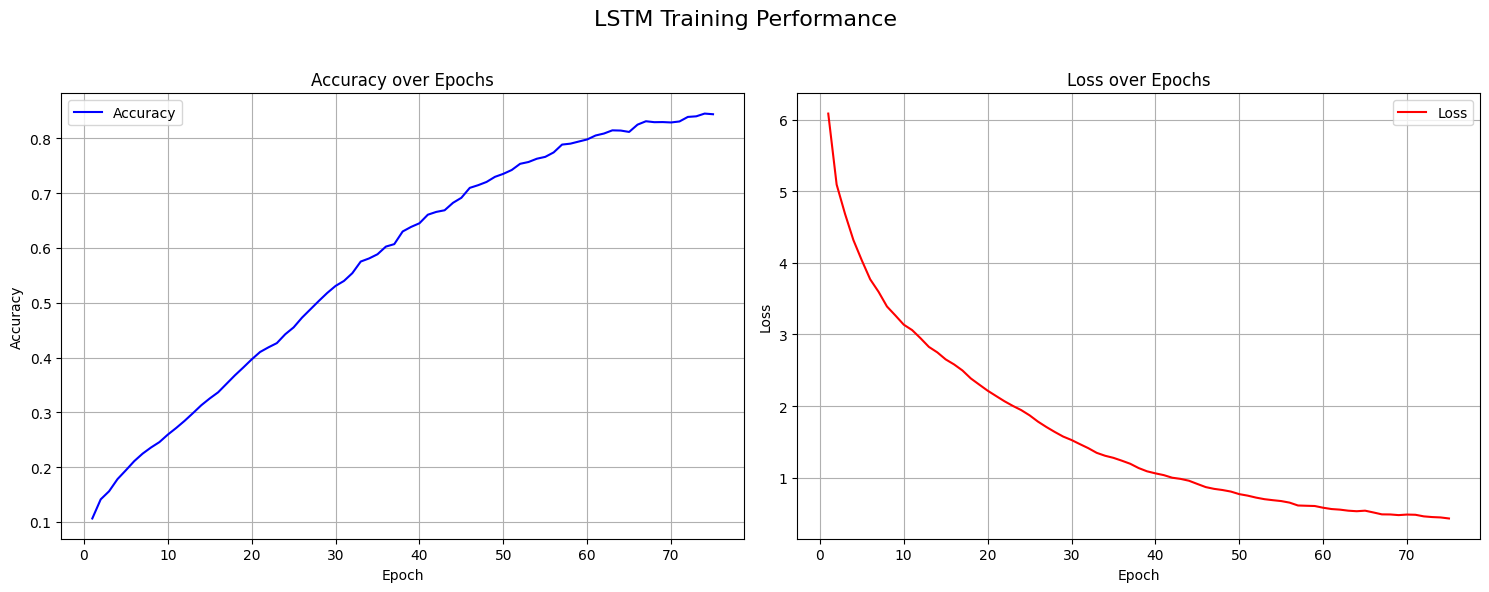

In [12]:
# Create figure and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot accuracy
ax1.plot(range(1, 76), accuracy, label='Accuracy', color='b')
ax1.set_title('Accuracy over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.grid(True)
ax1.legend()

# Plot loss
ax2.plot(range(1, 76), loss, label='Loss', color='r')
ax2.set_title('Loss over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.grid(True)
ax2.legend()

# Set main title
fig.suptitle('LSTM Training Performance', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

**2. Bidirectional LSTM Training Performance Visualization**

In [13]:
# Accuracy values for each epoch
accuracy = [
    0.1506, 0.1797, 0.2007, 0.2166, 0.2279, 0.2417, 0.2519, 0.2634, 0.2745, 0.2854,
    0.2912, 0.3147, 0.3344, 0.3554, 0.3803, 0.3872, 0.4056, 0.4234, 0.4413, 0.4592,
    0.4697, 0.4896, 0.5046, 0.5161, 0.5395, 0.5558, 0.5706, 0.5788, 0.5969, 0.6139,
    0.6350, 0.6475, 0.6630, 0.6757, 0.6901, 0.7037, 0.7149, 0.7256, 0.7347, 0.7479,
    0.7604, 0.7628, 0.7768, 0.7910, 0.7865, 0.7941, 0.8102, 0.8137, 0.8130, 0.8185,
    0.8249, 0.8253, 0.8291, 0.8347, 0.8386, 0.8426, 0.8450, 0.8478, 0.8495, 0.8529,
    0.8488, 0.8515, 0.8564, 0.8655, 0.8614, 0.8649, 0.8661, 0.8686, 0.8693, 0.8693,
    0.8698, 0.8669, 0.8682, 0.8689, 0.8706
]

# Loss values for each epoch
loss = [
    5.0222, 4.5539, 4.1925, 3.9143, 3.7176, 3.5215, 3.4040, 3.2313, 3.1228, 3.0184,
    2.9442, 2.8002, 2.6619, 2.5216, 2.3914, 2.3158, 2.2191, 2.1187, 2.0280, 1.9271,
    1.8692, 1.7908, 1.6890, 1.6234, 1.5401, 1.4751, 1.4011, 1.3471, 1.2809, 1.2190,
    1.1493, 1.0871, 1.0292, 0.9904, 0.9454, 0.8850, 0.8390, 0.8165, 0.7862, 0.7439,
    0.7028, 0.6925, 0.6571, 0.6238, 0.6124, 0.5941, 0.5582, 0.5438, 0.5368, 0.5174,
    0.5009, 0.5000, 0.4835, 0.4724, 0.4554, 0.4503, 0.4382, 0.4287, 0.4149, 0.4241,
    0.4260, 0.4171, 0.3987, 0.3886, 0.3846, 0.3697, 0.3731, 0.3627, 0.3597, 0.3556,
    0.3601, 0.3600, 0.3619, 0.3610, 0.3451
]


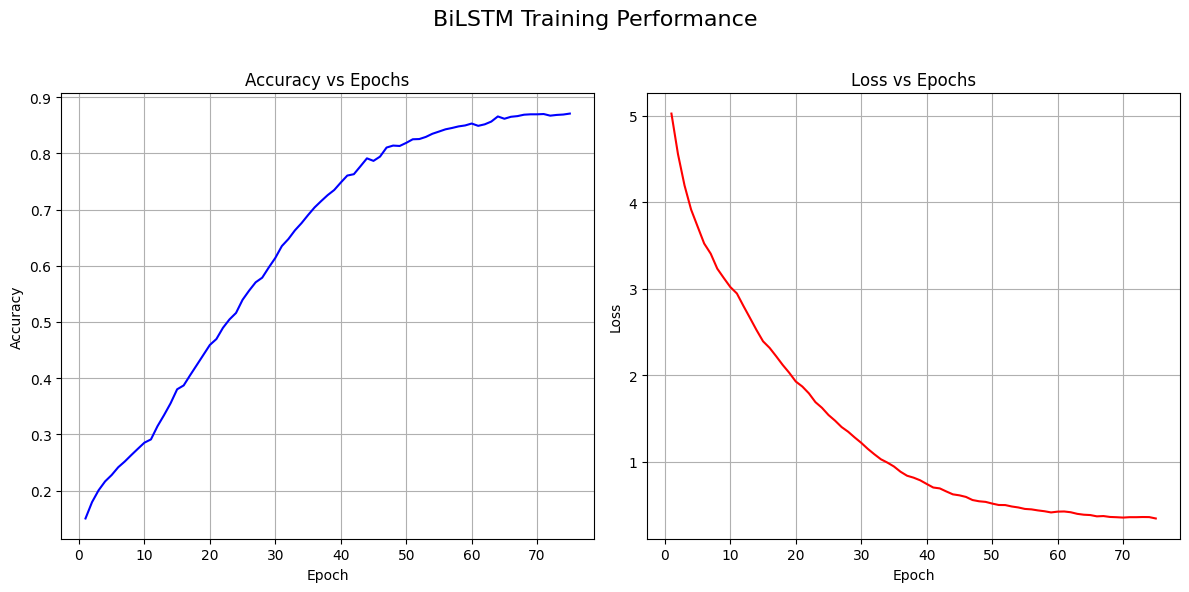

In [16]:
# Plotting Accuracy and Loss
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, 76), accuracy, label='Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, 76), loss, label='Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.grid(True)

# Add a title for the entire figure
plt.suptitle('BiLSTM Training Performance', fontsize=16)

# Show the plots
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# ROUGE Score Evaluation
---
**1. LSTM Model**

In [224]:
import json
import nltk
from rouge_score import rouge_scorer
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import os

# Ensure that NLTK resources are downloaded (for tokenization)
nltk.download('punkt')

def remove_consecutive_repetitions(caption):
    words = caption.split()
    cleaned_words = [words[0]]  # Add the first word initially
    
    for i in range(1, len(words)):
        if words[i] != words[i - 1]:
            cleaned_words.append(words[i])
    
    return " ".join(cleaned_words)

def predict_caption(photo, model, vocab_to_index, index_to_vocab, max_len):
    in_text = "<START>"
    for _ in range(max_len):
        sequence = [vocab_to_index.get(word.upper(), vocab_to_index.get('<UNK>')) for word in in_text.split()]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')
        ypred = model.predict([photo, sequence], verbose=0)
        ypred_idx = ypred.argmax()
        word = index_to_vocab.get(ypred_idx, '<UNK>')
        in_text += f' {word}'
        if word == "<END>":
            break
    
    caption = in_text.replace("<START>", "").replace("<END>", "").strip()
    return remove_consecutive_repetitions(caption)

def load_data(json_path):
    """
    Load the test data from the JSON file.
    
    Args:
        json_path (str): Path to the JSON file containing the test data.
    
    Returns:
        dict: A dictionary with image filenames as keys and list of captions as values.
    """
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data

def calculate_rouge_scores(predicted_captions, ground_truth_captions):
    """
    Calculate ROUGE scores using rouge-score library.
    
    Args:
        predicted_captions (list): List of predicted captions.
        ground_truth_captions (list): List of lists of reference captions (one list per image).
    
    Returns:
        dict: Average ROUGE-1, ROUGE-2, and ROUGE-L scores.
    """
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge1_scores, rouge2_scores, rougeL_scores = [], [], []

    for pred, refs in zip(predicted_captions, ground_truth_captions):
        # Combine reference captions into a single string
        refs_combined = " ".join([" ".join(ref) for ref in refs])
        scores = scorer.score(" ".join(pred), refs_combined)

        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)

    # Calculate average scores
    return {
        "ROUGE-1": sum(rouge1_scores) / len(rouge1_scores),
        "ROUGE-2": sum(rouge2_scores) / len(rouge2_scores),
        "ROUGE-L": sum(rougeL_scores) / len(rougeL_scores),
    }

def evaluate_model_on_dataset(test_data_json, image_dir, model, vocab_to_index, index_to_vocab, max_len):
    predicted_captions = []
    ground_truth_captions = []
    
    for image_id, captions in test_data_json.items():
        # Extract image feature (assuming you have a function for this)
        image_path = os.path.join(image_dir, image_id)
        photo_feature = extract_image_features(image_path).reshape((1, 2048))
        
        # Generate prediction for the image
        predicted_caption = predict_caption(photo_feature, model, vocab_to_index, index_to_vocab, max_len)
        
        # Add predicted caption to the list
        predicted_captions.append(predicted_caption.split())
        
        # Add reference captions to the list (each caption is a list of words)
        ground_truth_captions.append([caption.split() for caption in captions])
    
    # Calculate ROUGE scores
    rouge_scores = calculate_rouge_scores(predicted_captions, ground_truth_captions)
    return rouge_scores

if __name__ == "__main__":
    image_dir = 'dataset/images'  # Path to the images directory
    test_data_json_path = 'test_data.json'  # Path to the test data JSON
    
    # Load test data
    test_data_json = load_data(test_data_json_path)
    
    # Model and vocabulary loading
    model_path = './model_weights/model_epoch_74.keras'  # Path to the saved model
    model = keras.models.load_model(model_path)
    
    # Evaluate model on the dataset and calculate ROUGE scores
    lstm_rouge_scores = evaluate_model_on_dataset(test_data_json, image_dir, model, vocab_to_index, index_to_vocab, max_caption_length)
    
    # Print the ROUGE scores
    print(f"ROUGE scores: {lstm_rouge_scores}")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dalvi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


ROUGE scores: {'ROUGE-1': 0.35294117647058826, 'ROUGE-2': 0.25, 'ROUGE-L': 0.29411764705882354}


**2. Bidirectional LSTM**

In [225]:
if __name__ == "__main__":
    image_dir = 'dataset/images'  # Path to the images directory
    test_data_json_path = 'test_data.json'  # Path to the test data JSON
    
    # Load test data
    test_data_json = load_data(test_data_json_path)
    
    # Model and vocabulary loading
    model_path = './model_weights/BiLSTM/model_epoch_74.keras'  # Path to the saved model
    model = keras.models.load_model(model_path)
    
    # Evaluate model on the dataset and calculate ROUGE scores
    Bilstm_rouge_scores = evaluate_model_on_dataset(test_data_json, image_dir, model, vocab_to_index, index_to_vocab, max_caption_length)
    
    # Print the ROUGE scores
    print(f"ROUGE scores: {Bilstm_rouge_scores}")

ROUGE scores: {'ROUGE-1': 0.25, 'ROUGE-2': 0.13333333333333333, 'ROUGE-L': 0.1875}


## ROUGE Score Comparison

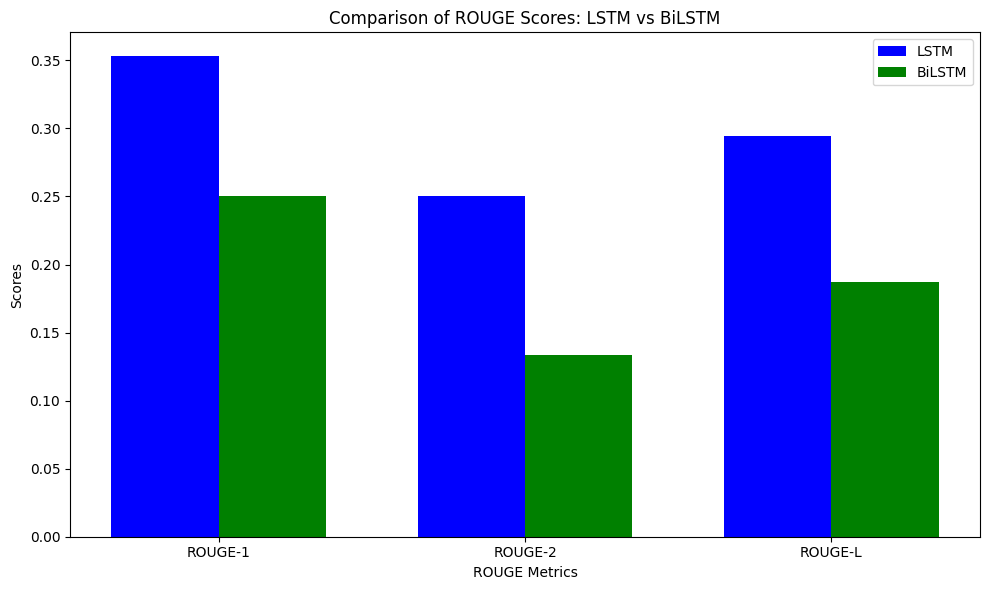

In [227]:
import matplotlib.pyplot as plt
import numpy as np

# Categories for ROUGE scores
metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']

# Values for LSTM and BiLSTM models
lstm_scores = [lstm_rouge_scores[metric] for metric in metrics]
bilstm_scores = [Bilstm_rouge_scores[metric] for metric in metrics]

# Set width for bars
bar_width = 0.35

# X-axis positions for bars
index = np.arange(len(metrics))

# Plotting
plt.figure(figsize=(10, 6))
bar1 = plt.bar(index, lstm_scores, bar_width, label='LSTM', color='b')
bar2 = plt.bar(index + bar_width, bilstm_scores, bar_width, label='BiLSTM', color='g')

# Adding labels and title
plt.xlabel('ROUGE Metrics')
plt.ylabel('Scores')
plt.title('Comparison of ROUGE Scores: LSTM vs BiLSTM')
plt.xticks(index + bar_width / 2, metrics)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


# Saving Model Weights and Additional Data for Future Predictions

In this section, you are saving important data and model components to disk that will be crucial for future predictions or reloading the model for further usage. Here's a breakdown of each item saved:


#### **1. Saving All Words List**

The `all_words` list, which contains every word used in the captions throughout the dataset, is saved. This is important to maintain consistency in the vocabulary used for future predictions or evaluations.
- **Purpose**: This list contains every word seen during training, which might be used for evaluating or generating captions in the future.


In [52]:
# Save additional data for future predictions
with open('./model_weights/all_words.pkl', 'wb') as file:
    pickle.dump(all_words, file)
print("Saved all_words to './model_weights/all_words.pkl'")

Saved all_words to './model_weights/all_words.pkl'


#### **2. Saving Training Captions Dictionary**

The `train_captions_dict`, which holds the captions for all images in the training set, is saved. This dictionary is essential for the training process and can be used to re-evaluate or continue training the model.
- **Purpose**: This dictionary contains the cleaned and preprocessed captions for each image in the training dataset. It allows you to recreate or evaluate the captions during or after training.


In [51]:
with open('./model_weights/train_captions_dict.pkl', 'wb') as file:
    pickle.dump(train_captions_dict, file)
print("Saved train_captions_dict to './model_weights/train_captions_dict.pkl'")

Saved train_captions_dict to './model_weights/train_captions_dict.pkl'


#### **3. Saving Vocab-to-Index Mapping**

The `vocab_to_index` dictionary, which maps each word in the vocabulary to a unique index, is saved. This mapping is crucial for converting words in captions to indices during both training and inference.
- **Purpose**: This dictionary helps in converting words into indices and is essential for inference and further model use.


In [53]:
with open('./model_weights/vocab_to_index.pkl', 'wb') as file:
    pickle.dump(vocab_to_index, file)
print("Saved vocab_to_index to './model_weights/vocab_to_index.pkl'")

Saved vocab_to_index to './model_weights/vocab_to_index.pkl'


#### **4. Saving Index-to-Vocab Mapping**

The `index_to_vocab` dictionary, which maps indices back to words, is saved. This is important for converting predicted indices from the model into actual words when generating captions.
- **Purpose**: After the model generates output in terms of indices, this mapping helps convert those indices back to words for human-readable captions.


In [54]:
with open('./model_weights/index_to_vocab.pkl', 'wb') as file:
    pickle.dump(index_to_vocab, file)
print("Saved index_to_vocab to './model_weights/index_to_vocab.pkl'")

Saved index_to_vocab to './model_weights/index_to_vocab.pkl'


#### **5. Saving the Embedding Matrix**

The pre-trained GloVe embedding matrix is saved, which contains word vectors for each word in the vocabulary. This matrix is used by the model’s embedding layer to map words to dense vector representations.
- **Purpose**: The embedding matrix stores the word embeddings that the model uses to understand the semantic relationships between words. Saving this matrix ensures consistency during future predictions.


In [55]:
with open('./model_weights/embedding_matrix.pkl', 'wb') as file:
    pickle.dump(embedding_matrix, file)
print("Saved embedding_matrix to './model_weights/embedding_matrix.pkl'")

Saved embedding_matrix to './model_weights/embedding_matrix.pkl'


# Manual Prediction

In [56]:
import pickle

# Load all the saved data
with open('./model_weights/all_words.pkl', 'rb') as file:
    all_words = pickle.load(file)
print("Loaded all_words from './model_weights/all_words.pkl'")

with open('./model_weights/train_captions_dict.pkl', 'rb') as file:
    train_captions_dict = pickle.load(file)
print("Loaded train_captions_dict from './model_weights/train_captions_dict.pkl'")

with open('./model_weights/vocab_to_index.pkl', 'rb') as file:
    vocab_to_index = pickle.load(file)
print("Loaded vocab_to_index from './model_weights/vocab_to_index.pkl'")

with open('./model_weights/index_to_vocab.pkl', 'rb') as file:
    index_to_vocab = pickle.load(file)
print("Loaded index_to_vocab from './model_weights/index_to_vocab.pkl'")

with open('./model_weights/embedding_matrix.pkl', 'rb') as file:
    embedding_matrix = pickle.load(file)
print("Loaded embedding_matrix from './model_weights/embedding_matrix.pkl'")


Loaded all_words from './model_weights/all_words.pkl'
Loaded train_captions_dict from './model_weights/train_captions_dict.pkl'
Loaded vocab_to_index from './model_weights/vocab_to_index.pkl'
Loaded index_to_vocab from './model_weights/index_to_vocab.pkl'
Loaded embedding_matrix from './model_weights/embedding_matrix.pkl'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


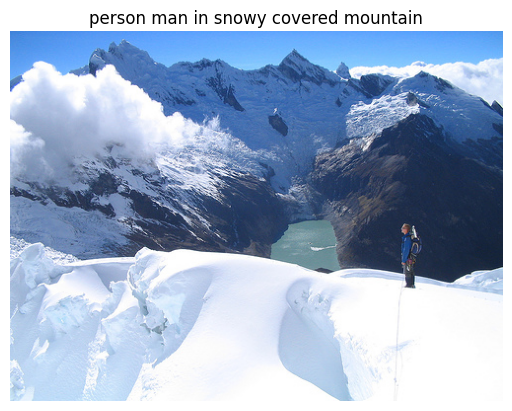

In [203]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

def remove_consecutive_repetitions(caption):
    """
    Remove consecutive repetitive words in a caption.
    
    Args:
        caption (str): The caption string to clean.
    
    Returns:
        str: The cleaned caption.
    """
    words = caption.split()
    cleaned_words = [words[0]]  # Add the first word initially
    
    for i in range(1, len(words)):
        if words[i] != words[i - 1]:
            cleaned_words.append(words[i])
    
    return " ".join(cleaned_words)

def predict_caption(photo, model, vocab_to_index, index_to_vocab, max_len):
    """
    Generate a caption for a given photo using the trained model.
    
    Args:
        photo (ndarray): The feature vector of the image.
        model (keras.Model): The trained model for captioning.
        vocab_to_index (dict): Vocabulary to index mapping.
        index_to_vocab (dict): Index to vocabulary mapping.
        max_len (int): Maximum length of the caption.
    
    Returns:
        str: The predicted caption.
    """
    in_text = "<START>"
    for _ in range(max_len):
        # Convert the input caption to sequence of indices
        sequence = [vocab_to_index.get(word.upper(), vocab_to_index.get('<UNK>')) for word in in_text.split()]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')
        
        # Predict the next word
        ypred = model.predict([photo, sequence], verbose=0)
        ypred_idx = ypred.argmax()
        word = index_to_vocab.get(ypred_idx, '<UNK>')
        
        in_text += f' {word}'
        if word == "<END>":
            break
    
    # Remove special tokens and clean the caption
    caption = in_text.replace("<START>", "").replace("<END>", "").strip()
    return remove_consecutive_repetitions(caption)

def test_model_on_new_image(image_path, model, vocab_to_index, index_to_vocab, max_len):
    """
    Test the trained model on a new image and display the results.
    
    Args:
        image_path (str): Path to the image.
        model (keras.Model): The trained model for captioning.
        vocab_to_index (dict): Vocabulary to index mapping.
        index_to_vocab (dict): Index to vocabulary mapping.
        max_len (int): Maximum length of the caption.
    """
    # Extract features from the image
    photo_feature = extract_image_features(image_path).reshape((1, 2048))
    
    # Predict the caption
    predicted_caption = predict_caption(photo_feature, model, vocab_to_index, index_to_vocab, max_len)
    #print(predicted_caption)
    
    # Display the image with the predicted caption
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title(predicted_caption)
    plt.show()

# Example usage
if __name__ == "__main__":
    image_path = "test.jpg"  # Path to the test image
    #model_path = './model_weights/BiLSTM/model_epoch_74.keras'  # Path to the saved model
    model_path = './model_weights/model_epoch_74.keras'  # Path to the saved model
    
    # Load the trained model
    model = keras.models.load_model(model_path)
    # Test the model
    test_model_on_new_image(image_path, model, vocab_to_index, index_to_vocab, max_caption_length)